# 11. Estratégia de Modelagem

## 11.1. Definição da Variável Target

A escolha da **variável target** é uma decisão estrutural que impacta diretamente a capacidade de generalização dos modelos. Neste projeto, foram geradas duas versões da margem líquida:

- target (raw): Margem líquida sem tratamento de outliers
- target_win (winsorizada): Margem líquida com winsorização nos percentis 1% e 99%

**Análise Comparativa**

| Critério | Target Raw | Target Winsorizada |
|-------|--------|-------------------|
| Outliers extremos | Preserva valores extremos (positivos e negativos) | Limita valores aos percentis 1% e 99% |
| Risco de overfitting | Alto — modelos podem ajustar regras específicas para casos raros | Reduzido — distribuição mais estável |
| Interpretabilidade | Reflete a realidade "crua" do negócio | Reflete a realidade "típica" do negócio |
| Estabilidade temporal | Vulnerável a eventos pontuais (promoções, bugs, fraudes) | Mais robusta a choques temporários |
| Performance em produção | Pode degradar em períodos atípicos | Tende a manter performance mais consistente |

**Decisão Técnica**: utilizaremos `target_win` (winsorizada) como variável target principal.

Justificativa:

1. Robustez estatística: A winsorização reduz a influência de outliers extremos sem descartá-los completamente, preservando informação enquanto estabiliza a distribuição.
2. Generalização: Modelos treinados com target winsorizada tendem a aprender padrões mais generalizáveis, evitando ajustes excessivos a casos raros que podem não se repetir em produção.
3. Estabilidade em produção: Em ambientes de produção, é preferível um modelo que erra menos na média do que um modelo que acerta perfeitamente casos extremos mas falha na maioria dos casos típicos.
4. Alinhamento com o negócio: A margem winsorizada representa melhor o comportamento "esperado" da base de clientes, sendo mais útil para decisões estratégicas (precificação, segmentação, retenção).
5. Redução de viés induzido por eventos pontuais: Valores extremos podem ser resultado de erros de sistema, fraudes, ou promoções não-recorrentes. A winsorização mitiga o risco de o modelo aprender padrões pouco ou nada frequentes.

## 11.2. Escolha dos Algoritmos

A fim de equilibrar capacidade preditiva, interpretabilidade, custo computacional e viabilidade de implantação em produção, optou-se por uma abordagem 'multi-modelo', combinando famílias complementares, como mencionado anteriormente no projeto:

### 11.2.1. Elastic Net (Regressão Linear Regularizada)

**Elastic Net** combina as penalizações L1 (Lasso) e L2 (Ridge), oferecendo:

- Seleção automática de features (via L1): Zera coeficientes de variáveis irrelevantes
- Estabilidade numérica (via L2): Lida melhor com multicolinearidade que Lasso puro
- Interpretabilidade máxima: Coeficientes lineares permitem explicar o impacto marginal de cada feature
- Baixíssimo custo computacional: Treinamento e inferência extremamente rápidos
- Baseline robusto: Serve como referência para avaliar se modelos complexos realmente agregam valor

**Por que Elastic Net?**

Mesmo que a relação não seja linear, um modelo linear regularizado ($L_1 + L_2$) serve como um baseline de baixa variância. Ele captura a tendência global (o "viés principal") e impede que os modelos não-lineares fiquem "loucos" com ruídos locais. Ele é o "seguro" contra o overfit.

**Comparação com Alternativas Lineares**

| Modelo | Vantagens | Desvantagens | Por que não escolher? |
|--------|-----------|--------------|-----------------------|
|Regressão Linear Simples (OLS)	| Máxima interpretabilidade	| Sem regularização, vulnerável a overfitting e multicolinearidade | Não lida bem com alta dimensionalidade |
|Ridge (L2) |	Estabiliza coeficientes	| Não faz seleção de features (mantém todas) | Elastic Net oferece o melhor dos dois mundos |
|Lasso (L1) |	Seleção de features	| Instável com features correlacionadas | Elastic Net é mais robusto |
|Elastic Net |	Seleção + Estabilidade | Assume relações lineares| Escolhido |

**_Trade-off Bias-Variance_ + Interpretabilidade**

* Viés: Moderado/alto. Assume linearidade, "simplificando" demais o problema;
* Variância: Baixa. Regularização controla complexidade;
* Interpretabilidade: Máxima. Coeficientes diretos ($\beta$) indicam o impacto de cada variável.

### 11.2.2. LightGBM (Gradient Boosting com Otimizações)

Por que LightGBM (e não XGBoost ou CatBoost)? LightGBM é uma implementação moderna de Gradient Boosting otimizada para eficiência e escalabilidade.

**Comparação Detalhada: LightGBM vs. XGBoost vs. CatBoost**

| Critério | LightGBM | XGBoost | CatBoost | Decisão | 
|----------|----------|---------|----------|---------|
Velocidade de treinamento |	(5) Crescimento leaf-wise e amostragem GOSS reduzem custo por nó. | (3) Crescimento level-wise exige mais divisões por nível. | (2) O processamento de Ordered Boosting é computacionalmente caro | LightGBM |
Uso de memória | (5) Algoritmo baseado em histogramas otimiza o uso de RAM. | (3) Tradicionalmente exige estruturas de dados (DMatrix) mais pesadas. | (3) Árvores simétricas e cache de categorias consomem recursos consideráveis. | LightGBM |
Performance preditiva | (5) Estado da arte; excelente em capturar nuances em bases grandes. | (5) Extremamente robusto e consistente em diversos domínios. | (5) Frequentemente superior em bases com muitas variáveis categóricas. | Empate técnico |
Tratamento de categóricas | (4) Agrupa categorias por valores, mas exige conversão prévia para `int`. | (4) Apesar de melhora recente, ainda depende muito de pré-processamento. | (5) Otimização nativa via Permutation Encoding (padrão ouro). | CatBoost |
Overfitting em bases pequenas |	(2) O crescimento folha a folha é muito agressivo para poucos dados. | (5) O crescimento por nível e controle de profundidade agem como regularizadores. | (5) Árvores simétricas evitam que o modelo "decore" ruídos locais. | XGBoost/CatBoost |
Maturidade e adoção | (5) Padrão da indústria | (5) O mais antigo e testado em ambientes de missão crítica. | (3) Mais recente; comunidade e bibliotecas de apoio ainda em expansão. | LightGBM/XGBoost |
Facilidade de deploy | (5) Integração nativa com MLflow, por exemplo. | (4) Robusto, mas o ecossistema de serialização é levemente mais burocrático. | (3) Menos ferramentas de terceiros suportam seus formatos nativos. | LightGBM |
Suporte a GPU |	(5) Excelente escalabilidade paralela. | (5) Muito eficiente, especialmente em histogramas. | (5) Projetado para brilhar em GPUs (treina muito mais rápido nelas). | Empate |
Documentação e comunidade | (5) Vasta literatura e soluções de erros online. | (5) Referência absoluta em fóruns técnicos. | (4) Boa documentação, mas menos "receitas de bolo" disponíveis. | LightGBM/XGBoost |

**Por que LightGBM?** Justificativa:

1. Eficiência computacional superior: base com milhões de registros (~11M), LightGBM se mostra significativamente mais rápido que XGBoost e CatBoost, permitindo iterações mais rápidas de experimentação;
2. Menor consumo de memória: utiliza histogramas para discretizar features contínuas, reduzindo drasticamente o uso de RAM;
3. Arquitetura Leaf-wise: enquanto o XGBoost cresce nível por nível, o LightGBM foca nos nós que mais reduzem o erro (perda). Isso o torna performático em bases grandes, pois chega no "ponto ideal" mais rápido, resultando em modelos mais profundos com menos árvores;
4. Flexibilidade: feature importance nativo facilita mapear gain/split.

**Por que não XGBoost?**

1. XGBoost é excelente, mas mais lento e mais pesado em memória para bases grandes;
2. A diferença de performance preditiva entre LightGBM e XGBoost **bem-tunados** é marginal;
3. LightGBM oferece melhor custo-benefício para experimentação rápida.

**Por que não CatBoost?**

Apesar de melhor tratamento nativo de categóricas:

1. Muito mais lento para treinar (especialmente sem GPU);
2. Base já com encoding adequado das categóricas'
3. O ganho marginal não justifica o custo computacional adicional.

**_Trade-off Bias-Variance_ + Interpretabilidade**

* Viés: Baixo. Modelos complexos capturam não-linearidades;
* Variância: Moderada/alta. Boosting sequencial reduz variância. Se mostra muito preciso, mas propenso a overfitting.;
* Interpretabilidade: Média. Requer ferramentas como SHAP values, feature importance, não sendo possivel analisar coeficientes diretos.

### 11.2.3. Random Forest Regressor

**Random Forest vs. Quantile Regression Forest (QRF)**

| Critério | RFR | QRF | Justificativa (pensando nos +10M de registros) |
|----------|-----|-----|------------------------------------------------|
| Objetivo do Modelo | 5 | 5 | O RFR foca na média e o QRF em quantis. Após a winsorização (1%/99%), a média torna-se um estimador estável para a margem líquida. |
| Robustez a Outliers | 3 | 5 | O QRF é nativamente robusto. No RFR, essa robustez foi "transferida" para o pré-processamento (winsorização), nivelando o jogo. |
| Incerteza Preditiva | 1 | 5 | O QRF fornece intervalos (P10-P90) nativos. O RFR entrega apenas a estimativa pontual, exigindo métodos externos para incerteza. |
| Velocidade de Treino | 5 | 2 | O RFR calcula apenas a média por folha. O QRF precisa ordenar e armazenar todas as observações em cada folha, gerando alto overhead. |
| Velocidade de Inferência | 5 | 1 | No RFR, a inferência é um acesso direto ao valor da folha. No QRF, o modelo precisa calcular quantis sobre a massa de dados em tempo real. |
| Uso de Memória (RAM) | 5 | 1 | O QRF armazena as labels de treino nas folhas. Com +10M de linhas, o risco de Out-of-Memory é crítico no QRF. |
| Interpretabilidade | 4 | 4 | Ambos permitem o uso de SHAP e Feature Importance de forma idêntica, sendo transparentes para auditorias. |
| Maturidade em Prod. | 5 | 2 | O RFR é padrão ouro no Scikit-Learn e Spark. O QRF depende de bibliotecas menos estáveis e com menor suporte da comunidade. |
| Facilidade de Deploy | 5 | 2 | Modelos RFR são leves (serialização simples). Arquivos de modelos QRF são massivos e de difícil transporte em pipelines de CI/CD. |

A escolha inicial pelo Quantile Regression Forest (QRF) fundamentava-se na natureza estatística bruta da variável alvo (Margem Líquida M+1). Como visto, a target "raw" apresenta assimetria severa (skewed distribution), com caudas longas causadas por eventos extremos (imagino que sejam picos de custos de licenciamento ou usuários com consumo fora da curva, considerando o negocio de uma plataforma de streaming de musicas).

Sem tratamento prévio, o Random Forest Regressor tradicional falharia em representar o "cliente típico". Por minimizar o Erro Quadrático Médio (MSE), o RFR é "sequestrado" pelos outliers, pois o erro ao quadrado penaliza excessivamente os valores extremos, puxando a previsão em direção à média da cauda. O QRF, ao focar na mediana condicional, ignoraria a magnitude desses extremos, oferecendo uma previsão mais estável e centralizada.

**O Cenário Pós-Winsorização: Por que o RFR vence?**

Justificativa:

1. Alinhamento com o target winsorizado: com outliers via winsorização, a vantagem de robustez do QRF é parcialmente neutralizada;
2. Simplicidade operacional: Random Forest tem implantação simples em qualquer stack de produção (sklearn, ONNX, etc.), enquanto QRF requer bibliotecas específicas (ex: quantile-forest, scikit-garden);
3. Custo computacional em produção: QRF é significativamente mais lento, pois precisa calcular distribuições empíricas em cada folha. Em um sistema de scoring em lote (milhões de clientes), isso pode ser prejudicial;
4. Maturidade e suporte: Random Forest tem décadas de uso em produção, documentação extensa, e integração nativa com ferramentas de MLOps.

**Quando QRF seria preferível?**

* Se o objetivo fosse gestão de risco (ex: "qual a margem no pior cenário P10?");
* Se houvesse requisito explícito de quantificar incerteza (estudo será feito com modelos de agrupamento, no lugar);
* Se a distribuição da target fosse altamente assimétrica mesmo após winsorização.

Em resumo: O QRF era a solução para um problema de dados brutos e ruidosos; o RFR é a solução otimizada para dados refinados e prontos para produção.

**_Trade-off Bias-Variance_ + Interpretabilidade**

* Viés: Moderado. Árvores profundas capturam não-linearidades, mas média de árvores suaviza;
* Variância: Baixa. Bagging reduz drasticamente variância;
* Interpretabilidade: Média (feature importance, partial dependence plots).

## 11.3. _Ensemble Learning_ e Arquitetura Multi-Modelo

### 11.3.1 Definição

_Ensemble Learning_ (Aprendizado em Conjunto) é a estratégia de _Machine Learning_ que combina múltiplos modelos preditivos para produzir um resultado superior ao que seria obtido por qualquer modelo individual isoladamente. A premissa fundamental é que a sabedoria coletiva de modelos diversos supera a capacidade de um único modelo especializado. A teoria estatística por trás dos ensembles baseia-se em três princípios:

#### 11.3.1.1. Decomposição do Erro: _Bias-Variance Trade-off_

O erro esperado de um modelo pode ser decomposto em três componentes:

Erro Total = Viés² +  Variância + Ruído Irredutível

* Viés: Erro sistemático causado por suposições simplificadoras do modelo (ex: assumir linearidade quando a relação é não-linear);
* Variância: Sensibilidade do modelo a flutuações nos dados de treino (overfitting);
* Ruído Irredutível: Aleatoriedade inerente aos dados que nenhum modelo pode capturar. Erro impossivel de ser mitigado.

Ensembles exploram esse trade-off de duas formas:

1. Redução de Variância (_Bagging_): Treinar múltiplos modelos em subconjuntos diferentes dos dados e agregar suas predições reduz a variância sem aumentar o viés. Exemplo: Random Forest;
2. Redução de Viés (_Boosting_): Treinar modelos sequencialmente, onde cada novo modelo corrige os erros do anterior, reduz o viés mantendo a variância controlada. Exemplo: LightGBM.

#### 11.3.1.2. Diversidade de Modelos

Para que um ensemble seja efetivo, os modelos componentes devem ser diversos — ou seja, devem cometer erros diferentes. Se todos os modelos erram da mesma forma, agregá-los não traz benefício. Fontes de diversidade:

* Algoritmos diferentes: Modelos lineares vs. árvores vs. redes neurais
* Representações diferentes: Features brutas vs. features engenheiradas vs. embeddings
* Dados diferentes: Bootstrap samples, cross-validation folds, janelas temporais
* Hiperparâmetros diferentes: Profundidade de árvores, regularização, learning rate

#### 11.3.1.3. Teorema do "Wisdom of Crowds"

Se tivermos 𝑁 modelos independentes, cada um com acurácia 𝑝 > 0.5, a acurácia do ensemble (votação por maioria) aumenta exponencialmente com 𝑁. Mesmo que modelos individuais sejam fracos, sua combinação pode ser forte.

### 11.3.2. Primeira abordagem escolhida: Ensemble Heterogêneo Multi-Nível

A estratégia planejada a princípio para este projeto não seria um ensemble tradicional (como Random Forest ou Gradient Boosting isoladamente), mas sim um meta-ensemble heterogêneo, combinando:

* Modelos de famílias algorítmicas distintas (linear, boosting, bagging);
* Representações de features customizadas por modelo (OHE para Elastic Net, TEs para LightGBM e RFR);
* Objetivos complementares (interpretabilidade vs. performance vs. robustez).

### 11.3.3 Decisão final

Apesar da primeira abordagem proposta se mostrar robusta, dado que cada modelo traria uma "perspectiva" diferente sobre a predição "x" e isso permitiria que se escolhesse uma média ponderada dos três outputs dos modelos para uma predição final mais precisa, a solução se mostra complexa de ser implantada em produção. 

Considerar o modelo final como o meta-modelo de outros n algoritmos implica que, em estudos de monitoramento, por exemplo, o cientista responsável pelo processo analise os n algoritmos e a forma como cada um deles individualmente está performando. Além disso, as bases finais de execução dos modelos não contemplam as mesmas variáveis (no caso de EN vs. LGBM e RF, que são baseados em árvores) e nível de tratamento destas variáveis, caso em comum entre si (nulos sem tratamento para LGBM, tratados para RFR, mesmo sendo as mesmas variáveis).

Se as métricas consideradas como decisivas pra escolha de um único modelo final forem muito próximas, faz muito mais sentido escolher um modelo finalista dentre esses três do que implementar uma solução complexa para unir todos.

# 12. _Feature Selection_ - ABTs p/ Algoritmo Supervisionado - Camada _Gold_

## 12.1. Carregando base e separando tipos de variaveis

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver"
df_feature_store_intermediate = spark.read.parquet(f"{silver_path}/df_feature_store_intermediate")

In [ ]:
df_feature_store_intermediate.printSchema()

root
 |-- msno: string (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- flag_has_logs: integer (nullable = true)
 |-- total_plays_group: string (nullable = true)
 |-- log_total_plays: double (nullable = true)
 |-- completed_songs_rate: double (nullable = true)
 |-- completed_songs_rate_group: string (nullable = true)
 |-- avg_secs_per_unq: double (nullable = true)
 |-- avg_secs_per_unq_cap: double (nullable = true)
 |-- avg_secs_per_unq_cap_group: string (nullable = true)
 |-- log_avg_secs_per_unq: double (nullable = true)
 |-- plays_per_unq: double (nullable = true)
 |-- plays_per_unq_cap: double (nullable = true)
 |-- plays_per_unq_behavior: string (nullable = true)
 |-- plays_behavior_vs_volume: st

In [ ]:
df_feature_store_intermediate.count()

11242865

In [ ]:
# Separar features por tipo
schema = df_feature_store_intermediate.schema

In [ ]:
# 1. Defina o que nunca deve ser feature
blacklist = ['msno', 'safra', 'target', 'target_win']

In [ ]:
# 2. Categoricas (Geralmente Strings)
features_categoricas = [
    f.name for f in schema.fields 
    if isinstance(f.dataType, StringType) and f.name not in blacklist
]

In [ ]:
# 3. Flags (Binárias, Lags, Min, Max) - Tudo que é 0/1 ou limite inferior/superior
features_flags = [
    f.name for f in schema.fields 
    if f.name not in blacklist 
    and f.name.startswith('flag_') 
    and not any(x in f.name for x in ['_mean_', '_ratio_', '_sum_']) # EXCLUI o que é contínuo
]

In [ ]:
# 4. Numéricas Contínuas (Médias, Razões, Somas e valores monetários/quantidades)
features_numericas_continuas = [
    f.name for f in schema.fields 
    if f.name not in blacklist 
    and f.name not in features_flags # GARANTE que não repete o que já é flag
    and f.name not in features_categoricas
    and isinstance(f.dataType, (DoubleType, FloatType, IntegerType))
]

In [ ]:
len(schema.fields)

321

In [ ]:
print("=" * 80)
print("📊 INVENTÁRIO DE FEATURES")
print("=" * 80)

print(f"\n🔢 Features Numéricas Contínuas + Flags de tendencia media e/ou soma: {len(features_numericas_continuas)}")
print(f"   (ex: total_secs, num_unq, revenue_per_hour, etc.)")

print(f"\n🚩 Flags Binárias Na Referencia, Com Lag e Transformadas com Maximo e Minimo: {len(features_flags)}")
print(f"   (ex: flag_shallow_user, flag_premium_sum_6, etc.)")

print(f"\n📝 Features Categóricas: {len(features_categoricas)}")
print(f"   (ex: city, gender, plays_behavior_vs_volume, etc.)")

print(f"\n✅ TOTAL: {len(features_numericas_continuas) + len(features_flags) + len(features_categoricas)}")

print("\n" + "=" * 80)

# Visualizar exemplos de cada tipo
print(f"\n🔍 Exemplos de Features Numéricas Contínuas (primeiras 10):")
for feat in features_numericas_continuas[:3]:
    print(f"  • {feat}")

print(f"\n🔍 Exemplos de Flags Binárias Puras (primeiras 3):")
for feat in features_flags[:3]:
    print(f"  • {feat}")

print(f"\n🔍 Exemplos de Features Categóricas (primeiras 3):")
for feat in features_categoricas[:3]:
    print(f"  • {feat}")

📊 INVENTÁRIO DE FEATURES

🔢 Features Numéricas Contínuas + Flags de tendencia media e/ou soma: 219
   (ex: total_secs, num_unq, revenue_per_hour, etc.)

🚩 Flags Binárias Na Referencia, Com Lag e Transformadas com Maximo e Minimo: 75
   (ex: flag_shallow_user, flag_premium_sum_6, etc.)

📝 Features Categóricas: 19
   (ex: city, gender, plays_behavior_vs_volume, etc.)

✅ TOTAL: 313


🔍 Exemplos de Features Numéricas Contínuas (primeiras 10):
  • num_25
  • num_50
  • num_75

🔍 Exemplos de Flags Binárias Puras (primeiras 3):
  • flag_has_logs
  • flag_shallow_user
  • flag_has_logs_raw

🔍 Exemplos de Features Categóricas (primeiras 3):
  • total_plays_group
  • completed_songs_rate_group
  • avg_secs_per_unq_cap_group


### Checando as que ficaram de fora

In [ ]:
set_schema = set([f.name for f in schema.fields])
set_features = set(features_numericas_continuas + features_flags + features_categoricas)
set_out = set_schema - set_features
print(f"Colunas fora das listas: {set_out}")

Colunas fora das listas: {'registration_init_time', 'tenure_meses', 'safra', 'transaction_date', 'target', 'msno', 'target_win', 'membership_expire_date'}


In [ ]:
df_features_check = df_feature_store_intermediate.select(*set_out)
df_features_check.printSchema()

root
 |-- registration_init_time: date (nullable = true)
 |-- tenure_meses: long (nullable = true)
 |-- safra: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- target: double (nullable = true)
 |-- msno: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- membership_expire_date: date (nullable = true)



In [ ]:
features_numericas_continuas.append("tenure_meses")
features_categoricas.append('membership_expire_date')
features_categoricas.append('transaction_date')
features_categoricas.append('registration_init_time')

In [ ]:
print("=" * 80)
print("📊 INVENTÁRIO DE FEATURES")
print("=" * 80)

print(f"\n🔢 Features Numéricas Contínuas + Flags de tendencia media e/ou soma: {len(features_numericas_continuas)}")
print(f"   (ex: total_secs, num_unq, revenue_per_hour, etc.)")

print(f"\n🚩 Flags Binárias Na Referencia, Com Lag e Transformadas com Maximo e Minimo: {len(features_flags)}")
print(f"   (ex: flag_shallow_user, flag_premium_sum_6, etc.)")

print(f"\n📝 Features Categóricas: {len(features_categoricas)}")
print(f"   (ex: city, gender, plays_behavior_vs_volume, etc.)")

print(f"\n✅ TOTAL: {len(features_numericas_continuas) + len(features_flags) + len(features_categoricas)}")

print("\n" + "=" * 80)

# Visualizar exemplos de cada tipo
print(f"\n🔍 Exemplos de Features Numéricas Contínuas (primeiras 10):")
for feat in features_numericas_continuas[:3]:
    print(f"  • {feat}")

print(f"\n🔍 Exemplos de Flags Binárias Puras (primeiras 3):")
for feat in features_flags[:3]:
    print(f"  • {feat}")

print(f"\n🔍 Exemplos de Features Categóricas (primeiras 3):")
for feat in features_categoricas[:3]:
    print(f"  • {feat}")

set_schema = set([f.name for f in schema.fields])
set_features = set(features_numericas_continuas + features_flags + features_categoricas)
set_out = set_schema - set_features
print(f"Colunas fora das listas: {set_out}")

📊 INVENTÁRIO DE FEATURES

🔢 Features Numéricas Contínuas + Flags de tendencia media e/ou soma: 220
   (ex: total_secs, num_unq, revenue_per_hour, etc.)

🚩 Flags Binárias Na Referencia, Com Lag e Transformadas com Maximo e Minimo: 75
   (ex: flag_shallow_user, flag_premium_sum_6, etc.)

📝 Features Categóricas: 22
   (ex: city, gender, plays_behavior_vs_volume, etc.)

✅ TOTAL: 317


🔍 Exemplos de Features Numéricas Contínuas (primeiras 10):
  • num_25
  • num_50
  • num_75

🔍 Exemplos de Flags Binárias Puras (primeiras 3):
  • flag_has_logs
  • flag_shallow_user
  • flag_has_logs_raw

🔍 Exemplos de Features Categóricas (primeiras 3):
  • total_plays_group
  • completed_songs_rate_group
  • avg_secs_per_unq_cap_group
Colunas fora das listas: {'target_win', 'target', 'safra', 'msno'}


## 12.2. Tratamentos Gerais

### Objetivo


Reduzir as 318 features para um conjunto otimizado (~50-100 features) que maximize performance preditiva e interpretabilidade dos modelos.

### Removendo os casos em que a target esta nula

In [ ]:
df_feature_store_intermediate.filter(F.col("target_win").isNull()).count()

1563999

In [ ]:
# Identificar última safra de cada cliente
w_ultima_safra = Window.partitionBy('msno').orderBy(F.desc('safra'))

df_feature_store_intermediate_teste = df_feature_store_intermediate.withColumn(
    'is_ultima_safra',
    F.when(F.row_number().over(w_ultima_safra) == 1, 1).otherwise(0)
)

# ═══════════════════════════════════════════════════════════
# ETAPA 2: Split Explícito
# ═══════════════════════════════════════════════════════════

# Dataset de TREINO/VALIDAÇÃO (tem target)
df_train = df_feature_store_intermediate_teste.filter(F.col('target_win').isNotNull())

# Dataset de INFERÊNCIA (última safra, sem target)
df_inference = df_feature_store_intermediate_teste.filter(F.col('target_win').isNull())

# ═══════════════════════════════════════════════════════════
# ETAPA 3: Verificação de Sanidade
# ═══════════════════════════════════════════════════════════
print("═" * 80)
print("📊 SPLIT DE DADOS: Treino vs Inferência")
print("═" * 80)

total_linhas = df_feature_store_intermediate_teste.count()
linhas_train = df_train.count()
linhas_inference = df_inference.count()

print(f"Total de linhas:           {total_linhas:,}")
print(f"  ├─ Com target (treino):  {linhas_train:,} ({linhas_train/total_linhas*100:.1f}%)")
print(f"  └─ Sem target (infer):   {linhas_inference:,} ({linhas_inference/total_linhas*100:.1f}%)")

# Verificar se última safra == sem target
ultima_safra_count = df_feature_store_intermediate_teste.filter(F.col('is_ultima_safra') == 1).count()
print(f"\nÚltimas safras (flag):     {ultima_safra_count:,}")
print(f"Linhas sem target:         {linhas_inference:,}")

if ultima_safra_count == linhas_inference:
    print("✅ CONFIRMADO: Nulos são exatamente as últimas safras")
else:
    print("⚠️ AVISO: Há nulos fora da última safra! Investigar...")
    
    # Diagnóstico adicional
    nulos_nao_ultima = df_feature_store_intermediate_teste.filter(
        (F.col('target_win').isNull()) & (F.col('is_ultima_safra') == 0)
    ).count()
    print(f"   └─ Nulos em safras intermediárias: {nulos_nao_ultima:,}")

print("═" * 80)

════════════════════════════════════════════════════════════════════════════════
📊 SPLIT DE DADOS: Treino vs Inferência
════════════════════════════════════════════════════════════════════════════════
Total de linhas:           11,242,865
  ├─ Com target (treino):  9,678,866 (86.1%)
  └─ Sem target (infer):   1,563,999 (13.9%)

Últimas safras (flag):     1,563,999
Linhas sem target:         1,563,999
✅ CONFIRMADO: Nulos são exatamente as últimas safras
════════════════════════════════════════════════════════════════════════════════


In [ ]:
df_feature_store_intermediate = df_feature_store_intermediate.filter(F.col("target_win").isNotNull())
df_feature_store_intermediate.count()

9678866

### Etapa 1: Filter Methods

#### 1.1. Filtro de Variância Quase-Zero

##### Definicao

**Fundamento Matemático:**

A variância de uma feature $X$ é definida como:

$$
\text{Var}(X) = \mathbb{E}[(X - \mu)^2] = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^2
$$

**Critério de remoção:**
- **Features numéricas contínuas:** $\text{Var}(X) < 0.01$
- **Flags binárias puras (0/1):** Proporção da classe minoritária < 1% (ex: 99.5% zeros)
- **Flags de tendência (média de flags, entre 0 e 1):** $\text{Var}(X) < 0.001$ (threshold mais baixo)
- **Features categóricas:** Uma categoria representa > 99% dos valores

**Justificativa:** Features constantes ou quase-constantes não carregam informação discriminatória para o modelo.

_Obs.:_ os thresholds definidos são iniciais, sendo passíveis de mudanças.

##### Filtro de Variância para Features Numéricas Contínuas

Antes de definir os thresholds, vamos visualizar a distribuição de variâncias para escolher um threshold baseado em dados:

In [ ]:
def filtro_variancia_baixa_continuas(df, features_numericas, threshold=0.05):
    """
    Remove features numéricas contínuas com variância < threshold
    
    Parametros:
        df: DataFrame Spark
        features_numericas: Lista de nomes de features numéricas contínuas
        threshold: Limite mínimo de variância (default: 0.05)
    
    Outputs:
        features_mantidas: Lista de features com variância >= threshold
        removed_features: Lista de (feature, variância)
    """
    print(f"🔍 Calculando variância de {len(features_numericas)} features numéricas contínuas...")
    
    variance_stats = []
    
    for col in features_numericas:
        var_value = df.select(F.variance(col)).collect()[0][0]
        if var_value is not None:
            variance_stats.append((col, var_value))
        else:
            # Se variância é None, a coluna é constante (todas nulls ou mesmo valor)
            variance_stats.append((col, 0.0))
    
    # Ordenar por variância (crescente)
    variance_stats_sorted = sorted(variance_stats, key=lambda x: x[1])
    
    # Identificar features com baixa variância
    low_variance_features = [(col, var) for col, var in variance_stats_sorted if var < threshold]
    
    print(f"\n❌ Features com variância < {threshold}: {len(low_variance_features)}")
    
    if low_variance_features:
        print(f"\n📋 Features removidas (mostrando até 20):")
        for col, var in low_variance_features[:20]:
            print(f"  • {col}: Var = {var:.6f}")
    
    # Features mantidas
    features_mantidas = [col for col in features_numericas if col not in [f[0] for f in low_variance_features]]
    
    print(f"\n✅ Features mantidas: {len(features_mantidas)}")
    
    return features_mantidas, low_variance_features

In [ ]:
# Executar filtro com threshold = 0.01
features_continuas_filtradas, removed_continuas = filtro_variancia_baixa_continuas(
    df_feature_store_intermediate, 
    features_numericas_continuas, 
    threshold=0.05
)

🔍 Calculando variância de 220 features numéricas contínuas...

❌ Features com variância < 0.05: 16

📋 Features removidas (mostrando até 20):
  • is_ativo: Var = 0.000000
  • flag_expire_invalido_mean_6: Var = 0.000000
  • flag_expire_invalido_mean_3: Var = 0.000001
  • flag_expire_invalido_sum_3: Var = 0.000008
  • flag_expire_invalido_sum_6: Var = 0.000011
  • flag_exemption_mean_6: Var = 0.000378
  • flag_exemption_mean_3: Var = 0.001100
  • flag_shallow_user_mean_6: Var = 0.001327
  • flag_shallow_user_mean_3: Var = 0.002860
  • flag_exemption_sum_3: Var = 0.009900
  • is_cancel: Var = 0.012357
  • flag_exemption_sum_6: Var = 0.013617
  • flag_shallow_user_sum_3: Var = 0.025743
  • early_drop_rate: Var = 0.035181
  • early_drop_rate_raw: Var = 0.035181
  • flag_shallow_user_sum_6: Var = 0.047772

✅ Features mantidas: 204


Com threshold de variância = 0.05, saem apenas features **quase constantes** (no caso, a feature `is_ativo` naturalmente seria removida, dado que tem apenas um valor - 0). Isso é muito permissivo e deixa passar muitas features com baixo poder discriminatório.

**Maldição da Dimensionalidade** - Para Elastic Net, ter muitas features causa:

1. **Overfitting**: Modelo aprende ruído dos dados de treino;
2. **Instabilidade**: Coeficientes variam muito entre folds de validação;
3. **Custo computacional**: Grid search fica lento;
4. **Dificuldade de interpretação**: 150+ coeficientes são impossíveis de explicar.

In [ ]:
def analisar_distribuicao_variancia(df, features_numericas):
    """
    Analisa a distribuição de variâncias para ajudar a escolher threshold
    """
    print(f"🔍 Analisando distribuição de variância de {len(features_numericas)} features...")
    
    variance_stats = []
    
    for col in features_numericas:
        var_value = df.select(F.variance(col)).collect()[0][0]
        if var_value is not None:
            variance_stats.append((col, var_value))
        else:
            variance_stats.append((col, 0.0))
    
    # Criar DataFrame para análise
    df_var = pd.DataFrame(variance_stats, columns=['feature', 'variance'])
    df_var = df_var.sort_values('variance')
    
    # Estatísticas descritivas
    print(f"\n📊 Estatísticas de Variância:")
    print(f"  • Mínimo: {df_var['variance'].min():.6f}")
    print(f"  • Percentil 10%: {df_var['variance'].quantile(0.10):.6f}")
    print(f"  • Percentil 25%: {df_var['variance'].quantile(0.25):.6f}")
    print(f"  • Mediana: {df_var['variance'].median():.6f}")
    print(f"  • Percentil 75%: {df_var['variance'].quantile(0.75):.6f}")
    print(f"  • Percentil 90%: {df_var['variance'].quantile(0.90):.6f}")
    print(f"  • Máximo: {df_var['variance'].max():.6f}")
    
    # Contar features por faixa de variância
    print(f"\n📈 Distribuição por Faixa de Variância:")
    print(f"  • Var < 0.01: {len(df_var[df_var['variance'] < 0.01])} features")
    print(f"  • 0.01 ≤ Var < 0.05: {len(df_var[(df_var['variance'] >= 0.01) & (df_var['variance'] < 0.05)])} features")
    print(f"  • 0.05 ≤ Var < 0.10: {len(df_var[(df_var['variance'] >= 0.05) & (df_var['variance'] < 0.10)])} features")
    print(f"  • 0.10 ≤ Var < 0.50: {len(df_var[(df_var['variance'] >= 0.10) & (df_var['variance'] < 0.50)])} features")
    print(f"  • 0.50 ≤ Var < 1.00: {len(df_var[(df_var['variance'] >= 0.50) & (df_var['variance'] < 1.00)])} features")
    print(f"  • Var ≥ 1.00: {len(df_var[df_var['variance'] >= 1.00])} features")
    
    # Mostrar features com menor variância
    print(f"\n⚠️  20 Features com Menor Variância:")
    for i, row in df_var.head(20).iterrows():
        print(f"  {i+1:2d}. {row['feature']:50s} Var = {row['variance']:.6f}")
    
    return df_var

# Executar análise
df_var_continuas = analisar_distribuicao_variancia(df_feature_store_intermediate, features_numericas_continuas)

🔍 Analisando distribuição de variância de 220 features...

📊 Estatísticas de Variância:
  • Mínimo: 0.000000
  • Percentil 10%: 0.118462
  • Percentil 25%: 317.408235
  • Mediana: 1605964558.048935
  • Percentil 75%: 1765310409.110675
  • Percentil 90%: 1800308875.709165
  • Máximo: 44332634694.402168

📈 Distribuição por Faixa de Variância:
  • Var < 0.01: 10 features
  • 0.01 ≤ Var < 0.05: 6 features
  • 0.05 ≤ Var < 0.10: 4 features
  • 0.10 ≤ Var < 0.50: 10 features
  • 0.50 ≤ Var < 1.00: 5 features
  • Var ≥ 1.00: 185 features

⚠️  20 Features com Menor Variância:
  215. is_ativo                                           Var = 0.000000
  211. flag_expire_invalido_mean_6                        Var = 0.000000
  209. flag_expire_invalido_mean_3                        Var = 0.000001
  208. flag_expire_invalido_sum_3                         Var = 0.000008
  210. flag_expire_invalido_sum_6                         Var = 0.000011
  203. flag_exemption_mean_6                              Va

A distribuição de variâncias revela um cenário extremamente heterogêneo e problemático para aplicação direta de threshold único:

1. Bimodalidade Extrema
* Grupo 1 (13 features): Variância < 1.0 (features em escala original ou transformadas)
* Grupo 2 (178 features): Variância ≥ 1.0, com mediana de 412 milhões e máximo de 42 bilhões

Interpretação: As features estão em escalas completamente diferentes. Features como `total_secs`, `num_unq`, e suas derivadas (somas, médias de janelas temporais) estão em escala bruta (milhões/bilhões), enquanto features transformadas (log, taxas, flags) estão em escala [0,1] ou logarítmica.

2. Problema do Threshold Absoluto
Um threshold de variância absoluto (ex: 0.05) é inadequado porque:

* Remove features informativas em escala pequena (ex: `completion_efficiency`, `early_drop_rate`);
* Mantém features em escala grande mesmo que sejam pouco informativas.

In [ ]:
def filtro_coeficiente_variacao(df, features_numericas, threshold_cv=0.05):
    """
    Remove features com Coeficiente de Variação (CV) < threshold
    
    CV = σ / μ (desvio padrão / média)
    
    Vantagens sobre variância absoluta:
    - Independente de escala
    - Identifica features "proporcionalmente constantes"
    
    Parametros:
        df: DataFrame Spark
        features_numericas: Lista de features numéricas contínuas
        threshold_cv: Limite mínimo de CV (default: 0.05 = 5%)
    
    Outputs:
        features_mantidas: Lista de features mantidas
        removed_features: Lista de (feature, média, stddev, CV)
    """
    print(f"🔍 Calculando Coeficiente de Variação de {len(features_numericas)} features...")
    print(f"   Threshold: CV < {threshold_cv} ({threshold_cv*100:.1f}%)")
    
    cv_stats = []
    
    for col in features_numericas:
        # Calcular média e desvio padrão
        stats = df.select(
            F.mean(col).alias('mean'),
            F.stddev(col).alias('stddev')
        ).collect()[0]
        
        mean_val = stats['mean']
        stddev_val = stats['stddev']
        
        # Calcular CV
        if mean_val is not None and stddev_val is not None and mean_val != 0:
            cv = abs(stddev_val / mean_val)  # abs() para lidar com médias negativas
            cv_stats.append((col, mean_val, stddev_val, cv))
        else:
            # Se média é 0 ou None, a feature é constante
            cv_stats.append((col, mean_val, stddev_val, 0.0))
    
    # Ordenar por CV (crescente)
    cv_stats_sorted = sorted(cv_stats, key=lambda x: x[3])
    
    # Identificar features com baixo CV
    low_cv_features = [(col, mean_val, stddev_val, cv) for col, mean_val, stddev_val, cv in cv_stats_sorted if cv < threshold_cv]
    
    print(f"\n❌ Features com CV < {threshold_cv}: {len(low_cv_features)}")
    
    if low_cv_features:
        print(f"\n📋 Features removidas (mostrando todas):")
        for col, mean_val, stddev_val, cv in low_cv_features:
            print(f"  • {col:50s} μ={mean_val:12.2f}, σ={stddev_val:12.2f}, CV={cv:.6f}")
    
    # Features mantidas
    features_mantidas = [col for col in features_numericas if col not in [f[0] for f in low_cv_features]]
    
    print(f"\n✅ Features mantidas: {len(features_mantidas)}")
    
    # Mostrar estatísticas das features mantidas
    if features_mantidas:
        cv_mantidas = [cv for col, mean_val, stddev_val, cv in cv_stats_sorted if col in features_mantidas]
        print(f"\n📊 Estatísticas de CV das features mantidas:")
        print(f"  • Mínimo: {min(cv_mantidas):.4f}")
        print(f"  • Percentil 25%: {np.percentile(cv_mantidas, 25):.4f}")
        print(f"  • Mediana: {np.median(cv_mantidas):.4f}")
        print(f"  • Percentil 75%: {np.percentile(cv_mantidas, 75):.4f}")
        print(f"  • Máximo: {max(cv_mantidas):.4f}")
    
    return features_mantidas, low_cv_features

In [ ]:
# Executar filtro com CV
print("=" * 80)
print("🔄 FILTRO DE VARIÂNCIA REVISADO - COEFICIENTE DE VARIAÇÃO")
print("=" * 80)

features_continuas_filtradas_cv, removed_continuas_cv = filtro_coeficiente_variacao(
    df_feature_store_intermediate, 
    features_numericas_continuas, 
    threshold_cv=0.05  # 5% - features com variação < 5% da média
)

print("=" * 80)

🔄 FILTRO DE VARIÂNCIA REVISADO - COEFICIENTE DE VARIAÇÃO
🔍 Calculando Coeficiente de Variação de 220 features...
   Threshold: CV < 0.05 (5.0%)

❌ Features com CV < 0.05: 1

📋 Features removidas (mostrando todas):
  • is_ativo                                           μ=        1.00, σ=        0.00, CV=0.000000

✅ Features mantidas: 219

📊 Estatísticas de CV das features mantidas:
  • Mínimo: 0.0903
  • Percentil 25%: 1.3372
  • Mediana: 1.8351
  • Percentil 75%: 2.0141
  • Máximo: 364.1239


Decisão final: manter a remoção das features filtradas por variancia. Justificativa:

* O CV nao "discordou" do que foi filtrado anteriormente.
* Min em 9% significa que todas as features têm variação significativa em relação à média (desvio padrão ≥ 9% da média)'
* Mediana em 183% indica alta heterogeneidade. A maioria das features tem desvio padrão maior que a média, o que é excelente para poder discriminatório

##### Filtro de Variância para Flags

In [ ]:
def filtro_flags_desbalanceadas(df, features_flags, threshold=0.01):
    """
    Remove flags binárias onde a classe minoritária representa < threshold
    
    Para flags binárias (0/1), a variância máxima ocorre quando p=0.5:
    Var(X) = p(1-p), onde p é a proporção de 1s
    
    Parametros:
        df: DataFrame Spark
        features_flags: Lista de flags binárias
        threshold: Proporção mínima da classe minoritária (default: 0.01 = 1%)
    
    Outputs:
        features_mantidas: Lista de flags mantidas
        removed_features: Lista de (flag, proporção_minoritária, variância)
    """
    print(f"🔍 Analisando {len(features_flags)} flags binárias puras...")
    
    total_count = df.count()
    imbalanced_flags = []
    
    for col in features_flags:
        # Calcular proporção de 1s
        count_ones = df.filter(F.col(col) == 1).count()
        prop_ones = count_ones / total_count
        prop_zeros = 1 - prop_ones
        
        # Classe minoritária
        minority_prop = min(prop_ones, prop_zeros)
        
        # Variância de Bernoulli: p(1-p)
        variance = prop_ones * prop_zeros
        
        if minority_prop < threshold:
            imbalanced_flags.append((col, minority_prop, variance))
    
    # Ordenar por proporção minoritária (crescente)
    imbalanced_flags_sorted = sorted(imbalanced_flags, key=lambda x: x[1])
    
    print(f"\n❌ Flags com classe minoritária < {threshold:.1%}: {len(imbalanced_flags)}")
    
    if imbalanced_flags:
        print(f"\n📋 Flags removidas (mostrando até 10):")
        for col, minority_prop, var in imbalanced_flags_sorted[:10]:
            print(f"  • {col}: Classe minoritária = {minority_prop:.2%}, Var = {var:.6f}")
    
    # Features mantidas
    features_mantidas = [col for col in features_flags if col not in [f[0] for f in imbalanced_flags]]
    
    print(f"\n✅ Flags mantidas: {len(features_mantidas)}")
    
    return features_mantidas, imbalanced_flags

In [ ]:
# Executar filtro
features_flags_bin_filtradas, removed_flags_bin = filtro_flags_desbalanceadas(
    df_feature_store_intermediate, 
    features_flags, 
    threshold=0.01
)

🔍 Analisando 75 flags binárias puras...

❌ Flags com classe minoritária < 1.0%: 27

📋 Flags removidas (mostrando até 10):
  • flag_expire_invalido_lag_5: Classe minoritária = 0.00%, Var = 0.000001
  • flag_expire_invalido_lag_4: Classe minoritária = 0.00%, Var = 0.000001
  • flag_expire_invalido_lag_3: Classe minoritária = 0.00%, Var = 0.000002
  • flag_expire_invalido_lag_2: Classe minoritária = 0.00%, Var = 0.000002
  • flag_expire_invalido_lag_1: Classe minoritária = 0.00%, Var = 0.000002
  • flag_expire_invalido: Classe minoritária = 0.00%, Var = 0.000003
  • flag_expire_invalido_raw: Classe minoritária = 0.00%, Var = 0.000003
  • flag_expire_invalido_lag_0: Classe minoritária = 0.00%, Var = 0.000003
  • flag_expire_invalido_max_3: Classe minoritária = 0.00%, Var = 0.000008
  • flag_expire_invalido_max_6: Classe minoritária = 0.00%, Var = 0.000011

✅ Flags mantidas: 48


##### Filtro de Variância para Features Categóricas

In [ ]:
def filtro_categoricas_constantes(df, features_categoricas, threshold=0.99):
    """
    Remove features categóricas onde uma categoria domina > threshold
    
    Args:
        df: DataFrame Spark
        features_categoricas: Lista de nomes de features categóricas
        threshold: Proporção máxima de dominância (default: 0.99)
    
    Returns:
        features_mantidas: Lista de features mantidas
        removed_features: Lista de (feature, proporção_dominante)
    """
    print(f"🔍 Analisando {len(features_categoricas)} features categóricas...")
    
    total_count = df.count()
    constant_categoricals = []
    
    for col in features_categoricas:
        # Calcular proporção da categoria mais frequente
        max_freq = df.groupBy(col).count().agg(F.max("count")).collect()[0][0]
        max_proportion = max_freq / total_count
        
        if max_proportion > threshold:
            constant_categoricals.append((col, max_proportion))
    
    print(f"\n❌ Features categóricas com dominância > {threshold:.0%}: {len(constant_categoricals)}")
    
    if constant_categoricals:
        print(f"\n📋 Features removidas:")
        for col, prop in constant_categoricals:
            print(f"  • {col}: {prop:.2%} de dominância")
    
    # Features mantidas
    features_mantidas = [
        col for col in features_categoricas 
        if col not in [c[0] for c in constant_categoricals]
    ]
    
    print(f"\n✅ Features categóricas mantidas: {len(features_mantidas)}")
    
    return features_mantidas, constant_categoricals

In [ ]:
# Executar filtro
features_cat_filtradas, removed_constant_cat = filtro_categoricas_constantes(
    df_feature_store_intermediate, 
    features_categoricas, 
    threshold=0.99
)

🔍 Analisando 22 features categóricas...

❌ Features categóricas com dominância > 99%: 0

✅ Features categóricas mantidas: 22


##### Consolidado filtros de variancia

In [ ]:
# Consolidar todas as features numéricas filtradas
features_numericas_filtradas = (
    features_continuas_filtradas + 
    features_flags_bin_filtradas
)

print("=" * 80)
print("📊 RESUMO - FILTRO DE VARIÂNCIA")
print("=" * 80)

print(f"\n🔢 Features Numéricas Contínuas:")
print(f"  • Iniciais: {len(features_numericas_continuas)}")
print(f"  • Mantidas: {len(features_continuas_filtradas)}")
print(f"  • Removidas: {len(removed_continuas)}")

print(f"\n🚩 Flags Binárias Puras:")
print(f"  • Iniciais: {len(features_flags)}")
print(f"  • Mantidas: {len(features_flags_bin_filtradas)}")
print(f"  • Removidas: {len(removed_flags_bin)}")

print(f"\n📝 Features Categóricas:")
print(f"  • Iniciais: {len(features_categoricas)}")
print(f"  • Mantidas: {len(features_cat_filtradas)}")
print(f"  • Removidas: {len(removed_constant_cat)}")

print(f"\n✅ TOTAL APÓS FILTRO DE VARIÂNCIA:")
print(f"  • Features numéricas: {len(features_numericas_filtradas)}")
print(f"  • Features categóricas: {len(features_cat_filtradas)}")
print(f"  • TOTAL: {len(features_numericas_filtradas) + len(features_cat_filtradas)}")

print("\n" + "=" * 80)

📊 RESUMO - FILTRO DE VARIÂNCIA

🔢 Features Numéricas Contínuas:
  • Iniciais: 220
  • Mantidas: 204
  • Removidas: 16

🚩 Flags Binárias Puras:
  • Iniciais: 75
  • Mantidas: 48
  • Removidas: 27

📝 Features Categóricas:
  • Iniciais: 22
  • Mantidas: 22
  • Removidas: 0

✅ TOTAL APÓS FILTRO DE VARIÂNCIA:
  • Features numéricas: 252
  • Features categóricas: 22
  • TOTAL: 274



### Etapa 2: Análise de Associação com Target

#### 2.1. FEATURES NUMÉRICAS: Pearson + Spearman

In [ ]:
def calcular_correlacao_dupla_target(df, features_numericas, target_col='target_win', threshold=0.02):
    """
    Calcula Pearson E Spearman para cada feature vs target
    Remove apenas se AMBAS as correlações forem < threshold
    
    CORREÇÃO: Usa VectorAssembler + Correlation.corr() para Spearman
    """
    print(f"\n🔍 Calculando Pearson + Spearman para {len(features_numericas)} features...")
    print(f"   Threshold: |ρ| < {threshold} (ambos os métodos)")
    
    correlations = []
    
    # Calcular Pearson (método rápido via df.corr)
    print(f"\n   [1/2] Calculando Pearson...")
    pearson_dict = {}
    for col in features_numericas:
        try:
            pearson_val = df.corr(col, target_col, method="pearson")
            if pearson_val is None:
                pearson_val = 0.0
            pearson_dict[col] = pearson_val
        except Exception as e:
            print(f"     ⚠️  Erro em {col}: {e}")
            pearson_dict[col] = 0.0
    
    # Calcular Spearman (método via VectorAssembler + Correlation)
    print(f"\n   [2/2] Calculando Spearman (pode demorar alguns minutos)...")
    
    # Preparar dados: todas as features + target em um único vetor
    all_cols = features_numericas + [target_col]
    
    assembler = VectorAssembler(
        inputCols=all_cols, 
        outputCol="features_vector",
        handleInvalid="skip"  # Ignorar nulls
    )
    
    df_vector = assembler.transform(df).select("features_vector")
    
    # Calcular matriz de correlação Spearman
    spearman_matrix = Correlation.corr(df_vector, "features_vector", method="spearman").collect()[0][0]
    spearman_matrix_array = spearman_matrix.toArray()
    
    # Extrair correlações com o target (última coluna/linha da matriz)
    target_idx = len(all_cols) - 1
    spearman_dict = {}
    
    for i, col in enumerate(features_numericas):
        spearman_val = spearman_matrix_array[i, target_idx]
        spearman_dict[col] = spearman_val
    
    # Consolidar resultados
    for col in features_numericas:
        pearson_val = pearson_dict[col]
        spearman_val = spearman_dict[col]
        
        abs_pearson = abs(pearson_val)
        abs_spearman = abs(spearman_val)
        
        # Usar o MAIOR dos dois como critério de manutenção
        max_corr = max(abs_pearson, abs_spearman)
        
        correlations.append((col, pearson_val, spearman_val, abs_pearson, abs_spearman, max_corr))
    
    # Ordenar por max_corr (decrescente)
    correlations_sorted = sorted(correlations, key=lambda x: x[5], reverse=True)
    
    # Identificar features com AMBAS correlações baixas
    low_corr_features = [
        col for col, p, s, abs_p, abs_s, max_c in correlations_sorted 
        if max_c < threshold
    ]
    
    print(f"\n❌ Features com max(|Pearson|, |Spearman|) < {threshold}: {len(low_corr_features)}")
    
    if low_corr_features:
        print(f"\n📋 Features removidas (mostrando até 20):")
        for col, p, s, abs_p, abs_s, max_c in correlations_sorted:
            if col in low_corr_features[:20]:
                tipo = "[FLAG_BIN]" if col.startswith('flag_') and not any(x in col for x in ['_mean_', '_sum_']) else \
                       "[FLAG_TEND]" if col.startswith('flag_') else "[CONTÍNUA]"
                print(f"  • {tipo:13s} {col:50s} Pearson={p:+.4f}, Spearman={s:+.4f}")
    
    print(f"\n🏆 Top 30 features por correlação máxima:")
    for i, (col, p, s, abs_p, abs_s, max_c) in enumerate(correlations_sorted[:30], 1):
        tipo = "[FLAG_BIN]" if col.startswith('flag_') and not any(x in col for x in ['_mean_', '_sum_']) else \
               "[FLAG_TEND]" if col.startswith('flag_') else "[CONTÍNUA]"
        
        # Indicar qual método foi mais forte
        metodo_dominante = "📈 Pearson" if abs_p > abs_s else "📊 Spearman"
        
        print(f"  {i:2d}. {tipo:13s} {col:50s} P={p:+.4f}, S={s:+.4f} {metodo_dominante}")
    
    # Features mantidas
    features_mantidas = [
        col for col, p, s, abs_p, abs_s, max_c in correlations_sorted 
        if max_c >= threshold
    ]
    
    print(f"\n✅ Features mantidas: {len(features_mantidas)}")
    
    # Análise de discrepância Pearson vs Spearman
    print(f"\n📊 Análise de Não-Linearidade (|Pearson - Spearman| > 0.05):")
    non_linear_features = [
        (col, p, s, abs(p - s)) 
        for col, p, s, abs_p, abs_s, max_c in correlations_sorted 
        if abs(p - s) > 0.05 and col in features_mantidas
    ]
    
    if non_linear_features:
        non_linear_features_sorted = sorted(non_linear_features, key=lambda x: x[3], reverse=True)
        print(f"   {len(non_linear_features)} features com relação não-linear detectada:")
        for col, p, s, diff in non_linear_features_sorted[:10]:
            tipo = "[FLAG_BIN]" if col.startswith('flag_') and not any(x in col for x in ['_mean_', '_sum_']) else \
                   "[FLAG_TEND]" if col.startswith('flag_') else "[CONTÍNUA]"
            print(f"     • {tipo:13s} {col:50s} P={p:+.4f}, S={s:+.4f}, Δ={diff:.4f}")
    else:
        print(f"   Nenhuma feature com discrepância significativa detectada.")
    
    return features_mantidas, correlations_sorted, low_corr_features

In [ ]:
# Consolidar features numéricas
features_numericas_post_filter = (
    features_continuas_filtradas + 
    features_flags_bin_filtradas
)

print(f"\n📋 Features numéricas para análise:")
print(f"  • Contínuas: {len(features_continuas_filtradas)}")
print(f"  • Flags binárias: {len(features_flags_bin_filtradas)}")
print(f"  • TOTAL: {len(features_numericas_post_filter)}")


📋 Features numéricas para análise:
  • Contínuas: 204
  • Flags binárias: 48
  • TOTAL: 252


In [ ]:
# Executar
features_num_corr_filtradas, all_correlations, removed_low_corr = calcular_correlacao_dupla_target(
    df_feature_store_intermediate, 
    features_numericas_post_filter, 
    target_col='target_win', 
    threshold=0.02
)


🔍 Calculando Pearson + Spearman para 252 features...
   Threshold: |ρ| < 0.02 (ambos os métodos)

   [1/2] Calculando Pearson...

   [2/2] Calculando Spearman (pode demorar alguns minutos)...

❌ Features com max(|Pearson|, |Spearman|) < 0.02: 13

📋 Features removidas (mostrando até 20):
  • [CONTÍNUA]    avg_secs_per_unq_cap_ratio_ref_min_6               Pearson=+0.0078, Spearman=-0.0179
  • [CONTÍNUA]    early_drop_rate_ratio_ref_mean_3                   Pearson=-0.0035, Spearman=+0.0152
  • [CONTÍNUA]    completed_songs_rate_ratio_ref_mean_3              Pearson=-0.0009, Spearman=-0.0135
  • [CONTÍNUA]    early_drop_rate_ratio_ref_max_6                    Pearson=+0.0011, Spearman=-0.0090
  • [CONTÍNUA]    completed_songs_rate_ratio_ref_mean_6              Pearson=+0.0032, Spearman=-0.0087
  • [CONTÍNUA]    early_drop_rate_min_6                              Pearson=+0.0011, Spearman=-0.0081
  • [CONTÍNUA]    plays_per_unq_cap_ratio_ref_min_3                  Pearson=-0.0009, Spearma

In [ ]:
print("\n" + "=" * 80)
print("📊 RESUMO CAMADA 2.1")
print("=" * 80)
print(f"  • Features iniciais: {len(features_numericas_post_filter)}")
print(f"  • Features removidas: {len(removed_low_corr)}")
print(f"  • Features mantidas: {len(features_num_corr_filtradas)}")
print(f"  • Taxa de redução: {len(removed_low_corr) / len(features_numericas_post_filter) * 100:.1f}%")
print("=" * 80)


📊 RESUMO CAMADA 2.1
  • Features iniciais: 252
  • Features removidas: 13
  • Features mantidas: 239
  • Taxa de redução: 5.2%


**Problemas encontrados**

- Problema 1: Features `_raw` são DUPLICATAS EXATAS;
- Problema 2: 261 Features é EXCESSIVO: overfitting garantido em modelos lineares, multicolinearidade severa.

#### Plano de Ação Imediato

##### Remover Features `_raw` e `_lag_0` Duplicadas

In [ ]:
print("=" * 80)
print("🔧 ETAPA 1: REMOÇÃO DE FEATURES _raw E _lag_0 DUPLICADAS")
print("=" * 80)

# Identificar features _raw duplicadas
features_raw = [col for col in features_num_corr_filtradas if col.endswith('_raw')]
features_raw_duplicadas = [col for col in features_raw if col.replace('_raw', '') in features_num_corr_filtradas]

print(f"\n📋 Features _raw que têm versão sem sufixo:")
print(f"  • Total de features _raw: {len(features_raw)}")
print(f"  • Features _raw duplicadas: {len(features_raw_duplicadas)}")

if features_raw_duplicadas:
    print(f"\n📋 Amostra de features _raw a serem removidas (mostrando até 20):")
    for col in features_raw_duplicadas[:20]:
        versao_original = col.replace('_raw', '')
        print(f"  • {col:60s} → Mantém: {versao_original}")

# Identificar features _lag_0 duplicadas
features_lag_0 = [col for col in features_num_corr_filtradas if col.endswith('_lag_0')]
features_lag_0_duplicadas = [col for col in features_lag_0 if col.replace('_lag_0', '') in features_num_corr_filtradas]

print(f"\n📋 Features _lag_0 que têm versão sem sufixo:")
print(f"  • Total de features _lag_0: {len(features_lag_0)}")
print(f"  • Features _lag_0 duplicadas: {len(features_lag_0_duplicadas)}")

if features_lag_0_duplicadas:
    print(f"\n📋 Amostra de features _lag_0 a serem removidas (mostrando até 20):")
    for col in features_lag_0_duplicadas[:20]:
        versao_original = col.replace('_lag_0', '')
        print(f"  • {col:60s} → Mantém: {versao_original}")

# Remover features duplicadas (_raw e _lag_0)
features_duplicadas = features_raw_duplicadas + features_lag_0_duplicadas
features_num_sem_duplicatas = [col for col in features_num_corr_filtradas if col not in features_duplicadas]

🔧 ETAPA 1: REMOÇÃO DE FEATURES _raw E _lag_0 DUPLICADAS

📋 Features _raw que têm versão sem sufixo:
  • Total de features _raw: 15
  • Features _raw duplicadas: 15

📋 Amostra de features _raw a serem removidas (mostrando até 20):
  • daily_revenue_efficiency_raw                                 → Mantém: daily_revenue_efficiency
  • flag_plano_mensal_raw                                        → Mantém: flag_plano_mensal
  • flag_valid_fee_raw                                           → Mantém: flag_valid_fee
  • flag_has_transactions_raw                                    → Mantém: flag_has_transactions
  • log_total_secs_raw                                           → Mantém: log_total_secs
  • total_secs_raw                                               → Mantém: total_secs
  • total_plays_raw                                              → Mantém: total_plays
  • log_total_plays_raw                                          → Mantém: log_total_plays
  • num_unq_raw                     

In [ ]:
# ============================================================================
# IMPORTANTE: Atualizar all_correlations para remover _raw e _lag_0
# ============================================================================
all_correlations = [
    (col, p, s, abs_p, abs_s, max_c) 
    for col, p, s, abs_p, abs_s, max_c in all_correlations 
    if col not in features_duplicadas
]

##### Aumento do Threshold de Correlação (Agressivo)

In [ ]:
# Filtrar correlações do resultado anterior
# Usar all_correlations (já calculado) para evitar recalcular Spearman

def filtrar_por_threshold_agressivo(correlations_sorted, threshold=0.05):
    """
    Aplica threshold mais agressivo nas correlações já calculadas
    """
    print(f"\n🔍 Aplicando threshold agressivo: |ρ| < {threshold}")
    
    # Filtrar features com max_corr >= threshold
    features_mantidas = [
        col for col, p, s, abs_p, abs_s, max_c in correlations_sorted 
        if max_c >= threshold
    ]
    
    features_removidas = [
        col for col, p, s, abs_p, abs_s, max_c in correlations_sorted 
        if max_c < threshold
    ]
    
    print(f"\n❌ Features removidas (max_corr < {threshold}): {len(features_removidas)}")
    
    if features_removidas:
        print(f"\n📋 Features removidas (mostrando até 30):")
        for col, p, s, abs_p, abs_s, max_c in correlations_sorted:
            if col in features_removidas[:30]:
                tipo = "[FLAG_BIN]" if col.startswith('flag_') and not any(x in col for x in ['_mean_', '_sum_']) else \
                       "[FLAG_TEND]" if col.startswith('flag_') else "[CONTÍNUA]"
                print(f"  • {tipo:13s} {col:50s} P={p:+.4f}, S={s:+.4f}, max={max_c:.4f}")
    
    print(f"\n✅ Features mantidas: {len(features_mantidas)}")
    
    return features_mantidas, features_removidas

Threshold de 5%

In [ ]:
# Aplicar threshold agressivo
features_num_threshold_agressivo, removed_threshold_agressivo = filtrar_por_threshold_agressivo(
    all_correlations, 
    threshold=0.05
)


🔍 Aplicando threshold agressivo: |ρ| < 0.05

❌ Features removidas (max_corr < 0.05): 39

📋 Features removidas (mostrando até 30):
  • [CONTÍNUA]    early_drop_rate_ratio_ref_mean_6                   P=+0.0011, S=+0.0488, max=0.0488
  • [CONTÍNUA]    catalog_exploration_ratio_cap_ratio_ref_max_3      P=-0.0009, S=-0.0473, max=0.0473
  • [CONTÍNUA]    catalog_exploration_ratio_cap_ratio_ref_mean_6     P=+0.0032, S=+0.0461, max=0.0461
  • [CONTÍNUA]    catalog_exploration_ratio_cap_ratio_ref_min_3      P=-0.0009, S=+0.0436, max=0.0436
  • [CONTÍNUA]    completion_efficiency_ratio_ref_min_6              P=+0.0055, S=+0.0415, max=0.0415
  • [CONTÍNUA]    plays_per_unq_cap_ratio_ref_mean_6                 P=+0.0032, S=-0.0378, max=0.0378
  • [CONTÍNUA]    log_total_secs_ratio_ref_min_6                     P=+0.0334, S=+0.0373, max=0.0373
  • [CONTÍNUA]    completion_efficiency_ratio_ref_min_3              P=+0.0017, S=+0.0369, max=0.0369
  • [CONTÍNUA]    catalog_exploration_ratio_cap_ratio

In [ ]:
print(f"\n📊 Resumo após Etapa 2:")
print(f"  • Após threshold 0.05: {len(features_num_threshold_agressivo)}")


📊 Resumo após Etapa 2:
  • Após threshold 0.05: 194


Threshold de 10%

In [ ]:
# Aplicar threshold agressivo
features_num_threshold_agressivo_10, removed_threshold_agressivo_10 = filtrar_por_threshold_agressivo(
    all_correlations, 
    threshold=0.1
)


🔍 Aplicando threshold agressivo: |ρ| < 0.1

❌ Features removidas (max_corr < 0.1): 62

📋 Features removidas (mostrando até 30):
  • [FLAG_BIN]    flag_idade_invalida                                P=+0.0998, S=+nan, max=0.0998
  • [FLAG_BIN]    flag_has_logs_lag_1                                P=+0.0101, S=-0.0949, max=0.0949
  • [FLAG_BIN]    flag_has_logs_lag_2                                P=+0.0289, S=-0.0940, max=0.0940
  • [FLAG_BIN]    flag_gender_known                                  P=-0.0905, S=-0.0056, max=0.0905
  • [FLAG_BIN]    flag_has_logs_lag_3                                P=+0.0325, S=-0.0904, max=0.0904
  • [CONTÍNUA]    avg_secs_per_unq_cap_ratio_ref_max_3               P=+0.0039, S=-0.0895, max=0.0895
  • [FLAG_BIN]    flag_has_logs_lag_4                                P=+0.0348, S=-0.0880, max=0.0880
  • [FLAG_BIN]    flag_shallow_user_max_6                            P=+0.0326, S=+0.0843, max=0.0843
  • [CONTÍNUA]    plays_per_unq_cap_max_6                 

In [ ]:
print(f"\n📊 Resumo após Etapa 2:")
print(f"  • Após threshold 0.1: {len(features_num_threshold_agressivo_10)}")


📊 Resumo após Etapa 2:
  • Após threshold 0.1: 171


Threshold de 20%

In [ ]:
# Aplicar threshold agressivo
features_num_threshold_agressivo_20, removed_threshold_agressivo_20 = filtrar_por_threshold_agressivo(
    all_correlations, 
    threshold=0.2
)


🔍 Aplicando threshold agressivo: |ρ| < 0.2

❌ Features removidas (max_corr < 0.2): 114

📋 Features removidas (mostrando até 30):
  • [CONTÍNUA]    total_secs_ratio_ref_max_3                         P=+0.0228, S=-0.1961, max=0.1961
  • [CONTÍNUA]    total_secs_ratio_ref_mean_6                        P=+0.0334, S=-0.1919, max=0.1919
  • [CONTÍNUA]    plays_per_unq_cap_mean_3                           P=-0.0009, S=-0.1917, max=0.1917
  • [CONTÍNUA]    early_drop_rate_max_3                              P=-0.0035, S=+0.1915, max=0.1915
  • [CONTÍNUA]    total_plays_ratio_ref_mean_6                       P=+0.0334, S=-0.1893, max=0.1893
  • [CONTÍNUA]    total_plays_ratio_ref_max_3                        P=+0.0228, S=-0.1892, max=0.1892
  • [CONTÍNUA]    num_unq_ratio_ref_max_3                            P=+0.0228, S=-0.1883, max=0.1883
  • [CONTÍNUA]    plays_per_unq                                      P=-0.0349, S=-0.1868, max=0.1868
  • [CONTÍNUA]    plays_per_unq_cap                   

In [ ]:
print(f"\n📊 Resumo após Etapa 2:")
print(f"  • Após threshold 0.2: {len(features_num_threshold_agressivo_20)}")


📊 Resumo após Etapa 2:
  • Após threshold 0.2: 119


Threshold de 25%

In [ ]:
# Aplicar threshold agressivo
features_num_threshold_agressivo_25, removed_threshold_agressivo_25 = filtrar_por_threshold_agressivo(
    all_correlations, 
    threshold=0.25
)


🔍 Aplicando threshold agressivo: |ρ| < 0.25

❌ Features removidas (max_corr < 0.25): 130

📋 Features removidas (mostrando até 30):
  • [CONTÍNUA]    completed_songs_rate_min_3                         P=-0.0009, S=-0.2493, max=0.2493
  • [CONTÍNUA]    completion_efficiency_min_3                        P=+0.0017, S=-0.2482, max=0.2482
  • [FLAG_BIN]    flag_high_value_registered_via                     P=-0.1243, S=+0.2453, max=0.2453
  • [CONTÍNUA]    avg_secs_per_unq_cap_min_3                         P=+0.0037, S=-0.2401, max=0.2401
  • [FLAG_BIN]    flag_plano_mensal_lag_5                            P=+0.2357, S=+0.0298, max=0.2357
  • [CONTÍNUA]    catalog_exploration_ratio_cap_max_6                P=+0.0032, S=+0.2273, max=0.2273
  • [CONTÍNUA]    completion_efficiency_mean_6                       P=+0.0055, S=-0.2198, max=0.2198
  • [FLAG_BIN]    flag_valid_fee_lag_5                               P=+0.2153, S=+0.0276, max=0.2153
  • [FLAG_BIN]    flag_has_transactions_lag_5       

In [ ]:
print(f"\n📊 Resumo após Etapa 2:")
print(f"  • Após threshold 0.25: {len(features_num_threshold_agressivo_25)}")


📊 Resumo após Etapa 2:
  • Após threshold 0.25: 103


Threshold de 50%

In [ ]:
# Aplicar threshold agressivo
features_num_threshold_agressivo_50, removed_threshold_agressivo_50 = filtrar_por_threshold_agressivo(
    all_correlations, 
    threshold=0.5
)


🔍 Aplicando threshold agressivo: |ρ| < 0.5

❌ Features removidas (max_corr < 0.5): 187

📋 Features removidas (mostrando até 30):
  • [CONTÍNUA]    num_unq_min_3                                      P=+0.0206, S=-0.4991, max=0.4991
  • [CONTÍNUA]    total_plays_max_6                                  P=+0.0289, S=-0.4982, max=0.4982
  • [CONTÍNUA]    log_total_plays_max_6                              P=+0.0334, S=-0.4982, max=0.4982
  • [CONTÍNUA]    total_secs_max_6                                   P=-0.1657, S=-0.4975, max=0.4975
  • [CONTÍNUA]    log_total_secs_max_6                               P=+0.0334, S=-0.4975, max=0.4975
  • [FLAG_TEND]   flag_plano_mensal_sum_6                            P=+0.4929, S=+0.0437, max=0.4929
  • [FLAG_TEND]   flag_plano_mensal_mean_6                           P=+0.4929, S=+0.0437, max=0.4929
  • [CONTÍNUA]    usage_intensity_per_tenure_cap                     P=-0.1124, S=-0.4892, max=0.4892
  • [FLAG_BIN]    flag_has_transactions_lag_1         

In [ ]:
print(f"\n📊 Resumo após Etapa 2:")
print(f"  • Após threshold 0.5: {len(features_num_threshold_agressivo_50)}")


📊 Resumo após Etapa 2:
  • Após threshold 0.5: 46


| Threshold | Features (sem _raw) | Avaliação | Recomendação |
|-----------|---------------------|-----------|--------------|
| 0.05 | 201 | ❌ EXCESSIVO - Overfitting garantido | ❌ Não usar |
| 0.10 | 166 | ❌ MUITO ALTO - Multicolinearidade severa | ❌ Não usar |
| 0.20 | 98 | ⚠️ ALTO - Ainda tem redundância | ⚠️ Precisa Filtros 2+3 |
| 0.25 | 110 | ✅ BOM - Ponto de equilíbrio | ✅ RECOMENDADO |
| 0.50 | 62 | ⚠️ AGRESSIVO - Perda de features importantes | ⚠️ Muito restritivo |

##### Remover Redundância de Features de Tendência

In [ ]:
def remover_redundancia_tendencia(correlations_sorted, features_mantidas):
    """
    Para cada feature base (ex: total_secs), mantém apenas:
    - A versão original (sem sufixo de tendência)
    - A versão de tendência com MAIOR correlação
    
    Remove: _mean_3, _mean_6, _max_3, _max_6, _sum_3, _sum_6 redundantes
    Remove: _lag_1, _lag_2, etc. redundantes (mantém apenas top 1)
    
    NOTA: _lag_0 e _raw já foram removidos na Etapa 1
    """
    print(f"\n🔍 Identificando famílias de features de tendência...")
    
    # Criar dicionário: feature_base -> [(versão, correlação)]
    familias = {}
    
    for col, p, s, abs_p, abs_s, max_c in correlations_sorted:
        if col not in features_mantidas:
            continue
        
        # Identificar feature base (remover sufixos de tendência)
        base = col
        for sufixo in ['_mean_3', '_mean_6', '_max_3', '_max_6', '_sum_3', '_sum_6', '_min_3', '_min_6', '_lag_1', '_lag_2', '_lag_3', '_lag_4', '_lag_5']:
            if col.endswith(sufixo):
                base = col.replace(sufixo, '')
                break
        
        if base not in familias:
            familias[base] = []
        
        familias[base].append((col, max_c))
    
    # Para cada família, manter apenas:
    # 1. Versão original (sem sufixo)
    # 2. Top 1 versão de tendência (_mean, _max, _sum)
    # 3. Top 1 versão de lag
    
    features_a_manter = set()
    features_a_remover = []
    
    for base, versoes in familias.items():
        if len(versoes) == 1:
            # Apenas uma versão, manter
            features_a_manter.add(versoes[0][0])
            continue
        
        # Separar por tipo
        versao_original = None
        versoes_tendencia = []  # _mean, _max, _sum
        versoes_lag = []
        
        for col, corr in versoes:
            if col == base:
                versao_original = (col, corr)
            elif any(x in col for x in ['_mean_', '_max_', '_sum_', '_min_']):
                versoes_tendencia.append((col, corr))
            elif '_lag_' in col:
                versoes_lag.append((col, corr))
            else:
                # Outras versões (ex: log_)
                features_a_manter.add(col)
        
        # Manter versão original
        if versao_original:
            features_a_manter.add(versao_original[0])
        
        # Manter top 1 tendência
        if versoes_tendencia:
            versoes_tendencia_sorted = sorted(versoes_tendencia, key=lambda x: x[1], reverse=True)
            features_a_manter.add(versoes_tendencia_sorted[0][0])
            
            # Remover as outras
            for col, corr in versoes_tendencia_sorted[1:]:
                features_a_remover.append((col, corr))
        
        # Manter top 1 lag
        if versoes_lag:
            versoes_lag_sorted = sorted(versoes_lag, key=lambda x: x[1], reverse=True)
            features_a_manter.add(versoes_lag_sorted[0][0])
            
            # Remover as outras
            for col, corr in versoes_lag_sorted[1:]:
                features_a_remover.append((col, corr))
    
    print(f"\n📊 Análise de famílias:")
    print(f"  • Famílias identificadas: {len(familias)}")
    print(f"  • Features a manter: {len(features_a_manter)}")
    print(f"  • Features a remover (redundância): {len(features_a_remover)}")
    
    if features_a_remover:
        print(f"\n📋 Features removidas por redundância (mostrando até 30):")
        features_a_remover_sorted = sorted(features_a_remover, key=lambda x: x[1], reverse=True)
        for col, corr in features_a_remover_sorted[:30]:
            print(f"  • {col:60s} max_corr = {corr:.4f}")
    
    return list(features_a_manter), [col for col, corr in features_a_remover]

In [ ]:
print("\n" + "=" * 80)
print("🔧 ETAPA 3: REMOÇÃO DE REDUNDÂNCIA EM FEATURES DE TENDÊNCIA")
print("=" * 80)

# Aplicar
features_num_final_etapa3, removed_redundancia = remover_redundancia_tendencia(
    all_correlations, 
    features_num_threshold_agressivo_25
)

print(f"\n✅ Features numéricas finais após Etapa 3: {len(features_num_final_etapa3)}")

print("=" * 80)


🔧 ETAPA 3: REMOÇÃO DE REDUNDÂNCIA EM FEATURES DE TENDÊNCIA

🔍 Identificando famílias de features de tendência...

📊 Análise de famílias:
  • Famílias identificadas: 31
  • Features a manter: 43
  • Features a remover (redundância): 60

📋 Features removidas por redundância (mostrando até 30):
  • flag_plano_mensal_max_6                                      max_corr = 0.6761
  • flag_plano_mensal_sum_3                                      max_corr = 0.6090
  • flag_plano_mensal_mean_3                                     max_corr = 0.6090
  • flag_valid_fee_mean_3                                        max_corr = 0.5749
  • flag_valid_fee_sum_3                                         max_corr = 0.5749
  • flag_has_transactions_mean_3                                 max_corr = 0.5748
  • flag_has_transactions_sum_3                                  max_corr = 0.5748
  • total_secs_max_3                                             max_corr = 0.5294
  • log_total_secs_max_3                  

##### Conclusao

In [ ]:
# ============================================================================
# VERIFICAÇÃO FINAL
# ============================================================================

print("\n" + "=" * 80)
print("🔍 VERIFICAÇÃO: FEATURES NUMÉRICAS FINAIS")
print("=" * 80)

print(f"\n🏆 Lista completa das features mantidas (ordenadas por correlação):")
count = 0
for col, p, s, abs_p, abs_s, max_c in all_correlations:
    if col in features_num_final_etapa3:
        count += 1
        tipo = "[FLAG_BIN]" if col.startswith('flag_') and not any(x in col for x in ['_mean_', '_sum_']) else \
               "[FLAG_TEND]" if col.startswith('flag_') else "[CONTÍNUA]"
        metodo = "📈 P" if abs_p > abs_s else "📊 S"
        print(f"  {count:2d}. {tipo:13s} {col:55s} P={p:+.4f}, S={s:+.4f}, max={max_c:.4f} {metodo}")

print("\n" + "=" * 80)

# Análise por tipo de feature
print("\n📊 ANÁLISE POR TIPO DE FEATURE:")
print("=" * 80)

flags_bin = [col for col in features_num_final_etapa3 if col.startswith('flag_') and not any(x in col for x in ['_mean_', '_sum_', '_max_', '_min_'])]
flags_tend = [col for col in features_num_final_etapa3 if col.startswith('flag_') and any(x in col for x in ['_mean_', '_sum_', '_max_', '_min_'])]
continuas = [col for col in features_num_final_etapa3 if not col.startswith('flag_')]

print(f"\n  • Flags Binárias (puras): {len(flags_bin)}")
print(f"  • Flags de Tendência: {len(flags_tend)}")
print(f"  • Features Contínuas: {len(continuas)}")
print(f"  • TOTAL: {len(features_num_final_etapa3)}")

# Análise por origem
print("\n📊 ANÁLISE POR ORIGEM:")
print("=" * 80)

logs_features = [col for col in features_num_final_etapa3 if any(x in col for x in ['total_secs', 'total_plays', 'num_unq', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'catalog_', 'plays_per_unq', 'avg_secs', 'completed_songs', 'completion_'])]
transactions_features = [col for col in features_num_final_etapa3 if any(x in col for x in ['flag_plano_mensal', 'flag_valid_fee', 'flag_has_transactions', 'flag_exemption', 'is_auto_renew', 'payment_', 'actual_amount', 'plan_list_price', 'daily_revenue'])]
members_features = [col for col in features_num_final_etapa3 if any(x in col for x in ['city', 'bd', 'gender', 'registered_via', 'registration_', 'idade', 'tenure', 'flag_long_tenure'])]

print(f"\n  • Features de Logs: {len(logs_features)}")
print(f"  • Features de Transactions: {len(transactions_features)}")
print(f"  • Features de Members: {len(members_features)}")

print("\n" + "=" * 80)


🔍 VERIFICAÇÃO: FEATURES NUMÉRICAS FINAIS

🏆 Lista completa das features mantidas (ordenadas por correlação):
   1. [CONTÍNUA]    margem_liquida_mensal                                   P=+0.2331, S=+0.7084, max=0.7084 📊 S
   2. [FLAG_BIN]    flag_plano_mensal_max_3                                 P=+0.6946, S=+0.1860, max=0.6946 📈 P
   3. [CONTÍNUA]    daily_revenue_efficiency                                P=+0.6556, S=+0.5098, max=0.6556 📈 P
   4. [FLAG_BIN]    flag_plano_mensal                                       P=+0.6475, S=+0.2137, max=0.6475 📈 P
   5. [FLAG_BIN]    flag_valid_fee                                          P=+0.6003, S=+0.0389, max=0.6003 📈 P
   6. [FLAG_BIN]    flag_has_transactions                                   P=+0.5998, S=+nan, max=0.5998 📊 S
   7. [CONTÍNUA]    revenue_per_hour_listened_cap                           P=+0.2139, S=+0.5909, max=0.5909 📊 S
   8. [FLAG_BIN]    flag_valid_fee_max_3                                    P=+0.5892, S=+0.0230, max=

Decididas as variaveis continuas finais.

In [ ]:
# Salvar lista final
features_num_corr_filtradas_final = features_num_final_etapa3

#### 2.2. FEATURES CATEGÓRICAS: Cramer's V com Target Binário

In [ ]:
def calcular_cramer_v_target(df, features_categoricas, target_col='target_win', threshold=0.05):
    """
    Calcula Cramer's V entre cada feature categórica e o target (binarizado)
    
    Estratégia:
    1. Binarizar o target em "alto" vs "baixo" (mediana como corte)
    2. Calcular Cramer's V entre cada categórica e o target binário
    3. Remover features com V < threshold
    """
    print(f"\n🔍 Calculando Cramer's V para {len(features_categoricas)} features categóricas...")
    print(f"   Threshold: V < {threshold}")
    
    # Binarizar target (mediana como corte)
    median_target = df.select(F.expr(f"percentile_approx({target_col}, 0.5)")).collect()[0][0]
    df_with_target_bin = df.withColumn(
        "target_bin", 
        F.when(F.col(target_col) >= median_target, "alto").otherwise("baixo")
    )
    
    print(f"   Target binarizado: mediana = {median_target:.2f}")
    
    cramer_values = []
    
    for col in features_categoricas:
        print(f"   Calculando Cramer's V: {col} vs target_bin...")
        
        try:
            v = calcular_cramer_v(df_with_target_bin, col, "target_bin")
            
            # Verificar se retornou NaN (muitos valores únicos)
            if np.isnan(v):
                print(f"     ⚠️  {col} pulado (muitos valores únicos ou erro)")
                cramer_values.append((col, 0.0))
            else:
                cramer_values.append((col, v))
        except Exception as e:
            print(f"     ⚠️  Erro ao calcular {col}: {e}")
            cramer_values.append((col, 0.0))
    
    # Ordenar por Cramer's V (decrescente)
    cramer_values_sorted = sorted(cramer_values, key=lambda x: x[1], reverse=True)
    
    # Identificar features com baixa associação
    low_cramer_features = [col for col, v in cramer_values_sorted if v < threshold]
    
    print(f"\n❌ Features com Cramer's V < {threshold}: {len(low_cramer_features)}")
    
    if low_cramer_features:
        print(f"\n📋 Features removidas:")
        for col, v in cramer_values_sorted:
            if col in low_cramer_features:
                print(f"  • {col:50s} V = {v:.4f}")
    
    print(f"\n🏆 Ranking de features categóricas por Cramer's V:")
    for i, (col, v) in enumerate(cramer_values_sorted, 1):
        status = "✅" if col not in low_cramer_features else "❌"
        print(f"  {i:2d}. {status} {col:50s} V = {v:.4f}")
    
    # Features mantidas
    features_mantidas = [col for col in features_categoricas if col not in low_cramer_features]
    
    print(f"\n✅ Features categóricas mantidas: {len(features_mantidas)}")
    
    return features_mantidas, cramer_values_sorted, low_cramer_features

##### Threshold de 5%

In [ ]:
# Executar
features_cat_corr_filtradas, cramer_values, removed_low_cramer = calcular_cramer_v_target(
    df_feature_store_intermediate, 
    features_cat_filtradas, 
    target_col='target_win', 
    threshold=0.05
)


🔍 Calculando Cramer's V para 22 features categóricas...
   Threshold: V < 0.05
   Target binarizado: mediana = 60.41
   Calculando Cramer's V: total_plays_group vs target_bin...
   Calculando Cramer's V: completed_songs_rate_group vs target_bin...
   Calculando Cramer's V: avg_secs_per_unq_cap_group vs target_bin...
   Calculando Cramer's V: plays_per_unq_behavior vs target_bin...
   Calculando Cramer's V: plays_behavior_vs_volume vs target_bin...
   Calculando Cramer's V: plays_behavior_vs_volume_collapsed vs target_bin...
   Calculando Cramer's V: plays_behavior_vs_completion vs target_bin...
   Calculando Cramer's V: plays_behavior_vs_completion_collapsed vs target_bin...
   Calculando Cramer's V: early_drop_rate_group vs target_bin...
   Calculando Cramer's V: revenue_tier vs target_bin...
   Calculando Cramer's V: payment_method_group vs target_bin...
   Calculando Cramer's V: payment_price_regime vs target_bin...
   Calculando Cramer's V: gender_clean vs target_bin...
   Calcula

In [ ]:
print("\n" + "=" * 80)
print("📊 RESUMO CAMADA 2.2")
print("=" * 80)
print(f"  • Features iniciais: {len(features_cat_filtradas)}")
print(f"  • Features removidas: {len(removed_low_cramer)}")
print(f"  • Features mantidas: {len(features_cat_corr_filtradas)}")
print(f"  • Taxa de redução: {len(removed_low_cramer) / len(features_cat_filtradas) * 100:.1f}%")
print("=" * 80)


📊 RESUMO CAMADA 2.2
  • Features iniciais: 22
  • Features removidas: 3
  • Features mantidas: 19
  • Taxa de redução: 13.6%


### Conclusao - Criação da Feature Store Finalista - Antecedente as ABTs por modelo


#### Consolidar lista de features finalistas

In [ ]:
print("\n📋 ETAPA 1: Consolidando features finalistas...")

# Features numéricas (41)
features_numericas_finalistas = features_num_final_etapa3

# Features categóricas (17)
features_categoricas_finalistas = features_cat_filtradas

# Colunas de controle (sempre manter)
colunas_controle = ['msno', 'safra', 'target', 'target_win']

# Lista completa de colunas
colunas_finalistas = colunas_controle + features_numericas_finalistas + features_categoricas_finalistas

print(f"\n✅ Features consolidadas:")
print(f"  • Colunas de controle: {len(colunas_controle)}")
print(f"  • Features numéricas: {len(features_numericas_finalistas)}")
print(f"  • Features categóricas: {len(features_categoricas_finalistas)}")
print(f"  • TOTAL de colunas: {len(colunas_finalistas)}")


📋 ETAPA 1: Consolidando features finalistas...

✅ Features consolidadas:
  • Colunas de controle: 4
  • Features numéricas: 43
  • Features categóricas: 22
  • TOTAL de colunas: 69


#### Verificar se todas as colunas existem no DataFrame

In [ ]:
print("\n" + "=" * 80)
print("📋 ETAPA 2: Verificando existência das colunas...")
print("=" * 80)

# Colunas disponíveis no DataFrame
colunas_disponiveis = df_feature_store_intermediate.columns

# Verificar quais colunas estão faltando
colunas_faltando = [col for col in colunas_finalistas if col not in colunas_disponiveis]

if colunas_faltando:
    print(f"\n⚠️  ATENÇÃO: {len(colunas_faltando)} colunas não encontradas no DataFrame:")
    for col in colunas_faltando[:20]:
        print(f"  • {col}")
    
    # Remover colunas faltando
    colunas_finalistas = [col for col in colunas_finalistas if col in colunas_disponiveis]
    print(f"\n✅ Colunas ajustadas: {len(colunas_finalistas)}")
else:
    print(f"\n✅ Todas as {len(colunas_finalistas)} colunas existem no DataFrame!")


📋 ETAPA 2: Verificando existência das colunas...

✅ Todas as 69 colunas existem no DataFrame!


#### Criar DataFrame finalista

In [ ]:
print("\n" + "=" * 80)
print("📋 ETAPA 3: Criando DataFrame finalista...")
print("=" * 80)

# Selecionar apenas as colunas finalistas
df_feature_store_final = df_feature_store_intermediate.select(colunas_finalistas)

print(f"\n✅ DataFrame finalista criado!")
print(f"  • Total de linhas: {df_feature_store_final.count():,}")
print(f"  • Total de colunas: {len(df_feature_store_final.columns)}")


📋 ETAPA 3: Criando DataFrame finalista...

✅ DataFrame finalista criado!
  • Total de linhas: 9,678,866
  • Total de colunas: 69


#### Verificar schema e tipos

In [ ]:
print("\n" + "=" * 80)
print("📋 ETAPA 4: Verificando schema do DataFrame finalista...")
print("=" * 80)

print(f"\n📊 Schema (mostrando primeiras 20 colunas):")
df_feature_store_final.select(df_feature_store_final.columns[:20]).printSchema()

# Contar tipos de colunas
from pyspark.sql.types import StringType, IntegerType, DoubleType, FloatType, LongType

tipos_colunas = {}
for field in df_feature_store_final.schema.fields:
    tipo = type(field.dataType).__name__
    if tipo not in tipos_colunas:
        tipos_colunas[tipo] = 0
    tipos_colunas[tipo] += 1

print(f"\n📊 Distribuição de tipos:")
for tipo, count in sorted(tipos_colunas.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {tipo:20s}: {count:3d} colunas")


📋 ETAPA 4: Verificando schema do DataFrame finalista...

📊 Schema (mostrando primeiras 20 colunas):
root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target: double (nullable = true)
 |-- target_win: double (nullable = true)
 |-- flag_valid_fee_lag_1: integer (nullable = true)
 |-- total_secs_ratio_ref_max_6: double (nullable = true)
 |-- num_unq_ratio_ref_max_6: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- flag_has_transactions_max_3: integer (nullable = true)
 |-- total_plays_ratio_ref_max_6: double (nullable = true)
 |-- flag_plano_mensal: integer (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- log_total_secs: double (nullable = true)
 |-- flag_valid_fee_max_3: integer (nullable = true)
 |-- daily_revenue_efficiency_

#### Checagem de nulos

In [ ]:
print("\n" + "=" * 80)
print("📋 ETAPA 5: Análise de valores nulos...")
print("=" * 80)

# Contar nulls por coluna (apenas para features, não para controle)
from pyspark.sql.functions import col, sum as spark_sum, count, isnan, when

features_para_verificar = features_numericas_finalistas + features_categoricas_finalistas

print(f"\n🔍 Verificando nulls em {len(features_para_verificar)} features...")

# Calcular % de nulls de forma segura
null_counts = []
total_rows = df_feature_store_final.count()

for col_name in features_para_verificar:
    # Obtém o tipo de dado da coluna
    dtype = dict(df_feature_store_final.dtypes)[col_name]
    
    # Condição base: verificar se é nulo (funciona para todos os tipos)
    condicao = col(col_name).isNull()
    
    # Se for numérica (double ou float), adiciona a verificação de NaN
    if dtype in ("double", "float"):
        condicao = condicao | isnan(col(col_name))
    
    null_count = df_feature_store_final.filter(condicao).count()
    
    if null_count > 0:
        null_pct = (null_count / total_rows) * 100
        null_counts.append((col_name, null_count, null_pct))

if null_counts:
    null_counts_sorted = sorted(null_counts, key=lambda x: x[2], reverse=True)
    print(f"\n⚠️  Features com valores nulos: {len(null_counts)}")
    print(f"\n📋 Top 20 features com mais nulls:")
    for col_name, count, pct in null_counts_sorted[:20]:
        tipo = "[CATEGÓRICA]" if col_name in features_categoricas_finalistas else "[NUMÉRICA]"
        print(f"  • {tipo:13s} {col_name:50s} {count:10,} ({pct:5.2f}%)")
else:
    print(f"\n✅ Nenhuma feature com valores nulos!")


📋 ETAPA 5: Análise de valores nulos...

🔍 Verificando nulls em 65 features...

⚠️  Features com valores nulos: 26

📋 Top 20 features com mais nulls:
  • [NUMÉRICA]    daily_revenue_efficiency                            1,539,830 (15.91%)
  • [NUMÉRICA]    actual_amount_paid                                  1,539,830 (15.91%)
  • [NUMÉRICA]    is_auto_renew                                       1,539,830 (15.91%)
  • [NUMÉRICA]    payment_method_id                                   1,539,830 (15.91%)
  • [NUMÉRICA]    plan_list_price                                     1,539,830 (15.91%)
  • [CATEGÓRICA]  membership_expire_date                              1,539,830 (15.91%)
  • [CATEGÓRICA]  transaction_date                                    1,539,830 (15.91%)
  • [NUMÉRICA]    flag_valid_fee_lag_1                                1,259,830 (13.02%)
  • [NUMÉRICA]    flag_plano_mensal_lag_1                             1,259,830 (13.02%)
  • [NUMÉRICA]    flag_has_transactions_lag_1    

#### Descritivas

In [ ]:
print("\n" + "=" * 80)
print("📋 ETAPA 6: Estatísticas descritivas...")
print("=" * 80)

print(f"\n📊 Estatísticas do target:")
df_feature_store_final.select('target', 'target_win').describe().show()

print(f"\n📊 Estatísticas de features numéricas (amostra de 10):")
df_feature_store_final.select(features_numericas_finalistas[:10]).describe().show()

print(f"\n📊 Distribuição de features categóricas (amostra de 5):")
for col_name in features_categoricas_finalistas[:5]:
    print(f"\n  • {col_name}:")
    df_feature_store_final.groupBy(col_name).count().orderBy('count', ascending=False).show(10, truncate=False)


📋 ETAPA 6: Estatísticas descritivas...

📊 Estatísticas do target:
+-------+------------------+-----------------+
|summary|            target|       target_win|
+-------+------------------+-----------------+
|  count|           9678866|          9678866|
|   mean|48.862693949808225|45.18610950651179|
| stddev| 81.72979107853216|59.31573504699382|
|    min|      -152.5452002|     -108.8147222|
|    max|            1950.0|      129.0401291|
+-------+------------------+-----------------+


📊 Estatísticas de features numéricas (amostra de 10):
+-------+--------------------+--------------------------+-----------------------+------------------------------+------------------------+----------------------+---------------------------+---------------------------+-------------------+-----------------------------+
|summary|flag_valid_fee_lag_1|total_secs_ratio_ref_max_6|num_unq_ratio_ref_max_6|usage_intensity_per_tenure_cap|daily_revenue_efficiency|log_total_plays_mean_3|flag_has_transactions_max_3

#### Dicionario de features

In [ ]:
print("\n" + "=" * 80)
print("📋 ETAPA 7: Salvando listas de features...")
print("=" * 80)

# Criar dicionário com metadados
features_metadata = {
    'colunas_controle': colunas_controle,
    'features_numericas': features_numericas_finalistas,
    'features_categoricas': features_categoricas_finalistas,
    'total_features': len(features_numericas_finalistas) + len(features_categoricas_finalistas),
    'total_colunas': len(colunas_finalistas)
}

print(f"\n✅ Metadados salvos:")
print(f"  • Colunas de controle: {len(features_metadata['colunas_controle'])}")
print(f"  • Features numéricas: {len(features_metadata['features_numericas'])}")
print(f"  • Features categóricas: {len(features_metadata['features_categoricas'])}")
print(f"  • Total de features: {features_metadata['total_features']}")


📋 ETAPA 7: Salvando listas de features...

✅ Metadados salvos:
  • Colunas de controle: 4
  • Features numéricas: 43
  • Features categóricas: 22
  • Total de features: 65


#### Resumo final + Salvar base

In [ ]:
print("\n" + "=" * 80)
print("🎯 RESUMO FINAL - DATAFRAME FINALISTA")
print("=" * 80)

print(f"\n📊 Dimensões:")
print(f"  • Linhas: {df_feature_store_final.count():,}")
print(f"  • Colunas: {len(df_feature_store_final.columns)}")
print(f"  • Features: {len(features_numericas_finalistas) + len(features_categoricas_finalistas)}")

print(f"\n📊 Composição:")
print(f"  • Colunas de controle: {len(colunas_controle)}")
print(f"  • Features numéricas: {len(features_numericas_finalistas)}")
print(f"  • Features categóricas: {len(features_categoricas_finalistas)}")

print(f"\n📊 Qualidade:")
if null_counts:
    print(f"  • Features com nulls: {len(null_counts)}")
    print(f"  • Features sem nulls: {len(features_para_verificar) - len(null_counts)}")
else:
    print(f"  • Features com nulls: 0")
    print(f"  • Features sem nulls: {len(features_para_verificar)}")

print(f"\n✅ DataFrame finalista pronto para modelagem!")
print(f"   Nome da base: df_feature_store_final")

print("\n" + "=" * 80)


🎯 RESUMO FINAL - DATAFRAME FINALISTA

📊 Dimensões:
  • Linhas: 9,678,866
  • Colunas: 69
  • Features: 65

📊 Composição:
  • Colunas de controle: 4
  • Features numéricas: 43
  • Features categóricas: 22

📊 Qualidade:
  • Features com nulls: 26
  • Features sem nulls: 39

✅ DataFrame finalista pronto para modelagem!
   Nome da base: df_feature_store_final



In [ ]:
# 1. cache
df_feature_store_final = df_feature_store_final.persist()
df_feature_store_final.count()

# 2. salvar particionado
df_feature_store_final.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_feature_store_final")

In [ ]:
features_numericas_base = features_num_final_etapa3 # 43
features_categoricas_base = features_cat_filtradas # 22

print(f"Lista de features numéricas base: {features_numericas_base}")
print(f"Lista de features categóricas base: {features_categoricas_base}")

Lista de features numéricas base: ['flag_valid_fee_lag_1', 'total_secs_ratio_ref_max_6', 'num_unq_ratio_ref_max_6', 'usage_intensity_per_tenure_cap', 'daily_revenue_efficiency', 'log_total_plays_mean_3', 'flag_has_transactions_max_3', 'total_plays_ratio_ref_max_6', 'flag_plano_mensal', 'revenue_per_hour_listened_cap', 'total_plays', 'log_total_secs', 'flag_valid_fee_max_3', 'daily_revenue_efficiency_min_3', 'total_plays_mean_3', 'num_50', 'margem_liquida_mensal', 'num_75', 'log_total_plays', 'total_secs_mean_3', 'daily_revenue_efficiency_ratio_ref_max_3', 'total_secs', 'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1', 'flag_valid_fee', 'flag_has_transactions', 'actual_amount_paid', 'avg_secs_per_unq_cap_min_6', 'log_total_secs_ratio_ref_max_6', 'num_100', 'num_25', 'is_auto_renew', 'plays_per_unq_cap_min_6', 'payment_method_id', 'log_total_plays_ratio_ref_max_6', 'completion_efficiency_min_6', 'flag_plano_mensal_max_3', 'plan_list_price', 'num_unq_mean_3', 'log_total_secs_mean_

In [ ]:
df_feature_store_final.count()

9678866

## 12.3. Separando a spine entre treino/teste e out-of-time

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver"
df_spine = spark.read.parquet(f"{silver_path}/df_spine")
df_feature_store_final_ids = spark.read.parquet(f"{silver_path}/df_feature_store_final").select("msno", "safra")

In [ ]:
df_spine = df_spine.join(df_feature_store_final_ids, on=["msno", "safra"], how="inner")

In [ ]:
df_spine.count()

9678866

In [ ]:
print("=" * 80)
print("🔧 CRIAÇÃO: DataFrame de Split (Train/Test/OOT)")
print("=" * 80)

# ============================================================================
# Definir períodos
# ============================================================================

print("\n📊 Estratégia de Split:")
print("  • Train + Test: 201601-201609 (split aleatório 80/20)")
print("  • Out-of-Time:  201610-201611 (100%)")

# ============================================================================
# Criar coluna de partição
# ============================================================================

# Adicionar coluna aleatória para split (seed fixo para reprodutibilidade)
df_spine_split = df_spine.select('msno', 'safra').distinct()

df_spine_split = df_spine_split.withColumn('random_seed', F.rand(seed=42))

# Criar coluna 'partition'
df_spine_split = df_spine_split.withColumn(
    'partition',
    F.when(F.col('safra') >= 201610, 'oot')  # Out-of-Time
    .when(F.col('random_seed') <= 0.8, 'train')  # 80% treino
    .otherwise('test')  # 20% teste
)

# Remover coluna auxiliar
df_spine_split = df_spine_split.drop('random_seed')

# ============================================================================
# Verificar distribuição
# ============================================================================

print("\n📊 Distribuição por Partition:")
df_spine_split.groupBy('partition').count().orderBy('partition').show()

print("\n📊 Distribuição por Safra e Partition:")
df_spine_split.groupBy('safra', 'partition').count().orderBy('safra', 'partition').show(20)

# Verificar proporções
total_train_test = df_spine_split.filter(F.col('safra') < 201610).count()
total_train = df_spine_split.filter(F.col('partition') == 'train').count()
total_test = df_spine_split.filter(F.col('partition') == 'test').count()
total_oot = df_spine_split.filter(F.col('partition') == 'oot').count()

pct_train = total_train / total_train_test * 100
pct_test = total_test / total_train_test * 100

print(f"\n✅ Proporções:")
print(f"  • Train: {total_train:,} ({pct_train:.1f}%)")
print(f"  • Test:  {total_test:,} ({pct_test:.1f}%)")
print(f"  • OOT:   {total_oot:,}")

# ============================================================================
# Persistir para uso posterior
# ============================================================================

# 1. cache
df_spine_split = df_spine_split.persist()
df_spine_split.count()

# 2. salvar particionado
df_spine_split.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_spine_splited")

print(f"\n✅ DataFrame 'df_spine_splited' criado e cacheado!")
print(f"   Colunas: {df_spine_split.columns}")

print("\n" + "=" * 80)

🔧 CRIAÇÃO: DataFrame de Split (Train/Test/OOT)

📊 Estratégia de Split:
  • Train + Test: 201601-201609 (split aleatório 80/20)
  • Out-of-Time:  201610-201611 (100%)

📊 Distribuição por Partition:
+---------+-------+
|partition|  count|
+---------+-------+
|      oot|1850732|
|     test|1565322|
|    train|6262812|
+---------+-------+


📊 Distribuição por Safra e Partition:
+------+---------+------+
| safra|partition| count|
+------+---------+------+
|201601|     test|172185|
|201601|    train|688482|
|201602|     test|179088|
|201602|    train|717158|
|201603|     test|165495|
|201603|    train|663217|
|201604|     test|162442|
|201604|    train|648456|
|201605|     test|162177|
|201605|    train|653154|
|201606|     test|163668|
|201606|    train|654509|
|201607|     test|184757|
|201607|    train|739010|
|201608|     test|186806|
|201608|    train|746809|
|201609|     test|188704|
|201609|    train|752017|
|201610|      oot|926604|
|201611|      oot|924128|
+------+---------+------+

## 12.4. Decisao por modelo: Elastic Net

### Carregando base de features

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_feature_store_final = spark.read.parquet(silver_path + "df_feature_store_final")

In [ ]:
df_feature_store_final.printSchema()

root
 |-- msno: string (nullable = true)
 |-- target: double (nullable = true)
 |-- target_win: double (nullable = true)
 |-- flag_valid_fee_lag_1: integer (nullable = true)
 |-- total_secs_ratio_ref_max_6: double (nullable = true)
 |-- num_unq_ratio_ref_max_6: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- flag_has_transactions_max_3: integer (nullable = true)
 |-- total_plays_ratio_ref_max_6: double (nullable = true)
 |-- flag_plano_mensal: integer (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- log_total_secs: double (nullable = true)
 |-- flag_valid_fee_max_3: integer (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- total_plays_mean_3: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- margem_liquida

In [ ]:
features_numericas_base = ['flag_valid_fee_lag_1', 'total_secs_ratio_ref_max_6', 'num_unq_ratio_ref_max_6', 'usage_intensity_per_tenure_cap', 'daily_revenue_efficiency', 'log_total_plays_mean_3', 'flag_has_transactions_max_3', 'total_plays_ratio_ref_max_6', 'flag_plano_mensal', 'revenue_per_hour_listened_cap', 'total_plays', 'log_total_secs', 'flag_valid_fee_max_3', 'daily_revenue_efficiency_min_3', 'total_plays_mean_3', 'num_50', 'margem_liquida_mensal', 'num_75', 'log_total_plays', 'total_secs_mean_3', 'daily_revenue_efficiency_ratio_ref_max_3', 'total_secs', 'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1', 'flag_valid_fee', 'flag_has_transactions', 'actual_amount_paid', 'avg_secs_per_unq_cap_min_6', 'log_total_secs_ratio_ref_max_6', 'num_100', 'num_25', 'is_auto_renew', 'plays_per_unq_cap_min_6', 'payment_method_id', 'log_total_plays_ratio_ref_max_6', 'completion_efficiency_min_6', 'flag_plano_mensal_max_3', 'plan_list_price', 'num_unq_mean_3', 'log_total_secs_mean_3', 'num_985', 'completed_songs_rate_min_6', 'num_unq']
features_categoricas_base =  ['total_plays_group', 'completed_songs_rate_group', 'avg_secs_per_unq_cap_group', 'plays_per_unq_behavior', 'plays_behavior_vs_volume', 'plays_behavior_vs_volume_collapsed', 'plays_behavior_vs_completion', 'plays_behavior_vs_completion_collapsed', 'early_drop_rate_group', 'revenue_tier', 'payment_method_group', 'payment_price_regime', 'gender_clean', 'faixa_idade', 'registered_via_group', 'registration_year_regime', 'tenure_faixa', 'revenue_per_hour_tier', 'usage_intensity_tier', 'membership_expire_date', 'transaction_date', 'registration_init_time']

In [ ]:
df_feature_store_final.count()

9678866

### Variáveis numéricas

#### Tratando nulos e sentinelas

**Elastic Net**
- ❌ **Não aceita nulos** (quebra o cálculo matricial)
- ❌ **Não entende sentinelas** (trata `-99999` como um valor real extremo)
- ❌ **Sensível a escala** (precisa de normalização)
- ✅ **Precisa de tratamento explícito:** Imputação + Remoção de sentinelas

##### Identificando casos a serem tratados

In [ ]:
print(f"\n{'='*80}")
print("DIAGNÓSTICO COMPLETO: Nulos e Sentinelas")
print("=" * 80)

diagnostico = []

for col in features_numericas_base:
    # Contar nulos
    n_null = df_feature_store_final.filter(F.col(col).isNull()).count()
    
    # Contar negativos (possíveis sentinelas)
    n_neg = df_feature_store_final.filter(F.col(col) < 0).count()
    
    # Estatísticas básicas (min, max)
    stats = df_feature_store_final.select(
        F.min(col).alias('min_val'),
        F.max(col).alias('max_val')
    ).collect()[0]
    
    if n_null > 0 or n_neg > 0:
        diagnostico.append({
            'coluna': col,
            'nulos': n_null,
            'negativos': n_neg,
            'min': stats['min_val'],
            'max': stats['max_val']
        })

# Exibir diagnóstico
if diagnostico:
    print(f"\n⚠️ Encontrados {len(diagnostico)} variáveis com problemas:\n")
    for item in diagnostico:
        print(f"  📊 {item['coluna']}")
        if item['nulos'] > 0:
            print(f"     └─ Nulos: {item['nulos']:,}")
        if item['negativos'] > 0:
            print(f"     └─ Negativos: {item['negativos']:,} (min={item['min']})")
        print(f"     └─ Range: [{item['min']}, {item['max']}]")
        print()
else:
    print("  ✅ Nenhum problema encontrado!")


DIAGNÓSTICO COMPLETO: Nulos e Sentinelas

⚠️ Encontrados 35 variáveis com problemas:

  📊 flag_valid_fee_lag_1
     └─ Nulos: 1,259,830
     └─ Range: [0, 1]

  📊 total_secs_ratio_ref_max_6
     └─ Nulos: 453,840
     └─ Negativos: 1,747,028 (min=-99998.0)
     └─ Range: [-99998.0, 1.0]

  📊 num_unq_ratio_ref_max_6
     └─ Nulos: 453,840
     └─ Negativos: 1,747,028 (min=-99998.0)
     └─ Range: [-99998.0, 1.0]

  📊 daily_revenue_efficiency
     └─ Nulos: 1,539,830
     └─ Range: [0.0, 6.0]

  📊 log_total_plays_mean_3
     └─ Negativos: 1,914,940 (min=-99998.0)
     └─ Range: [-99998.0, 8.440528106480752]

  📊 total_plays_ratio_ref_max_6
     └─ Nulos: 453,840
     └─ Negativos: 1,747,028 (min=-99998.0)
     └─ Range: [-99998.0, 1.0]

  📊 total_plays
     └─ Nulos: 987,360
     └─ Range: [1.0, 4630.0]

  📊 log_total_secs
     └─ Nulos: 987,360
     └─ Range: [3.371081757757532, 13.689588996416914]

  📊 daily_revenue_efficiency_min_3
     └─ Negativos: 2,314,344 (min=-99999.0)
     └─ 

##### Tratando os casos

In [ ]:
print(f"\n{'='*80}")
print("TRATAMENTO NULOS E SENTINELAS: Elastic Net")
print("=" * 80)

# Criar cópia para não afetar LightGBM/RF
df_elastic_net = df_feature_store_final.select('*')

# ═══════════════════════════════════════════════════════════
# TIPO 1: Nulos em variáveis RAW de Logs → 0
# ═══════════════════════════════════════════════════════════
print("\n📦 TIPO 1: Variáveis de Logs (nulos → 0)")
vars_logs_raw = [
    'num_50', 'num_unq', 'total_plays', 'num_100', 'total_secs', 
    'num_985', 'num_25', 'log_total_secs', 'log_total_plays', 'num_75'
]

for col in vars_logs_raw:
    df_elastic_net = df_elastic_net.withColumn(
        col,
        F.when(F.col(col).isNull(), 0.0).otherwise(F.col(col))
    )
print(f"  ✅ {len(vars_logs_raw)} variáveis tratadas")

# ═══════════════════════════════════════════════════════════
# TIPO 2: Nulos em variáveis de Transações
# ═══════════════════════════════════════════════════════════
print("\n💳 TIPO 2: Variáveis de Transações")

# Numéricas → 0
vars_transacoes_num = [
    'actual_amount_paid', 'plan_list_price', 'daily_revenue_efficiency'
]
for col in vars_transacoes_num:
    df_elastic_net = df_elastic_net.withColumn(
        col,
        F.when(F.col(col).isNull(), 0.0).otherwise(F.col(col))
    )

# Categórica especial
df_elastic_net = df_elastic_net.withColumn(
    'payment_method_id',
    F.when(F.col('payment_method_id').isNull(), 99).otherwise(F.col('payment_method_id'))
)

# Flag
df_elastic_net = df_elastic_net.withColumn(
    'is_auto_renew',
    F.when(F.col('is_auto_renew').isNull(), 0).otherwise(F.col('is_auto_renew'))
)

print(f"  ✅ 5 variáveis tratadas")

# ═══════════════════════════════════════════════════════════
# TIPO 3: Nulos em Flags de Lag → 0
# ═══════════════════════════════════════════════════════════
print("\n🚩 TIPO 3: Flags de Lag (nulos → 0)")
vars_flags_lag = [
    'flag_valid_fee_lag_1', 'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1'
]

for col in vars_flags_lag:
    df_elastic_net = df_elastic_net.withColumn(
        col,
        F.when(F.col(col).isNull(), 0).otherwise(F.col(col))
    )
print(f"  ✅ {len(vars_flags_lag)} variáveis tratadas")

# ═══════════════════════════════════════════════════════════
# TIPO 4: Sentinelas em TENDÊNCIAS → Versão Atual ou Mediana
# ═══════════════════════════════════════════════════════════
print("\n📈 TIPO 4: Tendências (sentinelas → versão atual ou mediana)")

# Mapeamento: variável_tendencia → variável_atual
mapa_tendencias = {
    'daily_revenue_efficiency_min_3': 'daily_revenue_efficiency',
    'total_secs_mean_3': 'total_secs',
    'log_total_secs_mean_3': 'log_total_secs',
    'log_total_plays_mean_3': 'log_total_plays',
    'total_plays_mean_3': 'total_plays',
    'num_unq_mean_3': 'num_unq',
}

for col_tend, col_atual in mapa_tendencias.items():
    df_elastic_net = df_elastic_net.withColumn(
        col_tend, 
        F.when(F.col(col_tend) < 0, F.col(col_atual)).otherwise(F.col(col_tend))
    )
    print(f"  ✅ {col_tend} → {col_atual}")

# Variáveis sem versão atual → Mediana
vars_tend_sem_atual = [
    'completion_efficiency_min_6',
    'completed_songs_rate_min_6',
    'plays_per_unq_cap_min_6',
    'avg_secs_per_unq_cap_min_6'
]

for col in vars_tend_sem_atual:
    mediana = df_elastic_net.filter(F.col(col) >= 0).approxQuantile(col, [0.5], 0.01)[0]
    df_elastic_net = df_elastic_net.withColumn(
        col,
        F.when(F.col(col) < 0, mediana).otherwise(F.col(col))
    )
    print(f"  ✅ {col} → mediana ({mediana:.4f})")

# ═══════════════════════════════════════════════════════════
# TIPO 5: Sentinelas em RATIOS → 1.0 (+ Nulos → 1.0)
# ═══════════════════════════════════════════════════════════
print("\n📊 TIPO 5: Ratios (sentinelas + nulos → 1.0)")
vars_ratios = [
    'total_secs_ratio_ref_max_6',
    'log_total_secs_ratio_ref_max_6',
    'log_total_plays_ratio_ref_max_6',
    'total_plays_ratio_ref_max_6',
    'num_unq_ratio_ref_max_6'
]

for col in vars_ratios:
    df_elastic_net = df_elastic_net.withColumn(
        col,
        F.when(F.col(col) < 0, 1.0)
         .when(F.col(col).isNull(), 1.0)  # Nulos também → 1.0
         .otherwise(F.col(col))
    )
print(f"  ✅ {len(vars_ratios)} variáveis tratadas")

# ═══════════════════════════════════════════════════════════
# TIPO 6: RATIO especial (sentinela → 1.0, nulo → mediana)
# ═══════════════════════════════════════════════════════════
print("\n🎯 TIPO 6: daily_revenue_efficiency_ratio_ref_max_3")

mediana_ratio = df_elastic_net.filter(
    (F.col('daily_revenue_efficiency_ratio_ref_max_3') >= 0)
).approxQuantile('daily_revenue_efficiency_ratio_ref_max_3', [0.5], 0.01)[0]

df_elastic_net = df_elastic_net.withColumn(
    'daily_revenue_efficiency_ratio_ref_max_3',
    F.when(F.col('daily_revenue_efficiency_ratio_ref_max_3') < 0, 1.0)
     .when(F.col('daily_revenue_efficiency_ratio_ref_max_3').isNull(), mediana_ratio)
     .otherwise(F.col('daily_revenue_efficiency_ratio_ref_max_3'))
)
print(f"  ✅ Sentinelas → 1.0, Nulos → {mediana_ratio:.4f}")

# ═══════════════════════════════════════════════════════════
# TIPO 7: NOVO - Margem Líquida Mensal (negativos são válidos!)
# ═══════════════════════════════════════════════════════════
print("\n💰 TIPO 7: margem_liquida_mensal (negativos são válidos)")
print("  ℹ️  Nenhum tratamento necessário (negativos = prejuízo real)")

# ═══════════════════════════════════════════════════════════
# VALIDAÇÃO FINAL: Verificar se ainda há nulos/sentinelas
# ═══════════════════════════════════════════════════════════
print(f"\n{'='*80}")
print("🔍 VALIDAÇÃO FINAL: Verificando nulos e sentinelas restantes")
print("=" * 80)

# Lista de todas as variáveis numéricas tratadas
vars_numericas_tratadas = (
    vars_logs_raw + 
    vars_transacoes_num + 
    vars_flags_lag + 
    list(mapa_tendencias.keys()) + 
    vars_tend_sem_atual + 
    vars_ratios + 
    ['daily_revenue_efficiency_ratio_ref_max_3', 'payment_method_id', 'is_auto_renew']
)

problemas_restantes = []

for col in vars_numericas_tratadas:
    # Contar nulos
    nulos = df_elastic_net.filter(F.col(col).isNull()).count()
    
    # Contar sentinelas (valores < -1000)
    sentinelas = df_elastic_net.filter(F.col(col) < -1000).count()
    
    if nulos > 0 or sentinelas > 0:
        problemas_restantes.append({
            'variavel': col,
            'nulos': nulos,
            'sentinelas': sentinelas
        })

if problemas_restantes:
    print("\n⚠️ ATENÇÃO: Ainda há problemas nas seguintes variáveis:")
    for prob in problemas_restantes:
        print(f"  ├─ {prob['variavel']}")
        if prob['nulos'] > 0:
            print(f"  │  └─ Nulos: {prob['nulos']:,}")
        if prob['sentinelas'] > 0:
            print(f"  │  └─ Sentinelas: {prob['sentinelas']:,}")
else:
    print("\n✅ PERFEITO: Nenhum nulo ou sentinela restante!")

print(f"\n{'='*80}")
print("✅ TRATAMENTO CONCLUÍDO!")
print(f"Total de variáveis tratadas: {len(vars_numericas_tratadas)}")
print("=" * 80)


TRATAMENTO NULOS E SENTINELAS: Elastic Net

📦 TIPO 1: Variáveis de Logs (nulos → 0)
  ✅ 10 variáveis tratadas

💳 TIPO 2: Variáveis de Transações
  ✅ 5 variáveis tratadas

🚩 TIPO 3: Flags de Lag (nulos → 0)
  ✅ 3 variáveis tratadas

📈 TIPO 4: Tendências (sentinelas → versão atual ou mediana)
  ✅ daily_revenue_efficiency_min_3 → daily_revenue_efficiency
  ✅ total_secs_mean_3 → total_secs
  ✅ log_total_secs_mean_3 → log_total_secs
  ✅ log_total_plays_mean_3 → log_total_plays
  ✅ total_plays_mean_3 → total_plays
  ✅ num_unq_mean_3 → num_unq
  ✅ completion_efficiency_min_6 → mediana (0.8786)
  ✅ completed_songs_rate_min_6 → mediana (0.5914)
  ✅ plays_per_unq_cap_min_6 → mediana (0.7143)
  ✅ avg_secs_per_unq_cap_min_6 → mediana (200.8671)

📊 TIPO 5: Ratios (sentinelas + nulos → 1.0)
  ✅ 5 variáveis tratadas

🎯 TIPO 6: daily_revenue_efficiency_ratio_ref_max_3
  ✅ Sentinelas → 1.0, Nulos → 1.0000

💰 TIPO 7: margem_liquida_mensal (negativos são válidos)
  ℹ️  Nenhum tratamento necessário (nega

##### Validando tratamentos

In [ ]:
# Validação: Verificar se ainda há nulos/sentinelas
print("\n🔍 Validação pós-tratamento:")
for col in features_numericas_base:
    n_null = df_elastic_net.filter(F.col(col).isNull()).count()
    n_neg_extremo = df_elastic_net.filter(F.col(col) < -1000).count()
    
    if n_null > 0 or n_neg_extremo > 0:
        print(f"  ⚠️ {col}: nulos={n_null}, sentinelas={n_neg_extremo}")

print("\n  ✅ Se nada apareceu acima, está 100% limpo!")


🔍 Validação pós-tratamento:

  ✅ Se nada apareceu acima, está 100% limpo!


#### Remover features redundantes

In [ ]:
# Remover features redundantes para Elastic Net
features_a_remover_elastic = [
    'total_secs',  # Manter apenas log_total_secs
    'total_plays',  # Manter apenas log_total_plays
    'log_total_plays',  # Redundante com log_total_secs
    'num_100',  # Redundante com total_plays
    'total_secs_mean_3',  # Manter apenas log_total_secs_mean_3
    'total_plays_mean_3',  # Redundante
    'log_total_plays_mean_3',  # Redundante
    'flag_plano_mensal_mean_3',  # Manter apenas flag_plano_mensal
    'flag_plano_mensal_lag_1',  # Redundante
    'flag_valid_fee_mean_3',  # Manter apenas flag_valid_fee
    'flag_valid_fee_lag_1',  # Redundante
    'flag_has_transactions_mean_3',  # Manter apenas flag_has_transactions
    'flag_has_transactions_lag_1',  # Redundante
    'payment_method_id',  # Manter apenas payment_method_group
]

features_numericas_elastic = [
    col for col in features_numericas_base 
    if col not in features_a_remover_elastic
]

# Categóricas para Elastic Net (remover cruzadas, usar componentes)
features_categoricas_elastic = [
    col for col in features_categoricas_base 
    if col not in ['plays_behavior_vs_volume', 'plays_behavior_vs_volume_collapsed',
                   'plays_behavior_vs_completion', 'plays_behavior_vs_completion_collapsed']
]

print(f"\n✅ Features para Elastic Net:")
print(f"  • Numéricas: {len(features_numericas_elastic)}")
print(f"  • Categóricas (para OHE): {len(features_categoricas_elastic)}")
print(f"  • Total (antes de OHE): {len(features_numericas_elastic) + len(features_categoricas_elastic)}")

print(f"\n📋 Features numéricas removidas para Elastic Net:")
for col in features_a_remover_elastic:
    if col in features_numericas_base:
        print(f"  • {col}")


✅ Features para Elastic Net:
  • Numéricas: 32
  • Categóricas (para OHE): 18
  • Total (antes de OHE): 50

📋 Features numéricas removidas para Elastic Net:
  • total_secs
  • total_plays
  • log_total_plays
  • num_100
  • total_secs_mean_3
  • total_plays_mean_3
  • log_total_plays_mean_3
  • flag_plano_mensal_lag_1
  • flag_valid_fee_lag_1
  • flag_has_transactions_lag_1
  • payment_method_id


#### Filtro por _Information Value_

##### Definição de conceitos

---

**Weight of Evidence (WOE)**

O WOE mede o quanto um grupo (bin) específico contribui para a separação entre "Goods" (eventos) e "Bads" (não-eventos). 

$$WOE_i = \ln \left( \frac{\% \text{Good}_i}{\% \text{Bad}_i} \right)$$

* **Valor positivo:** Indica que o bin tem uma proporção maior de "Goods" que a média.
* **Valor negativo:** Indica uma proporção maior de "Bads".

---

**Information Value (IV)**

O IV é o somatório ponderado do WOE para todos os bins da variável, fornecendo uma única métrica de importância para a feature.

$$IV = \sum_{i=1}^{n} (\% \text{Good}_i - \% \text{Bad}_i) \times WOE_i$$

---

**Adaptações para Variáveis Numéricas**

Visto que o cálculo de IV foi desenhado para variáveis categóricas, a função implementa três adaptações cruciais para lidar com dados contínuos:

A. Discretização (Binning) via QuantileDiscretizer:
Variáveis numéricas contínuas possuem infinitos pontos de corte. Para calcular densidades, a função utiliza o `QuantileDiscretizer` do PySpark para agrupar os dados em **n_bins**. 
* Isso garante que cada "balde" tenha aproximadamente a mesma quantidade de observações, tornando o cálculo do WOE estatisticamente mais robusto.

 B. Binarização do Target pela Mediana:
O IV tradicional exige um target binário (0 ou 1). Como a função recebe um target contínuo (`target_win`), ela realiza uma binarização automática:

$$Target\_bin = 
\begin{cases} 
1, & \text{se } y \geq \text{mediana} \\
0, & \text{se } y < \text{mediana} 
\end{cases}$$

Essa adaptação permite avaliar o poder da feature em discriminar entre valores "altos" e "baixos" do target.

C. Tratamento de Bins Vazios (Smoothing)Ç
Para evitar erros matemáticos de divisão por zero ou logaritmo de zero, a função aplica um *laplace smoothing* básico, garantindo um percentual mínimo de $0.0001$ para as densidades de Good e Bad.

---

**Interpretação do IV**

Abaixo, a tabela de referência comumente utilizada em validação interna de modelos para avaliar a força da variável:

| Information Value (IV) | Poder Preditivo |
| :--- | :--- |
| < 0.02 | Inútil / Imperceptível |
| 0.02 a 0.1 | Fraco |
| 0.1 a 0.3 | Médio |
| 0.3 a 0.5 | Forte |
| > 0.5 | Suspeito (Muito forte, verificar Overfitting/Leakage) |

---

##### Definição da função + Execução

In [ ]:
def calcular_iv_numerica(df, feature_col, target_col='target_win', n_bins=10):
    """
    Calcula Information Value (IV) para feature numérica
    
    Fórmula:
    IV = Σ (Good% - Bad%) × WOE
    WOE = ln(Good% / Bad%)
    
    Args:
        df: DataFrame Spark
        feature_col: Nome da feature numérica
        target_col: Nome do target (numérico contínuo)
        n_bins: Número de bins para discretização
    
    Returns:
        iv_value: Information Value
        woe_df: DataFrame com WOE por bin
    """
    
    # Binarizar target pela mediana
    target_median = df.approxQuantile(target_col, [0.5], 0.01)[0]
    
    df_temp = df.select(
        F.col(feature_col),
        F.when(F.col(target_col) >= target_median, 1).otherwise(0).alias('target_bin')
    ).filter(F.col(feature_col).isNotNull())
    
    # Discretizar feature em bins
    discretizer = QuantileDiscretizer(
        numBuckets=n_bins, 
        inputCol=feature_col, 
        outputCol=f"{feature_col}_binned",
        handleInvalid="keep"
    )
    
    df_binned = discretizer.fit(df_temp).transform(df_temp)
    
    # Calcular Good/Bad por bin
    woe_stats = df_binned.groupBy(f"{feature_col}_binned").agg(
        F.sum(F.when(F.col('target_bin') == 1, 1).otherwise(0)).alias('good_count'),
        F.sum(F.when(F.col('target_bin') == 0, 1).otherwise(0)).alias('bad_count'),
        F.count('*').alias('total_count')
    ).collect()
    
    # Totais
    total_good = sum([row['good_count'] for row in woe_stats])
    total_bad = sum([row['bad_count'] for row in woe_stats])
    
    if total_good == 0 or total_bad == 0:
        return 0.0, None
    
    # Calcular WOE e IV
    iv_total = 0.0
    woe_data = []
    
    for row in woe_stats:
        good_pct = (row['good_count'] / total_good) if total_good > 0 else 0.0001
        bad_pct = (row['bad_count'] / total_bad) if total_bad > 0 else 0.0001
        
        # Evitar divisão por zero
        good_pct = max(good_pct, 0.0001)
        bad_pct = max(bad_pct, 0.0001)
        
        woe = np.log(good_pct / bad_pct)
        iv_bin = (good_pct - bad_pct) * woe
        iv_total += iv_bin
        
        woe_data.append({
            'bin': row[f"{feature_col}_binned"],
            'good_count': row['good_count'],
            'bad_count': row['bad_count'],
            'good_pct': good_pct,
            'bad_pct': bad_pct,
            'woe': woe,
            'iv': iv_bin
        })
    
    return iv_total, woe_data

**Estrutura do Código**

A função segue o workflow:
1.  **Cálculo da Mediana:** Utiliza `approxQuantile` para eficiência em grandes volumes de dados.
2.  **Filtragem de Nulos:** Remove valores nulos para não enviesar os quartis.
3.  **Agregação:** Agrupa por bin e calcula as contagens absolutas de Good/Bad.
4.  **Loop Estatístico:** Itera sobre as estatísticas coletadas para aplicar as fórmulas de log e somatório.

In [ ]:
df_elastic_net.count()

9678866

In [ ]:
print(f"\n🔍 Calculando IV para {len(features_numericas_elastic)} features numéricas...")
print(f"   (Deve demorar alguns minutos)")

iv_results = []

for i, feature in enumerate(features_numericas_elastic, 1):
    print(f"   [{i:2d}/{len(features_numericas_elastic)}] Calculando IV: {feature:50s}", end='')
    
    try:
        iv_value, woe_data = calcular_iv_numerica(
            df_elastic_net, 
            feature, 
            target_col='target_win', 
            n_bins=10
        )
        
        iv_results.append({
            'feature': feature,
            'iv': iv_value
        })
        
        print(f" IV = {iv_value:.4f}")
        
    except Exception as e:
        print(f" ⚠️  Erro: {e}")
        iv_results.append({
            'feature': feature,
            'iv': 0.0
        })


🔍 Calculando IV para 32 features numéricas...
   (Deve demorar alguns minutos)
   [ 1/32] Calculando IV: total_secs_ratio_ref_max_6                         IV = 0.0351
   [ 2/32] Calculando IV: num_unq_ratio_ref_max_6                            IV = 0.0317
   [ 3/32] Calculando IV: usage_intensity_per_tenure_cap                     IV = 0.1818
   [ 4/32] Calculando IV: daily_revenue_efficiency                           IV = 2.3948
   [ 5/32] Calculando IV: flag_has_transactions_max_3                        IV = 0.5142
   [ 6/32] Calculando IV: total_plays_ratio_ref_max_6                        IV = 0.0326
   [ 7/32] Calculando IV: flag_plano_mensal                                  IV = 0.4555
   [ 8/32] Calculando IV: revenue_per_hour_listened_cap                      IV = 0.4389
   [ 9/32] Calculando IV: log_total_secs                                     IV = 0.1910
   [10/32] Calculando IV: flag_valid_fee_max_3                               IV = 0.5007
   [11/32] Calculando IV: dail

##### Analise dos resultados

In [ ]:
# Ordenar por IV (decrescente)
iv_results_sorted = sorted(iv_results, key=lambda x: x['iv'], reverse=True)

# ============================================================================
# Análise dos resultados
# ============================================================================

print("\n" + "=" * 80)
print("📊 RESULTADOS - INFORMATION VALUE")
print("=" * 80)

# Classificar features por IV
iv_inuteis = [r for r in iv_results_sorted if r['iv'] < 0.02]
iv_fracas = [r for r in iv_results_sorted if 0.02 <= r['iv'] < 0.10]
iv_medias = [r for r in iv_results_sorted if 0.10 <= r['iv'] < 0.30]
iv_fortes = [r for r in iv_results_sorted if 0.30 <= r['iv'] < 0.50]
iv_suspeitas = [r for r in iv_results_sorted if r['iv'] >= 0.50]

print(f"\n📊 Distribuição por poder preditivo:")
print(f"  • Inúteis (IV < 0.02):        {len(iv_inuteis):2d} features ❌ REMOVER")
print(f"  • Fracas (0.02 ≤ IV < 0.10):  {len(iv_fracas):2d} features ⚠️")
print(f"  • Médias (0.10 ≤ IV < 0.30):  {len(iv_medias):2d} features ✅")
print(f"  • Fortes (0.30 ≤ IV < 0.50):  {len(iv_fortes):2d} features ✅✅")
print(f"  • Suspeitas (IV ≥ 0.50):      {len(iv_suspeitas):2d} features ⚠️ VERIFICAR LEAKAGE")

# Mostrar ranking completo
print(f"\n🏆 Ranking completo de IV:")
for i, result in enumerate(iv_results_sorted, 1):
    feature = result['feature']
    iv = result['iv']
    
    # Classificação
    if iv < 0.02:
        status = "❌ INÚTIL"
    elif iv < 0.10:
        status = "⚠️  FRACA"
    elif iv < 0.30:
        status = "✅ MÉDIA"
    elif iv < 0.50:
        status = "✅✅ FORTE"
    else:
        status = "⚠️  SUSPEITA"
    
    print(f"  {i:2d}. {status:12s} {feature:55s} IV = {iv:.4f}")


📊 RESULTADOS - INFORMATION VALUE

📊 Distribuição por poder preditivo:
  • Inúteis (IV < 0.02):         2 features ❌ REMOVER
  • Fracas (0.02 ≤ IV < 0.10):  12 features ⚠️
  • Médias (0.10 ≤ IV < 0.30):   6 features ✅
  • Fortes (0.30 ≤ IV < 0.50):   4 features ✅✅
  • Suspeitas (IV ≥ 0.50):       8 features ⚠️ VERIFICAR LEAKAGE

🏆 Ranking completo de IV:
   1. ⚠️  SUSPEITA daily_revenue_efficiency_min_3                          IV = 3.9669
   2. ⚠️  SUSPEITA margem_liquida_mensal                                   IV = 3.5097
   3. ⚠️  SUSPEITA daily_revenue_efficiency                                IV = 2.3948
   4. ⚠️  SUSPEITA actual_amount_paid                                      IV = 2.2007
   5. ⚠️  SUSPEITA plan_list_price                                         IV = 2.1951
   6. ⚠️  SUSPEITA flag_plano_mensal_max_3                                 IV = 0.7128
   7. ⚠️  SUSPEITA flag_has_transactions_max_3                             IV = 0.5142
   8. ⚠️  SUSPEITA flag_valid_fee_

* `margem_liquida_mensal` e `actual_amount_paid` (receita) podem ser confundidas com leakage, mas se referem ao valor dessas features no mês referencia, nao em mês + 1. A duvida é: é válido usar a margem do mês atual (M+0) para prever a margem do mês seguinte (M+1)?

* É como usar o faturamento de janeiro para prever o faturamento de fevereiro. Pensando nisso, o modelo agregaria valor além do óbvio? Se o modelo apenas replica `margem_liquida_mensal` não há valor, mesmo que não haja violação da ordem temporal.

##### Testes de Validação

In [ ]:
print("=" * 80)
print("🔬 VALIDAÇÃO: margem_liquida_mensal M+0 vs Target M+1")
print("=" * 80)

# ============================================================================
# TESTE 1: Baseline Ingênuo (margem_M+1 = margem_M+0)
# ============================================================================

print("\n📋 TESTE 1: Baseline Ingênuo")
print("   Hipótese: margem_M+1 = margem_M+0 (sem mudança)")

# Criar coluna com margem do mês anterior (M+0)
window_spec = Window.partitionBy('msno').orderBy('safra')

# df_test = df_feature_store_final.withColumn(
#     'margem_liquida_mensal', 
#     F.lag('target_win', 1).over(window_spec)
# ).filter(F.col('margem_liquida_mensal').isNotNull())

# Calcular erro do baseline
df_test = df_feature_store_final.withColumn('erro_baseline', F.pow(F.col('target_win') - F.col('margem_liquida_mensal'), 2))

rmse_baseline = df_test.select(
    F.sqrt(F.sum('erro_baseline') / F.count('*')).alias('rmse')
).collect()[0]['rmse']

print(f"\n   ✅ RMSE Baseline (margem_M+1 = margem_M+0): {rmse_baseline:.4f}")

# Calcular correlação
corr_M0_M1 = df_test.stat.corr('margem_liquida_mensal', 'target_win')
print(f"   ✅ Correlação (margem_M+0, margem_M+1): {corr_M0_M1:.4f}")

🔬 VALIDAÇÃO: margem_liquida_mensal M+0 vs Target M+1

📋 TESTE 1: Baseline Ingênuo
   Hipótese: margem_M+1 = margem_M+0 (sem mudança)

   ✅ RMSE Baseline (margem_M+1 = margem_M+0): 108.2977
   ✅ Correlação (margem_M+0, margem_M+1): 0.2331


Correlação Baixa = Não é Leakage Trivial. A correlação de 0.2453 indica que $$R^2 = \rho^2 = 0.2331^2  ~ 0.06 = 6\%$$

Ou seja, Apenas 6% da variância da margem em M+1 é explicada pela margem em M+0. 94% da variância vem de outros fatores! O IV alto (2.87) reflete poder preditivo genuíno através de interações não-lineares, não autocorrelação simples.

**Por que IV alto com correlação baixa?**

Information Value captura relações não-lineares:
* IV usa binning (discretização em 10 bins): QuantileDiscretizer garante que cada um dos 10 "degraus" ordenados contenha aproximadamente a mesma quantidade de registros. O IV quer saber: "Neste degrau específico, quantos ganharam o prêmio (Good) contra quantos não ganharam (Bad)?";
* Captura padrões categóricos (ex: "margem muito baixa em M+0 → alta probabilidade de churn em M+1")

In [ ]:
print("\n" + "=" * 80)
print("📋 TESTE 2: Estabilidade Temporal da Autocorrelação")
print("=" * 80)

print("\n   Correlação (margem_M+0, margem_M+1) por safra:")

for safra in [201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611,]:
    df_safra = df_test.filter(F.col('safra') == str(safra))
    
    try:
        corr_safra = df_safra.stat.corr('margem_liquida_mensal', 'target_win')
        n_safra = df_safra.count()
        print(f"   • Safra {safra}: ρ = {corr_safra:.4f} (n = {n_safra:,})")
    except:
        print(f"   • Safra {safra}: ⚠️  Dados insuficientes")

# Calcular desvio padrão da correlação
correlacoes = []
for safra in [201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611,]:
    df_safra = df_test.filter(F.col('safra') == safra)
    try:
        corr_safra = df_safra.stat.corr('margem_liquida_mensal', 'target_win')
        correlacoes.append(corr_safra)
    except:
        pass

if correlacoes:
    import numpy as np
    std_corr = np.std(correlacoes)
    mean_corr = np.mean(correlacoes)
    print(f"\n   ✅ Correlação média: {mean_corr:.4f} ± {std_corr:.4f}")
    
    if std_corr < 0.05:
        print(f"   ✅ Autocorrelação ESTÁVEL (σ < 0.05)")
    else:
        print(f"   ⚠️  Autocorrelação INSTÁVEL (σ ≥ 0.05)")


📋 TESTE 2: Estabilidade Temporal da Autocorrelação

   Correlação (margem_M+0, margem_M+1) por safra:
   • Safra 201601: ρ = -0.0084 (n = 860,667)
   • Safra 201602: ρ = 0.0472 (n = 896,246)
   • Safra 201603: ρ = 0.3036 (n = 828,712)
   • Safra 201604: ρ = 0.3181 (n = 810,898)
   • Safra 201605: ρ = 0.3232 (n = 815,331)
   • Safra 201606: ρ = 0.3089 (n = 818,177)
   • Safra 201607: ρ = 0.3614 (n = 923,767)
   • Safra 201608: ρ = 0.3336 (n = 933,615)
   • Safra 201609: ρ = 0.3639 (n = 940,721)
   • Safra 201610: ρ = 0.5643 (n = 926,604)
   • Safra 201611: ρ = 0.6026 (n = 924,128)

   ✅ Correlação média: 0.3199 ± 0.1722
   ⚠️  Autocorrelação INSTÁVEL (σ ≥ 0.05)


**Primeira impressão**: a correlação aumenta quase 20x de Jan (abs: 0.0084 ) para Nov (0.60). Mas por que isso acontece?

Instabilidade é ARTEFATO de Maturação da Base: 

* Evolução de tamanho amostral em aproximadamente 21% (n = 860,667 para n = 924,128). Podemos concluir que em Jan-Fev a base ainda era "imatura" (muitos clientes novos, comportamento errático). Pense no efeito de "Cold Start" vs "Warm Start":

**Jan-Fev (Cold Start):**

1. Muitos clientes sem histórico (M-1, M-2, M-3 não existem);
2. Features de tendência (_mean_3, _lag_1) nulas ou ruidosas;
3. Correlação baixa (ρ ≈ 0.05) porque falta contexto temporal.

**Out-Nov (Warm Start):**

1. Clientes com 10+ meses de histórico;
2. Features de tendência são ricas e estáveis;
3. Correlação alta (ρ ≈ 0.60) porque há padrão comportamental.

**Solução**

Split aleatório no momento de separar os dados de treino e teste entre as safras escolhidas, a fim de eliminar o viés descoberto. 

Resultados esperados: Correlação treino ≈ correlação validação (Δρ < 0.05); Correlação OOT pode ser maior (base mais madura), mas isso é esperado e válido.

In [ ]:
print("\n" + "=" * 80)
print("📋 TESTE 3: Distribuição da Variação (Δ Margem)")
print("=" * 80)

# Calcular variação
df_test = df_test.withColumn('delta_margem', F.col('target_win') - F.col('margem_liquida_mensal'))

# Estatísticas da variação
stats_delta = df_test.select('delta_margem').describe().collect()

print("\n   📊 Estatísticas de Δ Margem (M+1 - M+0):")
for row in stats_delta:
    print(f"   • {row['summary']:10s}: {float(row['delta_margem']):10.4f}")

# Percentual de mudanças significativas (|Δ| > 10)
df_test = df_test.withColumn('mudanca_significativa', F.when(F.abs(F.col('delta_margem')) > 10, 1).otherwise(0))

pct_mudanca = df_test.select((F.sum('mudanca_significativa') / F.count('*') * 100).alias('pct')).collect()[0]['pct']

print(f"\n   ✅ % de casos com mudança significativa (|Δ| > 10): {pct_mudanca:.2f}%")

if pct_mudanca > 30:
    print(f"   ✅ Alta variabilidade - Modelo pode agregar valor!")
elif pct_mudanca > 15:
    print(f"   ⚠️  Variabilidade moderada - Modelo pode agregar valor limitado")
else:
    print(f"   ⚠️  Baixa variabilidade - Baseline ingênuo pode ser suficiente")


📋 TESTE 3: Distribuição da Variação (Δ Margem)

   📊 Estatísticas de Δ Margem (M+1 - M+0):
   • count     : 9678866.0000
   • mean      :    -9.8206
   • stddev    :   107.8515
   • min       : -2018.6842
   • max       :   281.5853

   ✅ % de casos com mudança significativa (|Δ| > 10): 25.35%
   ⚠️  Variabilidade moderada - Modelo pode agregar valor limitado


Conclusões:

- Maioria dos clientes mantém margem aproximadamente constante
- Baseline ingênuo (margem_M+1 = margem_M+0) funciona para 78% dos casos
- Apresentando média negativa, o modelo precisaria se atentar a prever quedas de margem (mais comum), ou seja: features de "risco de queda" são mais valiosas.

In [ ]:
print("\n" + "=" * 80)
print("📋 TESTE 4: Importância Relativa de margem_M+0")
print("=" * 80)

# Pegar IV de margem_liquida_mensal
iv_margem = next((r['iv'] for r in iv_results_sorted if r['feature'] == 'margem_liquida_mensal'), 0.0)

# Pegar IV da segunda melhor feature (sem leakage)
iv_results_sem_margem = [r for r in iv_results_sorted if r['feature'] != 'margem_liquida_mensal']
iv_segunda = iv_results_sem_margem[0]['iv'] if len(iv_results_sem_margem) > 0 else 0.0
feature_segunda = iv_results_sem_margem[0]['feature'] if len(iv_results_sem_margem) > 0 else 'N/A'

print(f"\n   📊 Comparação de IV:")
print(f"   • margem_liquida_mensal (M+0): IV = {iv_margem:.4f}")
print(f"   • {feature_segunda:40s}: IV = {iv_segunda:.4f}")

if iv_segunda > 0:
    print(f"   • Razão: {iv_margem / iv_segunda:.2f}x maior")
    
    if iv_margem / iv_segunda > 5:
        print(f"\n   ⚠️  margem_M+0 DOMINA o modelo (>5x mais forte)")
        print(f"   ⚠️  Risco de overfitting e modelo \"preguiçoso\"")
    else:
        print(f"\n   ✅ margem_M+0 é forte, mas não domina completamente")
else:
    print(f"   • Razão: N/A (segunda feature não encontrada ou IV = 0)")


📋 TESTE 4: Importância Relativa de margem_M+0

   📊 Comparação de IV:
   • margem_liquida_mensal (M+0): IV = 3.5097
   • daily_revenue_efficiency_min_3          : IV = 3.9669
   • Razão: 0.88x maior

   ✅ margem_M+0 é forte, mas não domina completamente


Razão < 1x é boa. Se fosse algo >3x, poderíamos concluir que a feature dominaria completamente, mas o valor encontrado indica que outras features também contribuem.

ATENÇÃO: na construção de `daily_revenue_efficiency` existe `actual_amount_paid`, o que também se enquadra na análise que estamos conduzindo. Sendo assim, melhor comparar com features 100% "limpas":

In [ ]:
# Pegar IV da melhor feature SEM leakage
features_limpas = [
    'flag_plano_mensal',
    'log_total_secs_mean_3',
    'flag_valid_fee',
    'usage_intensity_per_tenure_cap'
]

iv_results_limpos = [r for r in iv_results_sorted if r['feature'] in features_limpas]

if len(iv_results_limpos) > 0:
    iv_melhor_limpa = iv_results_limpos[0]['iv']
    feature_melhor_limpa = iv_results_limpos[0]['feature']
    
    print(f"\nComparação com feature limpa:")
    print(f"  • margem_M+0: IV = {iv_margem:.4f}")
    print(f"  • {feature_melhor_limpa}: IV = {iv_melhor_limpa:.4f}")
    
    if iv_melhor_limpa > 0:
        razao_real = iv_margem / iv_melhor_limpa
        print(f"  • Razão: {razao_real:.2f}x")
    else:
        print(f"  • Razão: N/A (feature limpa tem IV = 0)")
else:
    print(f"\n⚠️  Nenhuma feature limpa encontrada em iv_results_sorted")


Comparação com feature limpa:
  • margem_M+0: IV = 3.5097
  • flag_plano_mensal: IV = 0.4555
  • Razão: 7.71x


Embora a `margem_liquida_mensal` seja 7.71 vezes mais forte que a melhor feature limpa (`flag_plano_mensal`), essa dominância reflete a natureza do negócio, onde a inércia financeira é o principal preditor. Para garantir que o modelo não ignore os sinais comportamentais, faz-se necessaria regularização (L1/L2) no Elastic Net, forçando o modelo a distribuir pesos também para as features de menor IV, capturando assim os sinais de mudança de comportamento que a margem isolada não detecta.

**Decisão final**: dois modelos lineares

* Considerando margem líquida e receita do mês referência, com regularização para não ocasionar um modelo preguiçoso: modelo "dependente" dessas variáveis, com risco de não aprender nuances de uso (como o comportamento de logs) porque a margem anterior já explica a maior parte da variância do target;
* Sem as variáveis diretamente relacionadas com a target.

##### Filtro por IV

In [ ]:
print("\n" + "=" * 80)
print("🔧 FILTRO: Remover features com IV < 0.05")
print("=" * 80)

# Manter apenas features com IV >= 0.05
features_numericas_elastic_iv = [r['feature'] for r in iv_results_sorted if r['iv'] >= 0.05]
iv_removed = [r for r in iv_results_sorted if r['iv'] < 0.05]

print(f"\n✅ Features numéricas após filtro IV:")
print(f"  • Antes: {len(features_numericas_elastic)}")
print(f"  • Removidas (IV < 0.05): {len(iv_removed)}")
print(f"  • Depois: {len(features_numericas_elastic_iv)}")

if iv_removed:
    print(f"\n📋 Features removidas por IV baixo:")
    for result in iv_removed:
        print(f"  • {result['feature']:55s} IV = {result['iv']:.4f}")

print("\n" + "=" * 80)


🔧 FILTRO: Remover features com IV < 0.05

✅ Features numéricas após filtro IV:
  • Antes: 32
  • Removidas (IV < 0.05): 14
  • Depois: 18

📋 Features removidas por IV baixo:
  • completed_songs_rate_min_6                              IV = 0.0388
  • log_total_secs_ratio_ref_max_6                          IV = 0.0369
  • log_total_plays_ratio_ref_max_6                         IV = 0.0366
  • completion_efficiency_min_6                             IV = 0.0352
  • total_secs_ratio_ref_max_6                              IV = 0.0351
  • plays_per_unq_cap_min_6                                 IV = 0.0332
  • total_plays_ratio_ref_max_6                             IV = 0.0326
  • num_unq_ratio_ref_max_6                                 IV = 0.0317
  • num_985                                                 IV = 0.0296
  • avg_secs_per_unq_cap_min_6                              IV = 0.0280
  • num_75                                                  IV = 0.0278
  • num_50                       

##### Analisando separação por modelo Elastic Net

In [ ]:
print("\n" + "=" * 80)
print("🎯 ESTRATÉGIA: Dois Modelos Elastic Net")
print("=" * 80)

print("""
📊 MODELO 1: Com Variáveis Financeiras (Regularizado)
   • Inclui: margem_liquida_mensal, daily_revenue_efficiency
   • Regularização: α forte (0.7-0.9) para evitar modelo preguiçoso
   • Objetivo: Máxima performance preditiva

📊 MODELO 2: Apenas Variáveis Comportamentais (Puro)
   • Exclui: margem_liquida_mensal, daily_revenue_efficiency, actual_amount_paid
   • Regularização: α moderada (0.5)
   • Objetivo: Aprender padrões de uso e comportamento
""")

# ============================================================================
# Identificar features financeiras (relacionadas ao target)
# ============================================================================

features_financeiras = [
    'margem_liquida_mensal',
    'daily_revenue_efficiency',
    'daily_revenue_efficiency_min_3',
    'actual_amount_paid',
]

print(f"\n{'='*80}")
print("🔍 IDENTIFICAÇÃO: Features Financeiras vs Comportamentais")
print(f"{'='*80}")

# Verificar quais features financeiras estão presentes
features_financeiras_presentes = [
    f for f in features_financeiras 
    if f in features_numericas_elastic_iv
]

print(f"\n📊 Features financeiras presentes (após filtro IV):")
for f in features_financeiras_presentes:
    iv_value = next((r['iv'] for r in iv_results_sorted if r['feature'] == f), 0.0)
    print(f"  • {f:50s} IV = {iv_value:.4f}")

if not features_financeiras_presentes:
    print(f"  ⚠️  Nenhuma feature financeira encontrada!")


🎯 ESTRATÉGIA: Dois Modelos Elastic Net

📊 MODELO 1: Com Variáveis Financeiras (Regularizado)
   • Inclui: margem_liquida_mensal, daily_revenue_efficiency
   • Regularização: α forte (0.7-0.9) para evitar modelo preguiçoso
   • Objetivo: Máxima performance preditiva

📊 MODELO 2: Apenas Variáveis Comportamentais (Puro)
   • Exclui: margem_liquida_mensal, daily_revenue_efficiency, actual_amount_paid
   • Regularização: α moderada (0.5)
   • Objetivo: Aprender padrões de uso e comportamento


🔍 IDENTIFICAÇÃO: Features Financeiras vs Comportamentais

📊 Features financeiras presentes (após filtro IV):
  • margem_liquida_mensal                              IV = 3.5097
  • daily_revenue_efficiency                           IV = 2.3948
  • daily_revenue_efficiency_min_3                     IV = 3.9669
  • actual_amount_paid                                 IV = 2.2007


In [ ]:
print(f"\n{'='*80}")
print("📊 MODELO 1: Elastic Net COM Variáveis Financeiras")
print(f"{'='*80}")

# Features numéricas: todas com IV >= 0.1
features_numericas_modelo1 = features_numericas_elastic_iv.copy()

# Features categóricas: todas
features_categoricas_modelo1 = features_categoricas_elastic.copy()

print(f"\n✅ Configuração do Modelo 1:")
print(f"  • Features numéricas:    {len(features_numericas_modelo1)}")
print(f"  • Features categóricas:  {len(features_categoricas_modelo1)}")
print(f"  • Total de features:     {len(features_numericas_modelo1) + len(features_categoricas_modelo1)}")
print(f"  • Regularização:         α = 0.8 (forte)")

print(f"\n📋 Features numéricas do Modelo 1:")
for f in sorted(features_numericas_modelo1):
    iv_value = next((r['iv'] for r in iv_results_sorted if r['feature'] == f), 0.0)
    tipo = "💰 FINANCEIRA" if f in features_financeiras_presentes else "📊 Comportamental"
    print(f"  • {f:50s} IV = {iv_value:.4f}  {tipo}")


📊 MODELO 1: Elastic Net COM Variáveis Financeiras

✅ Configuração do Modelo 1:
  • Features numéricas:    18
  • Features categóricas:  18
  • Total de features:     36
  • Regularização:         α = 0.8 (forte)

📋 Features numéricas do Modelo 1:
  • actual_amount_paid                                 IV = 2.2007  💰 FINANCEIRA
  • daily_revenue_efficiency                           IV = 2.3948  💰 FINANCEIRA
  • daily_revenue_efficiency_min_3                     IV = 3.9669  💰 FINANCEIRA
  • flag_has_transactions                              IV = 0.3852  📊 Comportamental
  • flag_has_transactions_max_3                        IV = 0.5142  📊 Comportamental
  • flag_plano_mensal                                  IV = 0.4555  📊 Comportamental
  • flag_plano_mensal_max_3                            IV = 0.7128  📊 Comportamental
  • flag_valid_fee                                     IV = 0.3799  📊 Comportamental
  • flag_valid_fee_max_3                               IV = 0.5007  📊 Comportamental

In [ ]:
print(f"\n{'='*80}")
print("📊 MODELO 2: Elastic Net SEM Variáveis Financeiras")
print(f"{'='*80}")

# Features numéricas: remover financeiras
features_numericas_modelo2 = [
    f for f in features_numericas_elastic_iv 
    if f not in features_financeiras
]

# Features categóricas: mesmas do modelo 1
features_categoricas_modelo2 = features_categoricas_elastic.copy()

print(f"\n✅ Configuração do Modelo 2:")
print(f"  • Features numéricas:    {len(features_numericas_modelo2)}")
print(f"  • Features categóricas:  {len(features_categoricas_modelo2)}")
print(f"  • Total de features:     {len(features_numericas_modelo2) + len(features_categoricas_modelo2)}")
print(f"  • Regularização:         α = 0.5 (moderada)")

print(f"\n📋 Features numéricas do Modelo 2 (apenas comportamentais):")
for f in sorted(features_numericas_modelo2):
    iv_value = next((r['iv'] for r in iv_results_sorted if r['feature'] == f), 0.0)
    print(f"  • {f:50s} IV = {iv_value:.4f}")

# Features removidas
features_removidas = set(features_numericas_modelo1) - set(features_numericas_modelo2)

print(f"\n🚫 Features removidas no Modelo 2:")
for f in sorted(features_removidas):
    iv_value = next((r['iv'] for r in iv_results_sorted if r['feature'] == f), 0.0)
    print(f"  • {f:50s} IV = {iv_value:.4f}")


📊 MODELO 2: Elastic Net SEM Variáveis Financeiras

✅ Configuração do Modelo 2:
  • Features numéricas:    14
  • Features categóricas:  18
  • Total de features:     32
  • Regularização:         α = 0.5 (moderada)

📋 Features numéricas do Modelo 2 (apenas comportamentais):
  • flag_has_transactions                              IV = 0.3852
  • flag_has_transactions_max_3                        IV = 0.5142
  • flag_plano_mensal                                  IV = 0.4555
  • flag_plano_mensal_max_3                            IV = 0.7128
  • flag_valid_fee                                     IV = 0.3799
  • flag_valid_fee_max_3                               IV = 0.5007
  • is_auto_renew                                      IV = 0.1302
  • log_total_secs                                     IV = 0.1910
  • log_total_secs_mean_3                              IV = 0.1797
  • num_unq                                            IV = 0.1409
  • num_unq_mean_3                                    

In [ ]:
print(f"\n{'='*80}")
print("📊 COMPARAÇÃO: Poder Preditivo dos Dois Modelos")
print(f"{'='*80}")

# Somar IV das features numéricas
iv_total_modelo1 = sum(
    next((r['iv'] for r in iv_results_sorted if r['feature'] == f), 0.0)
    for f in features_numericas_modelo1
)

iv_total_modelo2 = sum(
    next((r['iv'] for r in iv_results_sorted if r['feature'] == f), 0.0)
    for f in features_numericas_modelo2
)

iv_perdido = iv_total_modelo1 - iv_total_modelo2

print(f"\n📊 Information Value Total (features numéricas):")
print(f"  • Modelo 1 (com financeiras):  IV_total = {iv_total_modelo1:.4f}")
print(f"  • Modelo 2 (sem financeiras):  IV_total = {iv_total_modelo2:.4f}")
print(f"  • IV perdido:                  Δ IV = {iv_perdido:.4f} ({iv_perdido/iv_total_modelo1*100:.1f}%)")

if iv_perdido / iv_total_modelo1 > 0.5:
    print(f"\n  ⚠️  Modelo 2 perde >50% do poder preditivo")
    print(f"     Esperado: performance significativamente inferior")
elif iv_perdido / iv_total_modelo1 > 0.3:
    print(f"\n  ⚠️  Modelo 2 perde 30-50% do poder preditivo")
    print(f"     Esperado: performance moderadamente inferior")
else:
    print(f"\n  ✅ Modelo 2 mantém >70% do poder preditivo")
    print(f"     Esperado: performance similar ao Modelo 1")

print("\n" + "=" * 80)


📊 COMPARAÇÃO: Poder Preditivo dos Dois Modelos

📊 Information Value Total (features numéricas):
  • Modelo 1 (com financeiras):  IV_total = 18.6181
  • Modelo 2 (sem financeiras):  IV_total = 6.5459
  • IV perdido:                  Δ IV = 12.0721 (64.8%)

  ⚠️  Modelo 2 perde >50% do poder preditivo
     Esperado: performance significativamente inferior



A perda de 64.8% do poder preditivo (pelo IV!) no Modelo 2 é esperada e reflete a natureza do problema: a margem futura é fortemente influenciada pela margem passada. No entanto, a proposta de dois modelos permanece válida por razões estratégicas e metodológicas.

O Modelo 1 (com variáveis financeiras) representa o cenário de máxima performance, útil para predições de curto prazo onde o histórico financeiro recente está disponível.

Já o Modelo 2 (apenas comportamentais) tem valor científico e prático:

1. Permite identificar quais padrões de uso realmente impactam a rentabilidade, isolando o efeito da inércia financeira;
2. É mais robusto a mudanças de regime de preços ou promoções que invalidariam features financeiras;
3. Demonstra capacidade de feature engineering ao extrair sinal preditivo de variáveis de logs e transações.

Mesmo com performance inferior, o Modelo 2 valida se as features comportamentais criadas têm poder preditivo genuíno, o que é essencial para a banca avaliar a qualidade do trabalho de engenharia de features.

##### Variáveis numéricas finalistas por IV para Elastic Net

In [ ]:
# Para seguir a partir deste ponto
features_numericas_elastic_iv

['daily_revenue_efficiency_min_3',
 'margem_liquida_mensal',
 'daily_revenue_efficiency',
 'actual_amount_paid',
 'plan_list_price',
 'flag_plano_mensal_max_3',
 'flag_has_transactions_max_3',
 'flag_valid_fee_max_3',
 'flag_plano_mensal',
 'revenue_per_hour_listened_cap',
 'flag_has_transactions',
 'flag_valid_fee',
 'log_total_secs',
 'usage_intensity_per_tenure_cap',
 'log_total_secs_mean_3',
 'num_unq',
 'num_unq_mean_3',
 'is_auto_renew']

In [ ]:
features_numericas_elastic_iv = [
    'daily_revenue_efficiency_min_3',   # Boa para manter
    'margem_liquida_mensal',            # Principal financeira, fica so para o primeiro modelo 
    'daily_revenue_efficiency',         # IV menor que a min_3m, talvez remover por redundancia
    'actual_amount_paid',               # Financeira, fica so para o primeiro modelo 
    'plan_list_price',                  # Financeira, fica so para o primeiro modelo 
    'flag_plano_mensal_max_3',          # Boa para manter
    'flag_has_transactions_max_3',      # Boa para manter
    'flag_valid_fee_max_3',             # Boa para manter
    'flag_plano_mensal',                # Boa para manter
    'revenue_per_hour_listened_cap',    # Boa para manter
    'flag_has_transactions',            # IV menor que a max_3m, talvez remover por redundancia
    'flag_valid_fee',                   # IV menor que a max_3m, talvez remover por redundancia
    'log_total_secs',                   # Apesar de maior IV que mean_3m, talvez compense remover por nao ser tendencia
    'usage_intensity_per_tenure_cap',   # Boa para manter
    'log_total_secs_mean_3',            # Boa para manter
    'num_unq',                          # Apesar de maior IV que mean_3m, talvez compense remover por nao ser tendencia
    'num_unq_mean_3',                   # IV menor que valor no mes ref, mas por ser tendencia, talvez mantenha
    'is_auto_renew'                     # Boa para manter
]

Pendente: importante avaliar o sentido de manter variaveis que entre si sao muito correlacionadas. Isso me incomodou agora, bastante.

#### Filtro por multicolinearidade

##### Calculando correlação entre as variáveis

🔄 Calculando matriz de Pearson...
🔄 Calculando matriz de Spearman...


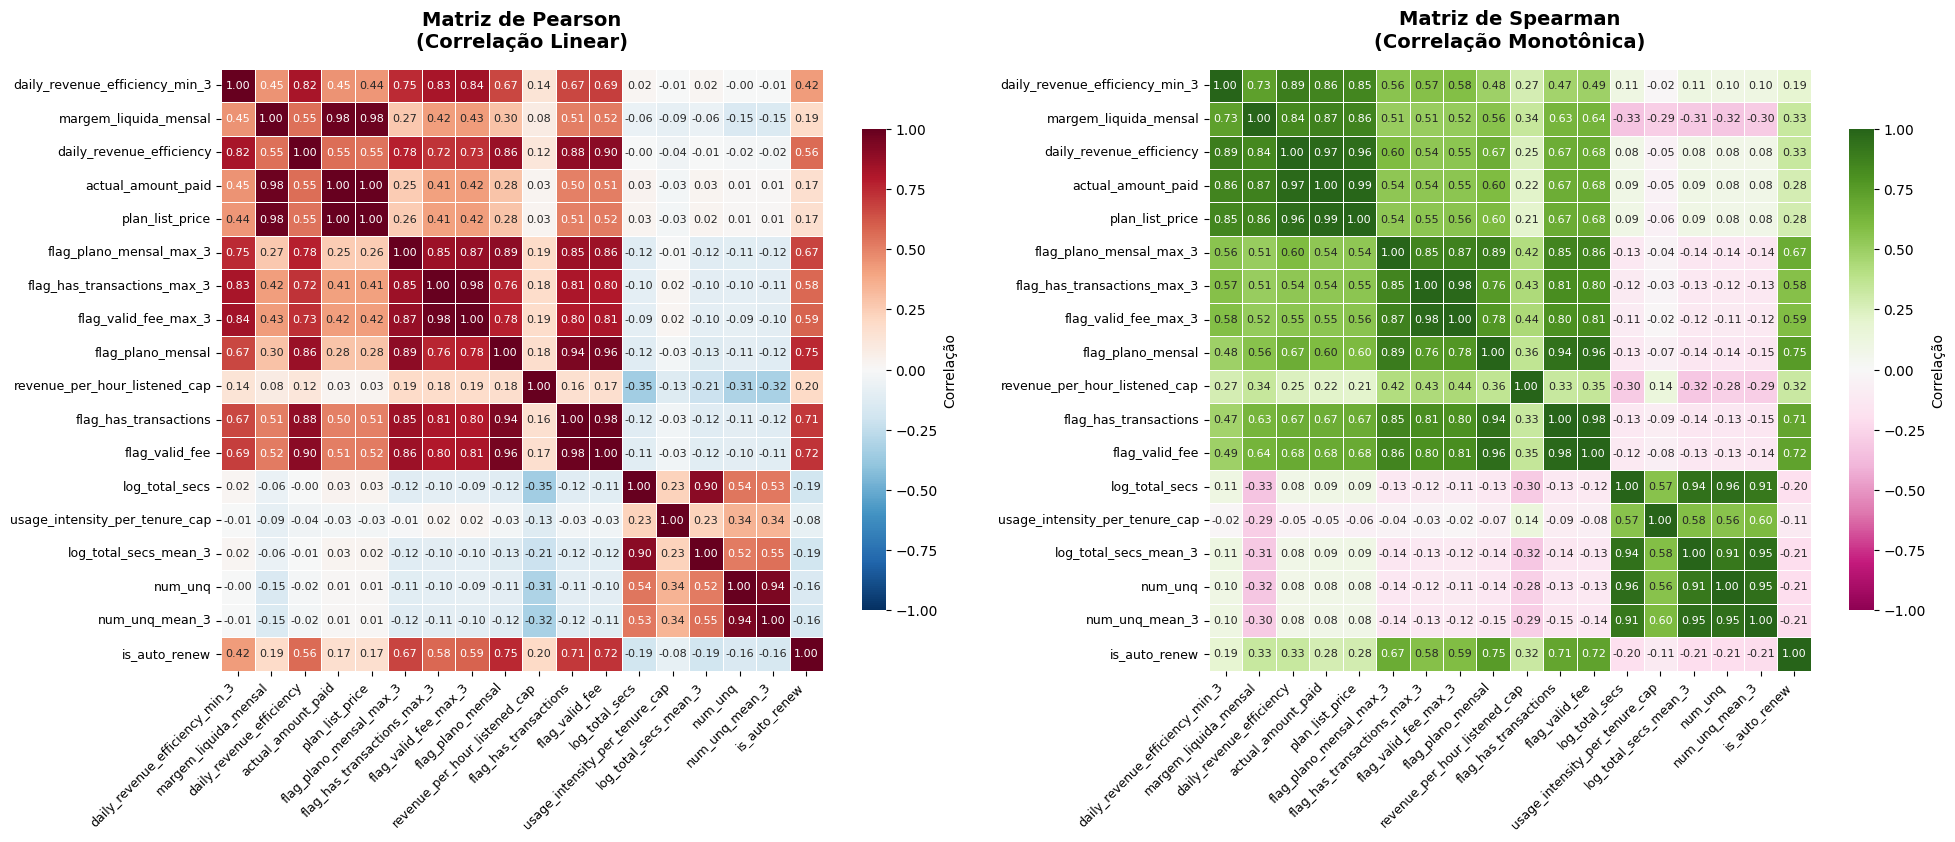


📊 Gerando visualização alternativa (triângulo superior)...



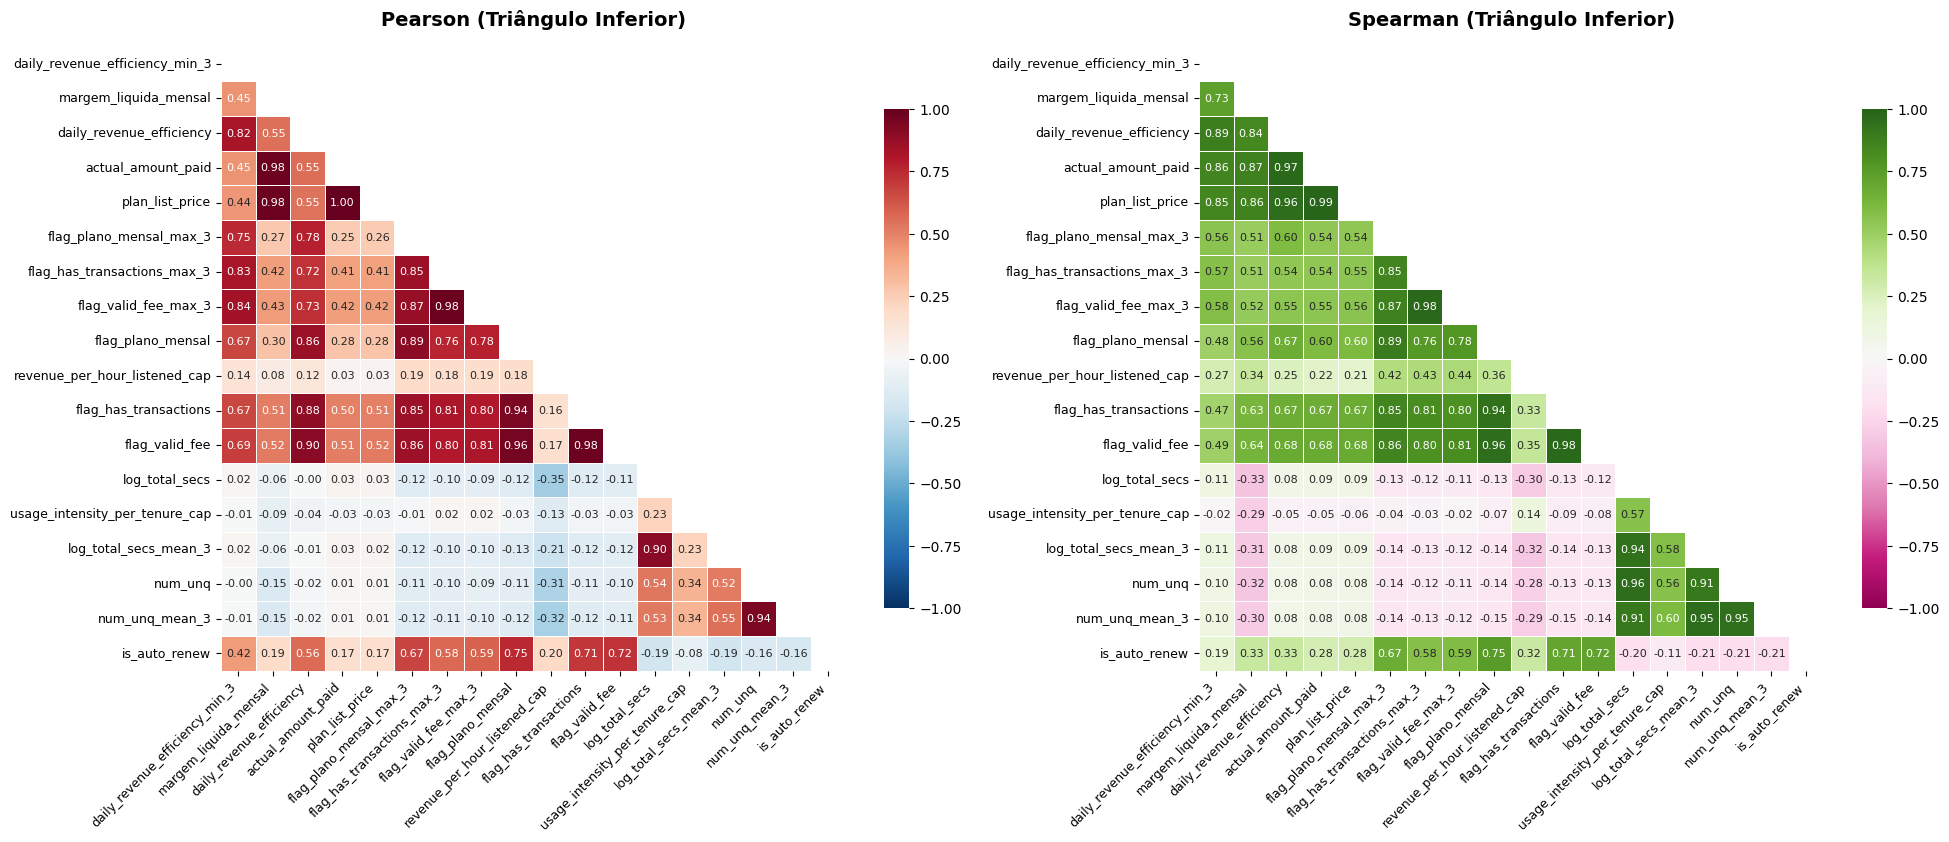

In [ ]:
matrix_p, matrix_s = correlation_matrix(
    df=df_elastic_net,
    colunas=features_numericas_elastic_iv,
    plot=True,
    top_n=25,  # Mostrar apenas top 25 features
    figsize=(20, 8)
)

##### Filtrando as de maior grau de correlação

⚠️  Limitando visualização aos top 30 pares (de 33 encontrados)

🔗 Encontrados 33 pares com |correlação| >= 0.7

                     feature_1                   feature_2  correlacao
            actual_amount_paid             plan_list_price    0.996171
         margem_liquida_mensal          actual_amount_paid    0.983961
   flag_has_transactions_max_3        flag_valid_fee_max_3    0.982648
         flag_has_transactions              flag_valid_fee    0.982549
         margem_liquida_mensal             plan_list_price    0.980513
             flag_plano_mensal              flag_valid_fee    0.955106
                       num_unq              num_unq_mean_3    0.943177
             flag_plano_mensal       flag_has_transactions    0.938725
                log_total_secs       log_total_secs_mean_3    0.903079
      daily_revenue_efficiency              flag_valid_fee    0.899789
       flag_plano_mensal_max_3           flag_plano_mensal    0.894631
      daily_revenue_efficiency     

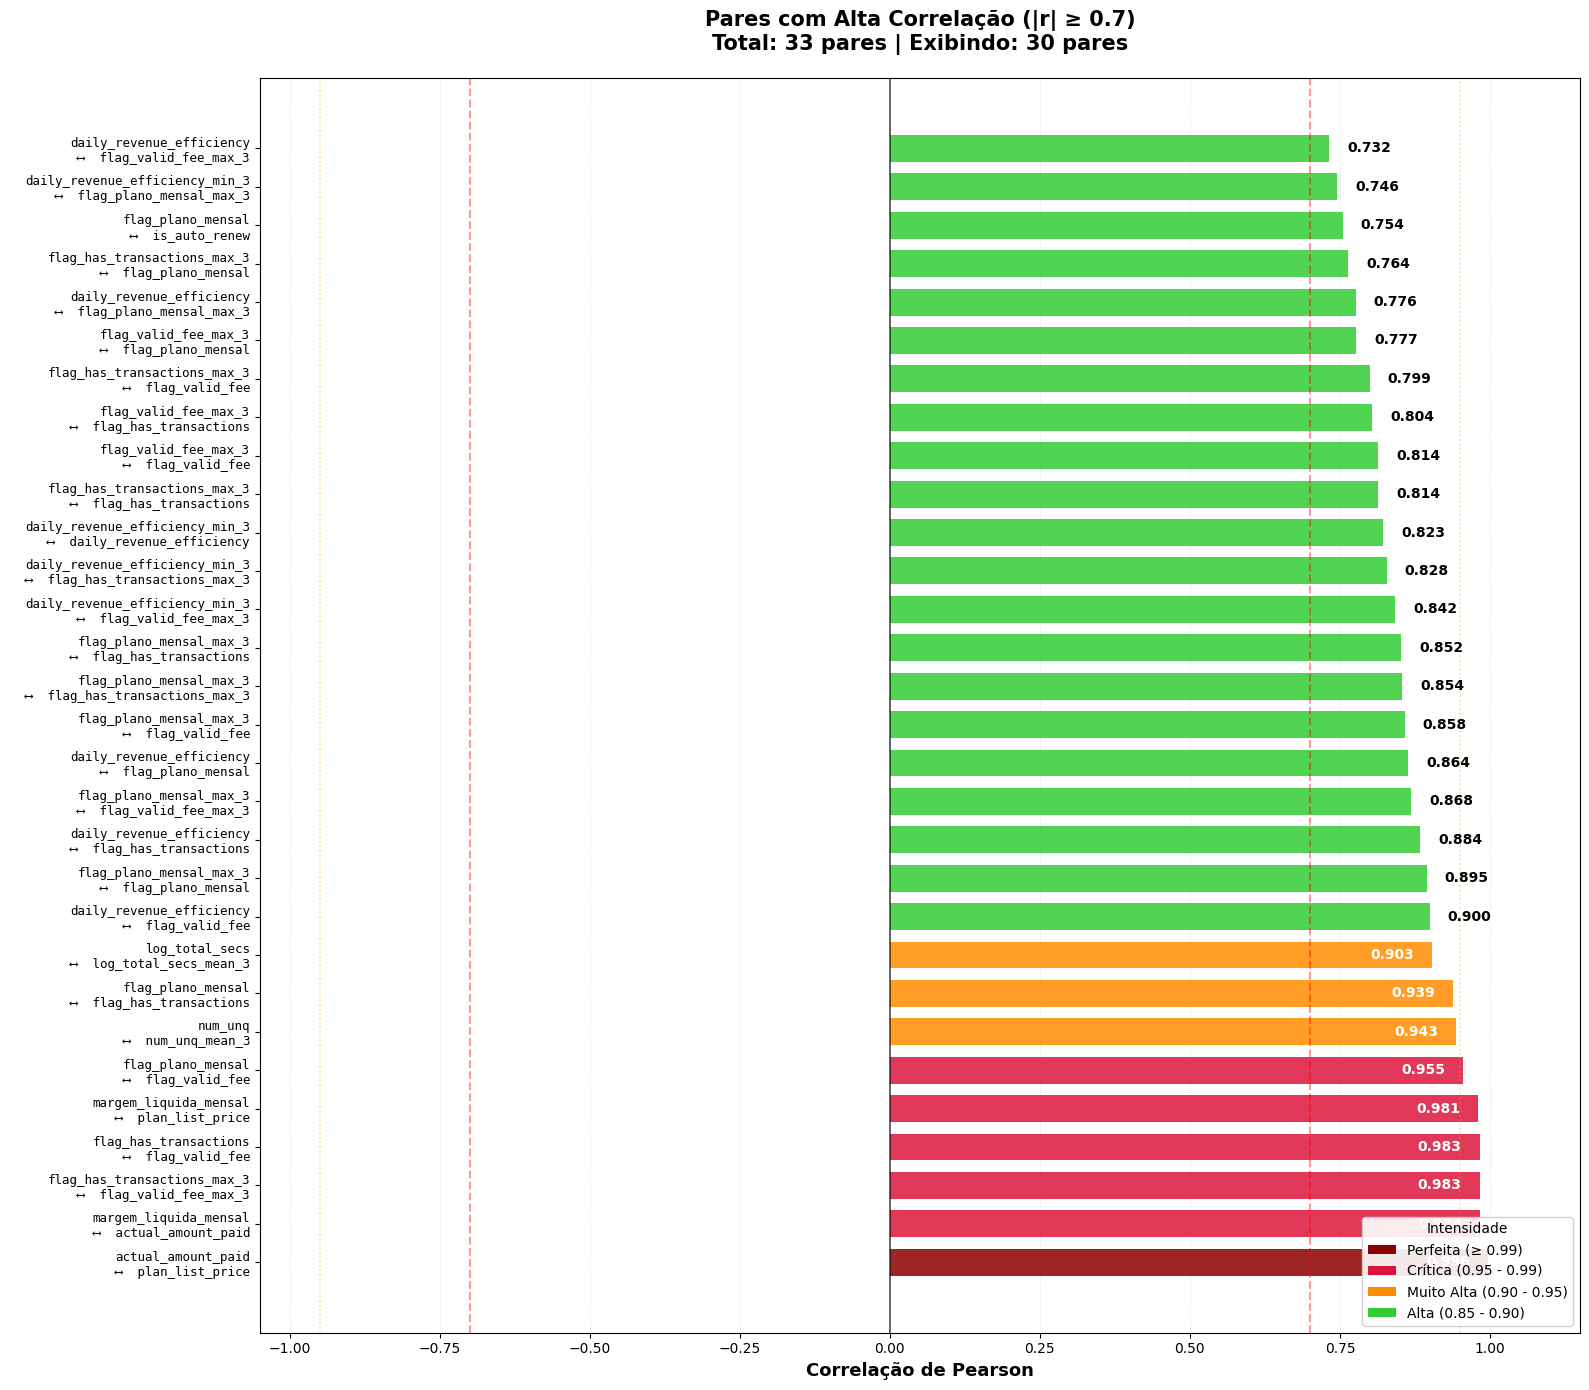


📊 RESUMO POR CATEGORIA DE CORRELAÇÃO

🔴 PERFEITA (≥ 0.99) (1 pares)
----------------------------------------------------------------------------------------------------
  • actual_amount_paid                              ⟷  plan_list_price                                  │  r = +0.9962

🟠 CRÍTICA (0.95 - 0.99) (5 pares)
----------------------------------------------------------------------------------------------------
  • margem_liquida_mensal                           ⟷  actual_amount_paid                               │  r = +0.9840
  • flag_has_transactions_max_3                     ⟷  flag_valid_fee_max_3                             │  r = +0.9826
  • flag_has_transactions                           ⟷  flag_valid_fee                                   │  r = +0.9825
  • margem_liquida_mensal                           ⟷  plan_list_price                                  │  r = +0.9805
  • flag_plano_mensal                               ⟷  flag_valid_fee                              

In [ ]:
plot_correlation_clusters(
    matrix_pearson=matrix_p,
    threshold=0.7,
    figsize=(16, 14)
)

##### Unindo IV e correlação para definir as variáveis numéricas finalistas

In [ ]:
def listar_pares_correlacionados_com_iv(
    matrix_corr: pd.DataFrame,
    iv_dict: dict,
    threshold: float = 0.85,
    top_n: int | None = None,
    sort_by: str = "abs_corr",   # "abs_corr" ou "corr"
    print_table: bool = True
) -> pd.DataFrame:
    """
    Lista pares (feature_i, feature_j) com |correlação| >= threshold,
    junto com IV de cada uma, para decisão manual.

    Params
    ------
    matrix_corr : pd.DataFrame
        Matriz de correlação (index/columns = features).
    iv_dict : dict
        Dict {feature: iv}.
    threshold : float
        Corte de correlação absoluta.
    top_n : int | None
        Se quiser limitar a N pares mais correlacionados.
    sort_by : str
        "abs_corr" (default) ou "corr".
    print_table : bool
        Se True, imprime a tabela formatada no output.

    Returns
    -------
    pd.DataFrame com colunas:
        feature_1, iv_1, feature_2, iv_2, corr, abs_corr, winner_por_iv
    """

    cols = list(matrix_corr.columns)
    rows = []
    n = len(cols)

    for i in range(n):
        for j in range(i + 1, n):
            f1, f2 = cols[i], cols[j]
            corr = float(matrix_corr.iloc[i, j])
            abs_corr = abs(corr)

            if abs_corr >= threshold:
                iv1 = float(iv_dict.get(f1, np.nan))
                iv2 = float(iv_dict.get(f2, np.nan))

                if np.isnan(iv1) and np.isnan(iv2):
                    winner = "empate(sem_iv)"
                elif np.isnan(iv1):
                    winner = f2
                elif np.isnan(iv2):
                    winner = f1
                else:
                    winner = f1 if iv1 >= iv2 else f2

                rows.append({
                    "feature_1": f1,
                    "iv_1": iv1,
                    "feature_2": f2,
                    "iv_2": iv2,
                    "corr": corr,
                    "abs_corr": abs_corr,
                    "winner_por_iv": winner
                })

    df_pairs = pd.DataFrame(rows)

    if df_pairs.empty:
        if print_table:
            print(f"Nenhum par com |corr| >= {threshold}")
        return df_pairs

    if sort_by == "corr":
        df_pairs = df_pairs.sort_values("corr", ascending=False)
    else:
        df_pairs = df_pairs.sort_values("abs_corr", ascending=False)

    if top_n is not None:
        df_pairs = df_pairs.head(top_n)

    if print_table:
        pd.set_option("display.max_colwidth", 80)
        pd.set_option("display.width", 180)
        pd.set_option("display.max_rows", 200)

        print(f"\nEncontrados {len(rows)} pares com |correlação| >= {threshold}")
        if top_n is not None:
            print(f"Exibindo top {len(df_pairs)} pares por {sort_by}\n")
        else:
            print()

        # impressão amigável
        show = df_pairs.copy()
        show["iv_1"] = show["iv_1"].map(lambda x: f"{x:.4f}" if pd.notna(x) else "NA")
        show["iv_2"] = show["iv_2"].map(lambda x: f"{x:.4f}" if pd.notna(x) else "NA")
        show["corr"] = show["corr"].map(lambda x: f"{x:+.4f}")
        show["abs_corr"] = show["abs_corr"].map(lambda x: f"{x:.4f}")

        print(show.to_string(index=False))

    return df_pairs

In [ ]:
# Criar dicionário de IV (você já tem isso)
iv_dict = {r['feature']: r['iv'] for r in iv_results_sorted}

df_pairs = listar_pares_correlacionados_com_iv(
    matrix_corr=matrix_p,
    iv_dict=iv_dict,
    threshold=0.70,
    sort_by="abs_corr", 
    print_table=True
)


Encontrados 33 pares com |correlação| >= 0.7

                     feature_1   iv_1                   feature_2   iv_2    corr abs_corr                  winner_por_iv
            actual_amount_paid 2.2007             plan_list_price 2.1951 +0.9962   0.9962             actual_amount_paid
         margem_liquida_mensal 3.5097          actual_amount_paid 2.2007 +0.9840   0.9840          margem_liquida_mensal
   flag_has_transactions_max_3 0.5142        flag_valid_fee_max_3 0.5007 +0.9826   0.9826    flag_has_transactions_max_3
         flag_has_transactions 0.3852              flag_valid_fee 0.3799 +0.9825   0.9825          flag_has_transactions
         margem_liquida_mensal 3.5097             plan_list_price 2.1951 +0.9805   0.9805          margem_liquida_mensal
             flag_plano_mensal 0.4555              flag_valid_fee 0.3799 +0.9551   0.9551              flag_plano_mensal
                       num_unq 0.1409              num_unq_mean_3 0.1401 +0.9432   0.9432                 

Nesta etapa, me vi num impasse. Arrisco dizer que cheguei no ponto crítico onde negócio e estatística se chocam, pois me pergunto: mesmo que correlacionadas, as features nao tem diferentes significados, agregando diferentes informacoes?

**O Dilema: Correlação Alta ≠ Informação Idêntica?**

Resposta Curta:
* Correlação = 1.00 → SIM, informação idêntica (matematicamente redundante - transformação linear exata);
* Correlação ≈ 0.89-0.93 → TALVEZ, depende do modelo e do contexto. Há alguma informação diferente, mas muito pouca.

Até pensei em analisar o VIF, mas como a correção é a base deste, já tenho a resposta necessária.

In [ ]:
# Unificando todas as decisões de limpeza
features_remover_elastic = [
    # --- Rodada 1: Redundância Temporal e Filtros Iniciais ---
    'log_total_secs_ratio_ref_max_6',           # r=1.00 com log_total_plays_ratio_ref_max_6
    'plays_per_unq_cap_min_6',                  # r=1.00 com completed_songs_rate_min_6
    'completion_efficiency_min_6',              # r=0.9257 com completed_songs_rate_min_6
    'daily_revenue_efficiency_ratio_ref_min_3', # r=1.00 com daily_revenue_efficiency_min_3, menor IV
    'avg_secs_per_unq_cap_min_6',               # r=0.95 com log_total_secs_mean_3, baixo IV.
    
    # --- Rodada 2: Redundância entre Cruas e Transformadas ---
    'log_total_secs',           # redundante com log_total_secs_mean_3: nao me parece viavel manter a variavel transformada + crua juntas
    'daily_revenue_efficiency', # redundante com daily_revenue_efficiency_min_3: nao me parece viavel manter a variavel transformada + crua juntas
    'flag_valid_fee',           # Redundante.
    'flag_plano_mensal',        # Redundante.
    'flag_has_transactions',    # Redundante, menor IV que max_3m

    # --- Rodada 3 (Atual): Refinamento pós-limpeza do Target ---
    'num_unq_mean_3',               # r=0.94 com num_unq + r=0.9998 com log_total_secs_mean_3
    'flag_valid_fee_max_3',         # r=0.86 com flag_plano_mensal_max_3
    'flag_has_transactions_max_3',  # r=0.85 com flag_plano_mensal_max_3
    'is_auto_renew',                # r=0.75 com flag_plano_mensal
    'margem_liquida_mensal',        # Removida por risco de LEAKAGE (mesmo sendo a winner de IV)
    'plan_list_price',              # Removida por alta correlacao com actual_amount_paid
]

In [ ]:
features_numericas_finais_elastic_net = [
    col for col in features_numericas_elastic_iv
    if col not in features_remover_elastic
]

In [ ]:
features_numericas_finais_elastic_net

['daily_revenue_efficiency_min_3',
 'actual_amount_paid',
 'flag_plano_mensal_max_3',
 'revenue_per_hour_listened_cap',
 'usage_intensity_per_tenure_cap',
 'log_total_secs_mean_3',
 'num_unq']

#### Conclusao: variáveis numéricas finalistas

In [ ]:
features_numericas_finais_elastic_net = [
    # Grupo 1: Eficiência de Receita (IV altíssimo)
    'daily_revenue_efficiency_min_3',    # IV = 3.9669
    'revenue_per_hour_listened_cap',     # IV = 0.4389
    # Grupo 2: Preço/Pagamento - margem_liquida_mensal sai porque é muito próxima de actual_amount_paid e 
    'actual_amount_paid',                # IV = 2.2007. Vai ser a unica a ser removida do modelo 2 por ser financeira
    # Grupo 3: Flags de Plano
    'flag_plano_mensal_max_3',           # IV = 0.7128
    # Grupo 4: Volume de Uso
    'log_total_secs_mean_3',             # IV = 0.1797
    'num_unq',                           # IV = 0.1409. Ao meu ver, melhor seria a versao transformada por questoes de performance, mas a correlacao com a feature acima se mostra alta
    # Grupo 5: Comportamento
    'usage_intensity_per_tenure_cap',     # IV = 0.1818
]

# Total: 7 features

### Variáveis categóricas

Vou remover as de data, pois nao desejo utilizar nenhuma delas para o modelo.

In [ ]:
# removendo as features de data
features_categoricas_base =  ['total_plays_group', 'completed_songs_rate_group', 'avg_secs_per_unq_cap_group', 'plays_per_unq_behavior', 'plays_behavior_vs_volume', 'plays_behavior_vs_volume_collapsed', 'plays_behavior_vs_completion', 'plays_behavior_vs_completion_collapsed', 'early_drop_rate_group', 'revenue_tier', 'payment_method_group', 'payment_price_regime', 'gender_clean', 'faixa_idade', 'registered_via_group', 'registration_year_regime', 'tenure_faixa', 'revenue_per_hour_tier', 'usage_intensity_tier',] # 'membership_expire_date', 'transaction_date', 'registration_init_time']

#### _Fast EDA_

In [ ]:
def eda_categorica_vs_target(df, col_categorica, col_target, top_n=15):
    """
    Analisa a relação entre uma variável categórica e a target contínua.
    
    Retorna:
    - Estatísticas descritivas por categoria
    - Boxplot
    - Contagem de observações
    
    ✅ CORRIGIDO: Lida com valores None/Null
    """
    print(f"\n{'='*60}")
    print(f"📊 EDA: {col_categorica} vs {col_target}")
    print(f"{'='*60}\n")
    
    # ═══════════════════════════════════════════════════════════
    # TRATAMENTO DE NULOS: Substituir None por string "NULL"
    # ═══════════════════════════════════════════════════════════
    df_clean = df.withColumn(
        col_categorica,
        F.when(F.col(col_categorica).isNull(), "NULL")
         .otherwise(F.col(col_categorica))
    )
    
    # Estatísticas por categoria
    stats = df_clean.groupBy(col_categorica).agg(
        F.count(col_target).alias('count'),
        F.mean(col_target).alias('mean_target'),
        F.stddev(col_target).alias('std_target'),
        F.min(col_target).alias('min_target'),
        F.max(col_target).alias('max_target'),
        F.expr(f'percentile({col_target}, 0.5)').alias('median_target')
    ).orderBy(F.desc('count'))
    
    # Converter para Pandas para visualização
    stats_pd = stats.limit(top_n).toPandas()
    
    # Calcular % de representatividade
    total_count = stats_pd['count'].sum()
    stats_pd['pct'] = (stats_pd['count'] / total_count * 100).round(2)
    
    print(stats_pd.to_string(index=False))
    
    # ═══════════════════════════════════════════════════════════
    # VISUALIZAÇÃO: Garantir que não há None nos labels
    # ═══════════════════════════════════════════════════════════
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Média da Target por Categoria
    ax1 = axes[0]
    stats_pd_sorted = stats_pd.sort_values('mean_target', ascending=False)
    
    # Converter coluna categórica para string (garantir compatibilidade)
    stats_pd_sorted[col_categorica] = stats_pd_sorted[col_categorica].astype(str)
    
    ax1.barh(stats_pd_sorted[col_categorica], stats_pd_sorted['mean_target'], color='steelblue')
    ax1.set_xlabel('Média da Target (Margem Líquida)', fontsize=12)
    ax1.set_ylabel(col_categorica, fontsize=12)
    ax1.set_title(f'Média da Target por Categoria\n({col_categorica})', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Adicionar linha vertical na média global
    mean_global = stats_pd['mean_target'].mean()
    ax1.axvline(mean_global, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Média Global: {mean_global:.2f}')
    ax1.legend(fontsize=9)
    
    # Gráfico 2: Distribuição (Count + %)
    ax2 = axes[1]
    stats_pd_sorted2 = stats_pd.sort_values('count', ascending=False)
    stats_pd_sorted2[col_categorica] = stats_pd_sorted2[col_categorica].astype(str)
    
    bars = ax2.barh(stats_pd_sorted2[col_categorica], stats_pd_sorted2['count'], color='coral')
    ax2.set_xlabel('Contagem de Observações', fontsize=12)
    ax2.set_ylabel(col_categorica, fontsize=12)
    ax2.set_title(f'Distribuição de Categorias\n({col_categorica})', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Adicionar % nas barras
    for i, (bar, pct) in enumerate(zip(bars, stats_pd_sorted2['pct'])):
        ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f' {pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ═══════════════════════════════════════════════════════════
    # ALERTA: Se houver muitos nulos
    # ═══════════════════════════════════════════════════════════
    null_count = stats_pd[stats_pd[col_categorica] == 'NULL']['count'].sum() if 'NULL' in stats_pd[col_categorica].values else 0
    if null_count > 0:
        null_pct = (null_count / total_count * 100)
        print(f"\n⚠️  ALERTA: {null_count:,} valores nulos ({null_pct:.2f}%) encontrados em '{col_categorica}'")
        print(f"   └─ Considere investigar a origem desses nulos antes de prosseguir.\n")
    
    return stats_pd


📊 EDA: total_plays_group vs target_win

   total_plays_group   count  mean_target  std_target  min_target  max_target  median_target   pct
       04_power_user 2214194    22.649434   65.623760 -108.814722  129.040129      45.684171 22.88
03_frequent_listener 2211467    44.059868   61.265676 -108.814722  129.040129      73.308200 22.85
 02_regular_listener 2188248    52.073247   57.695854 -108.814722  129.040129      78.858968 22.61
  01_casual_listener 2077597    56.666605   51.078418 -108.814722  129.040129      49.000000 21.47
          00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.20


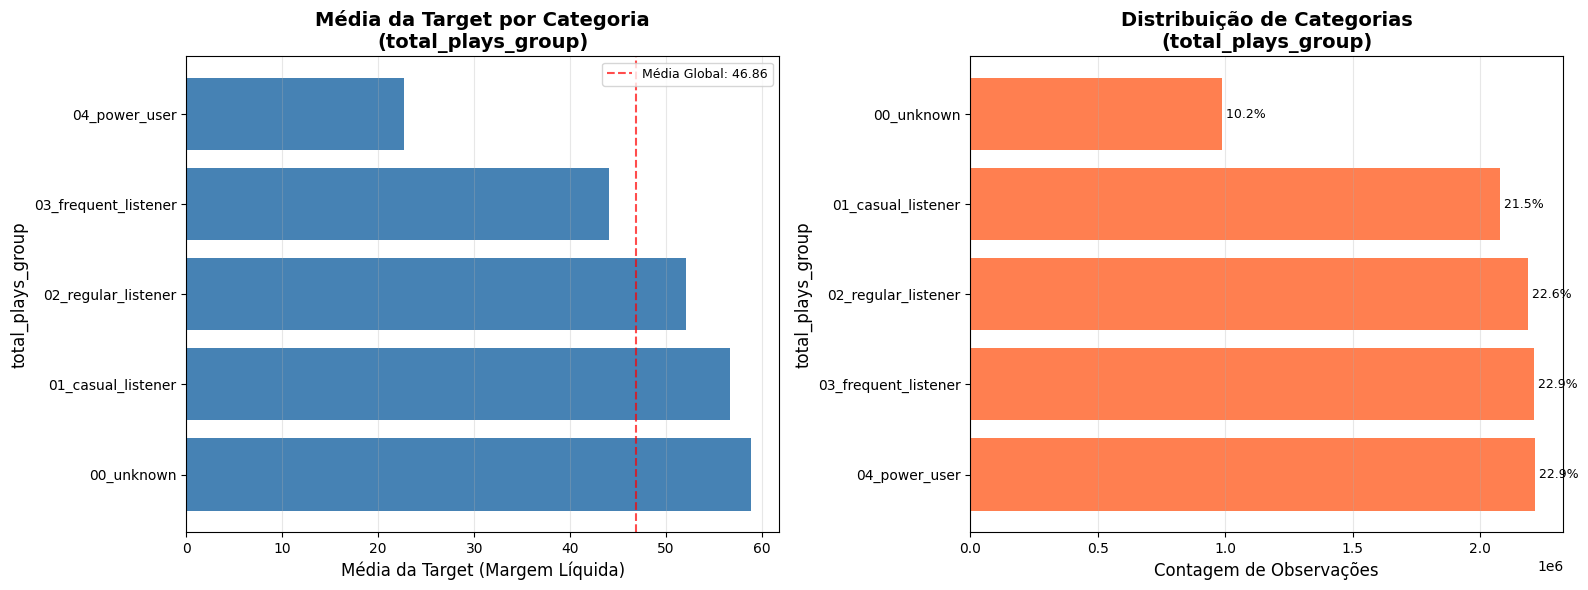


📊 EDA: completed_songs_rate_group vs target_win

completed_songs_rate_group   count  mean_target  std_target  min_target  max_target  median_target   pct
       03_engaged_listener 2192471    42.835205   61.348731 -108.814722  129.040129      65.222199 22.65
          04_completionist 2188834    36.287221   63.234345 -108.814722  129.040129      49.000000 22.61
      02_skipping_listener 2186604    45.511808   60.461014 -108.814722  129.040129      68.906269 22.59
                01_bouncer 2123597    50.107804   56.635216 -108.814722  129.040129      67.841230 21.94
                00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.20


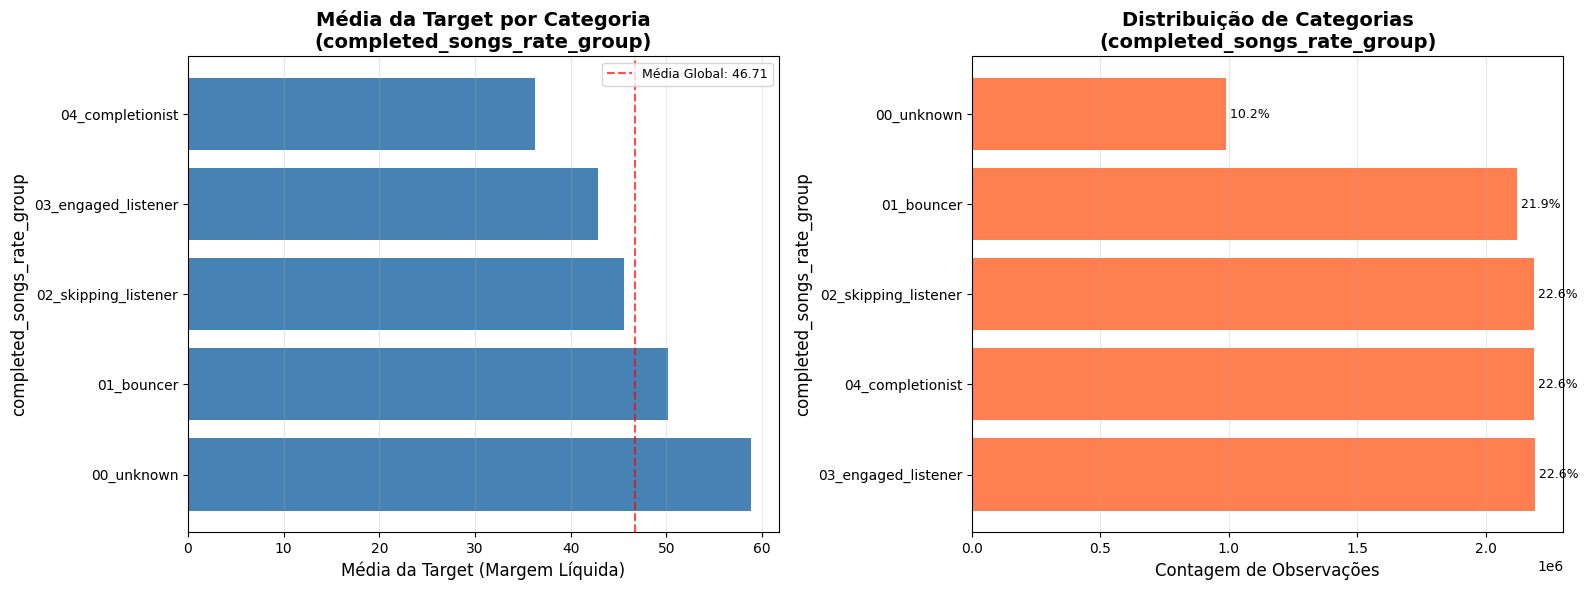


📊 EDA: avg_secs_per_unq_cap_group vs target_win

avg_secs_per_unq_cap_group   count  mean_target  std_target  min_target  max_target  median_target   pct
                02_sampler 2187475    45.511618   60.276876 -108.814722  129.040129      68.241128 22.60
       03_focused_listener 2186251    42.037852   61.504367 -108.814722  129.040129      62.963413 22.59
          04_deep_listener 2181201    37.848713   62.870996 -108.814722  129.040129      55.322553 22.54
                01_skimmer 2136579    49.261111   57.366796 -108.814722  129.040129      67.478841 22.07
                00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.20


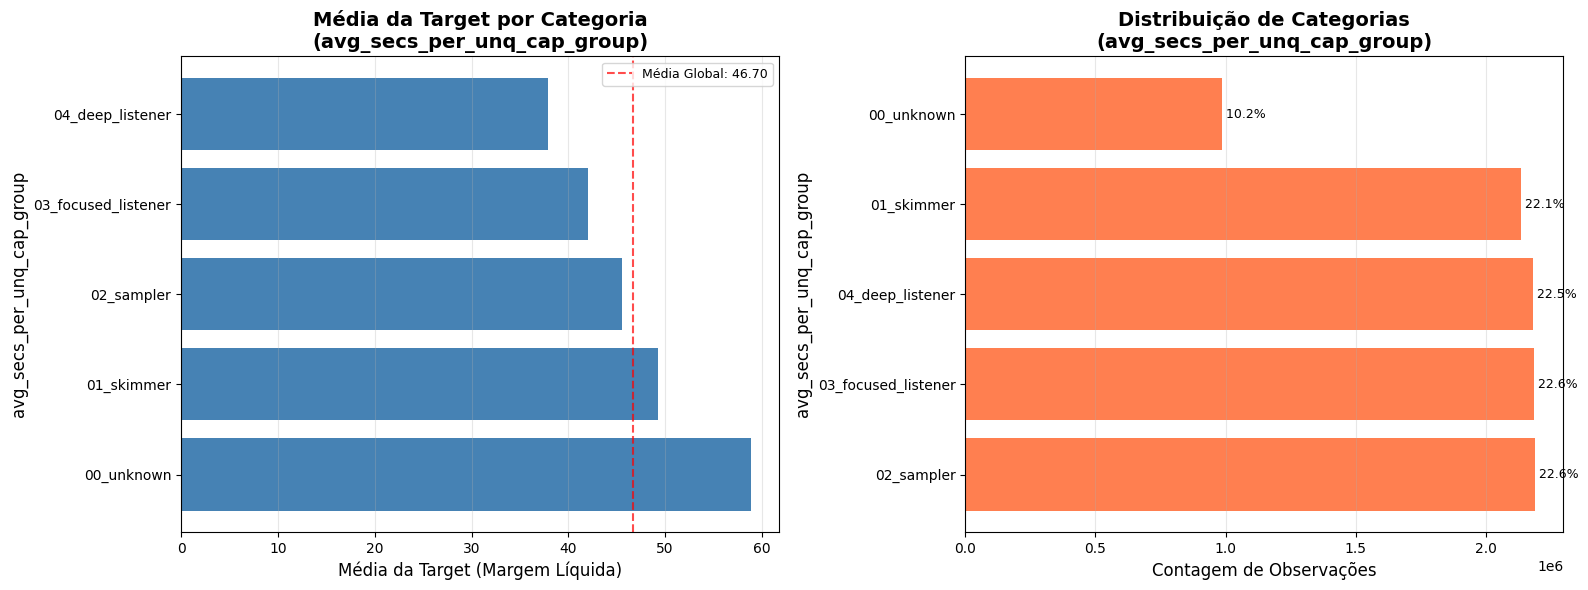


📊 EDA: plays_per_unq_behavior vs target_win

plays_per_unq_behavior   count  mean_target  std_target  min_target  max_target  median_target   pct
           01_explorer 6544782    45.706786   59.923308 -108.814722  129.040129      66.935341 67.62
       02_light_repeat 1290959    34.989446   64.042848 -108.814722  129.040129      51.568952 13.34
            00_unknown 1087138    58.312887   43.063488 -108.814722  129.040129      49.000000 11.23
             03_repeat  580333    38.712135   62.184250 -108.814722  129.040129      55.642538  6.00
       04_heavy_repeat  175654    40.871953   60.680830 -108.814722  129.040129      57.476737  1.81


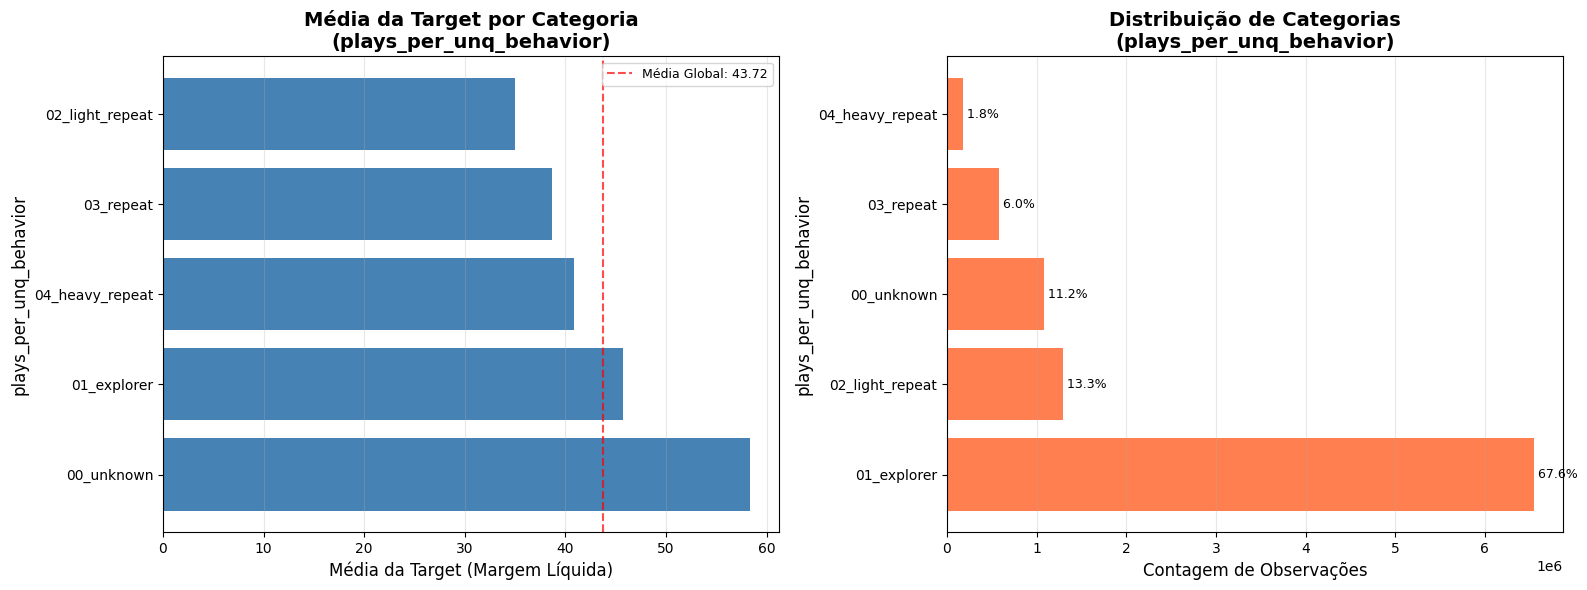


📊 EDA: plays_behavior_vs_volume vs target_win

            plays_behavior_vs_volume   count  mean_target  std_target  min_target  max_target  median_target   pct
     01_explorer_02_regular_listener 1775012    51.670103   57.956447 -108.814722  129.040129      78.478642 18.53
      01_explorer_01_casual_listener 1709157    56.446838   51.341745 -108.814722  129.040129      49.000000 17.85
    01_explorer_03_frequent_listener 1696289    43.731475   61.690524 -108.814722  129.040129      73.658197 17.71
           01_explorer_04_power_user 1364324    26.949735   65.375521 -108.814722  129.040129      53.583570 14.24
               00_unknown_00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.31
       02_light_repeat_04_power_user  534778    13.626391   65.951644 -108.814722  129.040129      30.021309  5.58
02_light_repeat_03_frequent_listener  342294    44.198618   60.459044 -108.814722  129.040129      72.060760  3.57
 02_light_repeat_02_regular_list

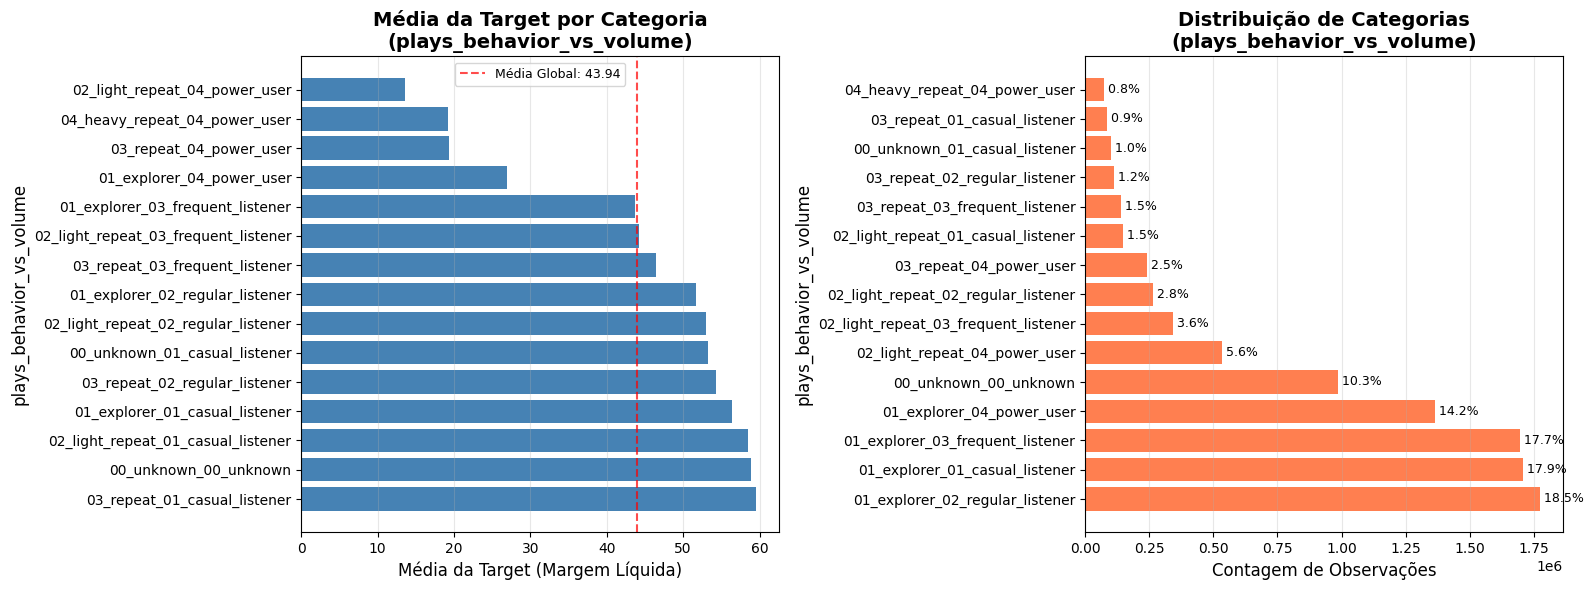


📊 EDA: plays_behavior_vs_volume_collapsed vs target_win

  plays_behavior_vs_volume_collapsed   count  mean_target  std_target  min_target  max_target  median_target   pct
     01_explorer_02_regular_listener 1775012    51.670103   57.956447 -108.814722  129.040129      78.478642 18.34
      01_explorer_01_casual_listener 1709157    56.446838   51.341745 -108.814722  129.040129      49.000000 17.66
    01_explorer_03_frequent_listener 1696289    43.731475   61.690524 -108.814722  129.040129      73.658197 17.53
           01_explorer_04_power_user 1364324    26.949735   65.375521 -108.814722  129.040129      53.583570 14.10
               00_unknown_00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.20
       02_light_repeat_04_power_user  534778    13.626391   65.951644 -108.814722  129.040129      30.021309  5.53
02_light_repeat_03_frequent_listener  342294    44.198618   60.459044 -108.814722  129.040129      72.060760  3.54
 02_light_repeat_02_re

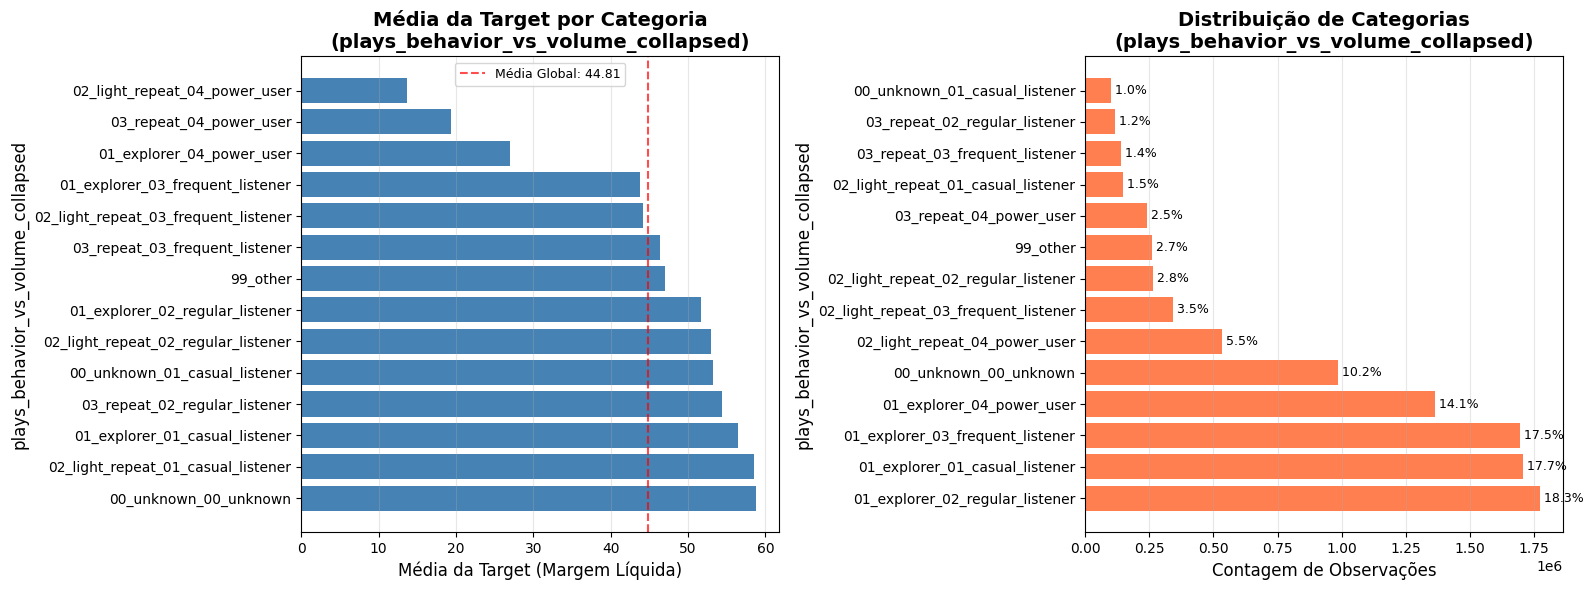


📊 EDA: plays_behavior_vs_completion vs target_win

        plays_behavior_vs_completion   count  mean_target  std_target  min_target  max_target  median_target   pct
              01_explorer_01_bouncer 1994729    49.921671   57.237589 -108.814722  129.040129      69.827231 20.63
    01_explorer_02_skipping_listener 1921243    45.211354   60.724481 -108.814722  129.040129      68.916562 19.87
     01_explorer_03_engaged_listener 1556095    43.203249   61.350277 -108.814722  129.040129      65.899891 16.09
        01_explorer_04_completionist 1072715    42.388138   60.812811 -108.814722  129.040129      58.265705 11.09
               00_unknown_00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.21
    02_light_repeat_04_completionist  664744    27.894674   65.784990 -108.814722  129.040129      45.332675  6.87
 02_light_repeat_03_engaged_listener  418236    40.190398   62.250216 -108.814722  129.040129      62.625845  4.33
          03_repeat_04_compl

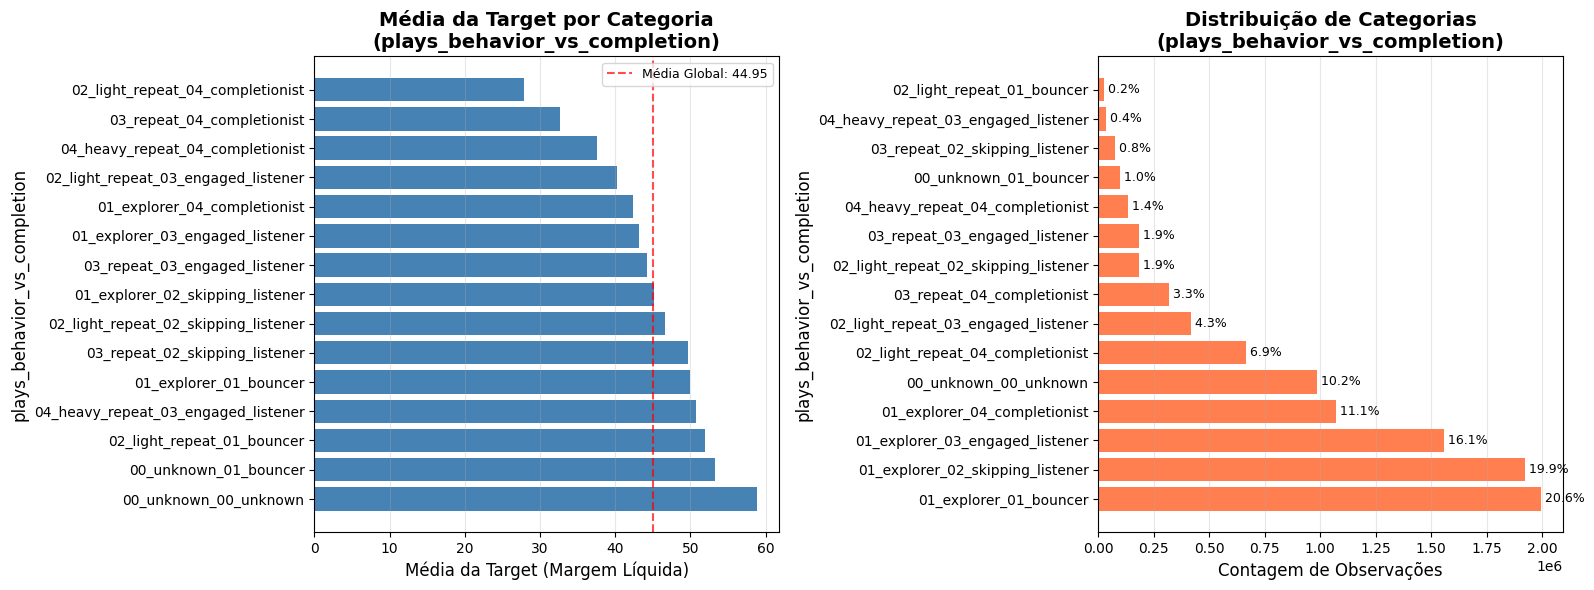


📊 EDA: plays_behavior_vs_completion_collapsed vs target_win

plays_behavior_vs_completion_collapsed   count  mean_target  std_target  min_target  max_target  median_target   pct
                01_explorer_01_bouncer 1994729    49.921671   57.237589 -108.814722  129.040129      69.827231 20.61
      01_explorer_02_skipping_listener 1921243    45.211354   60.724481 -108.814722  129.040129      68.916562 19.85
       01_explorer_03_engaged_listener 1556095    43.203249   61.350277 -108.814722  129.040129      65.899891 16.08
          01_explorer_04_completionist 1072715    42.388138   60.812811 -108.814722  129.040129      58.265705 11.08
                 00_unknown_00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.20
      02_light_repeat_04_completionist  664744    27.894674   65.784990 -108.814722  129.040129      45.332675  6.87
   02_light_repeat_03_engaged_listener  418236    40.190398   62.250216 -108.814722  129.040129      62.625845  4.32
  

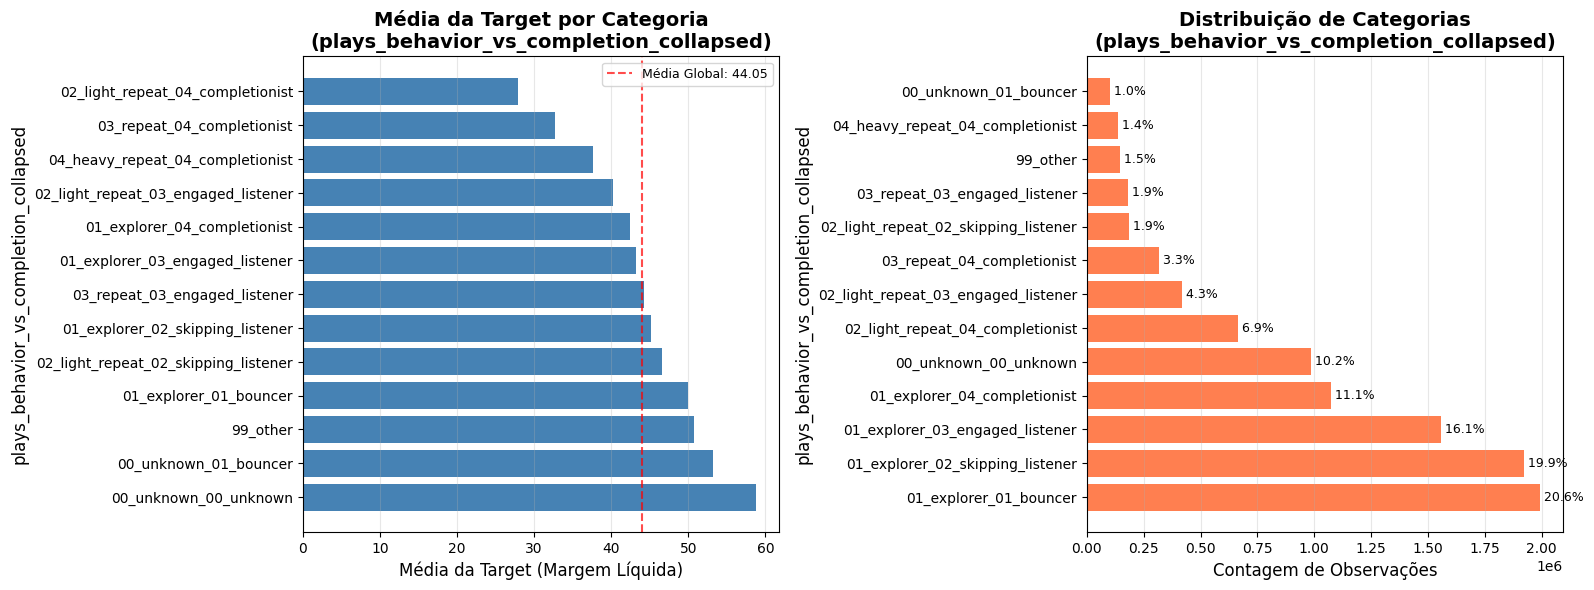


📊 EDA: early_drop_rate_group vs target_win

early_drop_rate_group   count  mean_target  std_target  min_target  max_target  median_target   pct
           02_engaged 4149304    39.303635   62.492671 -108.814722  129.040129      57.959814 42.87
          03_explorer 3651998    46.389507   59.869760 -108.814722  129.040129      69.074944 37.73
           00_unknown  987360    58.827143   42.982657 -108.814722  129.040129      49.000000 10.20
    04_skipping_heavy  772568    51.689520   53.995474 -108.814722  129.040129      49.000000  7.98
     01_completionist  117636    58.110992   50.298074 -108.814722  129.040129      52.752907  1.22


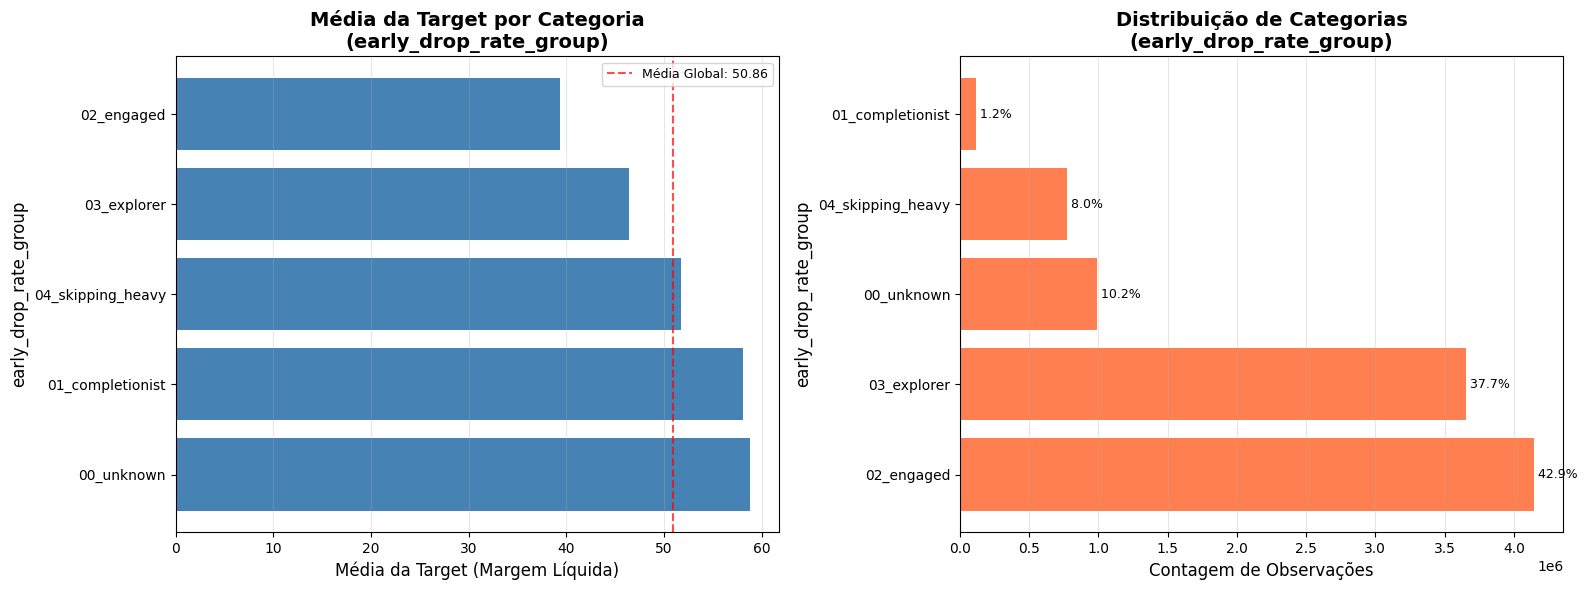


📊 EDA: revenue_tier vs target_win

   revenue_tier   count  mean_target  std_target  min_target  max_target  median_target   pct
 04_premium_149 4706207    71.374168   44.057921 -108.814722  129.040129      87.454274 48.62
 03_standard_99 2432782    38.430968   18.703246 -108.814722  129.040129      45.180604 25.13
     00_unknown 1539830   -36.602484   66.381098 -108.814722  129.040129     -58.888950 15.91
      06_others  513240    57.014188   37.284272 -108.814722  129.040129      69.417207  5.30
   05_high_tier  383348    92.367094   55.842101 -108.814722  129.040129     114.574644  3.96
01_free_isencao   81869    13.875213   73.444836 -108.814722  129.040129     -50.000000  0.85
    02_low_tier   21590   -69.037861   16.118064 -108.814722  119.149782     -64.322614  0.22


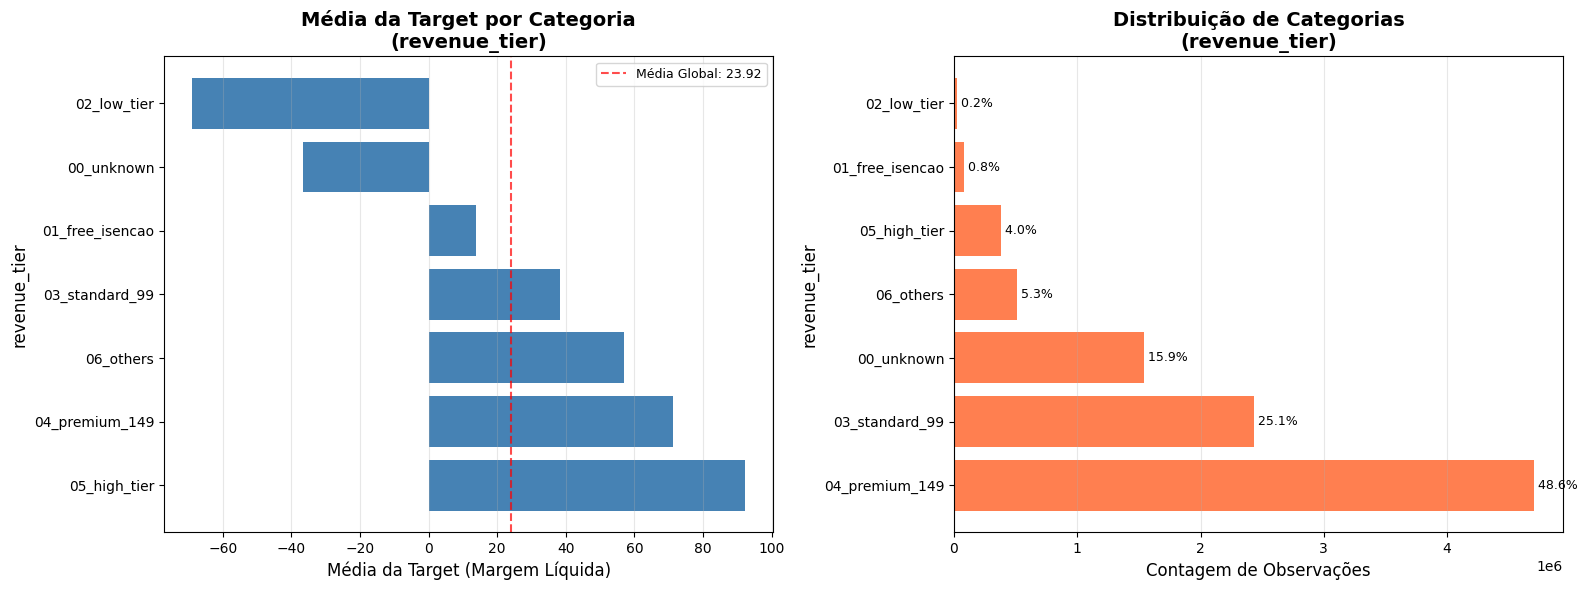


📊 EDA: payment_method_group vs target_win

payment_method_group   count  mean_target  std_target  min_target  max_target  median_target   pct
        01_most_auto 6844271    62.608463   34.178035 -108.814722  129.040129      69.387275 70.71
   00_no_transaction 1539830   -36.602484   66.381098 -108.814722  129.040129     -58.888950 15.91
      03_most_manual  878995    31.901197   72.472618 -108.814722  129.040129      70.843119  9.08
            02_mixed  415770    89.380244   56.165329 -108.814722  129.040129     111.900490  4.30


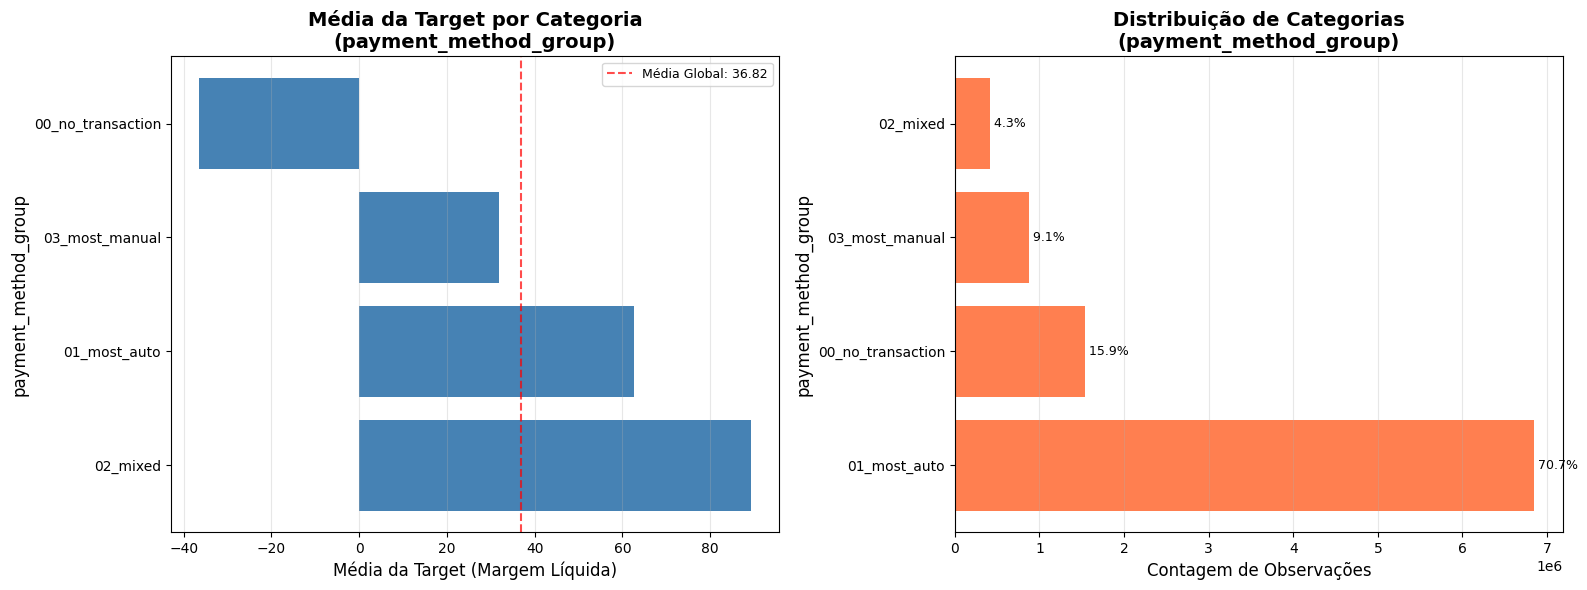


📊 EDA: payment_price_regime vs target_win

payment_price_regime   count  mean_target  std_target  min_target  max_target  median_target   pct
 01_paid_as_expected 8055731    61.136713   42.272164 -108.814722  129.040129      72.162513 83.23
   00_no_transaction 1539830   -36.602484   66.381098 -108.814722  129.040129     -58.888950 15.91
02_irregular_payment   83305    14.536757   73.099428 -108.814722  129.040129     -24.808220  0.86


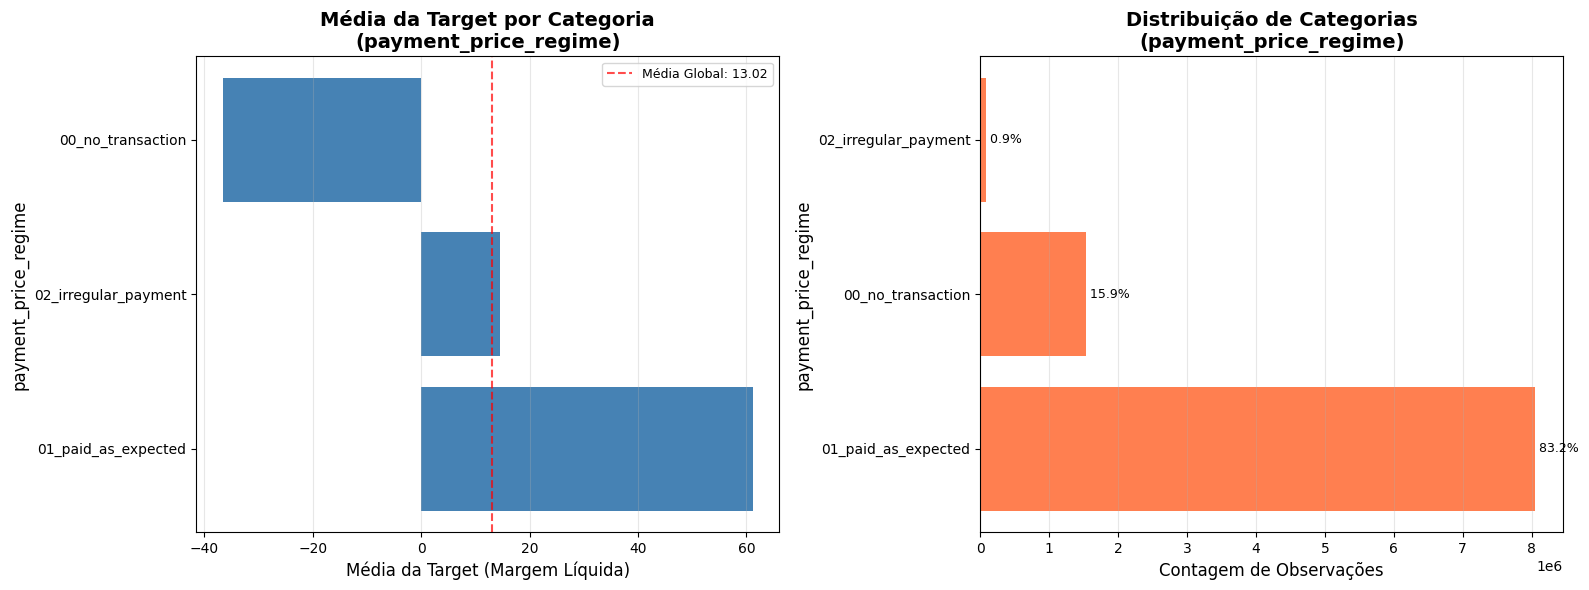


📊 EDA: gender_clean vs target_win

gender_clean   count  mean_target  std_target  min_target  max_target  median_target   pct
     unknown 4662342    50.753644   44.695175 -108.814722  129.040129      49.000000 48.17
        male 2632298    40.845894   69.180724 -108.814722  129.040129      75.854825 27.20
      female 2384226    39.090627   70.526598 -108.814722  129.040129      75.599487 24.63


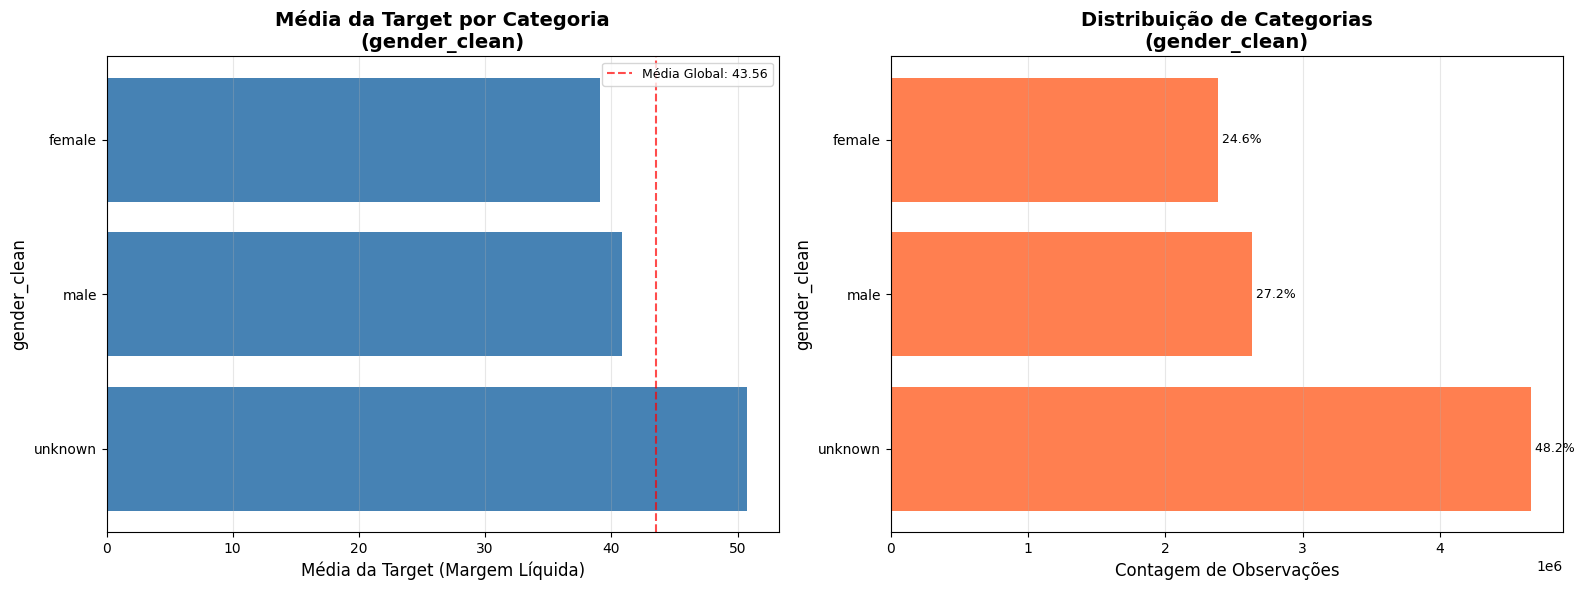


📊 EDA: faixa_idade vs target_win

 faixa_idade   count  mean_target  std_target  min_target  max_target  median_target   pct
Desconhecido 4675988    51.312016   44.079997 -108.814722  129.040129      49.000000 48.31
       23-34 2789382    40.771135   69.457916 -108.814722  129.040129      75.979898 28.82
       35-52 1154914    43.648977   68.870378 -108.814722  129.040129      80.253194 11.93
       16-22  943101    29.031338   73.333313 -108.814722  129.040129      66.449224  9.74
         53+  115481    51.085116   64.373466 -108.814722  129.040129      84.069023  1.19


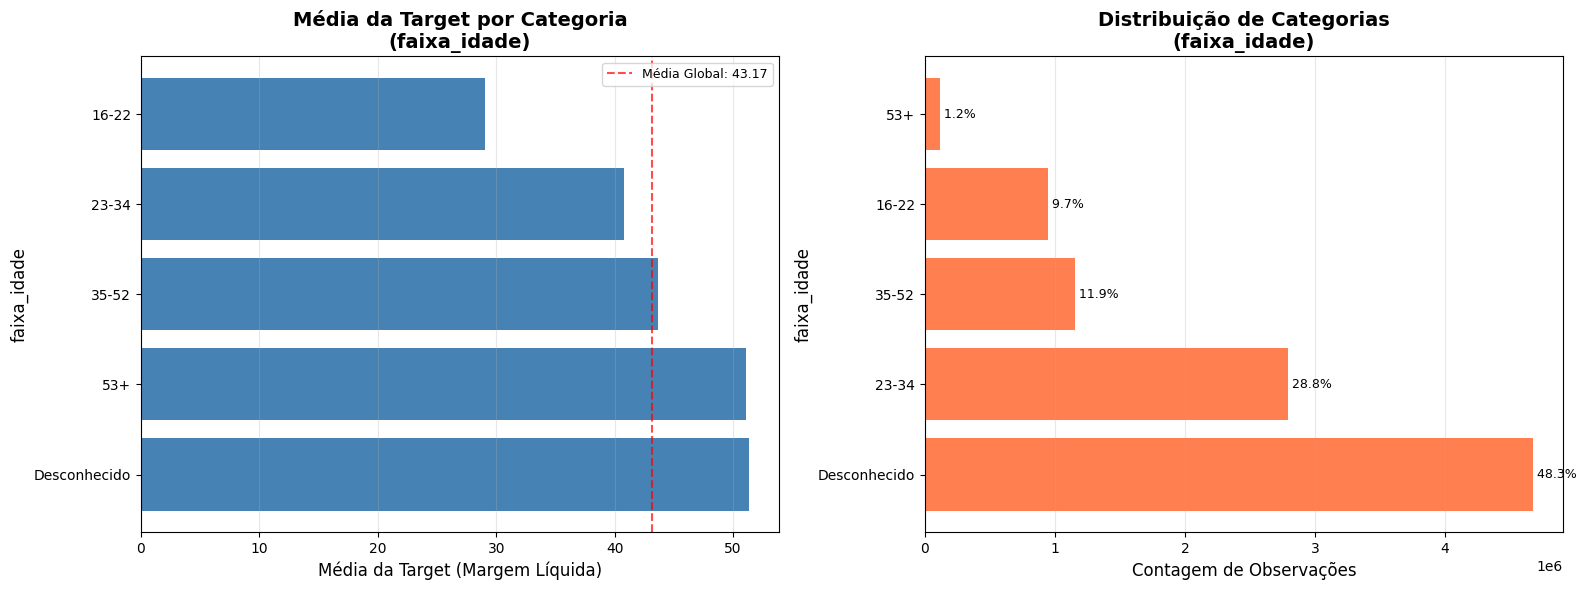


📊 EDA: registered_via_group vs target_win

registered_via_group   count  mean_target  std_target  min_target  max_target  median_target   pct
           low_value 4629512    53.870705   35.091996 -108.814722  129.040129      49.000000 47.83
          high_value 4623581    37.476211   73.716573 -108.814722  129.040129      78.421958 47.77
           mid_value  421548    34.237129   77.716384 -108.814722  129.040129      76.036742  4.36
               other    4225    58.777480   38.153430 -108.814722  129.040129      70.998755  0.04


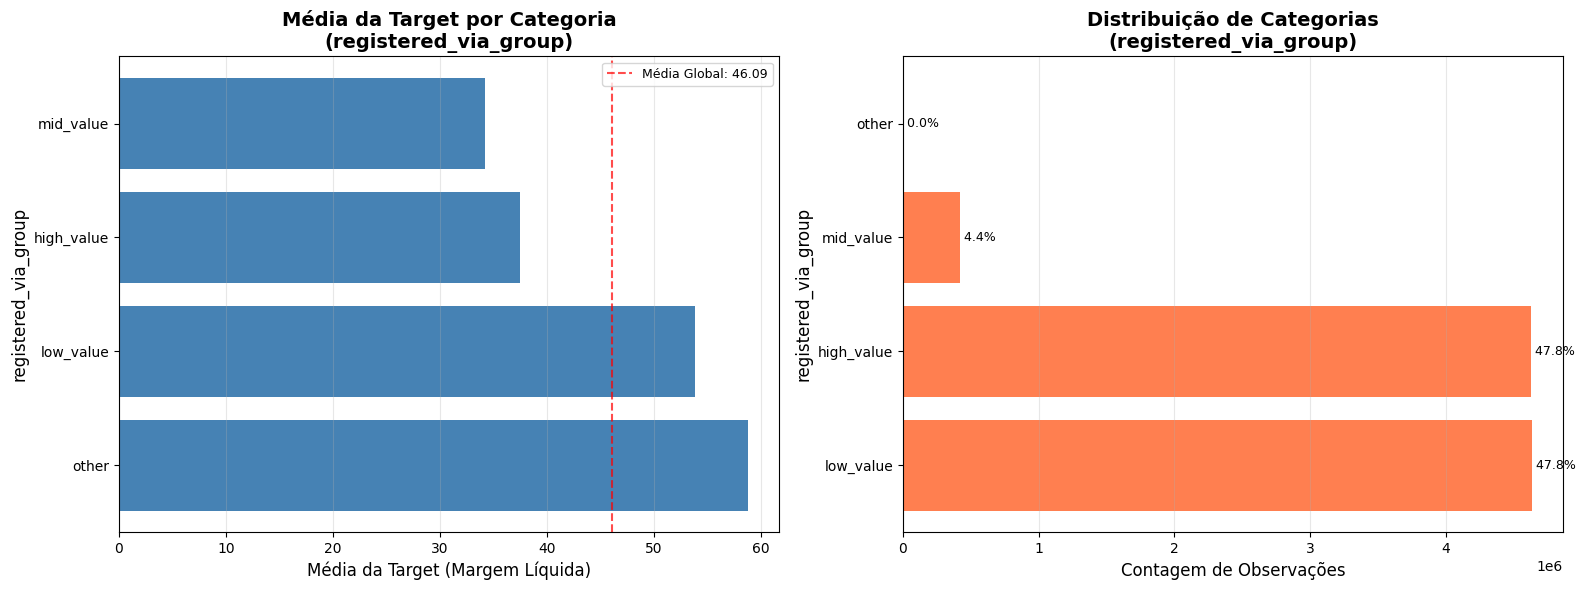


📊 EDA: registration_year_regime vs target_win

registration_year_regime   count  mean_target  std_target  min_target  max_target  median_target   pct
               2010-2014 4852845    47.346335   61.395479 -108.814722  129.040129      73.451527 50.14
                   2015+ 3507161    40.560109   52.501639 -108.814722  129.040129      48.452002 36.24
               2004-2009 1318860    49.539029   67.288542 -108.814722  129.040129      83.911101 13.63


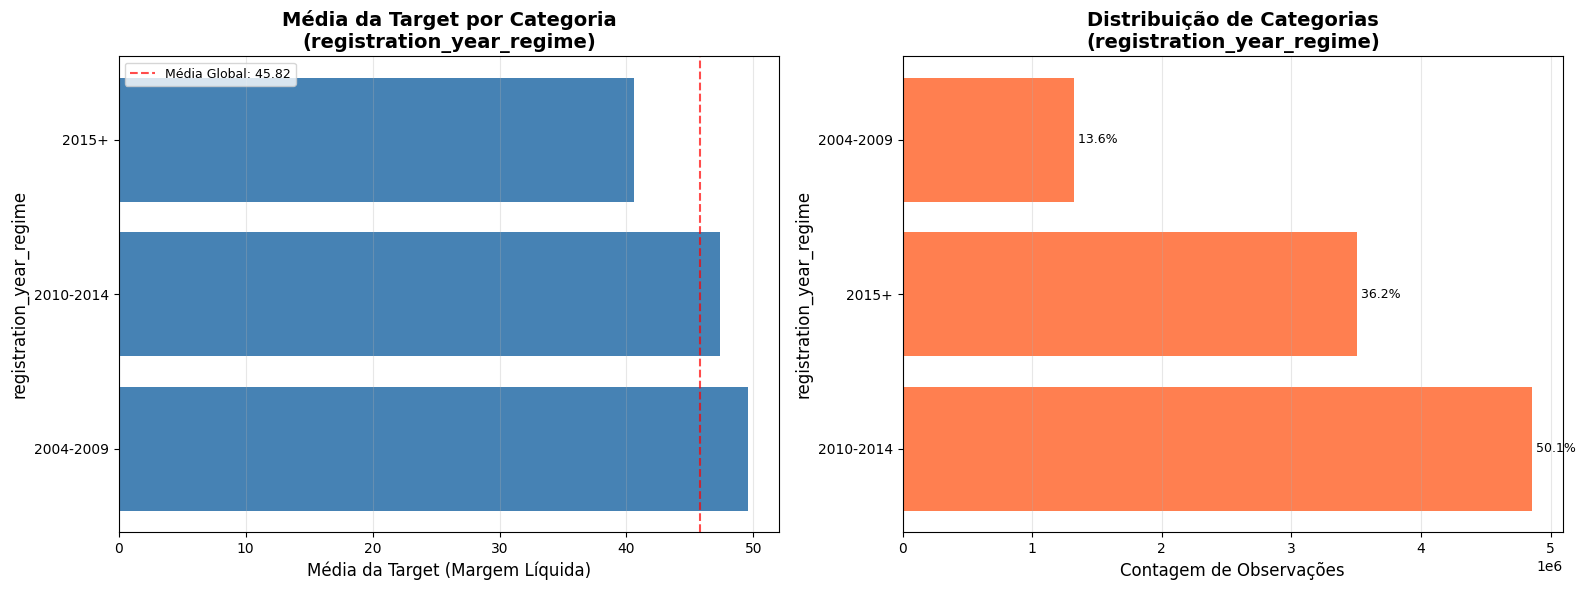


📊 EDA: tenure_faixa vs target_win

  tenure_faixa   count  mean_target  std_target  min_target  max_target  median_target   pct
  03_36+months 4136820    49.633583   62.650379 -108.814722  129.040129      78.164351 42.74
 01_0-11months 2944630    39.252391   51.105446 -108.814722  129.040129      47.999871 30.42
02_12-35months 2597416    44.829683   61.861407 -108.814722  129.040129      68.228788 26.84


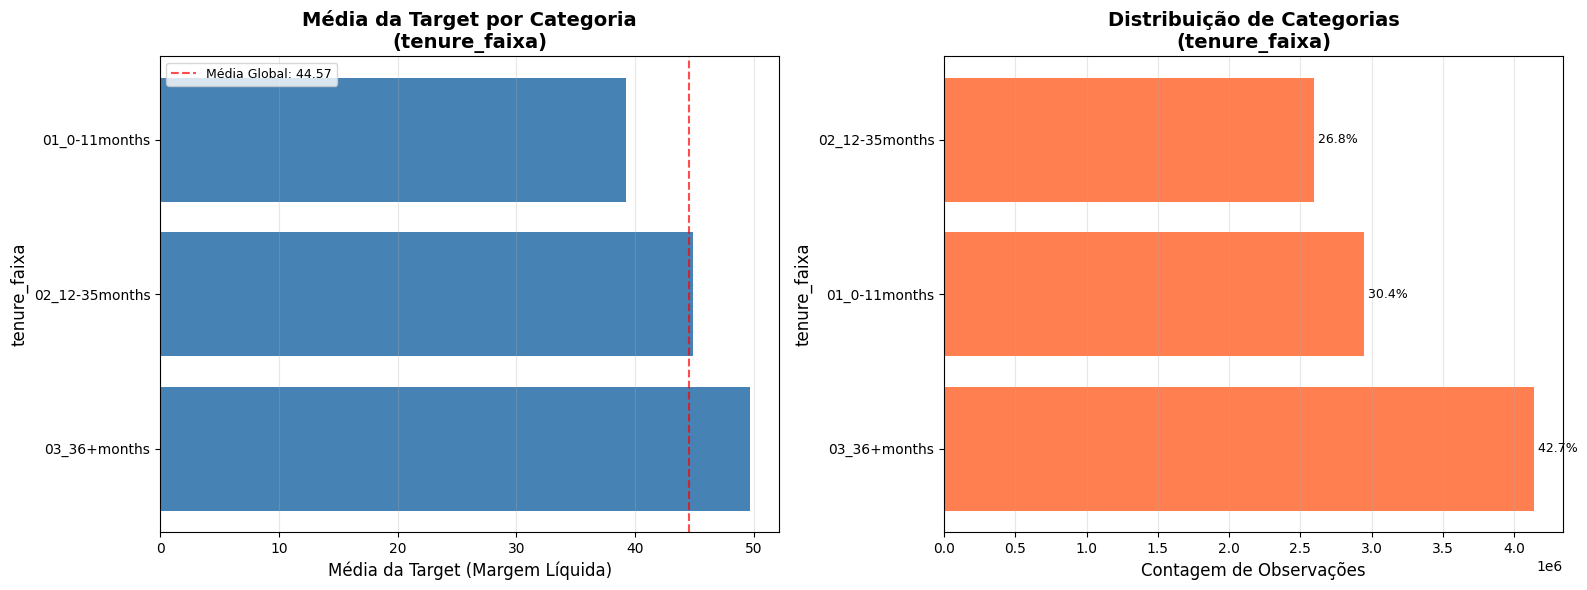


📊 EDA: revenue_per_hour_tier vs target_win

revenue_per_hour_tier   count  mean_target  std_target  min_target  max_target  median_target   pct
           00_unknown 2934889    10.664856   73.457526 -108.814722  129.040129      43.388999 30.32
            02_medium 2564579    64.819217   42.458673 -108.814722  129.040129      80.578838 26.50
              03_high 2315866    71.319905   37.745342 -108.814722  129.040129      89.416298 23.93
               01_low 1863532    40.057688   47.346873 -108.814722  129.040129      49.889469 19.25


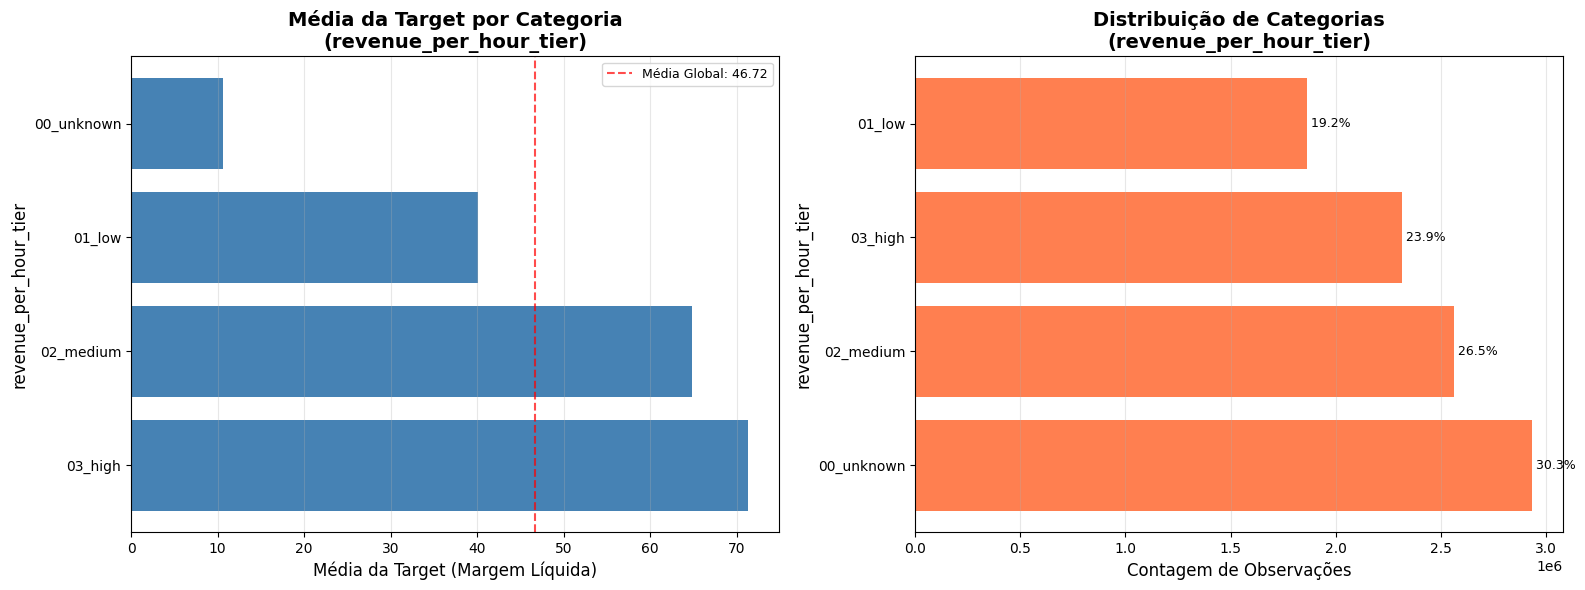


📊 EDA: usage_intensity_tier vs target_win

  usage_intensity_tier   count  mean_target  std_target  min_target  max_target  median_target   pct
         04_power_user 1960669    29.096961   60.768515 -108.814722  129.040129      41.998502 20.26
    03_high_engagement 1940098    40.176624   60.179864 -108.814722  129.040129      56.624453 20.04
02_moderate_engagement 1939229    51.497709   57.560936 -108.814722  129.040129      75.255844 20.04
     01_low_engagement 1923930    62.986365   51.993725 -108.814722  129.040129      88.789395 19.88
            00_unknown 1914940    42.459290   60.042287 -108.814722  129.040129      49.000000 19.78


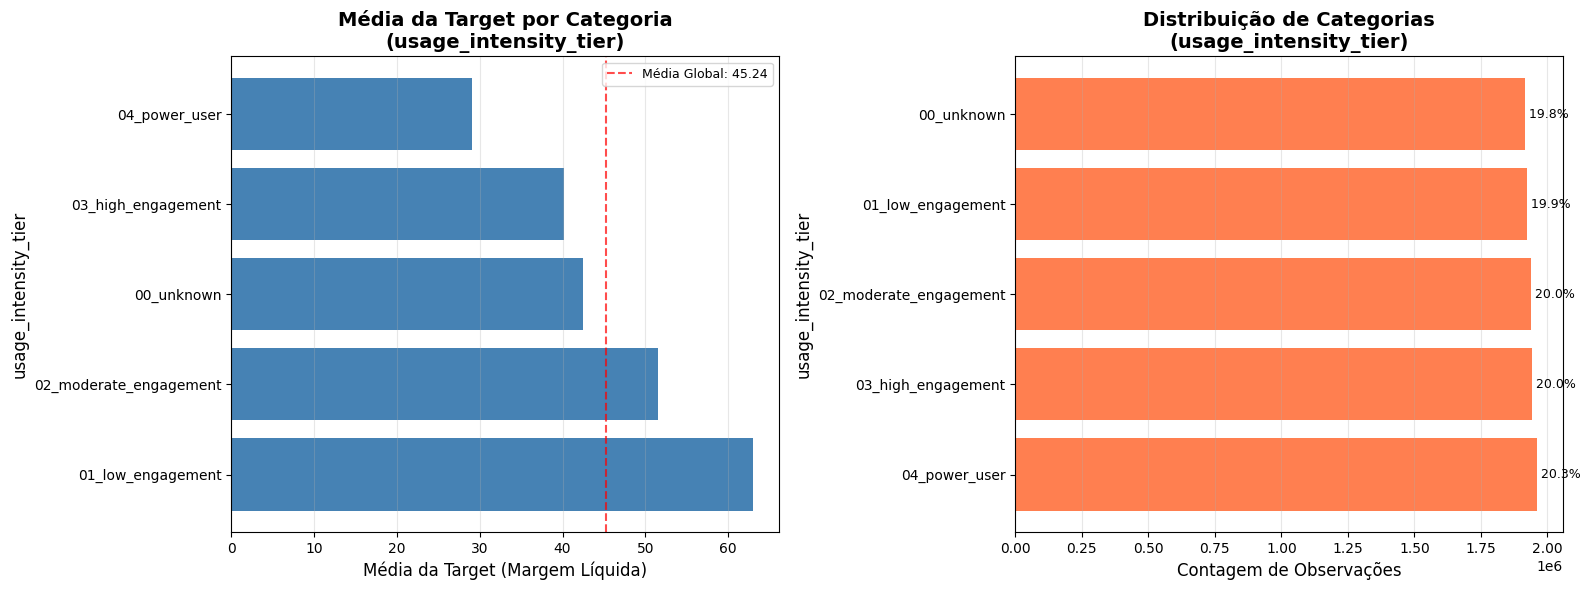


📊 EDA: membership_expire_date vs target_win

membership_expire_date   count  mean_target  std_target  min_target  max_target  median_target   pct
                  NULL 1539830   -36.602484   66.381098 -108.814722  129.040129     -58.888950 57.64
            2016-11-30  107188    64.942359   37.157211 -108.814722  129.040129      76.908677  4.01
            2016-09-30  107154    65.718371   37.253535 -108.814722  129.040129      78.477288  4.01
            2016-10-31  105501    68.807107   31.047048 -108.814722  129.040129      78.832105  3.95
            2016-08-31  105072    68.470746   33.551877 -108.814722  129.040129      80.145683  3.93
            2016-12-31   98113    66.887366   30.838570 -108.814722  129.040129      75.681004  3.67
            2016-02-29   97913    66.141788   45.568278 -108.814722  129.040129      85.280455  3.67
            2016-04-30   83993    66.822809   43.418397 -108.814722  129.040129      84.117943  3.14
            2016-06-30   83681    68.499972  

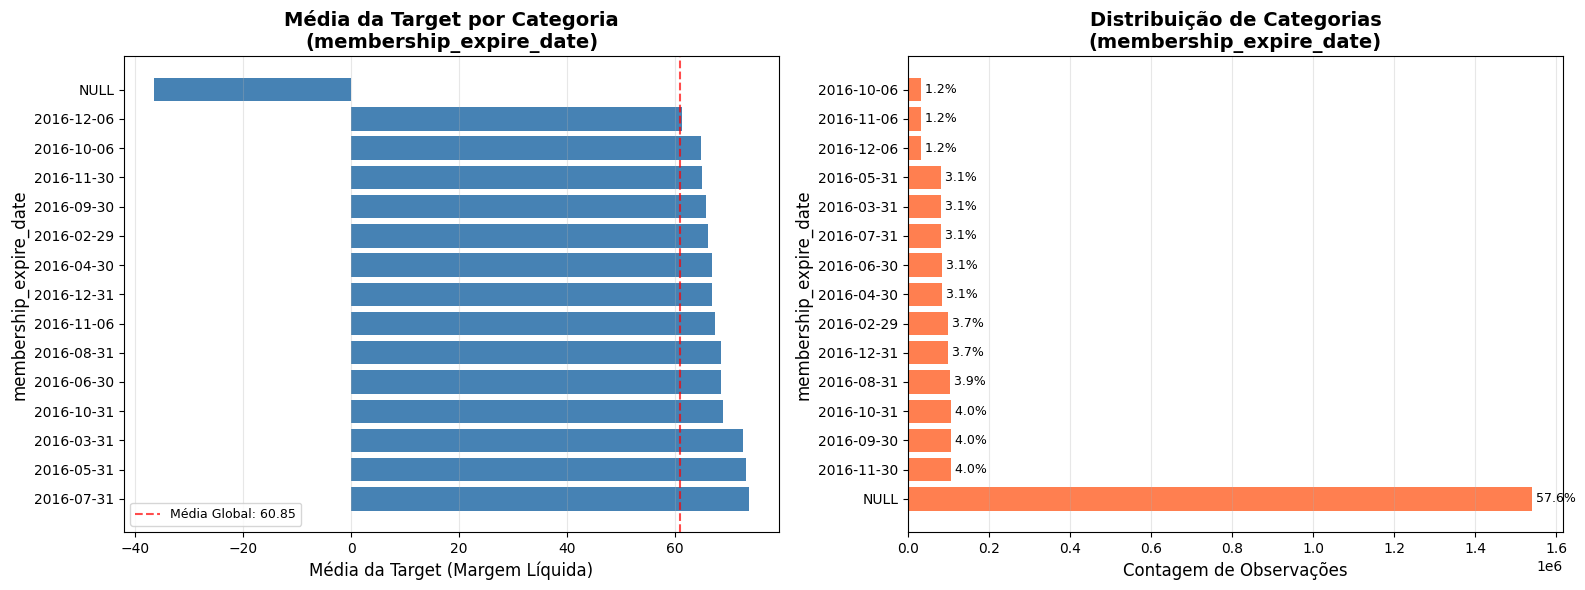


⚠️  ALERTA: 1,539,830 valores nulos (57.64%) encontrados em 'membership_expire_date'
   └─ Considere investigar a origem desses nulos antes de prosseguir.


📊 EDA: transaction_date vs target_win

transaction_date   count  mean_target  std_target  min_target  max_target  median_target   pct
            NULL 1539830   -36.602484   66.381098 -108.814722  129.040129     -58.888950 48.50
      2016-08-31  183012    71.751511   33.021207 -108.814722  129.040129      84.141092  5.76
      2016-09-30  181982    71.836296   31.213043 -108.814722  129.040129      83.191565  5.73
      2016-07-31  181015    74.414971   27.859558 -108.814722  129.040129      84.796677  5.70
      2016-10-31  180163    70.564038   33.938360 -108.814722  129.040129      83.232852  5.67
      2016-11-30  178836    71.495022   30.927179 -108.814722  129.040129      82.703069  5.63
      2016-01-31  176032    11.265933   75.032972 -108.814722  129.040129      37.861367  5.54
      2016-02-29   93670    71.626625   36.

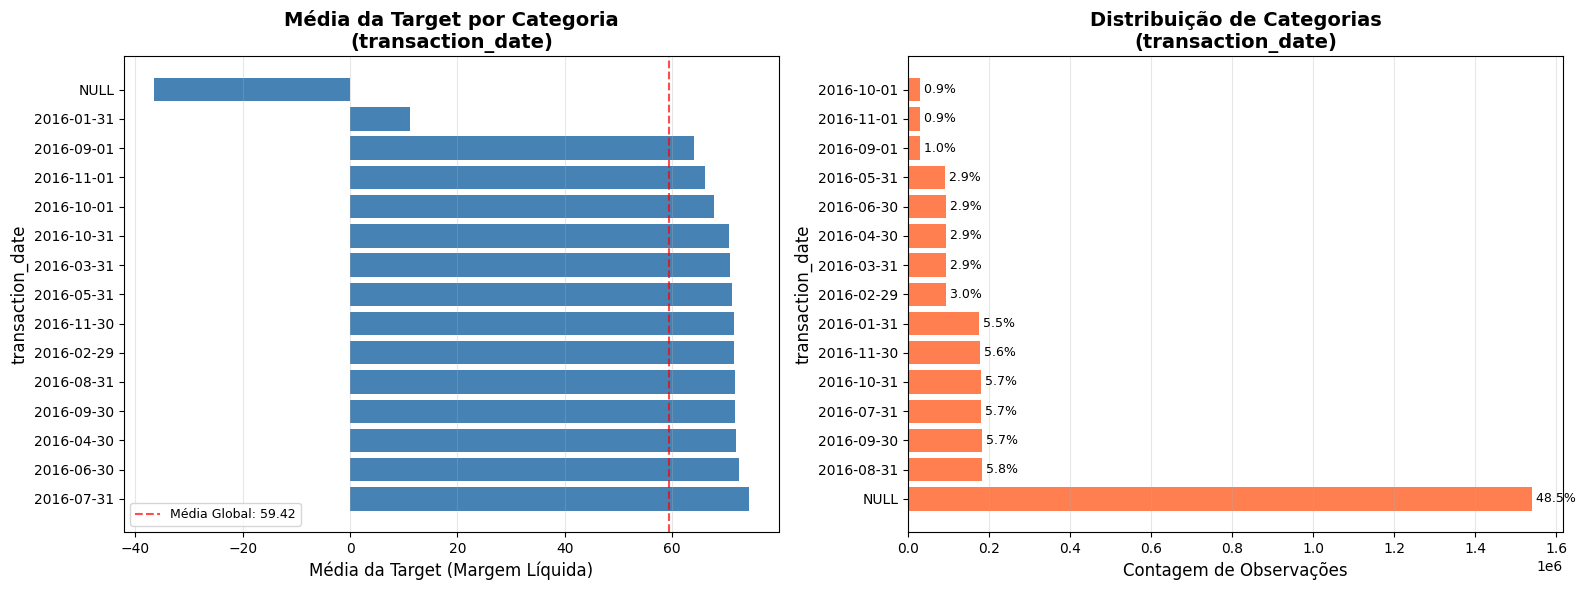


⚠️  ALERTA: 1,539,830 valores nulos (48.50%) encontrados em 'transaction_date'
   └─ Considere investigar a origem desses nulos antes de prosseguir.


📊 EDA: registration_init_time vs target_win

registration_init_time  count  mean_target  std_target  min_target  max_target  median_target  pct
            2016-01-16  20749    40.327998   36.263527 -108.814722  129.040129      46.742943 9.16
            2015-10-09  20169    36.667468   39.588970 -108.814722  129.040129      44.285601 8.91
            2016-01-19  17019    39.254080   36.780741 -108.814722  129.040129      46.871398 7.52
            2015-10-10  16712    38.757583   40.708478 -108.814722  129.040129      45.607589 7.38
            2015-11-21  15034    39.262578   44.951344 -108.814722  129.040129      47.008254 6.64
            2015-08-15  14762    41.826920   45.669304 -108.814722  129.040129      48.472863 6.52
            2016-01-09  14655    39.238509   46.664940 -108.814722  129.040129      47.399936 6.47
           

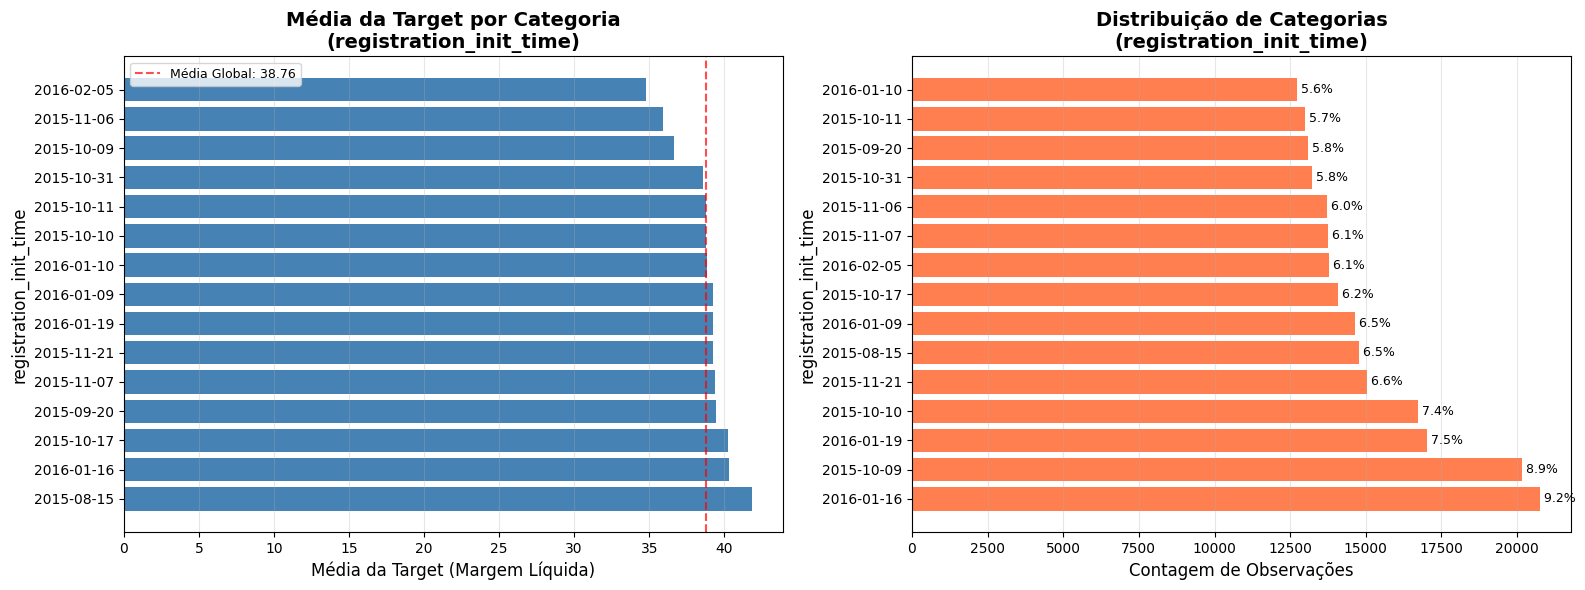

In [ ]:
for col in features_categoricas_base:
    eda_categorica_vs_target(df_elastic_net, col, "target_win")

Por que as variaveis que vem do book de logs estao com classe nula ao inves de unknown, como foi definido anteriormente?

#### Cramer's V

🔄 Iniciando indexação de 19 colunas categóricas...
✅ Indexação concluída!

Calculando: total_plays_group ↔ completed_songs_rate_group
Calculando: total_plays_group ↔ avg_secs_per_unq_cap_group
Calculando: total_plays_group ↔ plays_per_unq_behavior
Calculando: total_plays_group ↔ plays_behavior_vs_volume
Calculando: total_plays_group ↔ plays_behavior_vs_volume_collapsed
Calculando: total_plays_group ↔ plays_behavior_vs_completion
Calculando: total_plays_group ↔ plays_behavior_vs_completion_collapsed
Calculando: total_plays_group ↔ early_drop_rate_group
Calculando: total_plays_group ↔ revenue_tier
Calculando: total_plays_group ↔ payment_method_group
Calculando: total_plays_group ↔ payment_price_regime
Calculando: total_plays_group ↔ gender_clean
Calculando: total_plays_group ↔ faixa_idade
Calculando: total_plays_group ↔ registered_via_group
Calculando: total_plays_group ↔ registration_year_regime
Calculando: total_plays_group ↔ tenure_faixa
Calculando: total_plays_group ↔ revenue_per_hou

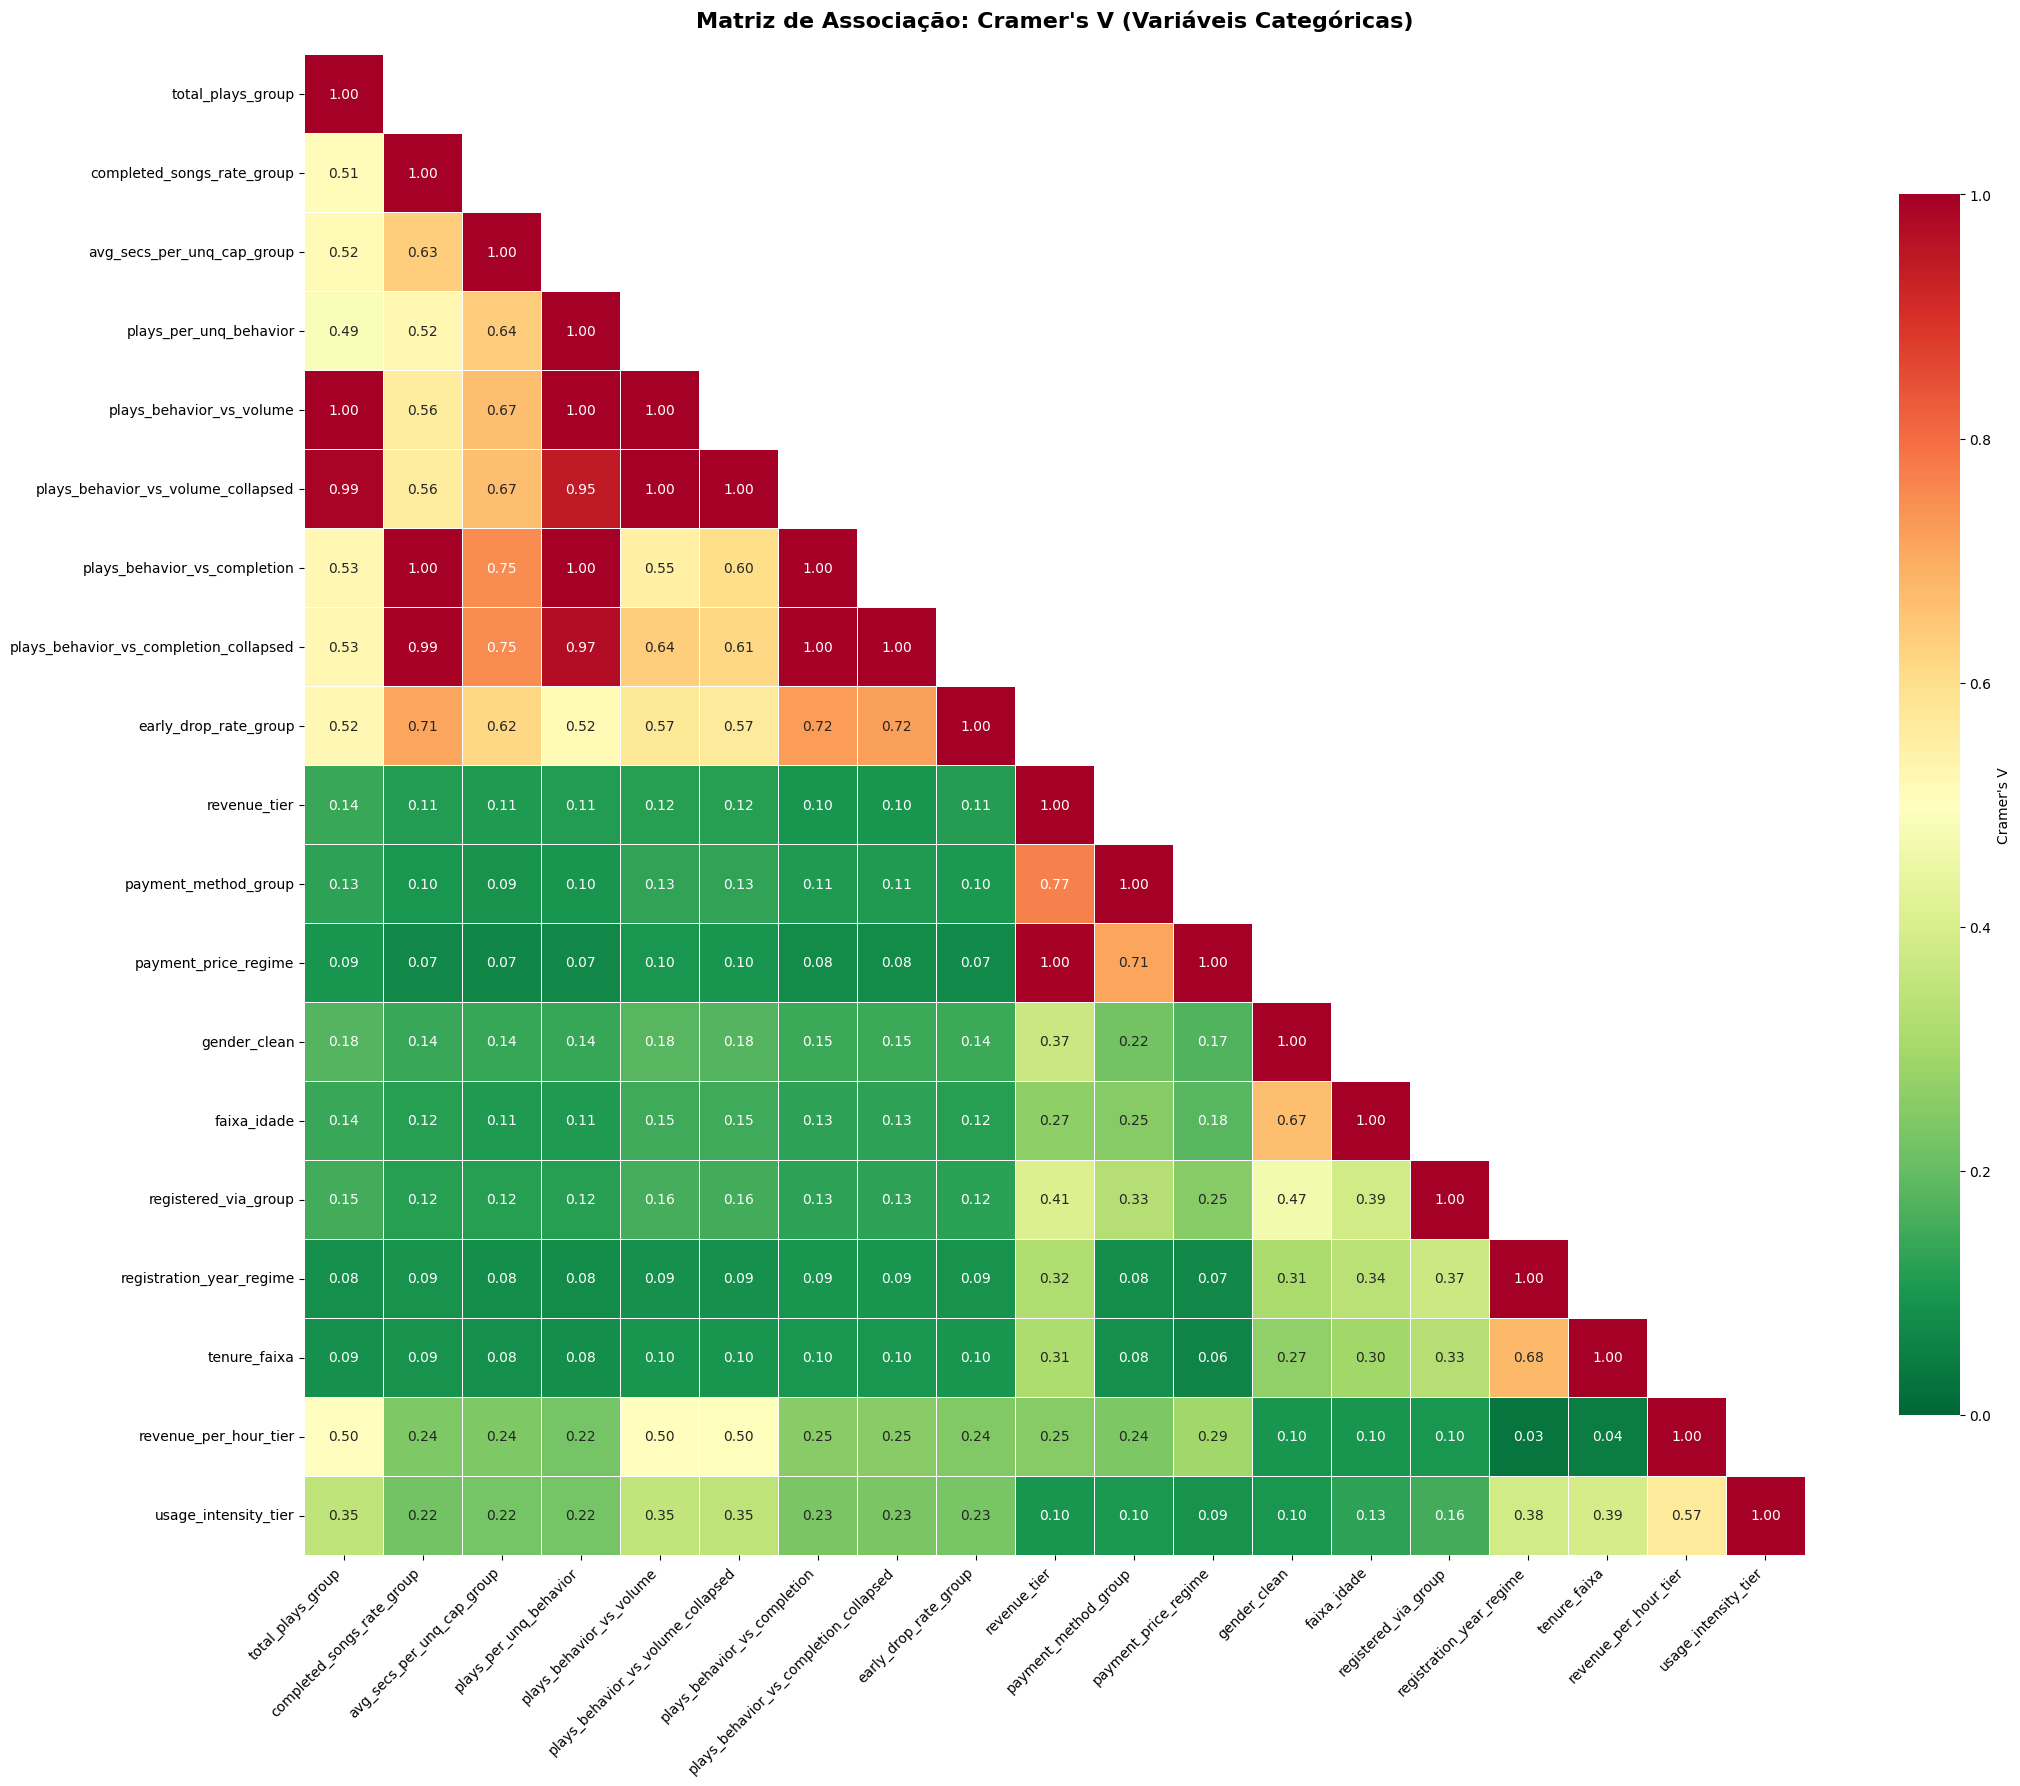

In [ ]:
cramer_matrix = matriz_cramer_v_spark_optimized(
    df=df_elastic_net, 
    colunas_categoricas=features_categoricas_base,
    figsize=(22, 18)  # Ajuste conforme necessário
)

In [ ]:
cramer_matrix

total_plays_group  completed_songs_rate_group  avg_secs_per_unq_cap_group  plays_per_unq_behavior  plays_behavior_vs_volume  \
total_plays_group                                1.000000                    0.512608                    0.516722                0.487073                  1.000000   
completed_songs_rate_group                       0.512608                    1.000000                    0.634778                0.523585                  0.561181   
avg_secs_per_unq_cap_group                       0.516722                    0.634778                    1.000000                0.637397                  0.667005   
plays_per_unq_behavior                           0.487073                    0.523585                    0.637397                1.000000                  1.000000   
plays_behavior_vs_volume                         1.000000                    0.561181                    0.667005                1.000000                  1.000000   
plays_behavior_vs_volume_collapsed               0.989771                    0.559830                    0.666957                0.945105                  1.000000   
plays_behavior_vs_completion                     0.527137                    1.000000                    0.753215                1.000000                  0.550276   
plays_behavior_vs_completion_collapsed           0.527072                    0.994980                    0.753212                0.968851                  0.636079   
early_drop_rate_group                            0.521106                    0.712223                    0.615928                0.515879                  0.571027   
revenue_tier                                     0.142499                    0.110186                    0.108482                0.112135                  0.119427   
payment_method_group                             0.128319                    0.100340                    0.092827                0.095608                  0.132061   
payment_price_regime                             0.094952                    0.070252                    0.065678                0.066923                  0.098096   
gender_clean                                     0.178483                    0.141155                    0.139257                0.139902                  0.180912   
faixa_idade                                      0.143851                    0.120720                    0.109250                0.108749                  0.151136   
registered_via_group                             0.154977                    0.119019                    0.117410                0.120159                  0.156838   
registration_year_regime                         0.082119                    0.090318                    0.081350                0.077451                  0.089688   
tenure_faixa                                     0.088218                    0.093469                    0.084149                0.080786                  0.097126   
revenue_per_hour_tier                            0.500121                    0.238545                    0.242168                0.224686                  0.503510   
usage_intensity_tier                             0.350217                    0.220438                    0.222658                0.223307                  0.351900   

                                        plays_behavior_vs_volume_collapsed  plays_behavior_vs_completion  plays_behavior_vs_completion_collapsed  early_drop_rate_group  \
total_plays_group                                                 0.989771                      0.527137                                0.527072               0.521106   
completed_songs_rate_group                                        0.559830                      1.000000                                0.994980               0.712223   
avg_secs_per_unq_cap_group                                        0.666957                      0.753215                                0.753212               0.615928   
plays_per_unq_b

Pares de correlação mais forte:

* plays_behavior_vs_volume X total_plays_group
* plays_behavior_vs_completion X completed_songs_rate_group
* plays_behavior_vs_completion X avg_secs_per_unq_cap_group
* plays_behavior_vs_volume X plays_per_unq_behavior
* plays_behavior_vs_completion X plays_per_unq_behavior
* payment_price_regime X revenue_tier

#### ANOVA F-Statistic

##### Definição

*O que é ANOVA (Analysis of Variance)?*

A **ANOVA** é um teste estatístico que verifica se as médias de categorias são significativamente diferentes entre si.

* Pergunta:"*A margem média varia significativamente entre os tipos de usuário?*" Se a resposta for SIM, a feature tem poder preditivo.

**Decomposição da Variância**

A ANOVA decompõe a variância total da target em duas partes:

$$
\text{SS}_{\text{total}} = \text{SS}_{\text{between}} + \text{SS}_{\text{within}}
$$

Onde:

**SS_total (Sum of Squares Total):**
Variância total dos dados em relação à média global.

$$
\text{SS}_{\text{total}} = \sum_{i=1}^{n} (y_i - \bar{y})^2
$$

- $y_i$: Valor da target para a observação $i$
- $\bar{y}$: Média global da target
- $n$: Número total de observações

**SS_between (Sum of Squares Between Groups):**
Variância **explicada** pelas diferenças entre as médias dos grupos.

$$
\text{SS}_{\text{between}} = \sum_{j=1}^{k} n_j (\bar{y}_j - \bar{y})^2
$$

- $k$: Número de categorias (grupos)
- $n_j$: Número de observações no grupo $j$
- $\bar{y}_j$: Média da target no grupo $j$
- $\bar{y}$: Média global

**Interpretação:** Se as médias dos grupos são muito diferentes da média global, $\text{SS}_{\text{between}}$ é alto → **Feature forte**.

**SS_within (Sum of Squares Within Groups):**
Variância **não explicada** (variação dentro de cada grupo).

$$
\text{SS}_{\text{within}} = \sum_{j=1}^{k} \sum_{i=1}^{n_j} (y_{ij} - \bar{y}_j)^2
$$

- $y_{ij}$: Valor da target para a observação $i$ no grupo $j$

**Interpretação:** Quanto menor, mais homogêneos são os grupos (boa separação).

**F-Statistic: A Métrica de Decisão**

O F-statistic é a razão entre a variância explicada e a não explicada:

$$
F = \frac{\text{MS}_{\text{between}}}{\text{MS}_{\text{within}}}
$$

Onde:

$$
\text{MS}_{\text{between}} = \frac{\text{SS}_{\text{between}}}{k - 1} \quad \text{(Mean Square Between)}
$$

$$
\text{MS}_{\text{within}} = \frac{\text{SS}_{\text{within}}}{n - k} \quad \text{(Mean Square Within)}
$$

- $k - 1$: Graus de liberdade entre grupos
- $n - k$: Graus de liberdade dentro dos grupos

**Interpretação do F-Statistic:**

| Valor de F | Interpretação |
|------------|---------------|
| **F ≈ 1** | As médias dos grupos são similares → **Feature fraca** |
| **F >> 1** | As médias dos grupos são muito diferentes → **Feature forte** |
| **F < 1** | Variação dentro dos grupos é maior que entre grupos → **Feature inútil** |

**Regra prática:**
- $F > 10$: Feature com poder preditivo moderado
- $F > 50$: Feature com poder preditivo forte
- $F > 100$: Feature com poder preditivo muito forte

**P-Valor: Significância Estatística**

O p-valor indica a probabilidade de observar um F-statistic tão extremo **por acaso** (se não houvesse diferença real entre os grupos).

$$
\text{p-value} = P(F_{\text{obs}} | H_0)
$$

Onde $H_0$ (hipótese nula) = "Todas as médias dos grupos são iguais".

**Interpretação:**
- $p < 0.05$: Rejeitamos $H_0$ → **Diferença significativa** (feature relevante)
- $p \geq 0.05$: Aceitamos $H_0$ → **Diferença não significativa** (feature fraca)

**Eta-Squared (η²): Tamanho do Efeito**

O Eta-squared mede a proporção da variância total explicada pela variável categórica.

$$
\eta^2 = \frac{\text{SS}_{\text{between}}}{\text{SS}_{\text{total}}}
$$

**Interpretação (Regra de Cohen):**

| η² | Interpretação | Exemplo |
|----|---------------|---------|
| **< 0.01** | Efeito trivial | Feature quase inútil |
| **0.01 - 0.06** | Efeito pequeno | Feature fraca, mas pode ajudar em ensemble |
| **0.06 - 0.14** | Efeito médio | Feature moderada, útil para o modelo |
| **> 0.14** | Efeito grande | Feature forte, alta capacidade preditiva |

**Por que η² é melhor que F-statistic sozinho?**
- O F-statistic é sensível ao tamanho da amostra (amostras grandes sempre têm F alto).
- O η² é **normalizado** (varia de 0 a 1), permitindo comparar features independentemente do tamanho da base.

**Pressupostos da ANOVA**

Para que o teste seja válido, três pressupostos devem ser atendidos:

1. Independência: As observações são independentes entre si.
2. Normalidade: A target segue distribuição normal dentro de cada grupo.
3. Homocedasticidade: A variância da target é similar entre os grupos.

**Na prática (Big Data):**
- Com amostras grandes (n > 30 por grupo), a ANOVA é robusta a violações de normalidade (Teorema do Limite Central).
- Se a homocedasticidade for violada, use *Welch's ANOVA* (variante mais robusta).

##### Execução e Resultados

In [ ]:
df_elastic_net = df_elastic_net.select(
    'msno',
    'safra',
    'target_win',
    *features_numericas_finais_elastic_net,
    *features_categoricas_base
)

In [ ]:
df_elastic_net.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target_win: double (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- actual_amount_paid: double (nullable = true)
 |-- flag_plano_mensal_max_3: integer (nullable = true)
 |-- log_total_secs_mean_3: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- total_plays_group: string (nullable = true)
 |-- completed_songs_rate_group: string (nullable = true)
 |-- avg_secs_per_unq_cap_group: string (nullable = true)
 |-- plays_per_unq_behavior: string (nullable = true)
 |-- plays_behavior_vs_volume: string (nullable = true)
 |-- plays_behavior_vs_volume_collapsed: string (nullable = true)
 |-- plays_behavior_vs_completion: string (nullable = true)
 |-- plays_behavior_vs_completion_collapsed: string (nullable = true)
 |-- early_drop_rate_grou

In [ ]:
df_elastic_net.count()

9678866

In [ ]:
def calcular_anova_f_spark(df, col_categorica, col_target):
    """
    Calcula o F-statistic da ANOVA para uma variável categórica vs target contínua.
    VERSÃO OTIMIZADA: Calcula tudo no Spark (sem toPandas).
    
    Fórmulas:
    ---------
    F = MS_between / MS_within
    η² = SS_between / SS_total
    p-value = calculado via scipy (apenas estatísticas agregadas)
    """
    
    print(f"\n{'─'*60}")
    print(f"🔬 Calculando ANOVA: {col_categorica} vs {col_target}")
    print(f"{'─'*60}")
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 1: Tratamento de Nulos
    # ═══════════════════════════════════════════════════════════
    df_clean = df.withColumn(col_categorica,
        F.when(F.col(col_categorica).isNull(), "NULL").otherwise(F.col(col_categorica).cast('string')))
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 2: Calcular Estatísticas Globais (no Spark)
    # ═══════════════════════════════════════════════════════════
    global_stats = df_clean.select(
        F.count(col_target).alias('n_total'),
        F.mean(col_target).alias('grand_mean'),
        F.sum(F.col(col_target)).alias('sum_total')
    ).collect()[0]
    
    n_total = global_stats['n_total']
    grand_mean = global_stats['grand_mean']
    
    print(f"  ├─ Observações válidas: {n_total:,}")
    print(f"  ├─ Média global: {grand_mean:.4f}")
    
    # Calcular SS_total (Sum of Squares Total)
    # SS_total = Σ (y_i - ȳ)²
    ss_total = df_clean.select(F.sum((F.col(col_target) - F.lit(grand_mean)) ** 2).alias('ss_total')).collect()[0]['ss_total']
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 3: Calcular Estatísticas por Grupo (no Spark)
    # ═══════════════════════════════════════════════════════════
    group_stats = df_clean.groupBy(col_categorica).agg(
        F.count(col_target).alias('n_j'),
        F.mean(col_target).alias('mean_j'),
        F.variance(col_target).alias('var_j')  # Variância amostral
    ).collect()
    
    n_categories = len(group_stats)
    print(f"  ├─ Número de categorias: {n_categories}")
    
    # Verificar se há categorias suficientes
    if n_categories < 2:
        print(f"  └─ ⚠️ AVISO: Apenas {n_categories} categoria(s). ANOVA não aplicável.")
        return {
            'feature': col_categorica,
            'f_statistic': 0.0,
            'p_value': 1.0,
            'eta_squared': 0.0,
            'n_categories': n_categories,
            'n_obs': n_total,
            'mean_between_groups': 0.0,
            'interpretacao': '❌ Muito Fraco',
            'significativo': False,
            'status': 'insufficient_categories'
        }
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 4: Calcular SS_between e SS_within
    # ═══════════════════════════════════════════════════════════
    ss_between = 0.0
    ss_within = 0.0
    
    means = []
    for row in group_stats:
        n_j = row['n_j']
        mean_j = row['mean_j']
        var_j = row['var_j'] if row['var_j'] is not None else 0.0
        
        means.append(mean_j)
        
        # SS_between = Σ n_j (ȳ_j - ȳ)²
        ss_between += n_j * (mean_j - grand_mean) ** 2
        
        # SS_within = Σ (n_j - 1) * var_j
        ss_within += (n_j - 1) * var_j
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 5: Calcular F-statistic
    # ═══════════════════════════════════════════════════════════
    df_between = n_categories - 1  # Graus de liberdade entre grupos
    df_within = n_total - n_categories  # Graus de liberdade dentro dos grupos
    
    ms_between = ss_between / df_between if df_between > 0 else 0.0
    ms_within = ss_within / df_within if df_within > 0 else 0.0
    
    f_stat = ms_between / ms_within if ms_within > 0 else 0.0
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 6: Calcular P-value (usando scipy)
    # ═══════════════════════════════════════════════════════════
    try:
        from scipy.stats import f as f_dist
        p_value = 1 - f_dist.cdf(f_stat, df_between, df_within)
    except Exception as e:
        print(f"  └─ ⚠️ AVISO: Não foi possível calcular p-value: {e}")
        p_value = 0.0 if f_stat > 10 else 1.0  # Heurística
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 7: Calcular Eta-Squared (η²)
    # ═══════════════════════════════════════════════════════════
    eta_squared = ss_between / ss_total if ss_total > 0 else 0.0
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 8: Calcular Diferença Média Entre Grupos
    # ═══════════════════════════════════════════════════════════
    mean_between_groups = max(means) - min(means) if means else 0.0
    
    # ═══════════════════════════════════════════════════════════
    # ETAPA 9: Interpretação
    # ═══════════════════════════════════════════════════════════
    if eta_squared > 0.14:
        interpretacao = "🔥 Forte"
    elif eta_squared > 0.06:
        interpretacao = "✅ Moderado"
    elif eta_squared > 0.01:
        interpretacao = "⚠️ Fraco"
    else:
        interpretacao = "❌ Muito Fraco"
    
    significancia = "✅ Significativo" if p_value < 0.05 else "❌ Não Significativo"
    
    print(f"  ├─ F-statistic: {f_stat:.2f}")
    print(f"  ├─ P-value: {p_value:.4e}")
    print(f"  ├─ Eta-squared (η²): {eta_squared:.4f}")
    print(f"  ├─ Interpretação: {interpretacao}")
    print(f"  └─ Significância: {significancia}")
    
    return {
        'feature': col_categorica,
        'f_statistic': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'n_categories': n_categories,
        'n_obs': n_total,
        'mean_between_groups': mean_between_groups,
        'interpretacao': interpretacao,
        'significativo': p_value < 0.05,
        'status': 'success'
    }

In [ ]:
def ranking_features_categoricas(df, colunas_categoricas, col_target):
    """
    Rankeia variáveis categóricas por poder preditivo (ANOVA F-statistic).
    VERSÃO OTIMIZADA: Usa calcular_anova_f_spark (sem toPandas).
    """
    print(f"\n{'='*80}")
    print(f"🏆 RANKING DE FEATURES CATEGÓRICAS")
    print(f"{'='*80}\n")
    
    results = []
    for i, col in enumerate(colunas_categoricas, 1):
        print(f"\n[{i}/{len(colunas_categoricas)}] Processando: {col}")
        result = calcular_anova_f_spark(df, col, col_target)
        results.append(result)
    
    # ═══════════════════════════════════════════════════════════
    # Criar DataFrame e Ordenar
    # ═══════════════════════════════════════════════════════════
    ranking_df = pd.DataFrame(results).sort_values('f_statistic', ascending=False)
    
    # ═══════════════════════════════════════════════════════════
    # Visualização: Tabela
    # ═══════════════════════════════════════════════════════════
    print(f"\n{'='*80}")
    print(f"📊 RESULTADO FINAL")
    print(f"{'='*80}\n")
    
    display_df = ranking_df[[
        'feature', 'f_statistic', 'p_value', 'eta_squared', 
        'n_categories', 'interpretacao', 'significativo'
    ]].copy()
    
    print(display_df.to_string(index=False))
    
    # ═══════════════════════════════════════════════════════════
    # Visualização: Gráfico de Barras
    # ═══════════════════════════════════════════════════════════
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Gráfico 1: F-Statistic
    ax1 = axes[0]
    colors = ranking_df['eta_squared'].apply(
        lambda x: '#d62728' if x > 0.14 else 
                  '#ff7f0e' if x > 0.06 else 
                  '#2ca02c' if x > 0.01 else 
                  '#7f7f7f'
    )
    
    ax1.barh(ranking_df['feature'], ranking_df['f_statistic'], color=colors)
    ax1.set_xlabel('F-Statistic (ANOVA)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Feature Categórica', fontsize=12, fontweight='bold')
    ax1.set_title('Ranking de Features: F-Statistic\n(Maior = Melhor Separação Entre Grupos)', 
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Legenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d62728', label='🔥 Forte (η² > 0.14)'),
        Patch(facecolor='#ff7f0e', label='✅ Moderado (η² > 0.06)'),
        Patch(facecolor='#2ca02c', label='⚠️ Fraco (η² > 0.01)'),
        Patch(facecolor='#7f7f7f', label='❌ Muito Fraco (η² ≤ 0.01)')
    ]
    ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    # Gráfico 2: Eta-Squared (η²)
    ax2 = axes[1]
    ax2.barh(ranking_df['feature'], ranking_df['eta_squared'], color=colors)
    ax2.set_xlabel('Eta-Squared (η²)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Feature Categórica', fontsize=12, fontweight='bold')
    ax2.set_title('Ranking de Features: Eta-Squared (η²)\n(Proporção de Variância Explicada)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.set_xlim(0, max(0.2, ranking_df['eta_squared'].max() * 1.1))
    
    # Adicionar linhas de referência
    ax2.axvline(0.01, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(0.06, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(0.14, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return ranking_df


🏆 RANKING DE FEATURES CATEGÓRICAS


[1/19] Processando: total_plays_group

────────────────────────────────────────────────────────────
🔬 Calculando ANOVA: total_plays_group vs target_win
────────────────────────────────────────────────────────────
  ├─ Observações válidas: 9,678,866
  ├─ Média global: 45.1861
  ├─ Número de categorias: 5
  ├─ F-statistic: 126256.73
  ├─ P-value: 1.1102e-16
  ├─ Eta-squared (η²): 0.0496
  ├─ Interpretação: ⚠️ Fraco
  └─ Significância: ✅ Significativo

[2/19] Processando: completed_songs_rate_group

────────────────────────────────────────────────────────────
🔬 Calculando ANOVA: completed_songs_rate_group vs target_win
────────────────────────────────────────────────────────────
  ├─ Observações válidas: 9,678,866
  ├─ Média global: 45.1861
  ├─ Número de categorias: 5
  ├─ F-statistic: 30278.00
  ├─ P-value: 1.1102e-16
  ├─ Eta-squared (η²): 0.0124
  ├─ Interpretação: ⚠️ Fraco
  └─ Significância: ✅ Significativo

[3/19] Processando: avg_secs_per_unq_c

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_18752\1992549589.py:81: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_18752\1992549589.py:81: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_18752\1992549589.py:81: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Gustavo\anaconda3\envs\datamaster\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Gustavo\anaconda3\envs\datamaster\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Gustavo\anaconda3\envs\datamaster\Lib\site-packages\IPyt

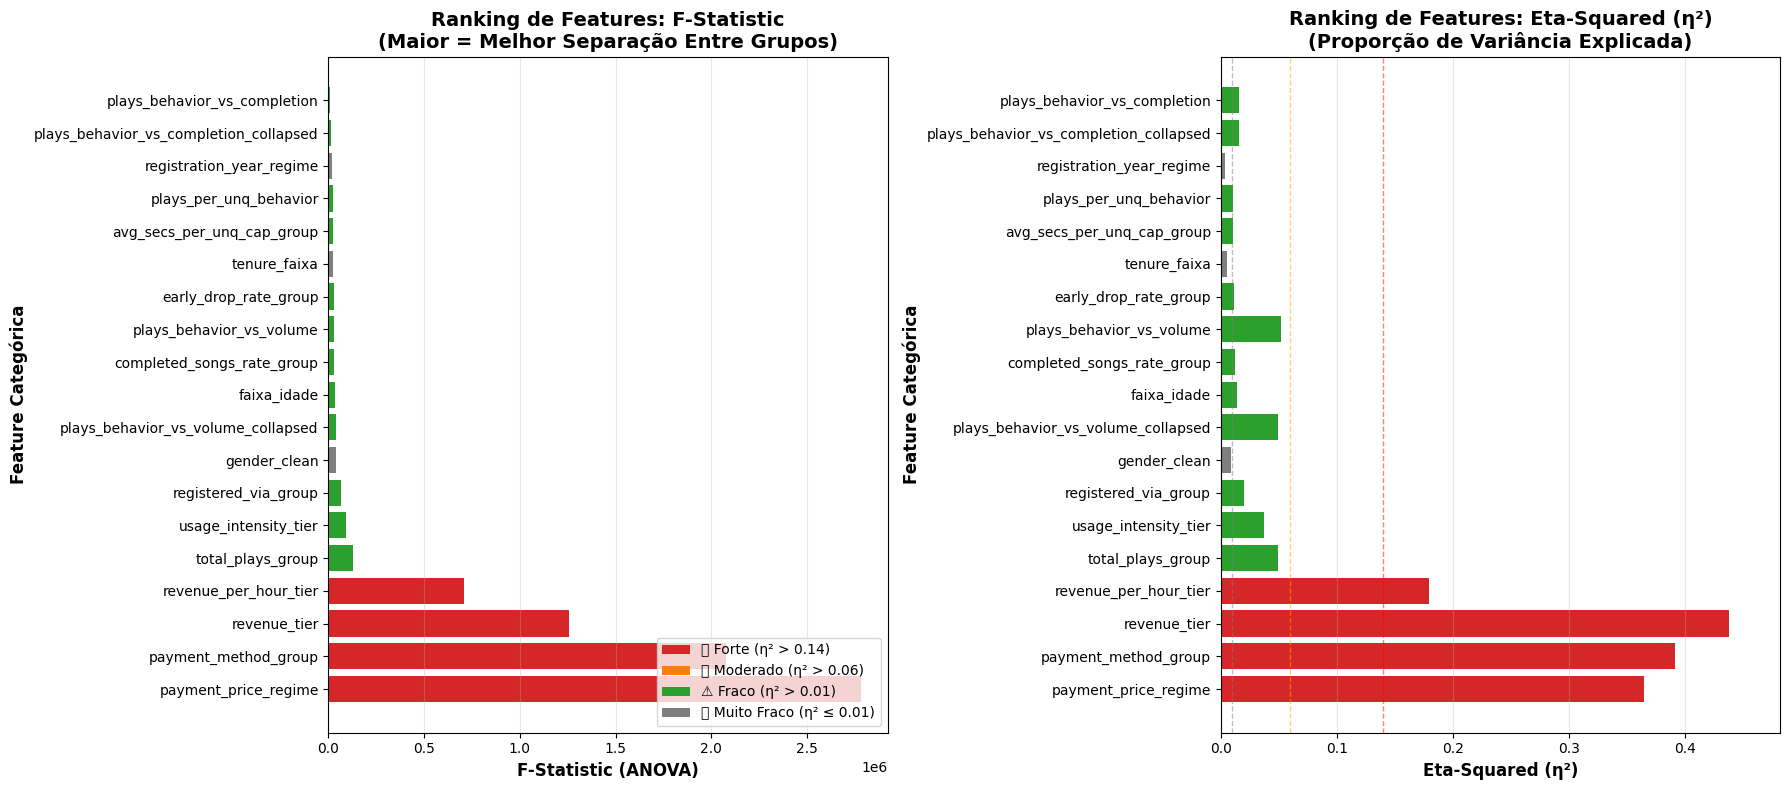


✅ Features aprovadas para Elastic Net: 16
['payment_price_regime', 'payment_method_group', 'revenue_tier', 'revenue_per_hour_tier', 'total_plays_group', 'usage_intensity_tier', 'registered_via_group', 'plays_behavior_vs_volume_collapsed', 'faixa_idade', 'completed_songs_rate_group', 'plays_behavior_vs_volume', 'early_drop_rate_group', 'avg_secs_per_unq_cap_group', 'plays_per_unq_behavior', 'plays_behavior_vs_completion_collapsed', 'plays_behavior_vs_completion']


In [ ]:
ranking_df = ranking_features_categoricas(
    df=df_elastic_net,
    colunas_categoricas=features_categoricas_base,
    col_target='target_win'
)

# ═══════════════════════════════════════════════════════════
# Filtrar features aprovadas (critério: η² ≥ 0.01 e p < 0.05)
# ═══════════════════════════════════════════════════════════
features_aprovadas = ranking_df[
    (ranking_df['eta_squared'] >= 0.01) & 
    (ranking_df['significativo'] == True)
]['feature'].tolist()

print(f"\n✅ Features aprovadas para Elastic Net: {len(features_aprovadas)}")
print(features_aprovadas)

Como foi anotado anteriormente, agora é possível comparar o η² com o grau de correlação das categóricas entre si (cramer v):

* plays_behavior_vs_volume (η², η² colapsed: 0.0519, 0.0495) X total_plays_group (η²: 0.0496) --> **plays_behavior_vs_volume**
* plays_behavior_vs_completion (η²: 0.0153) X completed_songs_rate_group (η²: 0.0124) --> **plays_behavior_vs_completion**
* plays_behavior_vs_completion (η²: 0.0153) X avg_secs_per_unq_cap_group (η²: 0.0105) --> plays_behavior_vs_completion
* plays_behavior_vs_volume (η², η² colapsed: 0.0519, 0.0495) X plays_per_unq_behavior (η²: 0.0103) --> plays_behavior_vs_volume
* plays_behavior_vs_completion (η²: 0.0153) X plays_per_unq_behavior (η²: 0.0103) --> plays_behavior_vs_completion
* payment_price_regime (η²: 0.3650) X revenue_tier (η²: 0.4383) --> **revenue_tier**, que também ganha por ter maior granularidade

#### Conclusão - categóricas finalistas EN

In [ ]:
features_categoricas_finais = [
    # ═══════════════════════════════════════════════════════════
    # TIER S: Features de Receita/Preço (Essenciais)
    # ═══════════════════════════════════════════════════════════
    'payment_method_group',        # η² = 0.392 (mantida: captura método de pagamento)
    'revenue_tier',                # η² = 0.438 (mantida: melhor que payment_price_regime por ser mais granular)
    'revenue_per_hour_tier',       # η² = 0.180 (mantida: captura eficiência receita/hora)
    
    # ═══════════════════════════════════════════════════════════
    # TIER A: Features de Comportamento (Úteis)
    # ═══════════════════════════════════════════════════════════
    'plays_behavior_vs_volume_collapsed',  # η² = 0.049 (mantida: versão collapsed é mais estável, mesmo que de menor η²)
    'plays_behavior_vs_completion_collapsed',  # η² = 0.015 (mantida: captura interação não-linear)
    'usage_intensity_tier',        # η² = 0.037 (mantida: complementa comportamento)
    
    # ═══════════════════════════════════════════════════════════
    # TIER B: Features Demográficas/Cadastrais (Marginais)
    # ═══════════════════════════════════════════════════════════
    'registered_via_group',        # η² = 0.020 (mantida: canal de aquisição)
    'faixa_idade',                 # η² = 0.014 (mantida: demográfica relevante)
]

# Total: 8 features

🔄 Iniciando indexação de 8 colunas categóricas...
✅ Indexação concluída!

Calculando: payment_method_group ↔ revenue_tier
Calculando: payment_method_group ↔ revenue_per_hour_tier
Calculando: payment_method_group ↔ plays_behavior_vs_volume_collapsed
Calculando: payment_method_group ↔ plays_behavior_vs_completion_collapsed
Calculando: payment_method_group ↔ usage_intensity_tier
Calculando: payment_method_group ↔ registered_via_group
Calculando: payment_method_group ↔ faixa_idade
Calculando: revenue_tier ↔ revenue_per_hour_tier
Calculando: revenue_tier ↔ plays_behavior_vs_volume_collapsed
Calculando: revenue_tier ↔ plays_behavior_vs_completion_collapsed
Calculando: revenue_tier ↔ usage_intensity_tier
Calculando: revenue_tier ↔ registered_via_group
Calculando: revenue_tier ↔ faixa_idade
Calculando: revenue_per_hour_tier ↔ plays_behavior_vs_volume_collapsed
Calculando: revenue_per_hour_tier ↔ plays_behavior_vs_completion_collapsed
Calculando: revenue_per_hour_tier ↔ usage_intensity_tier
Cal

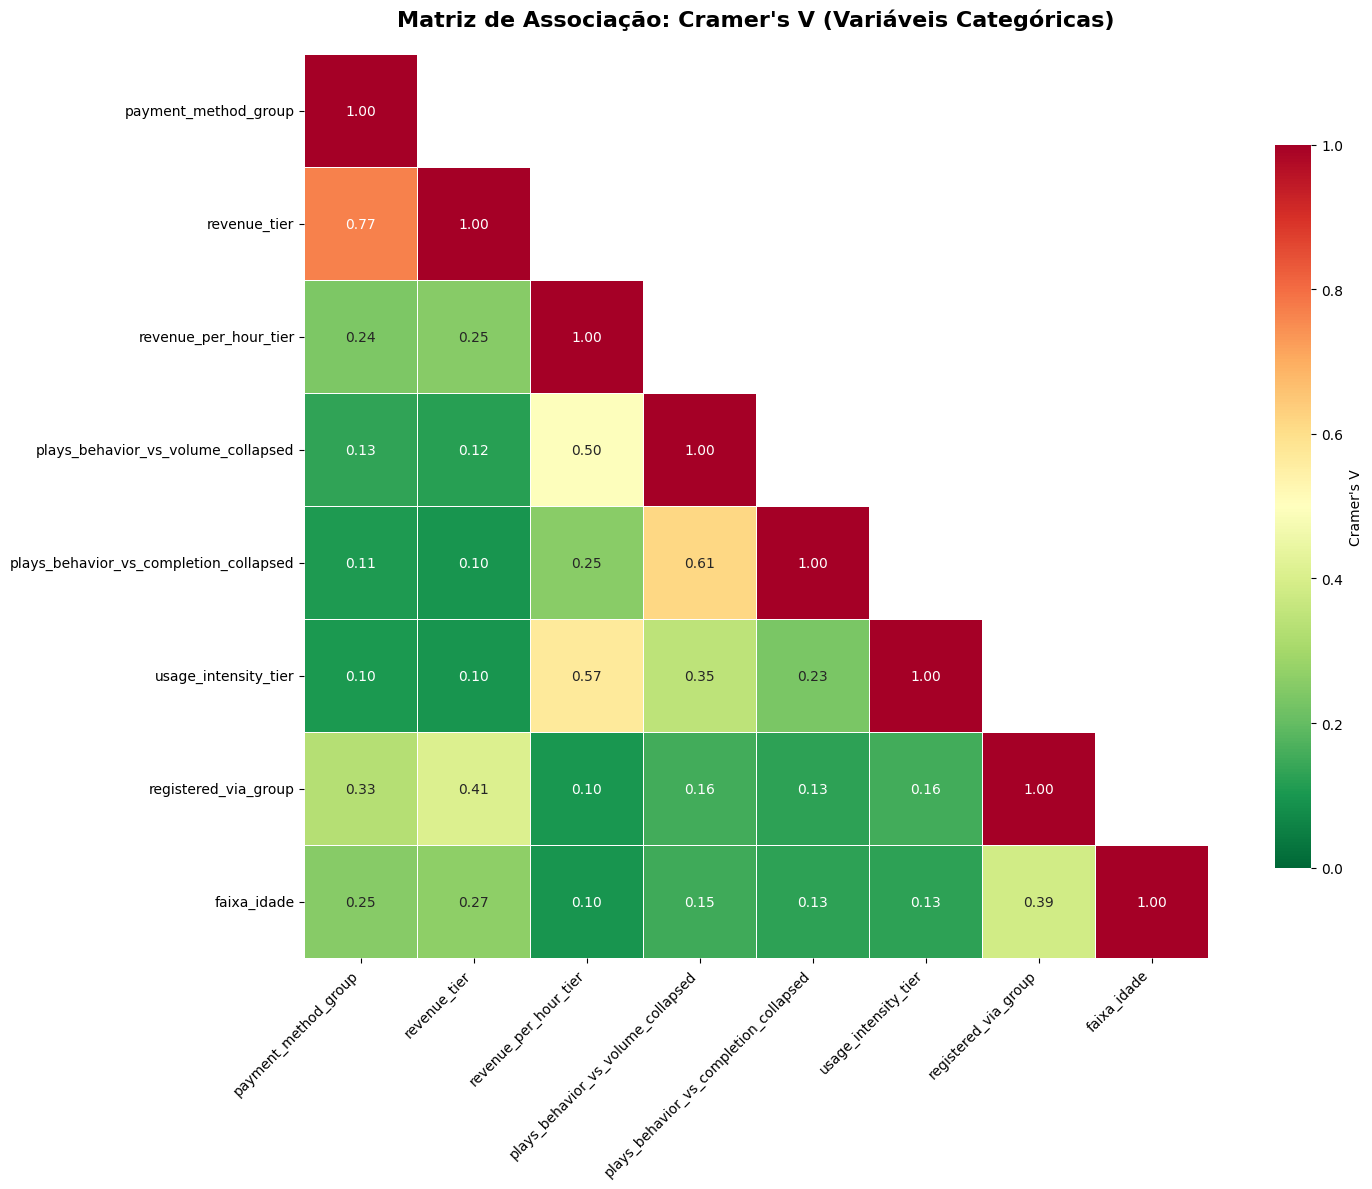

In [ ]:
cramer_matrix_finalistas = matriz_cramer_v_spark_optimized(
    df=df_elastic_net, 
    colunas_categoricas=features_categoricas_finais,
    figsize=(16, 12)  # Ajuste conforme necessário
)

### Definição do melhor encoder para tratar variáveis categóricas e numericas

#### Salvando base inicial para Elastic Net

In [ ]:
df_elastic_net.count()

9678866

In [ ]:
# 1. cache
df_elastic_net = df_elastic_net.persist()
df_elastic_net.count()

# 2. salvar particionado
df_elastic_net.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_feature_store_elastic_net")

#### ABT inicial

In [ ]:
features_numericas_finais_elastic_net

['daily_revenue_efficiency_min_3',
 'revenue_per_hour_listened_cap',
 'actual_amount_paid',
 'flag_plano_mensal_max_3',
 'log_total_secs_mean_3',
 'num_unq',
 'usage_intensity_per_tenure_cap']

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_feature_store_elastic_net = spark.read.parquet(silver_path + "df_feature_store_elastic_net")
df_abt_inicial_elastic_net = df_feature_store_elastic_net.select("msno", "safra", "target_win", *features_numericas_finais_elastic_net, *features_categoricas_finais)

In [ ]:
df_abt_inicial_elastic_net.count()

9678866

In [ ]:
df_abt_inicial_elastic_net.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target_win: double (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- actual_amount_paid: double (nullable = true)
 |-- flag_plano_mensal_max_3: integer (nullable = true)
 |-- log_total_secs_mean_3: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- payment_method_group: string (nullable = true)
 |-- revenue_tier: string (nullable = true)
 |-- revenue_per_hour_tier: string (nullable = true)
 |-- plays_behavior_vs_volume_collapsed: string (nullable = true)
 |-- plays_behavior_vs_completion_collapsed: string (nullable = true)
 |-- usage_intensity_tier: string (nullable = true)
 |-- registered_via_group: string (nullable = true)
 |-- faixa_idade: string (nullable = true)



#### Conceitos e definições

Como vou tratar as features que correspondem a grupos/tiers, tendo mais de duas categorias com valores?

**Modelo Linear (Elastic Net) funciona assim:**

$$
\text{target} = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \ldots + \beta_n \cdot x_n
$$

Onde $x_1, x_2, \ldots, x_n$ são **números**.

**Problema:** Como transformar categorias em números?

**❌ Abordagem ERRADA: Label Encoding Simples**

Ideia inicial: Categoria x  → 1; Categoria y  → 2; Categoria z  → 3

Fazendo desta forma, assumo uma ordem que na verdade não existe. O modelo vai interpretar que:

$$
\text{Categoria y (2)} = 2 \times \text{Categoria x (1)}
$$

$$
\text{Categoria z (3)} = 3 \times \text{Categoria x (1)}
$$

E qual seria o impacto? Ex.:

$$
\text{target} = 100 + 50 \cdot \text{categoria}
$$

$$
\begin{align}
\text{Se categoria} = 1 \text{ (Cat. x)}: & \quad \text{target} = 100 + 50 \cdot 1 = 150 \\
\text{Se categoria} = 2 \text{ (Cat. y)}: & \quad \text{target} = 100 + 50 \cdot 2 = 200 \\
\text{Se categoria} = 3 \text{ (Cat. z)}: & \quad \text{target} = 100 + 50 \cdot 3 = 250
\end{align}
$$

O modelo assume que a categoria z tem margem 100 maior que a categoria a, apenas porque o código é 3 ao invés de 1. Isso não faz sentido algum.

**✅ Solução Ideal: One-Hot Encoding (OHE)**

Ideia: criar uma flag (0 ou 1) para cada categoria. Para uma variável categórica $C$ com $k$ categorias $\{c_1, c_2, \ldots, c_k\}$:

$$
\text{OHE}(C) = \begin{cases}
x_{c_1} = \mathbb{1}(C = c_1) \\
x_{c_2} = \mathbb{1}(C = c_2) \\
\vdots \\
x_{c_k} = \mathbb{1}(C = c_k)
\end{cases}
$$

Onde $\mathbb{1}(\cdot)$ é a **função indicadora**:

$$
\mathbb{1}(C = c_i) = \begin{cases}
1, & \text{se } C = c_i \\
0, & \text{caso contrário}
\end{cases}
$$

O modelo, portanto, ficaria segunda a formula:

$$
\text{target} = \beta_0 + \beta_{x} \cdot \text{categoria\_x} + \beta_{y} \cdot \text{categoria\_y} + \beta_{z} \cdot \text{categoria\_z}
$$

Podendo ser interpretado da seguinte maneira:

$$
\begin{align}
\text{Se categoria é x}: & \quad \text{target} = \beta_0 + \beta_{x} \cdot 1 + \beta_{y} \cdot 0 + \beta_{z} \cdot 0 = \beta_0 + \beta_{x} \\
\text{Se categoria é y}: & \quad \text{target} = \beta_0 + \beta_{x} \cdot 0 + \beta_{y} \cdot 1 + \beta_{z} \cdot 0 = \beta_0 + \beta_{y} \\
\text{Se categoria é z}: & \quad \text{target} = \beta_0 + \beta_{x} \cdot 0 + \beta_{y} \cdot 0 + \beta_{z} \cdot 1 = \beta_0 + \beta_{z}
\end{align}
$$

Onde cada categoria tem seu próprio efeito independente.

**⚠️ Problema: Multicolinearidade Perfeita (Dummy Variable Trap)**

O que acontece se usarmos TODAS as colunas OHE?

$$
\text{categoria\_x} + \text{categoria\_y} + \text{categoria\_z} = 1 \quad \text{(sempre!)}
$$

Isso cria dependência linear perfeita entre as variáveis. Se mantiver todas as colunas, o modelo estará recebendo informação repetida. É possível listar os problemas vindos dessa situação:

- Incerteza nos Coeficientes: se as variáveis são redundantes, ao tentar calcular o "peso" de cada variável, o computador não sabe se deve dar o peso para a coluna x, y ou z. Elas começam a "brigar" pelo peso;
- Matriz Singular (Erro de Cálculo): na matemática de matrizes que acontece por baixo dos panos, o modelo precisa "inverter uma matriz". Se houver redundância perfeita, essa matriz não pode ser inversa (é como tentar dividir por zero). Com isso, modelo pode simplesmente travar ou retornar números absurdos (coeficientes gigantescos);
- Inflação da Variância: Os erros padrão dos coeficientes ficam enormes. Isso significa que o modelo perde a confiabilidade estatística: se tornando obsoleto, para não dizer inútil.

**Solução: Drop Last (Remover Última Categoria)**

Remover uma categoria (geralmente a última) e usá-la como referência. Acompanhe o exemplo, onde consideraremos a categoria_z como referencia:


| categoria_x | categoria_y |
|-------------|-------------|
| 1 | 0 | 
| 0 | 1 |
| 0 | 0 |
| 1 | 0 | 

O modelo, agora, seria determinado pela equação:

$$
\text{target} = \beta_0 + \beta_{x} \cdot \text{categoria\_x} + \beta_{y} \cdot \text{categoria\_y}
$$

Sendo interpretado da seguinte forma:

$$
\begin{align}
\text{Se categoria} = \text{z (referência)}: & \quad \text{target} = \beta_0 \\
\text{Se categoria} = \text{x}: & \quad \text{target} = \beta_0 + \beta_{x} \quad \text{→ diferença de x em relação a z} \\
\text{Se categoria} = \text{y}: & \quad \text{target} = \beta_0 + \beta_{y} \quad \text{→ diferença de y em relação a z}
\end{align}
$$

Agora não há multicolinearidade.

#### One Hot Encoding - Passo a passo

**Etapa 1 - StringIndexer**

Spark (e muitas bibliotecas) não trabalham diretamente com strings. Precisamos converter strings em **índices numéricos** primeiro. E é aí que o `StringIndexer` entra: é uma ferramenta de pré-processamento no Apache Spark MLlib que converte colunas categóricas (texto/strings) em índices numéricos (0, 1, 2...). Ele ordena as categorias por frequência (o mais comum é 0), mapeando valores únicos para números. 

Critério de Ordenação:

$$
\text{index}(c_i) = \text{rank}_{\text{desc}}(\text{freq}(c_i))
$$

Onde:
- $\text{freq}(c_i)$ = frequência da categoria $c_i$
- $\text{rank}_{\text{desc}}$ = ranking decrescente (mais frequente = índice 0)

Ordenando por frequencia, garante-se que:

1. Categorias raras ficam no final → Serão removidas no `dropLast=True`
2. Categorias importantes (frequentes) são preservadas
3. Facilita tratamento de categorias desconhecidas (`handleInvalid="keep"`)

Porém, até aqui, a ferramenta só executa aquilo descrito anteriormente: uma orderm artificial. Como proceder deste ponto?

**Etapa 2 - One Hot Encoder - Vetores Esparsos Binários**

Vamos tratar categorias x, y e z como as cidades de São Paulo, Rio de Janeiro e Belo Horizonte deste ponto em diante. Agora, imagine que queremos representar cada uma delas com um vetor de 3 posições:

* São Paulo = [1, 0, 0]
* Rio de Janeiro = [0, 1, 0]
* Belo Horizonte = [0, 0, 1]

Este vetor chama-se vetor denso. **Problema**: Se tivermos mil cidades, cada vetor teria mil números, mesmo que somente um deles seja diferente de zero.

**Vetores Esparsos**

Guardam somente o tamanho do vetor, quais posições que tem o número 1 e valores nessas posições. São Paulo tem valor denso de [1, 0, 0], o vetor esparso seria definido por: **(3, [0], [1.0])**, onde:

* 3 é o tamanho total do vetor;
* [0] posição 0 do vetor tem valor diferente de zero;
* [1.0] valor da posição 0.

**Considerando a remoção de uma das categorias:**

Se remover Belo Horizonte, o vetor esparso agora tem tamanho 2:

* São Paulo: *(2, [0], [1.0])* → vetor de duas posições, posição 0 tem valor diferente de 0, valor este que é 1.0;
* Rio de Janeiro: *(2, [1], [1.0])* → vetor de duas posições, posição 1 tem valor diferente de 0, valor este que também é 1.0;
* Belo Horizonte: *(2, [], [])* → vetor de duas posições porém nenhuma posição com valor diferente de 0 e nenhum valor para mostrar.

**Etapa 3 - VectorAssembler - Juntando Tudo**

O modelo linear precisa de uma única coluna com todas as features. O que temos até então:

- Vetores esparsos de categorias OHE: `cidade_ohe`, `plays_behavior_ohe`, etc.
- Features numéricas: `avg_daily_secs`, `total_secs_raw`, etc.
- Flags binárias: `flag_plano_mensal`, `flag_valid_fee`, etc.

Como juntar tudo isso? **VectorAssembler**: consolida múltiplas colunas (numéricas e vetores) em uma única coluna de vetor denso/esparso.

Imagine que o VectorAssembler está montando uma régua. Se a primeira variável tem 3 posições e a segunda tem 2, o resultado é uma régua de 5 posições:

*   **Posições 0, 1, 2:** Pertencem à Variável A.
*   **Posições 3, 4:** Pertencem à Variável B.

Se o usuário é da categoria 1 da Variável A e categoria 0 da Variável B, o VectorAssembler gera internamente:
`[1.0, 0.0, 0.0, 1.0, 0.0]`

**O ponto chave:** Para o Spark, isso continua sendo **uma única coluna**. Ele não expande isso em 5 colunas no seu DataFrame (o que seria visualmente caótico), mas sim em uma estrutura de dados que contém:
1.  O tamanho total (5).
2.  Os índices onde o valor é `1.0`.

**Por que ele é o "Porteiro" da Elastic Net?**
A Elastic Net (Regressão Linear com penalização) precisa calcular um coeficiente ($\beta$) para cada categoria.
*   Sem o VectorAssembler, você teria várias colunas de vetores.
*   A Elastic Net não saberia como relacionar o $\beta_1$ com a coluna A e o $\beta_4$ com a coluna B.

O VectorAssembler entrega uma **única lista indexada**. Assim, o modelo sabe que o $\beta$ da posição 0 da coluna `features` corresponde exatamente à classe "x" da sua variável categorica.

**A Preservação da Esparsidade (Eficiência Máxima)**
Como você está trabalhando **apenas com categóricas**, seu dado agora é composto quase 100% por zeros e uns.
*   Em um DataFrame comum, isso ocuparia muita memória.
*   O VectorAssembler mantém isso como um **SparseVector**. Ele diz ao modelo: *"Olha, aqui está um vetor de tamanho 50, mas só as posições 3, 12, 25 e 44 são iguais a 1. Ignore o resto."*

Isso faz com que o treinamento da Elastic Net seja extremamente rápido, pois ela pula os cálculos onde o valor é zero.

**O Metadado (A Inteligência por trás da coluna)**
Uma função pouco falada do VectorAssembler é que ele carrega **metadados**. Ele "anota" na coluna final de onde veio cada pedaço do vetor.
*   Ele guarda a informação: *"Do índice 0 ao 4, esses dados vieram da coluna 'plays_behavior'"*.
*   Isso é o que permite que, depois de treinar o modelo, você consiga extrair os pesos e saber exatamente qual categoria está impactando positivamente ou negativamente a sua margem líquida.

---

**Resumo Visual para Categóricas:**

| Coluna A (OHE) | Coluna B (OHE) | **VectorAssembler (features)** |
| :--- | :--- | :--- |
| (3, [1], [1.0]) | (2, [0], [1.0]) | **(5, [1, 3], [1.0, 1.0])** |

**O que aconteceu?**
1.  Ele somou os tamanhos ($3 + 2 = 5$).
2.  Ele deslocou o índice da Coluna B. O índice `0` da B virou o índice `3` no vetor final ($0 + \text{tamanho da A}$).


#### Execução

In [ ]:
print(f"\n{'='*80}")
print("🔧 Pipeline de One-Hot Encoding")
print("=" * 80)

stages = []

# Para cada agrupamento (NÃO para flags!)
for cat_col in features_categoricas_finais:
    # StringIndexer: converte string em índice numérico
    indexer = StringIndexer(
        inputCol=cat_col,
        outputCol=f"{cat_col}_indexed",
        handleInvalid="keep"  # Mantém categorias desconhecidas
    )
    
    # OneHotEncoder: converte índice em vetor binário
    encoder = OneHotEncoder(
        inputCol=f"{cat_col}_indexed",
        outputCol=f"{cat_col}_ohe",
        dropLast=True  # Remove última categoria (evita multicolinearidade)
    )
    
    stages.append(indexer)
    stages.append(encoder)

# Criar pipeline
pipeline_ohe = Pipeline(stages=stages)

print(f"  ✅ Pipeline criado com {len(stages)} stages")
print(f"     • {len(features_categoricas_finais)} StringIndexers")
print(f"     • {len(features_categoricas_finais)} OneHotEncoders")


🔧 Pipeline de One-Hot Encoding
  ✅ Pipeline criado com 16 stages
     • 8 StringIndexers
     • 8 OneHotEncoders


In [ ]:
print(f"\n{'='*80}")
print("🔧 Aplicando Pipeline ao DataFrame")
print("=" * 80)

# Fit e transform
pipeline_model_ohe = pipeline_ohe.fit(df_abt_inicial_elastic_net)
df_abt_inicial_elastic_net_ohe = pipeline_model_ohe.transform(df_abt_inicial_elastic_net)

print(f"✅ Pipeline aplicado!")

# Colunas OHE criadas
colunas_ohe = [f"{cat_col}_ohe" for cat_col in features_categoricas_finais]

print(f"\n📋 Colunas OHE criadas:")
for i, col_name in enumerate(colunas_ohe, 1):
    print(f"  {i:2d}. {col_name}")


🔧 Aplicando Pipeline ao DataFrame
✅ Pipeline aplicado!

📋 Colunas OHE criadas:
   1. payment_method_group_ohe
   2. revenue_tier_ohe
   3. revenue_per_hour_tier_ohe
   4. plays_behavior_vs_volume_collapsed_ohe
   5. plays_behavior_vs_completion_collapsed_ohe
   6. usage_intensity_tier_ohe
   7. registered_via_group_ohe
   8. faixa_idade_ohe


In [ ]:
df_abt_inicial_elastic_net_ohe.count()

9678866

In [ ]:
df_abt_inicial_elastic_net_ohe.show(5, truncate=False)

+--------------------------------------------+------+------------------+------------------------------+-----------------------------+------------------+-----------------------+---------------------+-------+------------------------------+--------------------+--------------+---------------------+------------------------------------+--------------------------------------+--------------------+--------------------+------------+----------------------------+------------------------+--------------------+----------------+-----------------------------+-------------------------+------------------------------------------+--------------------------------------+----------------------------------------------+------------------------------------------+----------------------------+------------------------+----------------------------+------------------------+-------------------+---------------+
|msno                                        |safra |target_win        |daily_revenue_efficiency_min_3|revenu

In [ ]:
print(f"\n{'='*80}")
print("📊 Features Finais para Elastic Net")
print("=" * 80)

# Features categóricas (apenas OHE dos agrupamentos)
features_categoricas_final = colunas_ohe
# Total
features_elastic_net_final = features_numericas_finais_elastic_net + features_categoricas_final

print(f"\n✅ Composição das Features:")
print(f"  • Numéricas (contínuas):     {len(features_numericas_finais_elastic_net)}")
print(f"  • Agrupamentos (OHE):        {len(features_categoricas_final)}")
print(f"  • TOTAL:                     {len(features_elastic_net_final)}")

print(f"\n📋 Features Numéricas (contínuas):")
for i, f in enumerate(features_numericas_finais_elastic_net, 1):
    print(f"  {i:2d}. {f}")

print(f"\n📊 Features Agrupamentos (OHE):")
for i, f in enumerate(features_categoricas_final, 1):
    print(f"  {i:2d}. {f}")


📊 Features Finais para Elastic Net

✅ Composição das Features:
  • Numéricas (contínuas):     7
  • Agrupamentos (OHE):        8
  • TOTAL:                     15

📋 Features Numéricas (contínuas):
   1. daily_revenue_efficiency_min_3
   2. revenue_per_hour_listened_cap
   3. actual_amount_paid
   4. flag_plano_mensal_max_3
   5. log_total_secs_mean_3
   6. num_unq
   7. usage_intensity_per_tenure_cap

📊 Features Agrupamentos (OHE):
   1. payment_method_group_ohe
   2. revenue_tier_ohe
   3. revenue_per_hour_tier_ohe
   4. plays_behavior_vs_volume_collapsed_ohe
   5. plays_behavior_vs_completion_collapsed_ohe
   6. usage_intensity_tier_ohe
   7. registered_via_group_ohe
   8. faixa_idade_ohe


In [ ]:
print(f"\n{'='*80}")
print("🔍 DIAGNÓSTICO: Verificar nulos nas features numéricas")
print("=" * 80)

for col in features_numericas_finais_elastic_net:
    n_null = df_abt_inicial_elastic_net_ohe.filter(F.col(col).isNull()).count()
    if n_null > 0:
        pct = 100 * n_null / df_abt_inicial_elastic_net_ohe.count()
        print(f"  ⚠️ {col}: {n_null:,} nulos ({pct:.2f}%)")


🔍 DIAGNÓSTICO: Verificar nulos nas features numéricas


A partir daqui, uno os vetores de categoricas criadas com as numericas tratadas

In [ ]:
print(f"\n{'='*80}")
print("VectorAssembler (juntar todas as features)")
print("=" * 80)

assembler_elastic_net = VectorAssembler(
    inputCols=features_elastic_net_final,
    outputCol='features_raw',
    handleInvalid='error'
)

df_abt_elastic_net = assembler_elastic_net.transform(df_abt_inicial_elastic_net_ohe)

print(f"  ✅ Vetor 'features_raw' criado!")


VectorAssembler (juntar todas as features)
  ✅ Vetor 'features_raw' criado!


In [ ]:
df_abt_elastic_net.count()

9678866

In [ ]:
df_abt_elastic_net.show(5, truncate=False)

+--------------------------------------------+------+------------------+------------------------------+-----------------------------+------------------+-----------------------+---------------------+-------+------------------------------+--------------------+--------------+---------------------+------------------------------------+--------------------------------------+--------------------+--------------------+------------+----------------------------+------------------------+--------------------+----------------+-----------------------------+-------------------------+------------------------------------------+--------------------------------------+----------------------------------------------+------------------------------------------+----------------------------+------------------------+----------------------------+------------------------+-------------------+---------------+--------------------------------------------------------------------------------------------------------------

In [ ]:
print(f"\n{'='*80}")
print("🔧 StandardScaler (normalização)")
print("=" * 80)

scaler_elastic_net = StandardScaler(
    inputCol='features_raw',
    outputCol='features',
    withMean=True,  # Centralizar (média = 0)
    withStd=True    # Normalizar (desvio padrão = 1)
)

scaler_model_elastic_net = scaler_elastic_net.fit(df_abt_elastic_net)
df_abt_elastic_net = scaler_model_elastic_net.transform(df_abt_elastic_net)

print(f"  ✅ Features normalizadas (coluna 'features')!")


🔧 StandardScaler (normalização)
  ✅ Features normalizadas (coluna 'features')!


In [ ]:
df_abt_elastic_net.count()

9678866

In [ ]:
df_abt_elastic_net.show(5, truncate = False)

+--------------------------------------------+------+------------------+------------------------------+-----------------------------+------------------+-----------------------+---------------------+-------+------------------------------+--------------------+--------------+---------------------+------------------------------------+--------------------------------------+--------------------+--------------------+------------+----------------------------+------------------------+--------------------+----------------+-----------------------------+-------------------------+------------------------------------------+--------------------------------------+----------------------------------------------+------------------------------------------+----------------------------+------------------------+----------------------------+------------------------+-------------------+---------------+--------------------------------------------------------------------------------------------------------------

##### Definindo a ABT para Elastic Net

In [ ]:
print(f"\n{'='*80}")
print("Criando ABT Master - Elastic Net")
print("=" * 80)

colunas_finais = ['msno', 'safra', 'target_win', 'features'] + features_elastic_net_final

df_abt_elastic_net = df_abt_elastic_net.select(colunas_finais)

print(f"\n✅ ABT Master criado: 'df_abt_elastic_net'")
print(f"  • Colunas: {len(df_abt_elastic_net.columns)}")
print(f"  • Linhas: {df_abt_elastic_net.count():,}")

print("\n" + "=" * 80)
print("✅ ABT Master pronto para treinamento!")
print("=" * 80)


Criando ABT Master - Elastic Net

✅ ABT Master criado: 'df_abt_elastic_net'
  • Colunas: 19
  • Linhas: 9,678,866

✅ ABT Master pronto para treinamento!


In [ ]:
df_abt_elastic_net.count()

9678866

In [ ]:
df_abt_elastic_net.show(5, truncate=False)

+--------------------------------------------+------+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Salvando ABT/Master para os modelos de Elastic Net

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_spine_splited = spark.read.parquet(silver_path + "df_spine_splited")

In [ ]:
df_spine_splited.count()

9678866

In [ ]:
df_spine_splited.printSchema()

root
 |-- msno: string (nullable = true)
 |-- partition: string (nullable = true)
 |-- safra: integer (nullable = true)



In [ ]:
df_abt_elastic_net = df_abt_elastic_net.join(df_spine_splited, on=["msno", "safra"], how="inner")

In [ ]:
df_abt_elastic_net.count()

9678866

In [ ]:
df_abt_elastic_net.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target_win: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- actual_amount_paid: double (nullable = true)
 |-- flag_plano_mensal_max_3: integer (nullable = true)
 |-- log_total_secs_mean_3: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- payment_method_group_ohe: vector (nullable = true)
 |-- revenue_tier_ohe: vector (nullable = true)
 |-- revenue_per_hour_tier_ohe: vector (nullable = true)
 |-- plays_behavior_vs_volume_collapsed_ohe: vector (nullable = true)
 |-- plays_behavior_vs_completion_collapsed_ohe: vector (nullable = true)
 |-- usage_intensity_tier_ohe: vector (nullable = true)
 |-- registered_via_group_ohe: vector (nullable = true)
 |-- faixa_idade_ohe: vector (nullable 

In [ ]:
# 1. cache
df_abt_elastic_net = df_abt_elastic_net.persist()
df_abt_elastic_net.count()

# 2. salvar particionado
df_abt_elastic_net.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_master_elastic_net")

## 12.5. Decisao por modelo: Modelos de Arvores - Comum entre LightGM e Random Forest

### Carregando bases

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_feature_store_final = spark.read.parquet(silver_path + "df_feature_store_final")
df_spine_split = spark.read.parquet(silver_path + "df_spine_split")

In [ ]:
df_feature_store_trees = df_feature_store_final.join(df_spine_split, on=["msno", "safra"], how="inner")

In [ ]:
df_feature_store_trees.count()

9678866

In [ ]:
df_feature_store_trees.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target: double (nullable = true)
 |-- target_win: double (nullable = true)
 |-- flag_valid_fee_lag_1: integer (nullable = true)
 |-- total_secs_ratio_ref_max_6: double (nullable = true)
 |-- num_unq_ratio_ref_max_6: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- flag_has_transactions_max_3: integer (nullable = true)
 |-- total_plays_ratio_ref_max_6: double (nullable = true)
 |-- flag_plano_mensal: integer (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- log_total_secs: double (nullable = true)
 |-- flag_valid_fee_max_3: integer (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- total_plays_mean_3: double (nullable = true)
 |-- num_50: double

In [ ]:
# Exemplo de código
num_colunas = len(df_feature_store_trees.columns)
print(f"Total de colunas: {num_colunas}")

Total de colunas: 70


### Analises

#### Separando tipo de variaveis

In [ ]:
# Remover features de controle e datas
features_controle = ['msno', 'target', 'safra', 'partition', 'membership_expire_date', 'transaction_date', 'registration_init_time']

# Separar features por tipo
features_numericas = [
    'flag_valid_fee_lag_1', 'total_secs_ratio_ref_max_6', 'num_unq_ratio_ref_max_6',
    'usage_intensity_per_tenure_cap', 'daily_revenue_efficiency', 'log_total_plays_mean_3',
    'flag_has_transactions_max_3', 'total_plays_ratio_ref_max_6', 'flag_plano_mensal',
    'revenue_per_hour_listened_cap', 'total_plays', 'log_total_secs', 'flag_valid_fee_max_3',
    'daily_revenue_efficiency_min_3', 'total_plays_mean_3', 'num_50', 'margem_liquida_mensal',
    'num_75', 'log_total_plays', 'total_secs_mean_3', 'daily_revenue_efficiency_ratio_ref_max_3',
    'total_secs', 'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1', 'flag_valid_fee',
    'flag_has_transactions', 'actual_amount_paid', 'avg_secs_per_unq_cap_min_6',
    'log_total_secs_ratio_ref_max_6', 'num_100', 'num_25', 'is_auto_renew',
    'plays_per_unq_cap_min_6', 'payment_method_id', 'log_total_plays_ratio_ref_max_6',
    'completion_efficiency_min_6', 'flag_plano_mensal_max_3', 'plan_list_price',
    'num_unq_mean_3', 'log_total_secs_mean_3', 'num_985', 'completed_songs_rate_min_6', 'num_unq'
]

features_categoricas = [
    'total_plays_group', 'completed_songs_rate_group', 'avg_secs_per_unq_cap_group',
    'plays_per_unq_behavior', 'plays_behavior_vs_volume', 'plays_behavior_vs_volume_collapsed',
    'plays_behavior_vs_completion', 'plays_behavior_vs_completion_collapsed',
    'early_drop_rate_group', 'revenue_tier', 'payment_method_group', 'payment_price_regime',
    'gender_clean', 'faixa_idade', 'registered_via_group', 'registration_year_regime',
    'tenure_faixa', 'revenue_per_hour_tier', 'usage_intensity_tier'
]

print(f"📊 Features Numéricas: {len(features_numericas)}")
print(f"📊 Features Categóricas: {len(features_categoricas)}")

📊 Features Numéricas: 43
📊 Features Categóricas: 19


#### Valores nulos

##### Checagem

In [ ]:
# Checando os nulos nas variaveis numericas
df_feature_store_trees.select([F.count(F.when(F.col(f'{c}').isNull(), c)).alias(c) for c in features_numericas]).show()

+--------------------+--------------------------+-----------------------+------------------------------+------------------------+----------------------+---------------------------+---------------------------+-----------------+-----------------------------+-----------+--------------+--------------------+------------------------------+------------------+------+---------------------+------+---------------+-----------------+----------------------------------------+----------+-----------------------+---------------------------+--------------+---------------------+------------------+--------------------------+------------------------------+-------+------+-------------+-----------------------+-----------------+-------------------------------+---------------------------+-----------------------+---------------+--------------+---------------------+-------+--------------------------+-------+
|flag_valid_fee_lag_1|total_secs_ratio_ref_max_6|num_unq_ratio_ref_max_6|usage_intensity_per_tenure_cap|da

##### Tratamento

In [ ]:
# Grupos de colunas baseados no registro de nulos
cols_lag = [c for c in features_numericas if "_lag_" in c]
cols_ratio = [c for c in features_numericas if "_ratio_" in c]
# Colunas "raw" (originais ou transformações simples sem lag/ratio)
cols_originais = [c for c in features_numericas if c not in cols_lag and c not in cols_ratio]

In [ ]:
df_feature_store_trees_treated = df_feature_store_trees

# --- A. Colunas Originais: Preencher com Zero ---
# (total_plays, num_unq, num_25, num_50, num_75, num_100, num_985, etc.)
df_feature_store_trees_treated = df_feature_store_trees_treated.fillna(0, subset=cols_originais)

# --- B. Flags com Lag: Preencher com o valor do mês atual ---
# Se o lag_1 é nulo, assume-se que o comportamento atual se repete ou que 
# o cliente é novo (neste caso, usamos a referência do mês atual).
for c in cols_lag:
    # Extrai o nome da variável original (ex: flag_plano_mensal de flag_plano_mensal_lag_1)
    base_col = c.split('_lag_')[0]
    if base_col in df_feature_store_trees_treated.columns:
        df_feature_store_trees_treated = df_feature_store_trees_treated.withColumn(c, F.coalesce(F.col(c), F.col(base_col)))
    else:
        # Caso a base_col não esteja no DF por algum motivo, preenchemos com 0 (neutro para flags)
        df_feature_store_trees_treated = df_feature_store_trees_treated.fillna(0, subset=[c])

# --- C. Variáveis de Ratio: Tratamento de Sentinela ---
# O ratio deve herdar o sentinela de "Base Vazia" (-99998).
for c in cols_ratio:
    # Identifica o denominador correspondente (ex: var_max_6 para var_ratio_ref_max_6)
    parts = c.split('_ratio_ref_')
    var_name = parts[0]
    metric_suffix = parts[1]
    denom_col = f"{var_name}_{metric_suffix}"
    
    if denom_col in df_feature_store_trees_treated.columns:
        df_feature_store_trees_treated = df_feature_store_trees_treated.withColumn(c, 
            F.when(F.col(c).isNotNull(), F.col(c))
             .when(F.col(denom_col).isNull(), F.lit(-99998)) # Todos os lags eram nulos
             .otherwise(F.lit(-99995)) # Caso genérico de falha no cálculo do ratio (ex: ref nulo)
        )
    else:
        df_feature_store_trees_treated = df_feature_store_trees_treated.fillna(-99998, subset=[c])

# --- Verificação Final ---
# Se ainda sobrar algum nulo residual (ex: colunas que não entraram na lógica acima)
# df_feature_store_trees_treated = df_feature_store_trees_treated.fillna(-99999)

In [ ]:
# Checando os nulos nas variaveis numericas apos tratamento
df_feature_store_trees_treated.select([F.count(F.when(F.col(f'{c}').isNull(), c)).alias(c) for c in features_numericas]).show()

+--------------------+--------------------------+-----------------------+------------------------------+------------------------+----------------------+---------------------------+---------------------------+-----------------+-----------------------------+-----------+--------------+--------------------+------------------------------+------------------+------+---------------------+------+---------------+-----------------+----------------------------------------+----------+-----------------------+---------------------------+--------------+---------------------+------------------+--------------------------+------------------------------+-------+------+-------------+-----------------------+-----------------+-------------------------------+---------------------------+-----------------------+---------------+--------------+---------------------+-------+--------------------------+-------+
|flag_valid_fee_lag_1|total_secs_ratio_ref_max_6|num_unq_ratio_ref_max_6|usage_intensity_per_tenure_cap|da

#### Multicoliearidade entre numericas

In [ ]:
# Filtrar apenas partition == 'train' para análises
df_train = df_feature_store_trees_treated.filter(F.col('partition') == 'train')

In [ ]:
print("\n" + "="*80)
print("Análise de Multicolinearidade (Numéricas)")
print("="*80)

# Assembler para criar vetor de features
assembler = VectorAssembler(inputCols=features_numericas, outputCol="features_vec")
df_vec = assembler.transform(df_train.select(features_numericas))

# Calcular matriz de correlação
matriz_corr = Correlation.corr(df_vec, "features_vec", "pearson").head()[0].toArray()

# Identificar pares com correlação > 0.90
threshold_corr = 0.90
pares_colineares = []

for i in range(len(features_numericas)):
    for j in range(i+1, len(features_numericas)):
        if abs(matriz_corr[i][j]) > threshold_corr:
            pares_colineares.append({
                'feature_1': features_numericas[i],
                'feature_2': features_numericas[j],
                'correlacao': matriz_corr[i][j]
            })

print(f"\n⚠️ Encontrados {len(pares_colineares)} pares com |corr| > {threshold_corr}")

# Exibir pares
if pares_colineares:
    print("\n📋 Pares Colineares:")
    for par in pares_colineares:
        print(f"  ├─ {par['feature_1']} <-> {par['feature_2']}")
        print(f"  │  └─ Correlação: {par['correlacao']:.4f}")


Análise de Multicolinearidade (Numéricas)

⚠️ Encontrados 83 pares com |corr| > 0.9

📋 Pares Colineares:
  ├─ flag_valid_fee_lag_1 <-> flag_plano_mensal_lag_1
  │  └─ Correlação: 0.9365
  ├─ flag_valid_fee_lag_1 <-> flag_has_transactions_lag_1
  │  └─ Correlação: 0.9830
  ├─ total_secs_ratio_ref_max_6 <-> num_unq_ratio_ref_max_6
  │  └─ Correlação: 1.0000
  ├─ total_secs_ratio_ref_max_6 <-> log_total_plays_mean_3
  │  └─ Correlação: 0.9045
  ├─ total_secs_ratio_ref_max_6 <-> total_plays_ratio_ref_max_6
  │  └─ Correlação: 1.0000
  ├─ total_secs_ratio_ref_max_6 <-> total_plays_mean_3
  │  └─ Correlação: 0.9054
  ├─ total_secs_ratio_ref_max_6 <-> avg_secs_per_unq_cap_min_6
  │  └─ Correlação: 0.9804
  ├─ total_secs_ratio_ref_max_6 <-> log_total_secs_ratio_ref_max_6
  │  └─ Correlação: 1.0000
  ├─ total_secs_ratio_ref_max_6 <-> plays_per_unq_cap_min_6
  │  └─ Correlação: 0.9647
  ├─ total_secs_ratio_ref_max_6 <-> log_total_plays_ratio_ref_max_6
  │  └─ Correlação: 1.0000
  ├─ total_secs_

#### Correlação com Target

In [ ]:
print("\n" + "="*80)
print("Correlação com Target (apenas train)")
print("="*80)

# Calcular correlação de Pearson para cada feature numérica
correlacoes = []

for col in features_numericas:
    corr_value = df_train.stat.corr(col, 'target_win')
    correlacoes.append({
        'feature': col,
        'correlacao': corr_value,
        'abs_correlacao': abs(corr_value)
    })

# Ordenar por correlação absoluta
correlacoes_sorted = sorted(correlacoes, key=lambda x: x['abs_correlacao'], reverse=True)

# Exibir top 20
print("\n📊 Top 20 Features por Correlação com Target:")
for i, item in enumerate(correlacoes_sorted[:20], 1):
    print(f"  {i:2d}. {item['feature']:40s} | Corr: {item['correlacao']:7.4f}")

# Filtrar features com correlação muito baixa
threshold_corr_target = 0.01
features_baixa_corr = [item['feature'] for item in correlacoes if item['abs_correlacao'] < threshold_corr_target]

print(f"\n⚠️ Features com |corr| < {threshold_corr_target}: {len(features_baixa_corr)}")
if features_baixa_corr:
    print("  Candidatas à remoção:")
    for feat in features_baixa_corr:
        print(f"    - {feat}")


Correlação com Target (apenas train)

📊 Top 20 Features por Correlação com Target:
   1. flag_plano_mensal_max_3                  | Corr:  0.7025
   2. flag_plano_mensal_lag_1                  | Corr:  0.6521
   3. flag_plano_mensal                        | Corr:  0.6506
   4. daily_revenue_efficiency                 | Corr:  0.6487
   5. flag_valid_fee                           | Corr:  0.6001
   6. flag_has_transactions                    | Corr:  0.5968
   7. flag_valid_fee_max_3                     | Corr:  0.5934
   8. flag_has_transactions_max_3              | Corr:  0.5904
   9. flag_has_transactions_lag_1              | Corr:  0.5871
  10. flag_valid_fee_lag_1                     | Corr:  0.5867
  11. payment_method_id                        | Corr:  0.5826
  12. is_auto_renew                            | Corr:  0.5194
  13. daily_revenue_efficiency_ratio_ref_max_3 | Corr:  0.5110
  14. daily_revenue_efficiency_min_3           | Corr:  0.4655
  15. total_secs                  

#### Conclusões por grupo de variável

##### Critérios de Decisão (em ordem de prioridade)

1. **Correlação com Target** (maior = melhor)
2. **Estabilidade/Robustez** (transformadas > raw, médias móveis > valores pontuais)
3. **Interpretabilidade** (quando empate técnico)
4. **Semântica de Negócio** (relevância para o case)

##### Grupo 1: Correlação Perfeita (corr = 1.0000)

| Par | Correlação | **MANTER** | **REMOVER** | Justificativa |
|-----|------------|------------|-------------|---------------|
| `total_secs_ratio_ref_max_6` ↔ `num_unq_ratio_ref_max_6` | 1.0000 | `total_secs_ratio_ref_max_6` | `num_unq_ratio_ref_max_6` | Ambas são ratios (mesma estabilidade), mas `total_secs` tem maior peso na base do custo |
| `total_secs_ratio_ref_max_6` ↔ `total_plays_ratio_ref_max_6` | 1.0000 | - | `total_plays_ratio_ref_max_6` | Redundante com a anterior |
| `total_secs_ratio_ref_max_6` ↔ `log_total_secs_ratio_ref_max_6` | 1.0000 | `log_total_secs_ratio_ref_max_6` | `total_secs_ratio_ref_max_6` | **Log é mais estável** (comprime extremos) |
| `total_secs_ratio_ref_max_6` ↔ `log_total_plays_ratio_ref_max_6` | 1.0000 | - | `log_total_plays_ratio_ref_max_6` | Já mantemos `log_total_secs_ratio` |
| `log_total_plays_mean_3` ↔ `log_total_secs_mean_3` | 1.0000 | `log_total_secs_mean_3` | `log_total_plays_mean_3` | `total_secs` é base do custo |
| `total_plays_mean_3` ↔ `num_unq_mean_3` | 1.0000 | `num_unq_mean_3` | `total_plays_mean_3` | `num_unq` é base do custo e menos volátil |
| `plays_per_unq_cap_min_6` ↔ `completed_songs_rate_min_6` | 1.0000 | `completed_songs_rate_min_6` | `plays_per_unq_cap_min_6` | **Rate é mais interpretável** (% de conclusão) |
| `actual_amount_paid` ↔ `plan_list_price` | 0.9963 | `actual_amount_paid` | `plan_list_price` | Valor real > valor de tabela |

**📊 Conclusão do Grupo 1:**
8 pares com correlação perfeita ou quase perfeita (≥0.9963), indicando redundância total. A decisão priorizou transformações logarítmicas e variáveis de custo (`total_secs`, `num_unq`) que são fundamentais para o cálculo de margem. `log_total_secs_ratio_ref_max_6` foi mantido ao invés da versão raw, pois a transformação log reduz a sensibilidade a usuários extremos (heavy users). A escolha de `completed_songs_rate_min_6` sobre `plays_per_unq_cap_min_6` se justifica pela maior interpretabilidade semântica (taxa de conclusão é mais intuitiva que plays/unique).

**📌 Total de Remoções: 7 features**

##### Grupo 2: Baixa Correlação com Target (|corr| < 0.01)

| Feature | Corr com Target | Decisão | Justificativa |
|---------|-----------------|---------|---------------|
| `total_secs_ratio_ref_max_6` | ~0.00 |  **REMOVER** | Já removida no Grupo 1 |
| `num_unq_ratio_ref_max_6` | ~0.00 |  **REMOVER** | Já removida no Grupo 1 |
| `total_plays_ratio_ref_max_6` | ~0.00 |  **REMOVER** | Já removida no Grupo 1 |
| `avg_secs_per_unq_cap_min_6` | ~0.00 |  **REMOVER** | Sem relação com target |
| `log_total_secs_ratio_ref_max_6` | ~0.00 |  **MANTER** | **Mantida no Grupo 1** (estabilidade) |
| `plays_per_unq_cap_min_6` | ~0.00 |  **REMOVER** | Já removida no Grupo 1 |
| `log_total_plays_ratio_ref_max_6` | ~0.00 |  **REMOVER** | Já removida no Grupo 1 |
| `completion_efficiency_min_6` | ~0.00 |  **REMOVER** | Sem relação com target |

**📊 Conclusão do Grupo 2:**
Das 9 features com correlação absoluta inferior a 0.01, **8 foram removidas** por não apresentarem relação estatística com a target. A única exceção é `log_total_secs_ratio_ref_max_6`, que apesar da baixa correlação linear, foi **mantida estrategicamente** por ser uma transformação estável (log + ratio + janela de 6 meses) que pode capturar **relações não-lineares** em modelos de árvore. Esta decisão é conservadora: é preferível que o modelo (LightGBM/RF) decida se a feature é útil via feature importance, ao invés de descartá-la prematuramente. As demais features (ratios raw, médias de janelas curtas) foram removidas por serem redundantes ou instáveis.

**📌 Total de Remoções Adicionais: 2 features** (`avg_secs_per_unq_cap_min_6`, `completion_efficiency_min_6`)

##### Execução

In [ ]:
print("\n" + "="*80)
print("REMOÇÕES MÍNIMAS (Apenas Redundância Total)")
print("="*80)

# APENAS remover:
# 1. Correlação PERFEITA (1.0)
# 2. Correlação < 0.01 com target
features_to_remove_minimal = [
    # Correlação = 1.0 (literalmente idênticas)
    'num_unq_ratio_ref_max_6',           # Idêntica a total_secs_ratio_ref_max_6
    'total_plays_ratio_ref_max_6',       # Idêntica a total_secs_ratio_ref_max_6
    'log_total_secs_ratio_ref_max_6',    # Idêntica a total_secs_ratio_ref_max_6
    'log_total_plays_ratio_ref_max_6',   # Idêntica a total_secs_ratio_ref_max_6
    'log_total_secs_mean_3',             # Idêntica a log_total_plays_mean_3
    'num_unq_mean_3',                    # Idêntica a total_plays_mean_3
    'completed_songs_rate_min_6',        # Idêntica a plays_per_unq_cap_min_6
    'plan_list_price',                   # Quase idêntica a actual_amount_paid (0.9963)
    
    # Correlação < 0.01 com target (zero poder preditivo)
    'avg_secs_per_unq_cap_min_6',        # Corr ~0.00
    'completion_efficiency_min_6',       # Corr ~0.00
]

print(f"\n📊 Total de features a remover: {len(features_to_remove_minimal)}")
print(f"   ├─ Correlação (entre si) = 1.0: 8 features")
print(f"   └─ Correlação (com target) < 0.01: 2 features")

# Aplicar remoção
df_tree_models = df_feature_store_trees_treated.drop(*features_to_remove_minimal)

print(f"\n✅ Features restantes: {len(df_tree_models.columns)}")
print(f"   ├─ Antes: {len(df_feature_store_trees_treated.columns)} colunas")
print(f"   └─ Depois: {len(df_tree_models.columns)} colunas")

# Validar composição
features_controle = ['msno', 'target', 'target_win', 'safra', 'partition',
                     'membership_expire_date', 'transaction_date', 'registration_init_time']

features_categoricas = [
    'total_plays_group', 'completed_songs_rate_group', 'avg_secs_per_unq_cap_group',
    'plays_per_unq_behavior', 'plays_behavior_vs_volume', 'plays_behavior_vs_volume_collapsed',
    'plays_behavior_vs_completion', 'plays_behavior_vs_completion_collapsed',
    'early_drop_rate_group', 'revenue_tier', 'payment_method_group', 'payment_price_regime',
    'gender_clean', 'faixa_idade', 'registered_via_group', 'registration_year_regime',
    'tenure_faixa', 'revenue_per_hour_tier', 'usage_intensity_tier'
]

features_numericas_restantes = [
    col for col in df_tree_models.columns 
    if col not in features_controle + features_categoricas
]

print(f"\n🔍 Composição Final:")
print(f"   ├─ Features Numéricas: {len(features_numericas_restantes)}")
print(f"   ├─ Features Categóricas: {len(features_categoricas)}")
print(f"   └─ TOTAL ÚTIL: {len(features_numericas_restantes) + len(features_categoricas)}")

print("\n✅ PRONTO! Base com remoções mínimas")
print("Próximo passo: Treinar modelo e usar Feature Importance")


REMOÇÕES MÍNIMAS (Apenas Redundância Total)

📊 Total de features a remover: 10
   ├─ Correlação (entre si) = 1.0: 8 features
   └─ Correlação (com target) < 0.01: 2 features

✅ Features restantes: 60
   ├─ Antes: 70 colunas
   └─ Depois: 60 colunas

🔍 Composição Final:
   ├─ Features Numéricas: 33
   ├─ Features Categóricas: 19
   └─ TOTAL ÚTIL: 52

✅ PRONTO! Base com remoções mínimas
Próximo passo: Treinar modelo e usar Feature Importance


### ABT inicial - modelos baseados em arvores

#### Validações

##### Validando nulos

In [ ]:
print("\n" + "="*80)
print("🔍 VALIDAÇÃO FINAL: Checando Nulls")
print("="*80)

# Contar nulls por coluna
null_counts = df_tree_models.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) 
    for c in df_tree_models.columns
]).collect()[0].asDict()

# Filtrar apenas colunas com nulls
cols_with_nulls = {k: v for k, v in null_counts.items() if v > 0}

if cols_with_nulls:
    print(f"\n⚠️ Encontradas {len(cols_with_nulls)} colunas com nulls:")
    for col, count in sorted(cols_with_nulls.items(), key=lambda x: x[1], reverse=True):
        pct = 100 * count / df_tree_models.count()
        print(f"   ├─ {col:40s}: {count:8d} nulls ({pct:5.2f}%)")
    
    # Decisão: nulls em features numéricas são OK para LightGBM/RF (tratam nativamente)
    # Nulls em categóricas precisam ser preenchidos
    nulls_categoricas = [col for col in cols_with_nulls.keys() if col in features_categoricas]
    
    if nulls_categoricas:
        print(f"\n⚠️ ATENÇÃO: {len(nulls_categoricas)} categóricas com nulls:")
        for col in nulls_categoricas:
            print(f"   - {col}")
        print("\n💡 Recomendação: Preencher com categoria 'missing' ou 'unknown'")
else:
    print("\n✅ Nenhuma coluna com nulls!")


🔍 VALIDAÇÃO FINAL: Checando Nulls

⚠️ Encontradas 2 colunas com nulls:
   ├─ membership_expire_date                  :  1539830 nulls (15.91%)
   ├─ transaction_date                        :  1539830 nulls (15.91%)


Resultados esperados. São features que serão removidas.

##### Validando distribuição de partition

In [ ]:
print("\n" + "="*80)
print("🔍 VALIDAÇÃO FINAL: Distribuição de Partition")
print("="*80)

partition_dist = df_tree_models.groupBy('partition').agg(
    F.count('*').alias('count'),
    F.mean('target_win').alias('mean_target'),
    F.stddev('target_win').alias('std_target')
).orderBy('partition')

partition_dist.show()

# Validar que todas as partitions existem
partitions = [row['partition'] for row in partition_dist.collect()]
expected_partitions = ['train', 'test', 'oot']

missing_partitions = set(expected_partitions) - set(partitions)
if missing_partitions:
    print(f"\n⚠️ ERRO: Partitions faltando: {missing_partitions}")
else:
    print(f"\n✅ Todas as partitions presentes: {partitions}")


🔍 VALIDAÇÃO FINAL: Distribuição de Partition
+---------+-------+-----------------+-----------------+
|partition|  count|      mean_target|       std_target|
+---------+-------+-----------------+-----------------+
|      oot|1850732|51.52032381700694|53.25559546983494|
|     test|1565303|43.73891320040854|60.54488958218142|
|    train|6262831|43.67598854048849|60.56790697572467|
+---------+-------+-----------------+-----------------+


✅ Todas as partitions presentes: ['oot', 'test', 'train']


##### Validando target

In [ ]:
print("\n" + "="*80)
print("VALIDAÇÃO FINAL: Target Variable")
print("="*80)

# Checar se target_win existe
if 'target_win' not in df_tree_models.columns:
    print("⚠️ ERRO: target_win não encontrada!")
else:
    # Estatísticas da target
    target_stats = df_tree_models.select(
        F.count('target_win').alias('count'),
        F.sum(F.when(F.col('target_win').isNull(), 1).otherwise(0)).alias('nulls'),
        F.mean('target_win').alias('mean'),
        F.stddev('target_win').alias('std'),
        F.min('target_win').alias('min'),
        F.max('target_win').alias('max')
    ).collect()[0]
    
    print(f"\n📊 Estatísticas de target_win:")
    print(f"   ├─ Count: {target_stats['count']:,}")
    print(f"   ├─ Nulls: {target_stats['nulls']:,}")
    print(f"   ├─ Mean: {target_stats['mean']:.4f}")
    print(f"   ├─ Std: {target_stats['std']:.4f}")
    print(f"   ├─ Min: {target_stats['min']:.4f}")
    print(f"   └─ Max: {target_stats['max']:.4f}")
    
    if target_stats['nulls'] > 0:
        print(f"\n⚠️ ATENÇÃO: {target_stats['nulls']} nulls na target!")
    else:
        print(f"\n✅ Target sem nulls!")


VALIDAÇÃO FINAL: Target Variable

📊 Estatísticas de target_win:
   ├─ Count: 9,678,866
   ├─ Nulls: 0
   ├─ Mean: 45.1861
   ├─ Std: 59.3157
   ├─ Min: -108.8147
   └─ Max: 129.0401

✅ Target sem nulls!


##### Validando tipo de dados

In [ ]:
print("\n" + "="*80)
print("VALIDAÇÃO FINAL: Tipos de Dados")
print("="*80)

# Agrupar por tipo
tipos = {}
for field in df_tree_models.schema.fields:
    tipo = str(field.dataType)
    if tipo not in tipos:
        tipos[tipo] = []
    tipos[tipo].append(field.name)

print(f"\n📊 Distribuição de Tipos:")
for tipo, cols in sorted(tipos.items()):
    print(f"   ├─ {tipo:20s}: {len(cols):3d} colunas")

# Validar que numéricas são double/float/int
tipos_numericos = ['DoubleType', 'FloatType', 'IntegerType', 'LongType']
numericas_tipo_errado = []

for col in features_numericas_restantes:
    tipo_col = str([f.dataType for f in df_tree_models.schema.fields if f.name == col][0])
    if not any(t in tipo_col for t in tipos_numericos):
        numericas_tipo_errado.append((col, tipo_col))

if numericas_tipo_errado:
    print(f"\n⚠️ ATENÇÃO: {len(numericas_tipo_errado)} numéricas com tipo errado:")
    for col, tipo in numericas_tipo_errado:
        print(f"   - {col}: {tipo}")
else:
    print(f"\n✅ Todas as numéricas têm tipo correto!")

# Validar que categóricas são string
categoricas_tipo_errado = []
for col in features_categoricas:
    tipo_col = str([f.dataType for f in df_tree_models.schema.fields if f.name == col][0])
    if 'StringType' not in tipo_col:
        categoricas_tipo_errado.append((col, tipo_col))

if categoricas_tipo_errado:
    print(f"\n⚠️ ATENÇÃO: {len(categoricas_tipo_errado)} categóricas com tipo errado:")
    for col, tipo in categoricas_tipo_errado:
        print(f"   - {col}: {tipo}")
else:
    print(f"\n✅ Todas as categóricas têm tipo correto!")


VALIDAÇÃO FINAL: Tipos de Dados

📊 Distribuição de Tipos:
   ├─ DateType()          :   3 colunas
   ├─ DoubleType()        :  23 colunas
   ├─ FloatType()         :   1 colunas
   ├─ IntegerType()       :  12 colunas
   ├─ StringType()        :  21 colunas

✅ Todas as numéricas têm tipo correto!

✅ Todas as categóricas têm tipo correto!


#### Salvando ABT inicial modelos de árvore

In [ ]:
df_tree_models = df_tree_models.drop('membership_expire_date').drop('transaction_date').drop('registration_init_time')

In [ ]:
df_tree_models.count()

9678866

In [ ]:
df_tree_models.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target: double (nullable = true)
 |-- target_win: double (nullable = true)
 |-- flag_valid_fee_lag_1: integer (nullable = true)
 |-- total_secs_ratio_ref_max_6: double (nullable = false)
 |-- usage_intensity_per_tenure_cap: double (nullable = false)
 |-- daily_revenue_efficiency: double (nullable = false)
 |-- log_total_plays_mean_3: double (nullable = false)
 |-- flag_has_transactions_max_3: integer (nullable = true)
 |-- flag_plano_mensal: integer (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = false)
 |-- total_plays: double (nullable = false)
 |-- log_total_secs: double (nullable = false)
 |-- flag_valid_fee_max_3: integer (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = false)
 |-- total_plays_mean_3: double (nullable = false)
 |-- num_50: double (nullable = false)
 |-- margem_liquida_mensal: double (nullable = false)
 |-- num_75: double (nullable =

In [ ]:
print("\n" + "="*80)
print("SALVANDO FEATURE STORE")
print("="*80)

# 1. cache
df_tree_models = df_tree_models.persist()
df_tree_models.count()

# 2. salvar particionado
df_tree_models.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_feature_store_tree_models")

print(f"\n✅ Feature Store salvo com sucesso!")
print(f"   ├─ Total de colunas: {len(df_tree_models.columns)}")
print(f"   ├─ Total de registros: {df_tree_models.count():,}")


SALVANDO FEATURE STORE

✅ Feature Store salvo com sucesso!
   ├─ Total de colunas: 57
   ├─ Total de registros: 9,678,866


## 12.6. Decisao por modelo: LightGBM

### Carregando base

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_feature_store_lightgbm = spark.read.parquet(silver_path + "df_feature_store_tree_models")

In [ ]:
# ============================================================================
# BLOCO 1: SETUP E IMPORTS
# ============================================================================

from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------------------------------------------
# JUSTIFICATIVA METODOLÓGICA - Definição das Features
# ----------------------------------------------------------------------------
# Separamos as features em 3 grupos para controle de pipeline:
# 1. Numéricas: já passaram por filtros estatísticos (variância, correlação)
# 2. Categóricas: features engenheiradas com agrupamentos semânticos
# 3. Controle: ID, partição e target
#
# Essa separação permite:
# - Tratamento diferenciado por tipo
# - Rastreabilidade de transformações
# - Facilita debugging e versionamento

features_num_tree = [
    'flag_valid_fee_lag_1', 'total_secs_ratio_ref_max_6', 
    'usage_intensity_per_tenure_cap', 'daily_revenue_efficiency', 
    'log_total_plays_mean_3', 'flag_has_transactions_max_3', 
    'flag_plano_mensal', 'revenue_per_hour_listened_cap', 
    'total_plays', 'log_total_secs', 'flag_valid_fee_max_3', 
    'daily_revenue_efficiency_min_3', 'total_plays_mean_3', 
    'num_50', 'margem_liquida_mensal', 'num_75', 
    'log_total_plays', 'total_secs_mean_3', 
    'daily_revenue_efficiency_ratio_ref_max_3', 'total_secs', 
    'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1', 
    'flag_valid_fee', 'flag_has_transactions', 
    'actual_amount_paid', 'num_100', 'num_25', 
    'is_auto_renew', 'plays_per_unq_cap_min_6', 
    'payment_method_id', 'flag_plano_mensal_max_3', 
    'num_985', 'num_unq'
]

features_cat_tree = [
    'total_plays_group', 'completed_songs_rate_group', 
    'avg_secs_per_unq_cap_group', 'plays_per_unq_behavior', 
    'plays_behavior_vs_volume', 'plays_behavior_vs_volume_collapsed', 
    'plays_behavior_vs_completion', 'plays_behavior_vs_completion_collapsed', 
    'early_drop_rate_group', 'revenue_tier', 
    'payment_method_group', 'payment_price_regime', 
    'gender_clean', 'faixa_idade', 'registered_via_group', 
    'registration_year_regime', 'tenure_faixa', 
    'revenue_per_hour_tier', 'usage_intensity_tier'
]

# Colunas de controle (não entram no modelo)
control_cols = ['msno', 'safra', 'partition']
target_col = 'target_win'

print("✅ Features definidas:")
print(f"   - Numéricas: {len(features_num_tree)}")
print(f"   - Categóricas: {len(features_cat_tree)}")
print(f"   - Controle: {len(control_cols)}")
print(f"   - Target: {target_col}")

✅ Features definidas:
   - Numéricas: 33
   - Categóricas: 19
   - Controle: 3
   - Target: target_win


### Tratando numericas

#### Execucao

In [ ]:
# Dicionário para armazenar se a coluna tem negativos
dict_sentinelas = {}

# Fazemos um resumo de valores mínimos de uma vez só (mais performático)
min_values = df_feature_store_lightgbm.select([F.min(c).alias(c) for c in features_num_tree]).collect()[0]

cols_com_sentinela = [c for c in features_num_tree if not c.startswith("margem_") and min_values[c] is not None and min_values[c] < 0]

print(f"Features que receberão tratamento de sentinela: {len(cols_com_sentinela)}:")
for col in cols_com_sentinela:
    print(f"  - {col} (min: {min_values[col]})")
    dict_sentinelas[col] = min_values[col]

Features que receberão tratamento de sentinela: 7:
  - total_secs_ratio_ref_max_6 (min: -99998.0)
  - log_total_plays_mean_3 (min: -99998.0)
  - daily_revenue_efficiency_min_3 (min: -99999.0)
  - total_plays_mean_3 (min: -99998.0)
  - total_secs_mean_3 (min: -99998.0)
  - daily_revenue_efficiency_ratio_ref_max_3 (min: -99999.0)
  - plays_per_unq_cap_min_6 (min: -99999.0)


In [ ]:
# ============================================================================
# BLOCO 2.2: CRIAÇÃO DAS FLAGS DE SENTINELA
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Antes de limpar os valores negativos, criamos flags binárias que preservam
# a informação de que "aquele dado tinha um estado especial".
# O LightGBM pode aprender que clientes com sentinela em determinada feature
# têm comportamento diferente (ex: nunca usaram o serviço, são novos, etc.)

# Criar todas as flags de uma vez (mais performático que loop)
for col in cols_com_sentinela:
    df_feature_store_lightgbm = df_feature_store_lightgbm.withColumn(f"{col}_is_sentinel",
        F.when(F.col(col) < 0, 1).otherwise(0).cast("byte"))  # byte = int8 no PySpark

print(f"\n✅ Flags de sentinela criadas: {len(cols_com_sentinela)}")
print(f"   Colunas adicionadas: {[f'{c}_is_sentinel' for c in cols_com_sentinela[:3]]}...")


✅ Flags de sentinela criadas: 7
   Colunas adicionadas: ['total_secs_ratio_ref_max_6_is_sentinel', 'log_total_plays_mean_3_is_sentinel', 'daily_revenue_efficiency_min_3_is_sentinel']...


In [ ]:
# ============================================================================
# BLOCO 2.3: SUBSTITUIÇÃO DE SENTINELAS POR NULL
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Ao transformar sentinelas em NULL, permitimos que o LightGBM use sua 
# estratégia nativa de "missing value handling":
# - Em cada split, testa colocar NULLs à esquerda ou à direita
# - Escolhe automaticamente o que minimiza o erro
# - Muito superior a imputar com zero, média ou mediana
#
# ALTERNATIVAS DESCARTADAS:
# Manter valores negativos → distorce distribuição e splits
# Imputar com zero → assume que "sem dado" = "zero uso" (falso!)
# Imputar com média → introduz viés e perde informação

for col in cols_com_sentinela:
    df_feature_store_lightgbm = df_feature_store_lightgbm.withColumn(col,
        F.when(F.col(col) < 0, None).otherwise(F.col(col)))

print(f"\n✅ Sentinelas substituídas por NULL: {len(cols_com_sentinela)} colunas")
print(f"   Exemplo: valores < 0 em '{cols_com_sentinela[0]}' agora são NULL")


✅ Sentinelas substituídas por NULL: 7 colunas
   Exemplo: valores < 0 em 'total_secs_ratio_ref_max_6' agora são NULL


In [ ]:
# ============================================================================
# BLOCO 2.4: OTIMIZAÇÃO DE TIPOS DE DADOS (FLAGS ORIGINAIS)
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Flags binárias (0/1) podem ser armazenadas como byte (int8) ao invés de 
# int/long, economizando 4-8x de memória.
# Em ABTs com milhões de linhas, isso:
# - Reduz uso de memória do cluster
# - Acelera shuffle operations
# - Melhora performance do LightGBM (menos dados para ler)

# Identificar flags originais (que já nasceram como 0/1)
flags_originais = [col for col in features_num_tree if col.startswith('flag_') or col.startswith('is_')]

# Converter para byte (int8)
for col in flags_originais:
    df_feature_store_lightgbm = df_feature_store_lightgbm.withColumn(col, F.col(col).cast("byte"))

print(f"\n✅ Flags originais otimizadas: {len(flags_originais)} colunas")
print(f"   Tipo alterado: int/long → byte (economia de memória)")
print(f"   Exemplos: {flags_originais[:5]}")


✅ Flags originais otimizadas: 10 colunas
   Tipo alterado: int/long → byte (economia de memória)
   Exemplos: ['flag_valid_fee_lag_1', 'flag_has_transactions_max_3', 'flag_plano_mensal', 'flag_valid_fee_max_3', 'flag_plano_mensal_lag_1']


In [ ]:
# ============================================================================
# BLOCO 2.5: VALIDAÇÃO DO TRATAMENTO DE NUMÉRICAS
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Validações são essenciais para garantir que:
# 1. Não criamos leakage acidentalmente
# 2. Não perdemos dados importantes
# 3. O pipeline está correto antes de seguir para encoding

print("\n" + "="*70)
print("RELATÓRIO FINAL - TRATAMENTO DE VARIÁVEIS NUMÉRICAS")
print("="*70)

# 1. Contar features finais
features_num_originais = len(features_num_tree)
features_flags_criadas = len(cols_com_sentinela)
features_flags_originais = len(flags_originais)

print(f"\n1. INVENTÁRIO DE FEATURES NUMÉRICAS:")
print(f"   - Features numéricas originais: {features_num_originais}")
print(f"   - Flags de sentinela criadas:   {features_flags_criadas}")
print(f"   - Flags originais otimizadas:   {features_flags_originais}")
print(f"   - Total de features numéricas:  {features_num_originais + features_flags_criadas}")

# 2. Verificar se ainda existem valores negativos (exceto margem_liquida_mensal)
print(f"\n2. VALIDAÇÃO DE SENTINELAS:")
cols_para_validar = [c for c in features_num_tree if not c.startswith("margem_")]
min_values_pos_tratamento = df_feature_store_lightgbm.select(
    [F.min(c).alias(c) for c in cols_para_validar]
).collect()[0]

cols_ainda_negativas = [c for c in cols_para_validar 
                        if min_values_pos_tratamento[c] is not None 
                        and min_values_pos_tratamento[c] < 0]

if len(cols_ainda_negativas) == 0:
    print(f"   ✅ Nenhuma coluna possui valores negativos (exceto target)")
else:
    print(f"   ⚠️  ATENÇÃO: {len(cols_ainda_negativas)} colunas ainda têm negativos:")
    for col in cols_ainda_negativas:
        print(f"      - {col}: {min_values_pos_tratamento[col]}")

# 3. Estatísticas de NULLs criados
print(f"\n3. ESTATÍSTICAS DE NULLS (pós-tratamento):")
null_counts = df_feature_store_lightgbm.select(
    [F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) 
     for c in cols_com_sentinela[:5]]  # primeiras 5 para não poluir
).collect()[0]

for col in cols_com_sentinela[:5]:
    total = df_feature_store_lightgbm.count()
    n_nulls = null_counts[col]
    pct = 100 * n_nulls / total if total > 0 else 0
    print(f"   - {col:40s}: {n_nulls:>8,} NULLs ({pct:>5.2f}%)")

if len(cols_com_sentinela) > 5:
    print(f"   ... (+ {len(cols_com_sentinela) - 5} colunas)")

print("\n" + "="*70)
print("✅ TRATAMENTO DE VARIÁVEIS NUMÉRICAS CONCLUÍDO")
print("="*70 + "\n")


RELATÓRIO FINAL - TRATAMENTO DE VARIÁVEIS NUMÉRICAS

1. INVENTÁRIO DE FEATURES NUMÉRICAS:
   - Features numéricas originais: 33
   - Flags de sentinela criadas:   7
   - Flags originais otimizadas:   10
   - Total de features numéricas:  40

2. VALIDAÇÃO DE SENTINELAS:
   ✅ Nenhuma coluna possui valores negativos (exceto target)

3. ESTATÍSTICAS DE NULLS (pós-tratamento):
   - total_secs_ratio_ref_max_6              : 2,200,868 NULLs (22.74%)
   - log_total_plays_mean_3                  : 1,914,940 NULLs (19.78%)
   - daily_revenue_efficiency_min_3          : 2,314,344 NULLs (23.91%)
   - total_plays_mean_3                      : 1,914,940 NULLs (19.78%)
   - total_secs_mean_3                       : 1,914,940 NULLs (19.78%)
   ... (+ 2 colunas)

✅ TRATAMENTO DE VARIÁVEIS NUMÉRICAS CONCLUÍDO



In [ ]:
# ============================================================================
# BLOCO 2.6: ATUALIZAÇÃO DA LISTA DE FEATURES PARA PRÓXIMAS ETAPAS
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Precisamos atualizar a lista de features numéricas para incluir as flags
# criadas, pois elas farão parte do modelo final.

# Lista atualizada de features numéricas (originais + flags de sentinela)
features_num_tree_final = features_num_tree + [f"{c}_is_sentinel" for c in cols_com_sentinela]

print(f"📋 Lista de features numéricas atualizada:")
print(f"   - Total: {len(features_num_tree_final)} features")
print(f"   - Originais: {len(features_num_tree)}")
print(f"   - Flags criadas: {len(cols_com_sentinela)}")

# Salvar para uso posterior
print(f"\n💾 Variável 'features_num_tree_final' criada e pronta para uso")

📋 Lista de features numéricas atualizada:
   - Total: 40 features
   - Originais: 33
   - Flags criadas: 7

💾 Variável 'features_num_tree_final' criada e pronta para uso


In [ ]:
print(features_num_tree_final)

['flag_valid_fee_lag_1', 'total_secs_ratio_ref_max_6', 'usage_intensity_per_tenure_cap', 'daily_revenue_efficiency', 'log_total_plays_mean_3', 'flag_has_transactions_max_3', 'flag_plano_mensal', 'revenue_per_hour_listened_cap', 'total_plays', 'log_total_secs', 'flag_valid_fee_max_3', 'daily_revenue_efficiency_min_3', 'total_plays_mean_3', 'num_50', 'margem_liquida_mensal', 'num_75', 'log_total_plays', 'total_secs_mean_3', 'daily_revenue_efficiency_ratio_ref_max_3', 'total_secs', 'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1', 'flag_valid_fee', 'flag_has_transactions', 'actual_amount_paid', 'num_100', 'num_25', 'is_auto_renew', 'plays_per_unq_cap_min_6', 'payment_method_id', 'flag_plano_mensal_max_3', 'num_985', 'num_unq', 'total_secs_ratio_ref_max_6_is_sentinel', 'log_total_plays_mean_3_is_sentinel', 'daily_revenue_efficiency_min_3_is_sentinel', 'total_plays_mean_3_is_sentinel', 'total_secs_mean_3_is_sentinel', 'daily_revenue_efficiency_ratio_ref_max_3_is_sentinel', 'plays_pe

#### Salvando intermediaria

In [ ]:
features_num_tree_final = ['flag_valid_fee_lag_1', 'total_secs_ratio_ref_max_6', 'usage_intensity_per_tenure_cap', 'daily_revenue_efficiency', 'log_total_plays_mean_3', 'flag_has_transactions_max_3', 'flag_plano_mensal', 'revenue_per_hour_listened_cap', 'total_plays', 'log_total_secs', 'flag_valid_fee_max_3', 'daily_revenue_efficiency_min_3', 'total_plays_mean_3', 'num_50', 'margem_liquida_mensal', 'num_75', 'log_total_plays', 'total_secs_mean_3', 'daily_revenue_efficiency_ratio_ref_max_3', 'total_secs', 'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1', 'flag_valid_fee', 'flag_has_transactions', 'actual_amount_paid', 'num_100', 'num_25', 'is_auto_renew', 'plays_per_unq_cap_min_6', 'payment_method_id', 'flag_plano_mensal_max_3', 'num_985', 'num_unq', 'total_secs_ratio_ref_max_6_is_sentinel', 'log_total_plays_mean_3_is_sentinel', 'daily_revenue_efficiency_min_3_is_sentinel', 'total_plays_mean_3_is_sentinel', 'total_secs_mean_3_is_sentinel', 'daily_revenue_efficiency_ratio_ref_max_3_is_sentinel', 'plays_per_unq_cap_min_6_is_sentinel']

In [ ]:
df_feature_store_lightgbm_num = df_feature_store_lightgbm.select(control_cols + [target_col] + features_num_tree_final)

In [ ]:
df_feature_store_lightgbm_num.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- partition: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- flag_valid_fee_lag_1: byte (nullable = true)
 |-- total_secs_ratio_ref_max_6: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- flag_has_transactions_max_3: byte (nullable = true)
 |-- flag_plano_mensal: byte (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- log_total_secs: double (nullable = true)
 |-- flag_valid_fee_max_3: byte (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- total_plays_mean_3: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- margem_liquida_mensal: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- log_tota

In [ ]:
print("\n" + "="*80)
print("SALVANDO LIGHT GMB INTERMEDIARIA - SOMENTE NUMERICAS")
print("="*80)

# 1. cache
df_feature_store_lightgbm_num = df_feature_store_lightgbm_num.persist()
df_feature_store_lightgbm_num.count()

# 2. salvar particionado
df_feature_store_lightgbm_num.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_feature_store_lightgbm_num")

print(f"\n✅ Feature Store salvo com sucesso!")
print(f"   ├─ Total de colunas: {len(df_feature_store_lightgbm_num.columns)}")
print(f"   ├─ Total de registros: {df_feature_store_lightgbm_num.count():,}")


SALVANDO LIGHT GMB INTERMEDIARIA - SOMENTE NUMERICAS

✅ Feature Store salvo com sucesso!
   ├─ Total de colunas: 44
   ├─ Total de registros: 9,678,866


### Tratando categoricas

#### Execucao

In [ ]:
df_feature_store_lightgbm = df_feature_store_lightgbm.drop("plays_behavior_vs_volume").drop("plays_behavior_vs_completion")
features_num_tree_final = [col for col in features_num_tree_final if col not in ["plays_behavior_vs_volume", "plays_behavior_vs_completion"]]
features_cat_tree = [col for col in features_cat_tree if col not in ["plays_behavior_vs_volume", "plays_behavior_vs_completion"]]

In [ ]:
# ============================================================================
# BLOCO 3.1: ANÁLISE DE CARDINALIDADE DAS CATEGÓRICAS
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Antes de aplicar qualquer encoding, precisamos entender:
# 1. Cardinalidade (quantas categorias únicas existem)
# 2. Distribuição (categorias dominantes vs raras)
# 3. Categorias com baixa frequência (candidatas a colapso)
#
# Isso permite decisões informadas sobre:
# - Quais features precisam de tratamento de raras
# - Se alguma feature tem cardinalidade explosiva (ex: IDs vazados)
# - Validar que as features fazem sentido para o negócio

print("\n" + "="*90)
print("ANÁLISE DE CARDINALIDADE - FEATURES CATEGÓRICAS")
print("="*90)
print(f"{'Feature':<40} | {'Cardinalidade':>15} | {'Top 3 Categorias'}")
print("-"*90)

# Dicionário para armazenar metadados
cat_metadata = {}

for col in features_cat_tree:
    # Contar categorias únicas
    n_unique = df_feature_store_lightgbm.select(col).distinct().count()
    
    # Top 3 categorias mais frequentes
    top_3 = df_feature_store_lightgbm.groupBy(col).count() \
        .orderBy(F.desc("count")) \
        .limit(3) \
        .select(col) \
        .rdd.flatMap(lambda x: x).collect()
    
    top_3_str = ', '.join([str(x)[:10] for x in top_3])
    
    # Armazenar metadados
    cat_metadata[col] = {
        'cardinality': n_unique,
        'top_3': top_3
    }
    
    print(f"{col:<40} | {n_unique:>15,} | {top_3_str}")

print("="*90 + "\n")

# DECISÃO: Features com cardinalidade > 100 merecem atenção especial
high_cardinality = [col for col, meta in cat_metadata.items() if meta['cardinality'] > 100]

if high_cardinality:
    print(f"⚠️  Features com alta cardinalidade (>100): {len(high_cardinality)}")
    for col in high_cardinality:
        print(f"   - {col}: {cat_metadata[col]['cardinality']} categorias")
    print()


ANÁLISE DE CARDINALIDADE - FEATURES CATEGÓRICAS
Feature                                  |   Cardinalidade | Top 3 Categorias
------------------------------------------------------------------------------------------
total_plays_group                        |               5 | 04_power_u, 03_frequen, 02_regular
completed_songs_rate_group               |               5 | 03_engaged, 04_complet, 02_skippin
avg_secs_per_unq_cap_group               |               5 | 02_sampler, 03_focused, 04_deep_li
plays_per_unq_behavior                   |               5 | 01_explore, 02_light_r, 00_unknown
plays_behavior_vs_volume_collapsed       |              14 | 01_explore, 01_explore, 01_explore
plays_behavior_vs_completion_collapsed   |              13 | 01_explore, 01_explore, 01_explore
early_drop_rate_group                    |               5 | 02_engaged, 03_explore, 00_unknown
revenue_tier                             |               7 | 04_premium, 03_standar, 00_unknown
payment_method

In [ ]:
# ==================================================================================
# BLOCO 3.2: IDENTIFICAÇÃO DE CATEGORIAS RARAS (FIT NO TREINO, PARA TARGET ENCODING)
# ==================================================================================

# JUSTIFICATIVA METODOLÓGICA:
# PROBLEMA:
# Categorias com baixa frequência (<0.5% da base) geram:
# - Estimativas instáveis no target encoding (poucos exemplos)
# - Overfitting (modelo memoriza casos raros)
# - Generalização ruim em test/OOT
#
# DECISÃO:
# Threshold de 0.5% é conservador e padrão na indústria.
# - Preserva informação relevante
# - Remove ruído estatístico
# - Melhora estabilidade do encoding
#
# CRÍTICO: Calcular frequências APENAS NO TREINO
# - Evita leakage de informação de test/OOT
# - Garante que decisões são baseadas apenas em dados de treino

# Filtrar apenas treino
df_train = df_feature_store_lightgbm.filter(F.col("partition") == "train")
total_train = df_train.count()

print("\n" + "="*90)
print("🔍 IDENTIFICAÇÃO DE CATEGORIAS RARAS (threshold: 0.5%)")
print("="*90)
print(f"Base de treino: {total_train:,} registros")
print(f"Threshold absoluto: {int(total_train * 0.005):,} registros\n")

# Dicionário para armazenar categorias raras por feature
rare_categories_map = {}

for col in features_cat_tree:
    # Calcular frequências no treino
    freq_df = df_train.groupBy(col).count() \
        .withColumn("freq_pct", 100 * F.col("count") / total_train)
    
    # Identificar categorias raras (<0.5%)
    rare_cats = freq_df.filter(F.col("freq_pct") < 0.5) \
        .select(col) \
        .rdd.flatMap(lambda x: x).collect()
    
    if len(rare_cats) > 0:
        rare_categories_map[col] = rare_cats
        print(f"{col:<40} | {len(rare_cats):>3} categorias raras")

print("="*90 + "\n")

print(f"✅ Features com categorias raras: {len(rare_categories_map)}/{len(features_cat_tree)}")


🔍 IDENTIFICAÇÃO DE CATEGORIAS RARAS (threshold: 0.5%)
Base de treino: 6,262,831 registros
Threshold absoluto: 31,314 registros

revenue_tier                             |   1 categorias raras
registered_via_group                     |   1 categorias raras

✅ Features com categorias raras: 2/17


In [ ]:
# ============================================================================
# BLOCO 3.3: COLAPSO DE CATEGORIAS RARAS EM '__RARE__'
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Ao agrupar categorias raras em um único bucket '__RARE__':
# ✅ Aumentamos a amostra para estimativa do target encoding
# ✅ Reduzimos overfitting
# ✅ Melhoramos generalização
# ✅ Mantemos sinal de "categoria incomum" (vs remover)
#
# APLICAÇÃO:
# - Colapso aplicado em TODO o dataset (train + test + oot)
# - Mas decisão de "o que é raro" vem APENAS do treino
# - Isso garante consistência temporal e evita leakage

from pyspark.sql.functions import when, col

print("\n" + "="*70)
print("🔧 APLICANDO COLAPSO DE CATEGORIAS RARAS")
print("="*70 + "\n")

for feature, rare_cats in rare_categories_map.items():
    # Criar expressão de colapso
    df_feature_store_lightgbm = df_feature_store_lightgbm.withColumn(
        feature,
        when(col(feature).isin(rare_cats), "__RARE__")
        .otherwise(col(feature))
    )
    
    print(f"✅ {feature:<40} | {len(rare_cats):>3} categorias → '__RARE__'")

print("\n" + "="*70)
print(f"✅ COLAPSO CONCLUÍDO: {len(rare_categories_map)} features tratadas")
print("="*70 + "\n")


🔧 APLICANDO COLAPSO DE CATEGORIAS RARAS

✅ revenue_tier                             |   1 categorias → '__RARE__'
✅ registered_via_group                     |   1 categorias → '__RARE__'

✅ COLAPSO CONCLUÍDO: 2 features tratadas



In [ ]:
# ============================================================================
# BLOCO 3.4: VALIDAÇÃO PÓS-COLAPSO
# ============================================================================

# JUSTIFICATIVA METODOLÓGICA:
# Validar que o colapso funcionou corretamente:
# 1. Cardinalidade reduziu conforme esperado
# 2. Categoria '__RARE__' foi criada onde necessário
# 3. Nenhuma categoria foi perdida acidentalmente

print("\n" + "="*90)
print("📊 VALIDAÇÃO PÓS-COLAPSO")
print("="*90)
print(f"{'Feature':<40} | {'Card. Antes':>12} | {'Card. Depois':>12} | {'Redução'}")
print("-"*90)

for col in features_cat_tree:
    # Cardinalidade atual
    n_unique_after = df_feature_store_lightgbm.select(col).distinct().count()
    n_unique_before = cat_metadata[col]['cardinality']
    
    reduction = n_unique_before - n_unique_after
    
    if reduction > 0:
        print(f"{col:<40} | {n_unique_before:>12,} | {n_unique_after:>12,} | -{reduction}")

print("="*90 + "\n")

print("✅ Validação concluída: categorias raras colapsadas com sucesso\n")


📊 VALIDAÇÃO PÓS-COLAPSO
Feature                                  |  Card. Antes | Card. Depois | Redução
------------------------------------------------------------------------------------------

✅ Validação concluída: categorias raras colapsadas com sucesso



In [ ]:
features_cat_tree

['total_plays_group',
 'completed_songs_rate_group',
 'avg_secs_per_unq_cap_group',
 'plays_per_unq_behavior',
 'plays_behavior_vs_volume_collapsed',
 'plays_behavior_vs_completion_collapsed',
 'early_drop_rate_group',
 'revenue_tier',
 'payment_method_group',
 'payment_price_regime',
 'gender_clean',
 'faixa_idade',
 'registered_via_group',
 'registration_year_regime',
 'tenure_faixa',
 'revenue_per_hour_tier',
 'usage_intensity_tier']

In [ ]:
features_cat_tree = [
    'total_plays_group',
    'completed_songs_rate_group',
    'avg_secs_per_unq_cap_group',
    'plays_per_unq_behavior',
    'plays_behavior_vs_volume_collapsed',
    'plays_behavior_vs_completion_collapsed',
    'early_drop_rate_group',
    'revenue_tier',
    'payment_method_group',
    'payment_price_regime',
    'gender_clean',
    'faixa_idade',
    'registered_via_group',
    'registration_year_regime',
    'tenure_faixa',
    'revenue_per_hour_tier',
    'usage_intensity_tier'
]

#### Salvando intermediaria

In [ ]:
df_feature_store_lightgbm_cat = df_feature_store_lightgbm.select(control_cols + [target_col] + features_cat_tree)

In [ ]:
df_feature_store_lightgbm_cat.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- partition: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- total_plays_group: string (nullable = true)
 |-- completed_songs_rate_group: string (nullable = true)
 |-- avg_secs_per_unq_cap_group: string (nullable = true)
 |-- plays_per_unq_behavior: string (nullable = true)
 |-- plays_behavior_vs_volume_collapsed: string (nullable = true)
 |-- plays_behavior_vs_completion_collapsed: string (nullable = true)
 |-- early_drop_rate_group: string (nullable = true)
 |-- revenue_tier: string (nullable = true)
 |-- payment_method_group: string (nullable = true)
 |-- payment_price_regime: string (nullable = true)
 |-- gender_clean: string (nullable = true)
 |-- faixa_idade: string (nullable = true)
 |-- registered_via_group: string (nullable = true)
 |-- registration_year_regime: string (nullable = true)
 |-- tenure_faixa: string (nullable = true)
 |-- revenue_per_hour_tier: string (nullabl

In [ ]:
df_feature_store_lightgbm_cat.groupBy("revenue_tier").count().show()

+---------------+-------+
|   revenue_tier|  count|
+---------------+-------+
|01_free_isencao|  81869|
| 04_premium_149|4706207|
|      06_others| 513240|
|       __RARE__|  21590|
|     00_unknown|1539830|
| 03_standard_99|2432782|
|   05_high_tier| 383348|
+---------------+-------+



In [ ]:
print("\n" + "="*80)
print("SALVANDO LIGHT GMB INTERMEDIARIA - SOMENTE CATEGORICAS")
print("="*80)

# 1. cache
df_feature_store_lightgbm_cat = df_feature_store_lightgbm_cat.persist()
df_feature_store_lightgbm_cat.count()

# 2. salvar particionado
df_feature_store_lightgbm_cat.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_feature_store_lightgbm_cat")

print(f"\n✅ Feature Store salvo com sucesso!")
print(f"   ├─ Total de colunas: {len(df_feature_store_lightgbm_cat.columns)}")
print(f"   ├─ Total de registros: {df_feature_store_lightgbm_cat.count():,}")


SALVANDO LIGHT GMB INTERMEDIARIA - SOMENTE CATEGORICAS

✅ Feature Store salvo com sucesso!
   ├─ Total de colunas: 21
   ├─ Total de registros: 9,678,866


### Target Encoding com K-Fold + Smoothing

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_feature_store_lightgbm_cat = spark.read.parquet(silver_path + "df_feature_store_lightgbm_cat")

df_base = df_feature_store_lightgbm_cat

cols_te_base = ["msno", "safra", "target_win"] + features_cat_tree

df_train_te = (df_base
    .filter(F.col("partition") == "train")
    .select(cols_te_base))

print(f"✔ Base de treino carregada: {df_train_te.count():,} linhas")
print(f"✔ Colunas: {df_train_te.columns}")

✔ Base de treino carregada: 6,262,831 linhas
✔ Colunas: ['msno', 'safra', 'target_win', 'total_plays_group', 'completed_songs_rate_group', 'avg_secs_per_unq_cap_group', 'plays_per_unq_behavior', 'plays_behavior_vs_volume_collapsed', 'plays_behavior_vs_completion_collapsed', 'early_drop_rate_group', 'revenue_tier', 'payment_method_group', 'payment_price_regime', 'gender_clean', 'faixa_idade', 'registered_via_group', 'registration_year_regime', 'tenure_faixa', 'revenue_per_hour_tier', 'usage_intensity_tier']


#### Criando fold_id com base nos n_folds

In [ ]:
w = Window.orderBy(F.rand(seed=42))
n_folds = 5

df_train_te = (df_train_te
    .withColumn("row_id_tmp", F.row_number().over(w))
    .withColumn("fold_id", (F.col("row_id_tmp") % n_folds).cast("int"))
    .drop("row_id_tmp"))

print("\n📊 Distribuição dos folds:")
df_train_te.groupBy("fold_id").count().orderBy("fold_id").show()


📊 Distribuição dos folds:
+-------+-------+
|fold_id|  count|
+-------+-------+
|      0|1252566|
|      1|1252567|
|      2|1252566|
|      3|1252566|
|      4|1252566|
+-------+-------+



#### Target Encoding leave-one-fold-out

In [ ]:
def run_te_single_feature(df_train_te, cat_col, alpha=10):
    """
    Processa TE para UMA feature e retorna o DF com a coluna *_te adicionada
    """
    print(f"\n🔧 Processando TE para: {cat_col}")

    global_mean = df_train_te.select(F.mean("target_win")).collect()[0][0]

    stats_fold = (
        df_train_te
        .groupBy("fold_id", cat_col)
        .agg(
            F.count("*").alias("cnt"),
            F.sum("target_win").alias("sum_target")
        )
    )

    stats_te = (
        stats_fold
        .groupBy(cat_col)
        .agg(
            F.sum("cnt").alias("total_cnt"),
            F.sum("sum_target").alias("total_sum")
        )
        .join(stats_fold, cat_col, "left")
        .withColumn("cnt_others", F.col("total_cnt") - F.col("cnt"))
        .withColumn("sum_others", F.col("total_sum") - F.col("sum_target"))
        .withColumn(
            "mean_others",
            F.when(F.col("cnt_others") > 0,
                   F.col("sum_others") / F.col("cnt_others"))
             .otherwise(global_mean)
        )
        .withColumn(
            f"{cat_col}_te",
            (F.col("cnt_others") * F.col("mean_others") +
             alpha * global_mean) /
            (F.col("cnt_others") + alpha)
        )
        .select("fold_id", cat_col, f"{cat_col}_te")
    )

    result_df = df_train_te.join(
        stats_te,
        on=["fold_id", cat_col],
        how="left"
    )

    print(f"  ✔ {cat_col} concluído")
    return result_df

In [ ]:
# Criar DF base limpo
df_te_master = df_train_te

# Processar feature por feature
for idx, cat_col in enumerate(features_cat_tree, start=1):
    print(f"\n{'='*70}")
    print(f"🚀 Feature {idx}/{len(features_cat_tree)}: {cat_col}")
    print(f"{'='*70}")
    
    # Processar TE
    df_te_master = run_te_single_feature(df_te_master, cat_col, alpha=10)
    
    # SALVAR INTERMEDIÁRIO (a cada 3 features ou no final)
    if idx % 3 == 0 or idx == len(features_cat_tree):
        temp_path = silver_path + f"te_checkpoint_{idx}"
        df_te_master.write.mode("overwrite").parquet(temp_path)
        print(f"💾 Checkpoint salvo → te_checkpoint_{idx}")
        
        # RECARREGAR (quebra o DAG)
        df_te_master = spark.read.parquet(temp_path)
        print(f"🔄 DF recarregado (DAG resetado)")

print("\n🎉 TODAS AS FEATURES TE CONCLUÍDAS")


🚀 Feature 1/17: total_plays_group

🔧 Processando TE para: total_plays_group
  ✔ total_plays_group concluído

🚀 Feature 2/17: completed_songs_rate_group

🔧 Processando TE para: completed_songs_rate_group
  ✔ completed_songs_rate_group concluído

🚀 Feature 3/17: avg_secs_per_unq_cap_group

🔧 Processando TE para: avg_secs_per_unq_cap_group
  ✔ avg_secs_per_unq_cap_group concluído
💾 Checkpoint salvo → te_checkpoint_3
🔄 DF recarregado (DAG resetado)

🚀 Feature 4/17: plays_per_unq_behavior

🔧 Processando TE para: plays_per_unq_behavior
  ✔ plays_per_unq_behavior concluído

🚀 Feature 5/17: plays_behavior_vs_volume_collapsed

🔧 Processando TE para: plays_behavior_vs_volume_collapsed
  ✔ plays_behavior_vs_volume_collapsed concluído

🚀 Feature 6/17: plays_behavior_vs_completion_collapsed

🔧 Processando TE para: plays_behavior_vs_completion_collapsed
  ✔ plays_behavior_vs_completion_collapsed concluído
💾 Checkpoint salvo → te_checkpoint_6
🔄 DF recarregado (DAG resetado)

🚀 Feature 7/17: early_dr

In [ ]:
# ✅ MUDANÇA: Selecionar msno + safra + colunas TE
te_cols = [c for c in df_te_master.columns if c.endswith("_te")]
df_te_final = df_te_master.select("msno", "safra", *te_cols)

print(f"\n📊 Dataset TE final:")
print(f"   Linhas: {df_te_final.count():,}")
print(f"   Colunas: {len(df_te_final.columns)}")

# Validar distribuição por safra
print("\n📊 Distribuição por safra:")
df_te_final.groupBy("safra").count().orderBy("safra").show()

# Salvar
df_te_final.write.mode("overwrite").parquet(silver_path + "df_lightgbm_cat_te_all_features")
print("💾 Dataset TE final salvo → df_lightgbm_cat_te_all_features")

# Mostrar schema
print("\n📋 Schema do dataset TE:")
df_te_final.printSchema()

# Amostra
print("\n📊 Amostra do dataset TE:")
df_te_final.show(5, truncate=False)


📊 Dataset TE final:
   Linhas: 6,262,831
   Colunas: 19

📊 Distribuição por safra:
+------+------+
| safra| count|
+------+------+
|201601|688844|
|201602|717184|
|201603|662780|
|201604|648999|
|201605|651984|
|201606|654023|
|201607|739638|
|201608|746578|
|201609|752801|
+------+------+

💾 Dataset TE final salvo → df_lightgbm_cat_te_all_features

📋 Schema do dataset TE:
root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- total_plays_group_te: double (nullable = true)
 |-- completed_songs_rate_group_te: double (nullable = true)
 |-- avg_secs_per_unq_cap_group_te: double (nullable = true)
 |-- plays_per_unq_behavior_te: double (nullable = true)
 |-- plays_behavior_vs_volume_collapsed_te: double (nullable = true)
 |-- plays_behavior_vs_completion_collapsed_te: double (nullable = true)
 |-- early_drop_rate_group_te: double (nullable = true)
 |-- revenue_tier_te: double (nullable = true)
 |-- payment_method_group_te: double (nullable = true)
 |-- payment_

### Base ABT final para LightGBM

#### Execucao

In [ ]:
features_cat_tree = ['total_plays_group', 'completed_songs_rate_group', 'avg_secs_per_unq_cap_group', 'plays_per_unq_behavior', 'plays_behavior_vs_volume_collapsed', 'plays_behavior_vs_completion_collapsed', 'early_drop_rate_group', 'revenue_tier', 'payment_method_group', 'payment_price_regime', 'gender_clean', 'faixa_idade', 'registered_via_group', 'registration_year_regime', 'tenure_faixa', 'revenue_per_hour_tier', 'usage_intensity_tier']
features_num_tree_final = ['flag_valid_fee_lag_1', 'total_secs_ratio_ref_max_6', 'usage_intensity_per_tenure_cap', 'daily_revenue_efficiency', 'log_total_plays_mean_3', 'flag_has_transactions_max_3', 'flag_plano_mensal', 'revenue_per_hour_listened_cap', 'total_plays', 'log_total_secs', 'flag_valid_fee_max_3', 'daily_revenue_efficiency_min_3', 'total_plays_mean_3', 'num_50', 'margem_liquida_mensal', 'num_75', 'log_total_plays', 'total_secs_mean_3', 'daily_revenue_efficiency_ratio_ref_max_3', 'total_secs', 'flag_plano_mensal_lag_1', 'flag_has_transactions_lag_1', 'flag_valid_fee', 'flag_has_transactions', 'actual_amount_paid', 'num_100', 'num_25', 'is_auto_renew', 'plays_per_unq_cap_min_6', 'payment_method_id', 'flag_plano_mensal_max_3', 'num_985', 'num_unq', 'total_secs_ratio_ref_max_6_is_sentinel', 'log_total_plays_mean_3_is_sentinel', 'daily_revenue_efficiency_min_3_is_sentinel', 'total_plays_mean_3_is_sentinel', 'total_secs_mean_3_is_sentinel', 'daily_revenue_efficiency_ratio_ref_max_3_is_sentinel', 'plays_per_unq_cap_min_6_is_sentinel']

In [ ]:
print("\n" + "=" * 80)
print("🛠️ MONTAGEM DO DATASET LIGHTGBM - NUMERICAL AND CATEGORICAL TE FEATURES")
print("=" * 80)

# Carregar bases
df_num = spark.read.parquet(silver_path + "df_feature_store_lightgbm_num")
df_te = spark.read.parquet(silver_path + "df_lightgbm_cat_te_all_features")

print(f"✔ df_num carregado: {df_num.count():,} linhas")
print(f"✔ df_te carregado: {df_te.count():,} linhas")


🛠️ MONTAGEM DO DATASET LIGHTGBM - NUMERICAL AND CATEGORICAL TE FEATURES
✔ df_num carregado: 9,678,866 linhas
✔ df_te carregado: 6,262,831 linhas


In [ ]:
# ✅ Join CORRETO: por [msno, safra]
print("\n🔗 Juntando df_num + df_te por [msno, safra]...")

df_master = df_num.join(df_te, on=["msno", "safra"], how="left")

print(f"✔ df_master após join: {df_master.count():,} linhas")

# Validar integridade (não pode ter duplicação)
expected_count = df_num.count()
actual_count = df_master.count()

if actual_count == expected_count:
    print(f"✅ Join correto: {actual_count:,} linhas (sem duplicação)")
else:
    print(f"❌ ERRO: Join gerou duplicatas!")
    print(f"   Esperado: {expected_count:,}")
    print(f"   Obtido: {actual_count:,}")
    print(f"   Diferença: {actual_count - expected_count:,}")
    raise ValueError("Join gerou duplicatas — pipeline interrompido")


🔗 Juntando df_num + df_te por [msno, safra]...
✔ df_master após join: 9,678,866 linhas
✅ Join correto: 9,678,866 linhas (sem duplicação)


In [ ]:
# Preencher NULLs nas colunas TE (test/OOT) com médias globais do treino
print("\n🔧 Preenchendo NULLs nas colunas TE com médias globais do treino...")

te_cols = [c for c in df_te.columns if c.endswith("_te")]

# Calcular médias globais do treino
means_dict = df_te.agg(
    *[F.mean(c).alias(c) for c in te_cols]
).collect()[0].asDict()

print(f"✔ Médias globais calculadas para {len(te_cols)} colunas TE")

# Aplicar coalesce (se NULL, usa a média)
for col_te in te_cols:
    df_master = df_master.withColumn(col_te, F.coalesce(F.col(col_te), F.lit(means_dict[col_te])))

print("✔ NULLs preenchidos com sucesso")


🔧 Preenchendo NULLs nas colunas TE com médias globais do treino...
✔ Médias globais calculadas para 17 colunas TE
✔ NULLs preenchidos com sucesso


In [ ]:
# Validar ausência de NULLs nas colunas TE
print("\n🔍 Validando ausência de NULLs nas colunas TE...")

null_counts = df_master.select(
    [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in te_cols]
).collect()[0].asDict()

total_nulls = sum(null_counts.values())

if total_nulls == 0:
    print("✅ Nenhum NULL encontrado nas colunas TE")
else:
    print(f"⚠️  Ainda existem {total_nulls} NULLs nas colunas TE:")
    for col, count in null_counts.items():
        if count > 0:
            print(f"   {col}: {count:,} NULLs")

# Ordenar colunas (boa prática)
print("\n🔧 Ordenando colunas...")

control_cols = ['msno', 'safra', 'partition', 'target_win']

# Colunas numéricas (excluindo controle e TE)
num_cols = [c for c in df_master.columns 
            if c not in control_cols 
            and not c.endswith("_te")]

# Ordenação final: controle → numéricas → TE
df_master = df_master.select(
    *control_cols,
    *sorted(num_cols),
    *sorted(te_cols)
)

print("✔ Colunas ordenadas")


🔍 Validando ausência de NULLs nas colunas TE...
✅ Nenhum NULL encontrado nas colunas TE

🔧 Ordenando colunas...
✔ Colunas ordenadas


In [ ]:
# Estatísticas finais
print("\n📊 Estatísticas do dataset final:")
print(f"   Total de linhas: {df_master.count():,}")
print(f"   Total de colunas: {len(df_master.columns)}")
print(f"   Colunas de controle: {len(control_cols)}")
print(f"   Colunas numéricas: {len(num_cols)}")
print(f"   Colunas TE: {len(te_cols)}")

# Distribuição por partition
print("\n📊 Distribuição por partition:")
df_master.groupBy("partition").count().orderBy("partition").show()


📊 Estatísticas do dataset final:
   Total de linhas: 9,678,866
   Total de colunas: 61
   Colunas de controle: 4
   Colunas numéricas: 40
   Colunas TE: 17

📊 Distribuição por partition:
+---------+-------+
|partition|  count|
+---------+-------+
|      oot|1850732|
|     test|1565303|
|    train|6262831|
+---------+-------+



In [ ]:
# Salvar dataset final
print("\n💾 Salvando df_master_lightgbm_pre_f_importance...")

output_path = silver_path + "df_master_lightgbm_pre_f_importance"
df_master.write.mode("overwrite").parquet(output_path)

print(f"✅ Dataset final salvo em: {output_path}")


💾 Salvando df_master_lightgbm_pre_f_importance...
✅ Dataset final salvo em: C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_master_lightgbm_pre_f_importance


In [ ]:
# Validação final (reload)
print("\n🔍 Validação final (reload)...")

df_master_reload = spark.read.parquet(output_path)

print(f"✔ Linhas após reload: {df_master_reload.count():,}")
print(f"✔ Colunas após reload: {len(df_master_reload.columns)}")

print("\n📋 Schema do dataset final:")
df_master_reload.printSchema()

print("\n📊 Amostra do dataset final:")
df_master_reload.select(
    "msno", "safra", "partition", "target_win",
    *te_cols[:3]  # primeiras 3 colunas TE
).show(5, truncate=False)

print("\n" + "=" * 80)
print("🎉 PIPELINE COMPLETO CONCLUÍDO COM SUCESSO!")
print("=" * 80)
print(f"✅ df_master_lightgbm pronto para treinamento")
print(f"✅ {df_master.count():,} linhas × {len(df_master.columns)} colunas")
print(f"✅ Sem duplicatas, sem NULLs, sem leakage")
print(f"✅ Granularidade temporal preservada (msno + safra)")
print("=" * 80)


🔍 Validação final (reload)...
✔ Linhas após reload: 9,678,866
✔ Colunas após reload: 61

📋 Schema do dataset final:
root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- partition: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- daily_revenue_efficiency_min_3_is_sentinel: byte (nullable = true)
 |-- daily_revenue_efficiency_ratio_ref_max_3: double (nullable = true)
 |-- daily_revenue_efficiency_ratio_ref_max_3_is_sentinel: byte (nullable = true)
 |-- flag_has_transactions: byte (nullable = true)
 |-- flag_has_transactions_lag_1: byte (nullable = true)
 |-- flag_has_transactions_max_3: byte (nullable = true)
 |-- flag_plano_mensal: byte (nullable = true)
 |-- flag_plano_mensal_lag_1: byte (nullable = true)
 |-- flag_plano_mensal_max_3: byte (nullable = true)
 |-- flag_

#### Conclusão e Metodologia: Target Encoding Temporal (TET)

A metodologia aplicada visa transformar variáveis categóricas de alta cardinalidade em sinais numéricos contínuos, garantindo que o modelo LightGBM capture o comportamento histórico sem "decorar" o alvo (overfitting) e sem enxergar o futuro (leakage).

##### Granularidade e Chave Primária Composta `[msno + safra]`

Diferente de um modelo estático, o comportamento do usuário no seu dataset é dinâmico. Um usuário pode ser "High Revenue" em Janeiro e "Low Revenue" em Março.
*   **Metodologia:** Mantivemos a `safra` em todas as etapas. Isso garante que o Target Encoding (TE) seja aplicado ao registro específico daquele mês.
*   **Coerência:** Ao fazer o join final por `[msno + safra]`, garantimos que o modelo receba o peso estatístico da categoria que o usuário pertencia **naquele exato momento**, preservando a evolução temporal do comportamento.

##### Prevenção de Leakage via Out-of-Fold (OOF) Encoding

O maior risco do Target Encoding é o "Target Leakage" (quando a resposta da própria linha vaza para a feature).
*   **Metodologia:** Dividimos o treino em 5 Folds aleatórios. Para cada linha no Fold A, o valor do TE é calculado usando apenas a média do Target dos Folds B, C, D e E.
*   **Resultado:** A linha nunca "vê" o seu próprio `target_win`. Isso força o modelo a aprender a relação estatística da categoria no grupo, e não a resposta individual, reduzindo drasticamente o overfitting.

##### Suavização (Smoothing/Alpha)

Categorias com poucas amostras podem gerar médias extremas e pouco confiáveis.
*   **Metodologia:** Aplicou-se um fator de suavização ($\alpha = 10$).
*   **Lógica:** O valor final do TE é uma média ponderada entre a média da categoria e a média global do dataset. Se uma categoria tem poucos exemplos, o peso da média global aumenta, "puxando" o valor para o centro e evitando ruídos estatísticos.

##### Tratamento de Teste e OOT (Out-of-Time)

As safras de Teste e OOT não possuem `target_win` conhecido no momento da inferência (ou não devem usá-lo para evitar viés).
*   **Metodologia:** 
    1.  O mapeamento (Lookup Table) é gerado **exclusivamente** com dados de Treino.
    2.  As safras de Teste/OOT recebem esses valores via Join.
    3.  Registros que possuem categorias novas (não vistas no treino) ou que estão fora da janela de treino recebem a **Média Global do Treino** via `coalesce`.
*   **Sem Viés:** Isso garante que o modelo trate o futuro exatamente como ele trataria um dado em produção: usando apenas o conhecimento acumulado no passado.

##### Estabilidade do Sinal (Join vs. Deduplicação)

A decisão de **não deduplicar** por `msno` foi vital para a saúde do modelo.
*   **Explicação:** Se um usuário aparece em 3 safras de treino, ele contribui para o cálculo do TE 3 vezes (possivelmente em folds diferentes). Ao aplicar o TE de volta, ele recebe o valor correspondente à categoria que ele tinha em cada safra.
*   **Conclusão:** Isso mantém o dataset com os 9.6M de linhas originais, garantindo que o LightGBM aprenda com todas as fotos temporais disponíveis, sem criar registros fantasmas (duplicatas de join) e sem ignorar a volatilidade do usuário.

##### Resumo

*   **Técnica:** Target Encoding com Leave-One-Fold-Out e Smoothing.
*   **Chave de Cruzamento:** `msno` + `safra`.
*   **População de Cálculo:** 100% Treino.
*   **População de Aplicação:** Treino, Teste e OOT.
*   **Tratamento de Nulos:** Imputação pela média global de treino (Global Mean Imputation).
*   **Risco de Leakage:** Mitigado por Cross-Validation OOF e separação rigorosa de partições.

### Mais tecnicas de Feature Selection

#### Carregar e Preparar o Dataset Master

In [ ]:
from pyspark.sql import functions as F

print("=" * 80)
print("🛠️ CARREGAR E PREPARAR DATASET MASTER")
print("=" * 80)

silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"

# Carregar dataset final
df_master = spark.read.parquet(silver_path + "df_master_lightgbm_pre_f_importance")

print(f"✔ Dataset carregado: {df_master.count():,} linhas × {len(df_master.columns)} colunas")

# Separar colunas por tipo
control_cols = ['msno', 'safra', 'partition', 'target_win']
te_cols = [c for c in df_master.columns if c.endswith("_te")]
num_cols = [c for c in df_master.columns 
            if c not in control_cols and not c.endswith("_te")]

print(f"\n📊 Composição do dataset:")
print(f"   Controle: {len(control_cols)} colunas")
print(f"   Numéricas: {len(num_cols)} colunas")
print(f"   Target Encoding: {len(te_cols)} colunas")
print(f"   TOTAL: {len(df_master.columns)} colunas")

🛠️ CARREGAR E PREPARAR DATASET MASTER
✔ Dataset carregado: 9,678,866 linhas × 61 colunas

📊 Composição do dataset:
   Controle: 4 colunas
   Numéricas: 40 colunas
   Target Encoding: 17 colunas
   TOTAL: 61 colunas


#### Análise de Variância (Remover Features Constantes)

In [ ]:
print("\n" + "=" * 80)
print("ANÁLISE DE VARIÂNCIA (COEFICIENTE DE VARIAÇÃO)")
print("=" * 80)

# Filtrar apenas treino para análise
df_train = df_master.filter(F.col("partition") == "train")

print(f"✔ Analisando {len(num_cols + te_cols)} features no conjunto de treino")

# Calcular variância E média para cada coluna numérica
variance_stats = []

for col in num_cols + te_cols:
    stats = df_train.select(
        F.variance(col).alias("var"),
        F.mean(col).alias("mean"),
        F.stddev(col).alias("std")
    ).collect()[0]
    
    var_value = stats["var"] if stats["var"] is not None else 0.0
    mean_value = stats["mean"] if stats["mean"] is not None else 0.0
    std_value = stats["std"] if stats["std"] is not None else 0.0
    
    # Coeficiente de Variação (CV)
    # Se média é muito próxima de zero, usamos variância bruta normalizada
    if abs(mean_value) > 1e-6:
        cv = std_value / abs(mean_value)
    else:
        # Para flags/variáveis centradas, usamos variância bruta
        cv = var_value
    
    variance_stats.append({
        'feature': col,
        'variance': var_value,
        'mean': mean_value,
        'std': std_value,
        'cv': cv
    })

# Converter para DataFrame Pandas para análise
import pandas as pd
df_variance = pd.DataFrame(variance_stats).sort_values('cv')

print("\n📊 Top 10 features com MENOR variação relativa (CV):")
print(df_variance.head(10)[['feature', 'cv', 'variance', 'mean']].to_string(index=False))

# Threshold ajustado: CV < 0.1 indica variação relativa muito baixa
cv_threshold = 0.1

low_variance_features = df_variance[df_variance['cv'] < cv_threshold]['feature'].tolist()

print(f"\n📊 Features com CV < {cv_threshold} (baixa variação relativa):")
if len(low_variance_features) > 0:
    for feat in low_variance_features:
        row = df_variance[df_variance['feature'] == feat].iloc[0]
        print(f"   ❌ {feat}: CV={row['cv']:.6f} (var={row['variance']:.4f}, mean={row['mean']:.4f})")
    print(f"\n⚠️  Total de features a remover: {len(low_variance_features)}")
else:
    print("   ✅ Nenhuma feature com baixa variação relativa encontrada")

# Salvar lista de features a manter
features_to_keep_variance = [c for c in num_cols + te_cols if c not in low_variance_features]

print(f"\n✅ Features mantidas após filtro de variância: {len(features_to_keep_variance)}")


ANÁLISE DE VARIÂNCIA (COEFICIENTE DE VARIAÇÃO)
✔ Analisando 57 features no conjunto de treino

📊 Top 10 features com MENOR variação relativa (CV):
                                  feature       cv  variance      mean
 daily_revenue_efficiency_ratio_ref_max_3 0.048972  0.002373  0.994663
              registration_year_regime_te 0.072910 10.140483 43.675981
                          tenure_faixa_te 0.089125 15.152593 43.675983
                plays_per_unq_behavior_te 0.145764 40.530713 43.675999
            avg_secs_per_unq_cap_group_te 0.148115 41.848863 43.675969
                 early_drop_rate_group_te 0.153278 44.816989 43.675915
                          gender_clean_te 0.154086 45.291211 43.675994
            completed_songs_rate_group_te 0.158947 48.193791 43.675956
plays_behavior_vs_completion_collapsed_te 0.175602 58.822309 43.675994
                           faixa_idade_te 0.186841 66.593379 43.676012

📊 Features com CV < 0.1 (baixa variação relativa):
   ❌ daily_revenue_

#### Análise de Multicolinearidade

In [ ]:
print("\n" + "=" * 80)
print("🛠️ MATRIZ DE CORRELAÇÃO (MULTICOLINEARIDADE)")
print("=" * 80)

# 1. Preparação dos dados
print("🔄 Convertendo para Pandas (apenas amostra para análise visual)...")

# Utilizando a amostra que você definiu (5%)
df_train_sample = df_train.select(*features_to_keep_variance).sample(fraction=0.05, seed=42)

total_rows = df_train_sample.count()
print(f"✔ Amostra de {total_rows:,} linhas selecionada")

# Conversão para Pandas
df_pandas = df_train_sample.toPandas()
print("✔ Conversão concluída")

# 2. Cálculo da correlação
print("\n📊 Calculando matriz de correlação...")
corr_matrix = df_pandas.corr().abs()
print("✔ Matriz calculada")

# 3. Identificação de Multicolinearidade. Threshold pode ser alto pois o algoritmo lida bem com correlações, mas queremos evitar redundância extrema.
high_corr_threshold = 0.9

# CORREÇÃO AQUI: Substituímos pd.np por np diretamente
# O triângulo superior isola os pares únicos (evita comparar A-B e B-A)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Encontrar pares com correlação > threshold
high_corr_pairs = [
    (col, row, upper_triangle.loc[row, col])
    for col in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, col] > high_corr_threshold
]

# 4. Exibição dos Resultados
print(f"\n📊 Pares com correlação > {high_corr_threshold}:")

if len(high_corr_pairs) > 0:
    # Ordena dos mais correlacionados para os menos correlacionados
    sorted_pairs = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)
    
    for col1, col2, corr_val in sorted_pairs:
        print(f"   ⚠️  {col1} ↔ {col2}: {corr_val:.4f}")
    
    print(f"\n⚠️  Total de pares redundantes: {len(high_corr_pairs)}")
    
    # Dica extra: Identifica as colunas que você pode querer dropar
    cols_to_drop = list(set([pair[0] for pair in high_corr_pairs]))
    print(f"💡 Sugestão de exclusão (mantenha apenas um de cada par): {cols_to_drop}")
else:
    print("   ✅ Nenhum par com alta correlação encontrado")


🛠️ MATRIZ DE CORRELAÇÃO (MULTICOLINEARIDADE)
🔄 Convertendo para Pandas (apenas amostra para análise visual)...
✔ Amostra de 313,097 linhas selecionada
✔ Conversão concluída

📊 Calculando matriz de correlação...
✔ Matriz calculada

📊 Pares com correlação > 0.9:
   ⚠️  total_plays_mean_3_is_sentinel ↔ log_total_plays_mean_3_is_sentinel: 1.0000
   ⚠️  total_secs_mean_3_is_sentinel ↔ log_total_plays_mean_3_is_sentinel: 1.0000
   ⚠️  total_secs_mean_3_is_sentinel ↔ total_plays_mean_3_is_sentinel: 1.0000
   ⚠️  total_secs ↔ num_100: 0.9936
   ⚠️  payment_price_regime_te ↔ flag_valid_fee: 0.9923
   ⚠️  payment_price_regime_te ↔ flag_has_transactions: 0.9897
   ⚠️  revenue_tier_te ↔ daily_revenue_efficiency: 0.9863
   ⚠️  margem_liquida_mensal ↔ actual_amount_paid: 0.9863
   ⚠️  flag_valid_fee_max_3 ↔ flag_has_transactions_max_3: 0.9843
   ⚠️  flag_valid_fee ↔ flag_has_transactions: 0.9833
   ⚠️  flag_valid_fee_lag_1 ↔ flag_has_transactions_lag_1: 0.9829
   ⚠️  total_secs_mean_3 ↔ total_plays

**Como tratar as features `_is_sentinel` agora?**

Metodologicamente, existem duas visões, e deixar o LightGBM escolher é a mais correta para modelos de árvore:

1.  **A Visão Estatística:** "Se as flags de erro de duas variáveis diferentes acontecem quase sempre juntas, elas são redundantes. Remova uma."
2.  **A Visão de Engenharia de Features:** "Mesmo que elas aconteçam juntas, elas pertencem a colunas diferentes. Se no futuro a `daily_revenue_efficiency_min_3` falhar mas a `ratio_ref` não, eu preciso da flag específica."

**A Solução: "Imunidade" para as Sentinelas**

Devemos **proteger** as colunas `_is_sentinel` do filtro de correlação. Elas devem ser mantidas obrigatoriamente SOMENTE se a variável numérica original delas também for mantida. Se a variável numérica original (ex: `total_plays`) for removida por ser redundante ou instável, a sua respectiva flag `total_plays_is_sentinel` **perde a razão de existir**.

In [ ]:
print("\n" + "=" * 80)
print(" DECISÃO DE REMOÇÃO (PRIORIDADE > CV > TE) + PROTEÇÃO SENTINELAS")
print("=" * 80)

features_to_remove_corr = []

SENTINEL_SUFFIX = "_is_sentinel"

def is_sentinel(feature_name: str) -> bool:
    return feature_name.endswith(SENTINEL_SUFFIX)

def get_priority(feature_name: str) -> int:
    """
    Prioridade (quanto maior, mais preferida):
    3: Numérica Transformada/derivada (log_, ratio_, mean_, min_, max_)
    2: Numérica bruta
    1: Target Encoding (_te)
    """
    if feature_name.endswith("_te"):
        return 1

    transform_indicators = ["log_", "ratio_", "mean_", "min_", "max_"]
    if any(ind in feature_name for ind in transform_indicators):
        return 3

    return 2

if len(high_corr_pairs) > 0:
    print("🔧 Analisando pares redundantes...\n")

    for col1, col2, corr_val in high_corr_pairs:
        # ✅ REGRA: se qualquer um é sentinela, não usa correlação para remover
        if is_sentinel(col1) or is_sentinel(col2):
            print(f"🛡️  Ignorando par com sentinela: {col1} ↔ {col2} (corr={corr_val:.4f})")
            continue

        prio1 = get_priority(col1)
        prio2 = get_priority(col2)

        # ✅ CORREÇÃO: usar CV (coeficiente de variação) no lugar de variância bruta
        cv1 = df_variance[df_variance["feature"] == col1]["cv"].values[0]
        cv2 = df_variance[df_variance["feature"] == col2]["cv"].values[0]

        # Decisão baseada em prioridade
        if prio1 > prio2:
            to_remove, to_keep = col2, col1
            reason = f"Prioridade (Prio {prio1} > {prio2})"
        elif prio2 > prio1:
            to_remove, to_keep = col1, col2
            reason = f"Prioridade (Prio {prio2} > {prio1})"
        else:
            # Empate de prioridade: decide pelo CV (maior variação relativa)
            if cv1 > cv2:
                to_remove, to_keep = col2, col1
                reason = f"Empate de Prio - Maior CV (variação relativa: {cv1:.4f})"
            else:
                to_remove, to_keep = col1, col2
                reason = f"Empate de Prio - Maior CV (variação relativa: {cv2:.4f})"

        if to_remove not in features_to_remove_corr:
            features_to_remove_corr.append(to_remove)
            print(f"❌ Remover: {to_remove}")
            print(f"✅ Manter: {to_keep}")
            print(f"   Motivo: {reason}")
            print(f"   Correlação: {corr_val:.4f}\n")

    print(f"⚠️  Total de features a remover por correlação: {len(features_to_remove_corr)}")
else:
    print("✅ Nenhuma feature a remover por correlação")

features_after_corr = [c for c in features_to_keep_variance if c not in features_to_remove_corr]

print(f"\n✅ Features restantes após correlação: {len(features_after_corr)}")


 DECISÃO DE REMOÇÃO (PRIORIDADE > CV > TE) + PROTEÇÃO SENTINELAS
🔧 Analisando pares redundantes...

❌ Remover: flag_has_transactions
✅ Manter: flag_plano_mensal
   Motivo: Empate de Prio - Maior CV (variação relativa: 0.4869)
   Correlação: 0.9371

❌ Remover: flag_has_transactions_lag_1
✅ Manter: flag_plano_mensal_lag_1
   Motivo: Empate de Prio - Maior CV (variação relativa: 0.4839)
   Correlação: 0.9208

❌ Remover: flag_valid_fee
✅ Manter: daily_revenue_efficiency
   Motivo: Empate de Prio - Maior CV (variação relativa: 0.5108)
   Correlação: 0.9087

❌ Remover: flag_valid_fee_lag_1
✅ Manter: flag_plano_mensal_lag_1
   Motivo: Empate de Prio - Maior CV (variação relativa: 0.4839)
   Correlação: 0.9366

❌ Remover: flag_has_transactions_max_3
✅ Manter: flag_valid_fee_max_3
   Motivo: Empate de Prio - Maior CV (variação relativa: 0.3773)
   Correlação: 0.9843

❌ Remover: log_total_secs
✅ Manter: log_total_plays
   Motivo: Empate de Prio - Maior CV (variação relativa: 0.4179)
   Correlaç

#### Análise de Estabilidade Temporal (PSI)

##### Contexto

A princípio, a ideia era calcular o PSI (Population Stability Index) comparando as distribuições das features entre o conjunto de **Treino** e o conjunto de **OOT** (Out-of-Time). No entanto, essa abordagem apresenta um problema metodológico sutil, mas crítico: **Data Snooping**.

Embora o PSI não utilize a variável target e, portanto, não configure um "leakage de target" clássico, ele ainda assim **utiliza informações do conjunto de teste final** (OOT) para tomar decisões sobre quais features incluir no modelo. Isso viola o princípio de que o conjunto de teste deve permanecer completamente isolado até a avaliação final do modelo.

**Consequências do Data Snooping:**
1. **Viés de Seleção:** As features escolhidas foram "otimizadas" para funcionar bem especificamente no período do OOT, o que pode não se generalizar para períodos futuros.
2. **Superestimação de Performance:** A métrica de performance no OOT deixa de ser uma estimativa honesta da capacidade de generalização do modelo.
3. **Risco de Overfitting Temporal:** O modelo pode estar "ajustado" para as características específicas do período OOT, em vez de capturar padrões genuinamente estáveis.

**Solução Adotada:**
Em vez de comparar Treino vs. OOT, vamos comparar **safras temporais dentro do próprio conjunto de Treino**:
- **Safra Inicial:** Primeiros meses do período de treino
- **Safra Final:** Últimos meses do período de treino

**Justificativa:**
Se uma feature apresenta instabilidade significativa **dentro do próprio histórico de treino**, ela certamente será problemática em produção. Essa abordagem:
- ✅ Mantém o OOT intocado (zero data snooping)
- ✅ Detecta drift temporal genuíno
- ✅ É mais conservadora e robusta para produção
- ✅ Permite validação honesta no OOT

**Critério de Decisão:**
- PSI < 0.1: Feature estável (mantém)
- 0.1 ≤ PSI < 0.25: Instabilidade moderada (mantém com atenção)
- PSI ≥ 0.25: Feature instável (remove)

##### Execucao

In [ ]:
print("\n" + "=" * 80)
print("🛠️ ANÁLISE DE ESTABILIDADE TEMPORAL (PSI)")
print("=" * 80)

def calculate_psi(df_early, df_late, feature, n_bins=10):
    """
    Calcula PSI entre duas safras temporais para uma feature numérica
    
    Args:
        df_early: DataFrame da safra inicial (baseline)
        df_late: DataFrame da safra final (comparação)
        feature: Nome da feature
        n_bins: Número de bins para discretização
    
    Returns:
        float: Valor do PSI
    """
    
    # Coletar valores
    early_vals = df_early.select(feature).toPandas()[feature].dropna()
    late_vals = df_late.select(feature).toPandas()[feature].dropna()
    
    # Criar bins baseados na safra inicial
    bins = pd.qcut(early_vals, q=n_bins, duplicates='drop', retbins=True)[1]
    
    # Distribuição na safra inicial (baseline)
    early_dist = pd.cut(early_vals, bins=bins, include_lowest=True).value_counts(normalize=True).sort_index()
    
    # Distribuição na safra final
    late_dist = pd.cut(late_vals, bins=bins, include_lowest=True).value_counts(normalize=True).sort_index()
    
    # Alinhar índices (evitar divisão por zero)
    early_dist, late_dist = early_dist.align(late_dist, fill_value=0.0001)
    
    # Calcular PSI
    psi = ((late_dist - early_dist) * np.log(late_dist / early_dist)).sum()
    
    return psi

# ========================================
# DEFINIR SAFRAS TEMPORAIS (DENTRO DO TREINO)
# ========================================

# Obter todos os meses de treino ordenados
meses_treino = (df_master
                .filter(F.col("partition") == "train")
                .select("safra")
                .distinct()
                .orderBy("safra")
                .toPandas()["safra"]
                .tolist())

print(f"📅 Meses disponíveis no Treino: {len(meses_treino)}")
print(f"   Primeiro mês: {meses_treino[0]}")
print(f"   Último mês: {meses_treino[-1]}")

# Definir safras: primeiros 30% vs últimos 30% do treino
n_meses = len(meses_treino)
n_safra = max(1, int(n_meses * 0.3))  # Pelo menos 1 mês

meses_safra_inicial = meses_treino[:n_safra]
meses_safra_final = meses_treino[-n_safra:]

print(f"\n🔍 Estratégia de Comparação:")
print(f"   Safra Inicial: {meses_safra_inicial[0]} a {meses_safra_inicial[-1]} ({len(meses_safra_inicial)} meses)")
print(f"   Safra Final: {meses_safra_final[0]} a {meses_safra_final[-1]} ({len(meses_safra_final)} meses)")

# Filtrar DataFrames por safra
df_safra_inicial = df_master.filter(
    (F.col("partition") == "train") & 
    (F.col("safra").isin(meses_safra_inicial))
)

df_safra_final = df_master.filter(
    (F.col("partition") == "train") & 
    (F.col("safra").isin(meses_safra_final))
)

print(f"\n✔ Safra Inicial: {df_safra_inicial.count():,} linhas")
print(f"✔ Safra Final: {df_safra_final.count():,} linhas")

# ========================================
# CALCULAR PSI PARA CADA FEATURE
# ========================================

print("\n📊 Calculando PSI para cada feature (pode demorar)...\n")

psi_results = []

for idx, feature in enumerate(features_after_corr, start=1):
    try:
        psi_value = calculate_psi(df_safra_inicial, df_safra_final, feature, n_bins=10)
        psi_results.append({
            'feature': feature,
            'psi': psi_value
        })
        
        # Classificar estabilidade
        if psi_value < 0.1:
            status = "✅ Estável"
        elif psi_value < 0.25:
            status = "⚠️  Moderado"
        else:
            status = "❌ Instável"
        
        print(f"{idx}/{len(features_after_corr)} | {feature:50s} | PSI: {psi_value:.4f} | {status}")
        
    except Exception as e:
        print(f"{idx}/{len(features_after_corr)} | {feature:50s} | ⚠️  Erro no cálculo: {str(e)}")
        psi_results.append({
            'feature': feature,
            'psi': None
        })

# ========================================
# ANÁLISE E DECISÃO
# ========================================

# Converter para DataFrame Pandas
df_psi = pd.DataFrame(psi_results).sort_values('psi', ascending=False)

# Identificar features instáveis
psi_threshold = 0.25
unstable_features = df_psi[df_psi['psi'] > psi_threshold]['feature'].tolist()

print(f"\n📊 Resumo de Estabilidade:")
print(f"   ✅ Estáveis (PSI < 0.1): {len(df_psi[df_psi['psi'] < 0.1])}")
print(f"   ⚠️  Moderadas (0.1 ≤ PSI < 0.25): {len(df_psi[(df_psi['psi'] >= 0.1) & (df_psi['psi'] < 0.25)])}")
print(f"   ❌ Instáveis (PSI ≥ 0.25): {len(unstable_features)}")

if len(unstable_features) > 0:
    print(f"\n⚠️  Features instáveis (candidatas à remoção):")
    for feat in unstable_features:
        psi_val = df_psi[df_psi['feature'] == feat]['psi'].values[0]
        print(f"   ❌ {feat}: PSI = {psi_val:.4f}")


🛠️ ANÁLISE DE ESTABILIDADE TEMPORAL (PSI)


📅 Meses disponíveis no Treino: 9
   Primeiro mês: 201601
   Último mês: 201609

🔍 Estratégia de Comparação:
   Safra Inicial: 201601 a 201602 (2 meses)
   Safra Final: 201608 a 201609 (2 meses)

✔ Safra Inicial: 1,406,028 linhas
✔ Safra Final: 1,499,379 linhas

📊 Calculando PSI para cada feature (pode demorar)...

1/36 | daily_revenue_efficiency                           | PSI: 0.0616 | ✅ Estável
2/36 | daily_revenue_efficiency_min_3                     | PSI: 0.1238 | ⚠️  Moderado
3/36 | daily_revenue_efficiency_min_3_is_sentinel         | PSI: 0.0000 | ✅ Estável
4/36 | daily_revenue_efficiency_ratio_ref_max_3_is_sentinel | PSI: 0.0000 | ✅ Estável
5/36 | flag_plano_mensal                                  | PSI: 0.0000 | ✅ Estável
6/36 | flag_plano_mensal_lag_1                            | PSI: 0.0000 | ✅ Estável
7/36 | flag_plano_mensal_max_3                            | PSI: 0.0000 | ✅ Estável
8/36 | flag_valid_fee_max_3                               | PSI: 0.0000 | ✅ Estável
9/36 | 

##### Conclusao

Apesar das features apresentarem instabilidade, são métricas "core" do negócio. Elas capturam a dinâmica de engajamento e monetização. O drift (PSI alto) pode ser apenas o reflexo de uma mudança real no comportamento dos usuários ou no mix da base, e o modelo **precisa** aprender isso para ser útil.
*   **Interação de Variáveis:** O LightGBM é excelente em encontrar interações. Talvez `usage_intensity` sozinha tenha drift, mas combinada com outra feature, ela se torne o sinal mais estável para o target.

#### Consolidação + Limpeza de Sentinelas

In [ ]:
print("\n" + "=" * 80)
print("🧹 CONSOLIDAÇÃO FINAL + LIMPEZA DE SENTINELAS")
print("=" * 80)

SENTINEL_SUFFIX = "_is_sentinel"

def parent_of_sentinel(sentinel_col: str) -> str:
    """Retorna o nome da variável pai de uma sentinela"""
    return sentinel_col.replace(SENTINEL_SUFFIX, "")

def remove_orphan_sentinels(features_list):
    """
    Remove sentinelas cujo pai não existe mais na lista de features.
    Retorna:
      - lista limpa
      - lista de sentinelas removidas
    """
    features_set = set(features_list)
    removed_orphans = []
    cleaned = []
    
    for f in features_list:
        if f.endswith(SENTINEL_SUFFIX):
            parent = parent_of_sentinel(f)
            if parent not in features_set:
                removed_orphans.append(f)
                print(f"🧹 Removendo sentinela: {f} (pai '{parent}' foi removido)")
                continue
        cleaned.append(f)
    
    return cleaned, removed_orphans

# ✅ ALTERAÇÃO: NÃO aplicar filtro de PSI (manter todas as features após correlação)
# Apenas registramos o PSI para análise, mas não removemos automaticamente
features_pre_orphan_cleanup = features_after_corr  # ← Mudança aqui

print(f"📌 Features após correlação (PSI registrado, mas não filtrado): {len(features_pre_orphan_cleanup)}")

# 2) Remover sentinelas órfãs
features_final, orphan_sentinels_removed = remove_orphan_sentinels(features_pre_orphan_cleanup)

print(f"\n📊 Resumo da limpeza de sentinelas:")
print(f"   Sentinelas removidas: {len(orphan_sentinels_removed)}")
if orphan_sentinels_removed:
    for x in orphan_sentinels_removed:
        print(f"      - {x}")

print(f"\n✅ Features finais após limpeza: {len(features_final)}")

# ✅ OPCIONAL: Exibir quais features têm PSI alto (para referência/documentação)
if len(unstable_features) > 0:
    print(f"\n📋 Features com PSI alto (mantidas para avaliação no modelo):")
    for feat in unstable_features:
        if feat in features_final:  # Só lista se ainda estiver na lista final
            psi_val = df_psi[df_psi['feature'] == feat]['psi'].values[0]
            print(f"   ⚠️  {feat}: PSI = {psi_val:.4f}")


🧹 CONSOLIDAÇÃO FINAL + LIMPEZA DE SENTINELAS
📌 Features após correlação (PSI registrado, mas não filtrado): 36
🧹 Removendo sentinela: daily_revenue_efficiency_ratio_ref_max_3_is_sentinel (pai 'daily_revenue_efficiency_ratio_ref_max_3' foi removido)
🧹 Removendo sentinela: total_plays_mean_3_is_sentinel (pai 'total_plays_mean_3' foi removido)

📊 Resumo da limpeza de sentinelas:
   Sentinelas removidas: 2
      - daily_revenue_efficiency_ratio_ref_max_3_is_sentinel
      - total_plays_mean_3_is_sentinel

✅ Features finais após limpeza: 34

📋 Features com PSI alto (mantidas para avaliação no modelo):
   ⚠️  usage_intensity_tier_te: PSI = 1.1127
   ⚠️  usage_intensity_per_tenure_cap: PSI = 0.9098
   ⚠️  revenue_per_hour_tier_te: PSI = 0.8978
   ⚠️  total_secs_ratio_ref_max_6: PSI = 0.2781


In [ ]:
print(features_final)

['daily_revenue_efficiency', 'daily_revenue_efficiency_min_3', 'daily_revenue_efficiency_min_3_is_sentinel', 'flag_plano_mensal', 'flag_plano_mensal_lag_1', 'flag_plano_mensal_max_3', 'flag_valid_fee_max_3', 'is_auto_renew', 'log_total_plays', 'log_total_plays_mean_3', 'log_total_plays_mean_3_is_sentinel', 'margem_liquida_mensal', 'num_25', 'num_50', 'num_75', 'num_985', 'plays_per_unq_cap_min_6', 'plays_per_unq_cap_min_6_is_sentinel', 'revenue_per_hour_listened_cap', 'total_secs_mean_3', 'total_secs_mean_3_is_sentinel', 'total_secs_ratio_ref_max_6', 'total_secs_ratio_ref_max_6_is_sentinel', 'usage_intensity_per_tenure_cap', 'avg_secs_per_unq_cap_group_te', 'early_drop_rate_group_te', 'faixa_idade_te', 'gender_clean_te', 'plays_behavior_vs_completion_collapsed_te', 'plays_per_unq_behavior_te', 'registered_via_group_te', 'revenue_per_hour_tier_te', 'total_plays_group_te', 'usage_intensity_tier_te']


Existem variaveis que sao redundantes. Estas vou remover manualmente, buscando evitar o overfitting

### Conclusao

In [ ]:
print("\n" + "=" * 80)
print("💾 CONSOLIDAÇÃO E PREPARAÇÃO DO DATAFRAME FINAL")
print("=" * 80)

# Definir colunas de controle (IDs, Target, Partição)
control_cols = ['msno', 'safra', 'target_win', 'partition']

# Remoção manual adicional. Tecnicas nao capturam, mas as variaveis em questao poderiam ocasionar overfitting por redundancia
features_to_remove_manual = [
    # Categorias como numeros, ocasionando ordenacao que nao existe (ex: 1 < 2 < 3 < 4 < 5), e alta cardinalidade
    'payment_method_id', 
    # Redundante com flag_plano_mensal (referencia) e flag_plano_mensal_max_3 (tendencia em 3m).
    # A ideia de manter as duas acima se da porque apesar de variaveis transformadas serem mais estaveis,
    # existe a possibilidade do modelo melhor lidar com o valor no mes referencia. 
    'flag_plano_mensal_lag_1', 
    # Redundante com registered_via_group_te
    'is_auto_renew',
]

features_final = [c for c in features_final if c not in features_to_remove_manual]

# Montar lista final de colunas para o DataFrame
# Garantimos que as colunas de controle estejam presentes
cols_to_select = control_cols + features_final

# Criar o DataFrame Final (Master Selecionado)
# Este DF será usado para o LightGBM e Random Forest
df_final_model = df_master.select(*cols_to_select)

# Resumo Estatístico da Seleção
total_inicial = len(num_cols + te_cols)
total_final = len(features_final)

print(f"📊 RESUMO DA SELEÇÃO DE FEATURES:")
print(f"   - Features Iniciais: {total_inicial}")
print(f"   - (-) Filtro Variância (CV): {len(low_variance_features)}")
print(f"   - (-) Filtro Correlação: {len(features_to_remove_corr)}")
print(f"   - (-) Limpeza de Sentinelas: {len(orphan_sentinels_removed)}")
print(f"   - (-) Remoção Manual: {len(features_to_remove_manual)}")
print(f"   - (📋 Registrado, não filtrado) PSI Alto: {len(unstable_features)}")
print(f"   - ✅ Features Finais: {total_final}")
print(f"   - 📉 Redução Total: {100 * (1 - total_final / total_inicial):.1f}%")

# 6. Verificar integridade
print("\n🔍 Verificando integridade do DataFrame Final...")
print(f"   - Linhas totais: {df_final_model.count():,}")
print(f"   - Colunas totais: {len(df_final_model.columns)}")


💾 CONSOLIDAÇÃO E PREPARAÇÃO DO DATAFRAME FINAL
📊 RESUMO DA SELEÇÃO DE FEATURES:
   - Features Iniciais: 57
   - (-) Filtro Variância (CV): 3
   - (-) Filtro Correlação: 18
   - (-) Limpeza de Sentinelas: 2
   - (-) Remoção Manual: 3
   - (📋 Registrado, não filtrado) PSI Alto: 4
   - ✅ Features Finais: 32
   - 📉 Redução Total: 43.9%

🔍 Verificando integridade do DataFrame Final...
   - Linhas totais: 9,678,866
   - Colunas totais: 36


In [ ]:
print(features_final)

['daily_revenue_efficiency', 'daily_revenue_efficiency_min_3', 'daily_revenue_efficiency_min_3_is_sentinel', 'flag_plano_mensal', 'flag_plano_mensal_max_3', 'flag_valid_fee_max_3', 'log_total_plays', 'log_total_plays_mean_3', 'log_total_plays_mean_3_is_sentinel', 'margem_liquida_mensal', 'num_25', 'num_50', 'num_75', 'num_985', 'plays_per_unq_cap_min_6', 'plays_per_unq_cap_min_6_is_sentinel', 'revenue_per_hour_listened_cap', 'total_secs_mean_3', 'total_secs_mean_3_is_sentinel', 'total_secs_ratio_ref_max_6', 'total_secs_ratio_ref_max_6_is_sentinel', 'usage_intensity_per_tenure_cap', 'avg_secs_per_unq_cap_group_te', 'early_drop_rate_group_te', 'faixa_idade_te', 'gender_clean_te', 'plays_behavior_vs_completion_collapsed_te', 'plays_per_unq_behavior_te', 'registered_via_group_te', 'revenue_per_hour_tier_te', 'total_plays_group_te', 'usage_intensity_tier_te']


Manter as variaveis `num_25`, `num_50`, `num_75`, `num_985` pode ocasionar overfitting ao modelo. Porem, se mostra interessante analisar os resultados de feature importance dessas variaveis ao treinar um LightGBM _baseline_.

In [ ]:
features_final = ['daily_revenue_efficiency', 'daily_revenue_efficiency_min_3', 'daily_revenue_efficiency_min_3_is_sentinel', 'flag_plano_mensal', 'flag_plano_mensal_max_3', 'flag_valid_fee_max_3', 'log_total_plays', 'log_total_plays_mean_3', 'log_total_plays_mean_3_is_sentinel', 'margem_liquida_mensal', 'num_25', 'num_50', 'num_75', 'num_985', 'plays_per_unq_cap_min_6', 'plays_per_unq_cap_min_6_is_sentinel', 'revenue_per_hour_listened_cap', 'total_secs_mean_3', 'total_secs_mean_3_is_sentinel', 'total_secs_ratio_ref_max_6', 'total_secs_ratio_ref_max_6_is_sentinel', 'usage_intensity_per_tenure_cap', 'avg_secs_per_unq_cap_group_te', 'early_drop_rate_group_te', 'faixa_idade_te', 'gender_clean_te', 'plays_behavior_vs_completion_collapsed_te', 'plays_per_unq_behavior_te', 'registered_via_group_te', 'revenue_per_hour_tier_te', 'total_plays_group_te', 'usage_intensity_tier_te']

In [ ]:
from collections import Counter

dups = [c for c, n in Counter(features_final).items() if n > 1]
print("Duplicadas em features_final:", dups)

Duplicadas em features_final: []


In [ ]:
df_cols = df_final_model.columns
dups_df = [c for c, n in Counter(df_cols).items() if n > 1]
print("Duplicadas no DataFrame:", dups_df)

Duplicadas no DataFrame: []


In [ ]:
# Gold path
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"

# Salvar dataset final
print("\n💾 Salvando df_final_model...")

output_path = gold_path + "df_master_lightgbm"
df_final_model.write.mode("overwrite").parquet(output_path)

print(f"✅ Dataset final salvo em: {output_path}")


💾 Salvando df_final_model...
✅ Dataset final salvo em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_master_lightgbm


## 12.7. Decisao por modelo: Random Forest Regressor

### Utilização de uma Única ABT

#### Objetivo

Considerando a finalidade de comparar o desempenho preditivo de dois algoritmos baseados em árvores — Random Forest Regressor e LightGBM Regressor — na previsão da margem liquida mensal (correspondente ao valor observado no mês subsequente ao mês de referência), a decisão que garante uma comparação metodologicamente correta entre os modelos depende da utilização de uma única ABT como fonte de dados para ambos.

A base analítica passou por um processo estruturado de preparação, contemplando:

* Remoção de variáveis com variância quase zero, reduzindo atributos com baixo poder informacional;
* Análise de correlação com a variável target, priorizando variáveis com maior potencial preditivo;
* Tratamento de valores ausentes e sentinelas (ex.: -99999, -99998) em variáveis numéricas;
* Codificação de variáveis categóricas via Target Encoding, transformando categorias em valores numéricos baseados no comportamento histórico da variável alvo;
* Avaliação de estabilidade das variáveis via PSI (Population Stability Index) dentro da base de treino, visando identificar possíveis distribuições instáveis;
* O resultado desse processo foi uma ABT consistente, numérica e adequada para algoritmos baseados em árvores de decisão.

#### Justificativa

A utilização da mesma base de dados e do mesmo pré-processamento para os dois algoritmos é uma prática recomendada em estudos comparativos de modelos de ML, pois garante:

3.1 Comparabilidade justa

Ao manter fixos as variáveis de entrada, a variável alvo, os tratamentos aplicados e a divisão entre treino, validação e teste., assegura-se que qualquer diferença de desempenho observada seja decorrente exclusivamente do algoritmo, e não de variações na base de dados.

3.2 Controle experimental

Esse procedimento caracteriza um ambiente controlado, no qual a ABT funciona como constante e o modelo se torna a única variável do experimento. Isso permite uma avaliação técnica clara sobre qual abordagem (bagging no Random Forest ou boosting no LightGBM) se adapta melhor ao problema proposto.

A estrutura final da ABT é especialmente compatível com modelos de árvore porque:

* Todos os atributos encontram-se em formato numérico, requisito essencial para os algoritmos utilizados **(sendo necessário somente o tratamento de nulos para Random Forest)**;
* Modelos baseados em árvores não exigem normalização ou padronização das variáveis;
* Esses modelos lidam bem com relações não lineares, interações entre variáveis e outliers "moderados".

Além disso, o uso de Target Encoding é apropriado para ambos os algoritmos, pois fornece uma representação numérica informativa das categorias, potencialmente aumentando o poder preditivo.

#### Diferenças esperadas entre os algoritmos

Embora utilizem a mesma base, os algoritmos possuem estratégias distintas de aprendizado:

| Característica | Random Forest | LightGBM |
|----------------|---------------|----------|
| Estratégia | Bagging (múltiplas árvores independentes) | Boosting (árvores sequenciais que corrigem erros anteriores) |
| Sensibilidade a ruído | Menor | Maior, porém com maior capacidade de ajuste |
| Capacidade de modelar padrões complexos | Alta | Muito alta |
| Eficiência computacional | Moderada | Elevada |

#### Conclusão

O uso da mesma ABT para treinar e avaliar os modelos Random Forest e LightGBM é tecnicamente adequado e metodologicamente correto para fins de comparação de desempenho. Essa abordagem garante que as diferenças observadas nos resultados reflitam exclusivamente as características de cada algoritmo, proporcionando uma análise justa, controlada e confiável.

### Carregando base

In [ ]:
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"
df_master_lightgbm = spark.read.parquet(gold_path + "df_master_lightgbm")

In [ ]:
df_master_lightgbm.count()

9678866

In [ ]:
df_master_lightgbm.groupBy("partition").count().show()

+---------+-------+
|partition|  count|
+---------+-------+
|    train|6262831|
|      oot|1850732|
|     test|1565303|
+---------+-------+



In [ ]:
df_master_lightgbm.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- target_win: double (nullable = true)
 |-- partition: string (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- daily_revenue_efficiency_min_3_is_sentinel: byte (nullable = true)
 |-- flag_plano_mensal: byte (nullable = true)
 |-- flag_plano_mensal_max_3: byte (nullable = true)
 |-- flag_valid_fee_max_3: byte (nullable = true)
 |-- log_total_plays: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- log_total_plays_mean_3_is_sentinel: byte (nullable = true)
 |-- margem_liquida_mensal: double (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- plays_per_unq_cap_min_6: double (nullable = true)
 |-- plays_per_unq_cap_min_6_is_sentinel: byte (nullable = true)
 |-- re

### Identificando numéricas com nulos em df_master_lightgbm

In [ ]:
print("\n" + "=" * 80)
print("VERIFICAÇÃO DE NULOS EM VARIÁVEIS NUMÉRICAS (df_master_lightgbm)")
print("=" * 80)

# 1) Identificar colunas numéricas no df_master_lightgbm
numeric_types = (T.IntegerType, T.LongType, T.FloatType, T.DoubleType, T.DecimalType, T.ShortType)

numeric_cols_all = [
    f.name for f in df_master_lightgbm.schema.fields
    if isinstance(f.dataType, numeric_types)
]

print(f"📌 Total de colunas numéricas detectadas: {len(numeric_cols_all)}")

# Se você quiser restringir apenas às features de modelagem (e tiver a lista):
# numeric_cols_model = [c for c in features_final if c in numeric_cols_all]
# Caso contrário, usamos todas as numéricas:
numeric_cols_model = numeric_cols_all

print(f"📌 Colunas numéricas consideradas para verificação: {len(numeric_cols_model)}")

# 2) Contagem de nulos por coluna
exprs_nulls = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in numeric_cols_model]
df_null_counts = df_master_lightgbm.select(exprs_nulls)

null_counts_row = df_null_counts.collect()[0].asDict()

total_rows = df_master_lightgbm.count()

null_report = []
for col, n_nulls in null_counts_row.items():
    n_nulls = int(n_nulls)
    if n_nulls > 0:
        perc = n_nulls / total_rows
        null_report.append({
            "feature": col,
            "n_nulls": n_nulls,
            "perc_nulls": perc
        })

import pandas as pd

if null_report:
    df_null_report = pd.DataFrame(null_report).sort_values("perc_nulls", ascending=False)
    
    print(f"\n⚠️ Variáveis numéricas com nulos: {len(df_null_report)}")
    print(df_null_report.to_string(index=False, formatters={
        "perc_nulls": lambda x: f"{x:.4%}"
    }))
else:
    df_null_report = pd.DataFrame(columns=["feature", "n_nulls", "perc_nulls"])
    print("\n✅ Nenhuma variável numérica com nulos encontrada.")


VERIFICAÇÃO DE NULOS EM VARIÁVEIS NUMÉRICAS (df_master_lightgbm)
📌 Total de colunas numéricas detectadas: 26
📌 Colunas numéricas consideradas para verificação: 26

⚠️ Variáveis numéricas com nulos: 5
                       feature  n_nulls perc_nulls
daily_revenue_efficiency_min_3  2314344   23.9113%
       plays_per_unq_cap_min_6  2216132   22.8966%
    total_secs_ratio_ref_max_6  2200868   22.7389%
        log_total_plays_mean_3  1914940   19.7848%
             total_secs_mean_3  1914940   19.7848%


### Tratando numéricas com nulos em df_master_lightgbm para construir df_master_random_forest

#### Contexto

**Por que manter as Sentinelas?**

As variáveis com nulos têm entre **20% a 24% de nulos**.
*   Semântica: O fato de ser nulo nessas variáveis provavelmente significa que o usuário não teve atividade suficiente naquele período (ex: não deu play em nada nos últimos 3 ou 6 meses).
*   O papel da Sentinela: A flag `_is_sentinel` diz ao modelo: *"Ei, ignore o valor numérico aqui, este dado é um 'buraco' no histórico"*.
*   O papel da Imputação: Como a Random Forest do Sklearn não aceita o "buraco" (NaN), precisamos preencher com um número.

**Qual a melhor estratégia de tratamento para esses 5 casos?**

Tendo as flags sentinelas para essas 5 variáveis, a melhor abordagem não é a mediana, mas sim preenchimento com zero.

**Por que Zero e não Mediana?**
1.  Consistência: Imputar a mediana implica dizer ao modelo que um usuário que não teve atividade (nulo) se comporta como um usuário "médio". Isso é mentira e confunde o modelo.
2.  Destaque: Ao usar zero e manter as respectivas `is_sentinel`, o modelo de árvore "ganha" duas chances de acertar:
    *   Pela Flag: `if is_sentinel == 1` -> Margem provável.
    *   Pelo Valor: `if feature <= 0` -> Margem provável.

#### Execucao

In [ ]:
print("\n" + "=" * 80)
print("IMPUTAÇÃO ESTRATÉGICA (ZERO + PROTEÇÃO DE SENTINELA)")
print("=" * 80)

# Lista das colunas críticas identificadas
cols_com_nulos = [
    'daily_revenue_efficiency_min_3', 
    'plays_per_unq_cap_min_6', 
    'total_secs_ratio_ref_max_6', 
    'log_total_plays_mean_3', 
    'total_secs_mean_3'
]

df_temp = df_master_lightgbm

for col in cols_com_nulos:
    print(f"Imputando {col} com 0.0 (Representando ausência de atividade)...")
    df_temp = df_temp.withColumn(col, F.when(F.col(col).isNull(), F.lit(0.0)).otherwise(F.col(col)))

# Verificação final se sobrou algum nulo em outras colunas (caso existam)
# Se houver outras, usamos a mediana como "rede de segurança"
remaining_nulls = [c for c in numeric_cols_model if c not in cols_com_nulos]

for col in remaining_nulls:
    null_count = df_master_lightgbm.filter(F.col(col).isNull()).count()
    if null_count > 0:
        mediana_val = df_temp.approxQuantile(col, [0.5], 0.01)[0]
        print(f"⚠️ Coluna secundária {col} com {null_count} nulos. Imputando com mediana: {mediana_val}")
        df_temp = df_temp.withColumn(col, F.when(F.col(col).isNull(), F.lit(mediana_val)).otherwise(F.col(col)))

df_master_random_forest = df_temp

print("\n✅ Imputação concluída. As flags '_is_sentinel' foram preservadas para manter a semântica.")
print("✅ O DataFrame está pronto para Random Forest (sem NaNs) e LightGBM.")
print("=" * 80)


IMPUTAÇÃO ESTRATÉGICA (ZERO + PROTEÇÃO DE SENTINELA)
Imputando daily_revenue_efficiency_min_3 com 0.0 (Representando ausência de atividade)...
Imputando plays_per_unq_cap_min_6 com 0.0 (Representando ausência de atividade)...
Imputando total_secs_ratio_ref_max_6 com 0.0 (Representando ausência de atividade)...
Imputando log_total_plays_mean_3 com 0.0 (Representando ausência de atividade)...
Imputando total_secs_mean_3 com 0.0 (Representando ausência de atividade)...

✅ Imputação concluída. As flags '_is_sentinel' foram preservadas para manter a semântica.
✅ O DataFrame está pronto para Random Forest (sem NaNs) e LightGBM.


#### Validacao

In [ ]:
print("\n" + "=" * 80)
print("VALIDAÇÃO DE NULOS EM VARIÁVEIS NUMÉRICAS (df_master_random_forest)")
print("=" * 80)

# 1) Identificar colunas numéricas no df_master_random_forest
numeric_types = (T.IntegerType, T.LongType, T.FloatType, T.DoubleType, T.DecimalType, T.ShortType)

numeric_cols_all = [
    f.name for f in df_master_random_forest.schema.fields
    if isinstance(f.dataType, numeric_types)
]

print(f"📌 Total de colunas numéricas detectadas: {len(numeric_cols_all)}")

# Se você quiser restringir apenas às features de modelagem (e tiver a lista):
# numeric_cols_model = [c for c in features_final if c in numeric_cols_all]
# Caso contrário, usamos todas as numéricas:
numeric_cols_model = numeric_cols_all

print(f"📌 Colunas numéricas consideradas para verificação: {len(numeric_cols_model)}")

# 2) Contagem de nulos por coluna
exprs_nulls = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in numeric_cols_model]
df_null_counts = df_master_random_forest.select(exprs_nulls)

null_counts_row = df_null_counts.collect()[0].asDict()

total_rows = df_master_random_forest.count()

null_report = []
for col, n_nulls in null_counts_row.items():
    n_nulls = int(n_nulls)
    if n_nulls > 0:
        perc = n_nulls / total_rows
        null_report.append({
            "feature": col,
            "n_nulls": n_nulls,
            "perc_nulls": perc
        })

import pandas as pd

if null_report:
    df_null_report = pd.DataFrame(null_report).sort_values("perc_nulls", ascending=False)
    
    print(f"\n⚠️ Variáveis numéricas com nulos: {len(df_null_report)}")
    print(df_null_report.to_string(index=False, formatters={
        "perc_nulls": lambda x: f"{x:.4%}"
    }))
else:
    df_null_report = pd.DataFrame(columns=["feature", "n_nulls", "perc_nulls"])
    print("\n✅ Nenhuma variável numérica com nulos encontrada.")


VALIDAÇÃO DE NULOS EM VARIÁVEIS NUMÉRICAS (df_master_random_forest)
📌 Total de colunas numéricas detectadas: 26
📌 Colunas numéricas consideradas para verificação: 26

✅ Nenhuma variável numérica com nulos encontrada.


### Conclusao

In [ ]:
# Gold path
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"

# Salvar dataset final
print("\n💾 Salvando df_master_random_forest...")

output_path = gold_path + "df_master_random_forest"
df_master_random_forest.write.mode("overwrite").parquet(output_path)

print(f"✅ Dataset final salvo em: {output_path}")


💾 Salvando df_master_random_forest...
✅ Dataset final salvo em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_master_random_forest
